<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [19]</a>'.</span>

In [1]:
from contextlib import contextmanager
import gc
import os
from pathlib import Path
import pickle
import time

import catboost
import faiss
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from lfm import calc_embeddings, calc_scores
from metric import apk, mapk
from utils import plot_images


In [2]:
@contextmanager
def timer(name):
    start_time = time.time()
    yield
    print(f'[{name}] {time.time() - start_time:.3f} s')

In [3]:
dataset = '100'

transactions = pd.read_pickle(f"input/{dataset}/transactions_train.pkl")
users = pd.read_pickle(f"input/{dataset}/users.pkl")
items = pd.read_pickle(f"input/{dataset}/items.pkl")


In [4]:
# class CFG:
#     model_type = 'CatBoost'
#     # candidates
#     popular_num_items = 36
#     popular_weeks = 1
#     train_weeks = 3
#     item2item_num_items = 24
#     item2item_num_items_for_same_product_code = 12
#     cooc_weeks = 12
#     cooc_threshold = 50
#     ohe_distance_num_items = 32
#     ohe_distance_num_weeks = 1
#     # features
#     user_transaction_feature_weeks = 8
#     item_transaction_feature_weeks = 8
#     item_age_feature_weeks = 8
#     user_volume_feature_weeks = 1
#     item_volume_feature_weeks = 1
#     user_item_volume_feature_weeks = 1
#     age_volume_feature_weeks = 1


# TUNED
class CFG:
    model_type = 'CatBoost'
    # candidates
    popular_num_items = 60
    popular_weeks = 1
    train_weeks = 2
    item2item_num_items = 24
    item2item_num_items_for_same_product_code = 12
    cooc_weeks = 32
    cooc_threshold = 150
    ohe_distance_num_items = 48
    ohe_distance_num_weeks = 20
    # features
    user_transaction_feature_weeks = 50
    item_transaction_feature_weeks = 16
    item_age_feature_weeks = 40
    user_volume_feature_weeks = 50
    item_volume_feature_weeks = 20
    user_item_volume_feature_weeks = 16
    age_volume_feature_weeks = 1

In [5]:
# age==25でのアイテムボリューム以上になるような幅を各年齢に対して求める
tr = transactions[['user', 'item']].merge(users[['user', 'age']], on='user')
age_volume_threshold = len(tr.query("24 <= age <= 26"))

age_volumes = {age: len(tr.query("age == @age")) for age in range(16, 100)}

age_shifts = {}
for age in range(16, 100):
    for i in range(0, 100):
        low = age - i
        high = age + i
        age_volume = 0
        for j in range(low, high+1):
            age_volume += age_volumes.get(j, 0)
        if age_volume >= age_volume_threshold:
            age_shifts[age] = i
            break
print(age_shifts)

{16: 7, 17: 6, 18: 5, 19: 4, 20: 3, 21: 2, 22: 2, 23: 2, 24: 2, 25: 1, 26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 3, 33: 3, 34: 4, 35: 4, 36: 5, 37: 5, 38: 5, 39: 5, 40: 6, 41: 6, 42: 5, 43: 5, 44: 5, 45: 5, 46: 4, 47: 4, 48: 4, 49: 4, 50: 4, 51: 4, 52: 4, 53: 4, 54: 4, 55: 5, 56: 5, 57: 6, 58: 7, 59: 7, 60: 8, 61: 9, 62: 10, 63: 11, 64: 12, 65: 13, 66: 14, 67: 15, 68: 16, 69: 17, 70: 18, 71: 19, 72: 20, 73: 21, 74: 22, 75: 23, 76: 24, 77: 25, 78: 26, 79: 27, 80: 28, 81: 29, 82: 30, 83: 31, 84: 32, 85: 33, 86: 34, 87: 35, 88: 36, 89: 37, 90: 38, 91: 39, 92: 40, 93: 41, 94: 42, 95: 43, 96: 44, 97: 45, 98: 46, 99: 47}


In [6]:
def create_candidates(transactions: pd.DataFrame, target_users: np.ndarray, week: int) -> pd.DataFrame:
    """
    transactions
        original transactions (user, item, week)
    target_users, week
        候補生成対象のユーザー
        weekで指定されている週の段階での情報のみから作られる
    """
    print(f"create candidates (week: {week})")
    assert len(target_users) == len(set(target_users))

    def create_candidates_repurchase(
            strategy: str,
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            max_items_per_user: int=1234567890
        ) -> pd.DataFrame:
        tr = transactions.query("user in @target_users and @week_start <= week")[['user', 'item', 'week', 'day']].drop_duplicates(ignore_index=True)

        gr_day = tr.groupby(['user', 'item'])['day'].min().reset_index(name='day')
        gr_week = tr.groupby(['user', 'item'])['week'].min().reset_index(name='week')
        gr_volume = tr.groupby(['user', 'item']).size().reset_index(name='volume')

        gr_day['day_rank'] = gr_day.groupby('user')['day'].rank()
        gr_week['week_rank'] = gr_week.groupby('user')['week'].rank()
        gr_volume['volume_rank'] = gr_volume.groupby('user')['volume'].rank(ascending=False)

        candidates = gr_day.merge(gr_week, on=['user', 'item']).merge(gr_volume, on=['user', 'item'])

        candidates['rank_meta'] = 10**9 * candidates['day_rank'] + candidates['volume_rank']
        candidates['rank_meta'] = candidates.groupby('user')['rank_meta'].rank(method='min')
        # item2itemに使う場合は全件使うと無駄に重くなってしまうので削る
        # dayの小ささ, volumeの大きさの辞書順にソートして上位アイテムのみ残す
        # 全部残したい場合はmax_items_per_userに十分大きな数を指定する
        candidates = candidates.query("rank_meta <= @max_items_per_user").reset_index(drop=True)

        candidates = candidates[['user', 'item', 'week_rank', 'volume_rank', 'rank_meta']].rename(columns={'week_rank': f'{strategy}_week_rank', 'volume_rank': f'{strategy}_volume_rank'})

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_popular(
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            num_weeks: int,
            num_items: int,
        ) -> pd.DataFrame:
        tr = transactions.query("@week_start <= week < @week_start + @num_weeks")[['user', 'item']].drop_duplicates(ignore_index=True)
        popular_items = tr['item'].value_counts().index.values[:num_items]
        popular_items = pd.DataFrame({
            'item': popular_items,
            'rank': range(num_items),
            'crossjoinkey': 1,
        })

        candidates = pd.DataFrame({
            'user': target_users,
            'crossjoinkey': 1,
        })

        candidates = candidates.merge(popular_items, on='crossjoinkey').drop('crossjoinkey', axis=1)
        candidates = candidates.rename(columns={'rank': f'pop_rank'})

        candidates['strategy'] = 'pop'
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_age_popular(
            transactions: pd.DataFrame,
            users: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            num_weeks: int,
            num_items: int,
        ) -> pd.DataFrame:
        tr = transactions.query("@week_start <= week < @week_start + @num_weeks")[['user', 'item']].drop_duplicates(ignore_index=True)
        tr = tr.merge(users[['user', 'age']])

        pops = []
        for age in range(16, 100):
            low = age - age_shifts[age]
            high = age + age_shifts[age]
            pop = tr.query("@low <= age <= @high")['item'].value_counts().index.values[:num_items]
            pops.append(pd.DataFrame({
                'age': age,
                'item': pop,
                'age_popular_rank': range(num_items),
            }))
        pops = pd.concat(pops)

        candidates = users[['user', 'age']].dropna().query("user in @target_users").reset_index(drop=True)

        candidates = candidates.merge(pops, on='age').drop('age', axis=1)

        candidates['strategy'] = 'age_pop'
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_category_popular(
        transactions: pd.DataFrame,
        items: pd.DataFrame,
        base_candidates: pd.DataFrame,
        week_start: int,
        num_weeks: int,
        num_items_per_category: int,
        category: str,
    ) -> pd.DataFrame:
        tr = transactions.query("@week_start <= week < @week_start + @num_weeks")[['user', 'item']].drop_duplicates()
        tr = tr.groupby('item').size().reset_index(name='volume')
        tr = tr.merge(items[['item', category]], on='item')
        tr['cat_volume_rank'] = tr.groupby(category)['volume'].rank(ascending=False, method='min')
        tr = tr.query("cat_volume_rank <= @num_items_per_category").reset_index(drop=True)
        tr = tr[['item', category, 'cat_volume_rank']].reset_index(drop=True)

        candidates = base_candidates[['user', 'item']].merge(items[['item', category]], on='item')
        candidates = candidates.groupby(['user', category]).size().reset_index(name='cat_volume')
        candidates = candidates.merge(tr, on=category).drop(category, axis=1)
        candidates['strategy'] = 'cat_pop'
        return candidates


    def create_candidates_cooc(
            transactions: pd.DataFrame,
            base_candidates: pd.DataFrame,
            week_start: int,
            num_weeks: int,
            pair_count_threshold: int,
        ) -> pd.DataFrame:
        week_end = week_start + num_weeks
        tr = transactions.query("@week_start <= week < @week_end")[['user', 'item', 'week']].drop_duplicates(ignore_index=True)
        tr = tr.merge(tr.rename(columns={'item': 'item_with', 'week': 'week_with'}), on='user').query("item != item_with and week <= week_with")[['item', 'item_with']].reset_index(drop=True)
        gr_item_count = tr.groupby('item').size().reset_index(name='item_count')
        gr_pair_count = tr.groupby(['item', 'item_with']).size().reset_index(name='pair_count')
        item2item = gr_pair_count.merge(gr_item_count, on='item')
        item2item['ratio'] = item2item['pair_count'] / item2item['item_count']
        item2item = item2item.query("pair_count > @pair_count_threshold").reset_index(drop=True)

        candidates = base_candidates.merge(item2item, on='item').drop(['item', 'pair_count'], axis=1).rename(columns={'item_with': 'item'})
        base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
        base_candidates_replace = {c: f"cooc_{c}" for c in base_candidates_columns}
        candidates = candidates.rename(columns=base_candidates_replace)
        candidates = candidates.rename(columns={'ratio': 'cooc_ratio', 'item_count': f'cooc_item_count'})

        candidates['strategy'] = 'cooc'
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_same_product_code(
            items: pd.DataFrame,
            base_candidates: pd.DataFrame
        ) -> pd.DataFrame:
        item2item = items[['item', 'product_code']].merge(items[['item', 'product_code']].rename({'item': 'item_with'}, axis=1), on='product_code')[['item', 'item_with']].query("item != item_with").reset_index(drop=True)

        candidates = base_candidates.merge(item2item, on='item').drop('item', axis=1).rename(columns={'item_with': 'item'})

        candidates['min_rank_meta'] = candidates.groupby(['user', 'item'])['rank_meta'].transform('min')
        candidates = candidates.query("rank_meta == min_rank_meta").reset_index(drop=True)
        
        base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
        base_candidates_replace = {c: f"same_product_code_{c}" for c in base_candidates_columns}
        candidates = candidates.rename(columns=base_candidates_replace)

        candidates['strategy'] = 'same_product_code'
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_ohe_distance(
        transactions: pd.DataFrame,
        users: pd.DataFrame,
        items: pd.DataFrame,
        target_users: np.ndarray,
        week_start: int,
        num_weeks: int,
        num_items: int,
    ) -> pd.DataFrame:
        users_with_ohe = users[['user']].query("user in @target_users")
        cols = [c for c in items.columns if c.endswith('_idx')]
        for c in cols:
            tmp = pd.read_pickle(f"artifacts/user_features/user_ohe_agg_dataset{dataset}_week{week_start}_{c}.pkl")
            cs = [c for c in tmp.columns if c.endswith('_mean')]
            # tmp[cs] /= tmp[cs].mean()
            users_with_ohe = users_with_ohe.merge(tmp[['user'] + cs], on='user')

        users_with_ohe = users_with_ohe.dropna().reset_index(drop=True)
        limited_users = users_with_ohe['user'].values

        recent_items = transactions.query("@week_start <= week < @week_start + @num_weeks")['item'].unique()
        items_with_ohe = pd.get_dummies(items[['item'] + cols], columns=cols)
        items_with_ohe = items_with_ohe.query("item in @recent_items").reset_index(drop=True)
        limited_items = items_with_ohe['item'].values

        item_cols = [c for c in items_with_ohe.columns if c != 'item']
        user_cols = [f'user_ohe_agg_{c}_mean' for c in item_cols]
        users_with_ohe = users_with_ohe[['user'] + user_cols]
        items_with_ohe = items_with_ohe[['item'] + item_cols]

        a_users = users_with_ohe.drop('user', axis=1).values.astype(np.float32)
        a_items = items_with_ohe.drop('item', axis=1).values.astype(np.float32)
        a_users = np.ascontiguousarray(a_users)
        a_items = np.ascontiguousarray(a_items)
        index = faiss.index_factory(a_items.shape[1], "Flat", faiss.METRIC_INNER_PRODUCT)
        index = faiss.index_cpu_to_gpu(faiss.StandardGpuResources(), 0, index)
        index.add(a_items)
        distances, idxs = index.search(a_users, num_items)
        return pd.DataFrame({
            'user': np.repeat(limited_users, num_items),
            'item': limited_items[idxs.flatten()],
            'ohe_distance': distances.flatten(),
            'strategy': 'ohe_distance',
        })


    with timer("repurchase"):
        candidates_repurchase = create_candidates_repurchase('repurchase', transactions, target_users, week)
    with timer("popular"):
        candidates_popular = create_candidates_popular(transactions, target_users, week, CFG.popular_weeks, CFG.popular_num_items)
    with timer("age popular"):
        candidates_age_popular = create_candidates_age_popular(transactions, users, target_users, week, 1, 12)
    with timer("item2item"):
        candidates_item2item = create_candidates_repurchase('item2item', transactions, target_users, week, CFG.item2item_num_items)
    with timer("item2item2"):
        candidates_item2item2 = create_candidates_repurchase('item2item2', transactions, target_users, week, CFG.item2item_num_items_for_same_product_code) 
    with timer("cooccurrence"):
        candidates_cooc = create_candidates_cooc(transactions, candidates_item2item, week, CFG.cooc_weeks, CFG.cooc_threshold)
    with timer("same_product_code"):
        candidates_same_product_code = create_candidates_same_product_code(items, candidates_item2item2)
    with timer("ohe distance"):
        candidates_ohe_distance = create_candidates_ohe_distance(transactions, users, items, target_users, week, CFG.ohe_distance_num_weeks, CFG.ohe_distance_num_items)
    with timer("category popular"):
        candidates_dept = create_candidates_category_popular(transactions, items, candidates_item2item2, week, 1, 6, 'department_no_idx')

    def drop_common_user_item(candidates_target: pd.DataFrame, candidates_reference: pd.DataFrame) -> pd.DataFrame:
        """
        candidates_targetのうちuser, itemの組がcandidates_referenceにあるものを落とす
        """
        tmp = candidates_reference[['user', 'item']].reset_index(drop=True)
        tmp['flag'] = 1
        candidates = candidates_target.merge(tmp, on=['user', 'item'], how='left')
        return candidates.query("flag != 1").reset_index(drop=True).drop('flag', axis=1)


    candidates_cooc = drop_common_user_item(candidates_cooc, candidates_repurchase)
    candidates_same_product_code = drop_common_user_item(candidates_same_product_code, candidates_repurchase)
    candidates_ohe_distance = drop_common_user_item(candidates_ohe_distance, candidates_repurchase)
    candidates_dept = drop_common_user_item(candidates_dept, candidates_repurchase)

    candidates = [
        candidates_repurchase,
        candidates_popular,
        candidates_age_popular,
        candidates_cooc,
        candidates_same_product_code,
        candidates_ohe_distance,
        candidates_dept,
    ]
    candidates = pd.concat(candidates)

    print(f"volume: {len(candidates)}")
    print(f"duplicates: {len(candidates) / len(candidates[['user', 'item']].drop_duplicates())}")

    volumes = candidates.groupby('strategy').size().reset_index(name='volume').sort_values(by='volume', ascending=False).reset_index(drop=True)
    volumes['ratio'] = volumes['volume'] / volumes['volume'].sum()
    print(volumes)

    meta_columns = [c for c in candidates.columns if c.endswith('_meta')]
    return candidates.drop(meta_columns, axis=1)


In [7]:
# valid: week=0
# train: week=1..CFG.train_weeks
candidates = []
for week in range(1+CFG.train_weeks):
    target_users = transactions.query("week == @week")['user'].unique()
    candidates.append(create_candidates(transactions, target_users, week+1))

create candidates (week: 1)


[repurchase] 9.158 s


[popular] 0.681 s


[age popular] 0.559 s


[item2item] 8.094 s


[item2item2] 7.925 s


[cooccurrence] 59.260 s


[same_product_code] 2.844 s


[ohe distance] 12.293 s


[category popular] 0.405 s


volume: 19980796


duplicates: 1.121459873794205


            strategy   volume     ratio
0  same_product_code  4186861  0.209544
1                pop  4139040  0.207151
2         repurchase  3446562  0.172494
3            cat_pop  3172586  0.158782
4       ohe_distance  2982578  0.149272
5               cooc  1228865  0.061502
6            age_pop   824304  0.041255


create candidates (week: 2)


[repurchase] 9.133 s


[popular] 0.744 s


[age popular] 0.596 s


[item2item] 8.238 s


[item2item2] 8.144 s


[cooccurrence] 59.449 s


[same_product_code] 2.843 s


[ohe distance] 12.040 s


[category popular] 0.412 s


volume: 20926571


duplicates: 1.1229160269968992


            strategy   volume     ratio
0  same_product_code  4398614  0.210193
1                pop  4321140  0.206491
2         repurchase  3637145  0.173805
3            cat_pop  3273853  0.156445
4       ohe_distance  3132450  0.149688
5               cooc  1302993  0.062265
6            age_pop   860376  0.041114


create candidates (week: 3)


[repurchase] 8.815 s


[popular] 0.746 s


[age popular] 0.613 s


[item2item] 8.393 s


[item2item2] 8.321 s


[cooccurrence] 59.880 s


[same_product_code] 3.066 s


[ohe distance] 12.347 s


[category popular] 0.430 s


volume: 21999940


duplicates: 1.1295108357607186


            strategy   volume     ratio
0  same_product_code  4679508  0.212705
1                pop  4549320  0.206788
2         repurchase  3742824  0.170129
3            cat_pop  3407492  0.154886
4       ohe_distance  3296444  0.149839
5               cooc  1418580  0.064481
6            age_pop   905772  0.041172


In [8]:
def merge_labels(candidates: pd.DataFrame, week: int) -> pd.DataFrame:
    """
    candidatesに対してweekで指定される週のトランザクションからラベルを付与する
    """
    print(f"merge labels (week: {week})")
    labels = transactions[transactions['week'] == week][['user', 'item']].drop_duplicates(ignore_index=True)
    labels['y'] = 1
    original_positives = len(labels)
    labels = candidates.merge(labels, on=['user', 'item'], how='left')
    labels['y'] = labels['y'].fillna(0)

    remaining_positives_total = labels[['user', 'item', 'y']].drop_duplicates(ignore_index=True)['y'].sum()
    recall = remaining_positives_total / original_positives
    print(f"Recall: {recall}")

    volumes = candidates.groupby('strategy').size().reset_index(name='volume')
    remaining_positives = labels.groupby('strategy')['y'].sum().reset_index()
    remaining_positives = remaining_positives.merge(volumes, on='strategy')
    remaining_positives['recall'] = remaining_positives['y'] / original_positives
    remaining_positives['hit_ratio'] = remaining_positives['y'] / remaining_positives['volume']
    remaining_positives = remaining_positives.sort_values(by='y', ascending=False).reset_index(drop=True)
    print(remaining_positives)

    return labels


In [9]:
for idx in range(len(candidates)):
    candidates[idx] = merge_labels(candidates[idx], idx)


merge labels (week: 0)


Recall: 0.17883945949992514


            strategy        y   volume    recall  hit_ratio
0                pop  16630.0  4139040  0.077809   0.004018
1            cat_pop  10174.0  3172586  0.047603   0.003207
2         repurchase   8437.0  3446562  0.039475   0.002448
3  same_product_code   6328.0  4186861  0.029608   0.001511
4            age_pop   5301.0   824304  0.024803   0.006431
5               cooc   3321.0  1228865  0.015538   0.002702
6       ohe_distance   2268.0  2982578  0.010612   0.000760
merge labels (week: 1)


Recall: 0.16464393839673555


            strategy        y   volume    recall  hit_ratio
0                pop  14822.0  4321140  0.065034   0.003430
1            cat_pop   9594.0  3273853  0.042096   0.002930
2         repurchase   8955.0  3637145  0.039292   0.002462
3  same_product_code   7005.0  4398614  0.030736   0.001593
4            age_pop   4816.0   860376  0.021131   0.005598
5               cooc   3651.0  1302993  0.016019   0.002802
6       ohe_distance   2349.0  3132450  0.010307   0.000750
merge labels (week: 2)


Recall: 0.16853163302166554


            strategy        y   volume    recall  hit_ratio
0                pop  16898.0  4549320  0.070978   0.003714
1            cat_pop  10829.0  3407492  0.045486   0.003178
2         repurchase   9195.0  3742824  0.038622   0.002457
3  same_product_code   6935.0  4679508  0.029130   0.001482
4            age_pop   5809.0   905772  0.024400   0.006413
5               cooc   3965.0  1418580  0.016654   0.002795
6       ohe_distance   2347.0  3296444  0.009858   0.000712


In [10]:
def drop_trivial_users(labels):
    """
    LightGBMのxendgcやlambdarankでは正例のみや負例のみのuserは学習に無意味なのと、メトリックの計算がおかしくなるので省く
    """
    bef = len(labels)
    df = labels[labels['user'].isin(labels[['user', 'y']].drop_duplicates().groupby('user').size().reset_index(name='sz').query("sz==2").user)].reset_index(drop=True)
    aft = len(df)
    print(f"drop trivial queries: {bef} -> {aft}")
    return df


for idx in range(len(candidates)):
    candidates[idx]['week'] = idx

candidates_valid_all = candidates[0].copy()

for idx in range(len(candidates)):
    candidates[idx] = drop_trivial_users(candidates[idx])


drop trivial queries: 19980796 -> 8024608


drop trivial queries: 20926571 -> 8192811


drop trivial queries: 21999940 -> 8765411


In [11]:
def attach_features(transactions: pd.DataFrame, users: pd.DataFrame, items: pd.DataFrame, candidates: pd.DataFrame, week: int, pretrain_week: int) -> pd.DataFrame:
    """
    user, itemに対して特徴を横付けする
    week: これを含めた以前の情報は使って良い
    """
    print(f"attach features (week: {week})")
    n_original = len(candidates)
    df = candidates.copy()
    with timer("user static fetaures"):
        user_features = ['age']
        df = df.merge(users[['user'] + user_features], on='user')

    with timer("item stacic features"):
        item_features = [c for c in items.columns if c.endswith('idx')]
        df = df.merge(items[['item'] + item_features], on='item')

    with timer("user dynamic features (transactions)"):
        week_end = week + CFG.user_transaction_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby('user')[['price', 'sales_channel_id']].agg(['mean', 'std'])
        tmp.columns = ['user_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
        df = df.merge(tmp, on='user', how='left')

    with timer("item dynamic features (transactions)"):
        week_end = week + CFG.item_transaction_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby('item')[['price', 'sales_channel_id']].agg(['mean', 'std'])
        tmp.columns = ['item_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
        df = df.merge(tmp, on='item', how='left')

    with timer("item dynamic features (user features)"):
        week_end = week + CFG.item_age_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").merge(users[['user', 'age']], on='user')
        tmp = tmp.groupby('item')['age'].agg(['mean', 'std'])
        tmp.columns = [f'age_{a}' for a in tmp.columns.to_flat_index()]
        df = df.merge(tmp, on='item', how='left')

    with timer("item freshness features"):
        tmp = transactions.query("@week <= week").groupby('item')['day'].min().reset_index(name='item_day_min')
        tmp['item_day_min'] -= transactions.query("@week == week")['day'].min()
        df = df.merge(tmp, on='item', how='left')

    with timer("item volume features"):
        week_end = week + CFG.item_volume_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby('item').size().reset_index(name='item_volume')
        df = df.merge(tmp, on='item', how='left')

    with timer("user freshness features"):
        tmp = transactions.query("@week <= week").groupby('user')['day'].min().reset_index(name='user_day_min')
        tmp['user_day_min'] -= transactions.query("@week == week")['day'].min()
        df = df.merge(tmp, on='user', how='left')

    with timer("user volume features"):
        week_end = week + CFG.user_volume_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby('user').size().reset_index(name='user_volume')
        df = df.merge(tmp, on='user', how='left')

    with timer("user-item freshness features"):
        tmp = transactions.query("@week <= week").groupby(['user', 'item'])['day'].min().reset_index(name='user_item_day_min')
        tmp['user_item_day_min'] -= transactions.query("@week == week")['day'].min()
        df = df.merge(tmp, on=['item', 'user'], how='left')

    with timer("user-item volume features"):
        week_end = week + CFG.user_item_volume_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby(['user', 'item']).size().reset_index(name='user_item_volume')
        df = df.merge(tmp, on=['user', 'item'], how='left')

    with timer("item age volume features"):
        week_end = week + CFG.age_volume_feature_weeks
        tr = transactions.query("@week <= week < @week_end")[['user', 'item']].merge(users[['user', 'age']], on='user')
        item_age_volumes = []
        for age in range(16, 100):
            low = age - age_shifts[age]
            high = age + age_shifts[age]
            tmp = tr.query("@low <= age <= @high").groupby('item').size().reset_index(name='age_volume')
            tmp['age_volume'] = tmp['age_volume'].rank(ascending=False)
            tmp['age'] = age
            item_age_volumes.append(tmp)
        item_age_volumes = pd.concat(item_age_volumes)
        df = df.merge(item_age_volumes, on=['item', 'age'], how='left')

    with timer('user category most frequent'):
        for c in ['department_no_idx']:
            tmp = pd.read_pickle(f"artifacts/user_features/user_ohe_agg_dataset{dataset}_week{week}_{c}.pkl")
            cols = [c for c in tmp.columns if c.endswith('_mean')]
            tmp = tmp[['user'] + cols]
            tmp[cols] = tmp[cols] / tmp[cols].mean()
            tmp[f'{c}_most_freq_idx'] = np.argmax(tmp[cols].values, axis=1)
            df = df.merge(tmp[['user', f'{c}_most_freq_idx']])

    with timer("ohe dot products"):
        item_target_cols = [c for c in items.columns if c.endswith('_idx')]

        items_with_ohe = pd.get_dummies(items[['item'] + item_target_cols], columns=item_target_cols)

        cols = [c for c in items_with_ohe.columns if c != 'item']
        items_with_ohe[cols] = items_with_ohe[cols] / items_with_ohe[cols].mean()

        users_with_ohe = users[['user']]
        for c in item_target_cols:
            tmp = pd.read_pickle(f"artifacts/user_features/user_ohe_agg_dataset{dataset}_week{week}_{c}.pkl")
            assert tmp['user'].tolist() == users_with_ohe['user'].tolist()
            tmp = tmp[['user'] + [c for c in tmp.columns if c.endswith('_mean')]]
            tmp = tmp.drop('user', axis=1)
            users_with_ohe = pd.concat([users_with_ohe, tmp], axis=1)

        assert items_with_ohe['item'].tolist() == items['item'].tolist()
        assert users_with_ohe['user'].tolist() == users['user'].tolist()

        users_items = df[['user', 'item']].drop_duplicates().reset_index(drop=True)
        n_split = 10
        n_chunk = (len(users_items) + n_split - 1)// n_split
        ohe = []
        for i in range(0, len(users_items), n_chunk):
            users_items_small = users_items.iloc[i:i+n_chunk].reset_index(drop=True)
            users_small = users_items_small['user'].values
            items_small = users_items_small['item'].values

            for item_col in item_target_cols:
                i_cols = [c for c in items_with_ohe.columns if c.startswith(item_col)]
                u_cols = [f"user_ohe_agg_{c}_mean" for c in i_cols]
                users_items_small[f'{item_col}_ohe_score'] = (items_with_ohe[i_cols].values[items_small] * users_with_ohe[u_cols].values[users_small]).sum(axis=1)

            ohe_cols = [f'{col}_ohe_score' for col in item_target_cols]
            users_items_small = users_items_small[['user', 'item'] + ohe_cols]

            ohe.append(users_items_small)
        ohe = pd.concat(ohe)
        df = df.merge(ohe, on=['user', 'item'])

    with timer("lfm features"):
        seen_users = transactions.query("week >= @pretrain_week")['user'].unique()
        user_reps, _ = calc_embeddings('i_i', dataset, pretrain_week, 16)
        user_reps = user_reps.query("user in @seen_users")
        df = df.merge(user_reps, on='user', how='left')

    assert len(df) == n_original
    return df


dataset_valid_all = attach_features(transactions, users, items, candidates_valid_all, 1, CFG.train_weeks+1)
# pretrained modelの学習期間が評価時と提出時で異なるので、candidatesは残しておく
datasets = [attach_features(transactions, users, items, candidates[idx], 1+idx, CFG.train_weeks+1) for idx in range(len(candidates))]

attach features (week: 1)


[user static fetaures] 1.970 s


[item stacic features] 5.183 s


[user dynamic features (transactions)] 5.363 s


[item dynamic features (transactions)] 3.288 s


[item dynamic features (user features)] 6.302 s


[item freshness features] 5.144 s


[item volume features] 3.768 s


[user freshness features] 6.731 s


[user volume features] 5.148 s


[user-item freshness features] 25.070 s


[user-item volume features] 9.311 s


[item age volume features] 5.977 s


[user category most frequent] 88.933 s


[ohe dot products] 115.136 s


[lfm features] 6.889 s
attach features (week: 1)


[user static fetaures] 0.770 s


[item stacic features] 1.856 s


[user dynamic features (transactions)] 3.422 s


[item dynamic features (transactions)] 1.595 s


[item dynamic features (user features)] 4.438 s


[item freshness features] 3.260 s


[item volume features] 1.771 s


[user freshness features] 4.405 s


[user volume features] 2.633 s


[user-item freshness features] 21.638 s


[user-item volume features] 5.024 s


[item age volume features] 2.785 s


[user category most frequent] 83.417 s


[ohe dot products] 66.054 s


[lfm features] 3.860 s
attach features (week: 2)


[user static fetaures] 0.784 s


[item stacic features] 1.930 s


[user dynamic features (transactions)] 3.471 s


[item dynamic features (transactions)] 1.671 s


[item dynamic features (user features)] 4.400 s


[item freshness features] 3.231 s


[item volume features] 1.774 s


[user freshness features] 4.437 s


[user volume features] 2.692 s


[user-item freshness features] 21.599 s


[user-item volume features] 5.287 s


[item age volume features] 2.888 s


[user category most frequent] 81.132 s


[ohe dot products] 66.408 s


[lfm features] 3.918 s
attach features (week: 3)


[user static fetaures] 0.799 s


[item stacic features] 2.093 s


[user dynamic features (transactions)] 3.677 s


[item dynamic features (transactions)] 1.775 s


[item dynamic features (user features)] 4.564 s


[item freshness features] 3.402 s


[item volume features] 1.907 s


[user freshness features] 4.706 s


[user volume features] 2.925 s


[user-item freshness features] 21.941 s


[user-item volume features] 5.329 s


[item age volume features] 3.074 s


[user category most frequent] 84.941 s


[ohe dot products] 67.983 s


[lfm features] 4.111 s


In [12]:
for idx in range(len(datasets)):
    datasets[idx]['query_group'] = datasets[idx]['week'].astype(str) + '_' + datasets[idx]['user'].astype(str)
    datasets[idx] = datasets[idx].sort_values(by='query_group').reset_index(drop=True)

In [13]:
def concat_train(datasets, begin, num):
    train = pd.concat([datasets[idx] for idx in range(begin, begin+num)])
    return train

valid = datasets[0]
train = concat_train(datasets, 1, CFG.train_weeks)

In [14]:
feature_columns = [c for c in valid.columns if c not in ['y', 'strategy', 'query_group', 'week']]
print(feature_columns)


['user', 'item', 'repurchase_week_rank', 'repurchase_volume_rank', 'pop_rank', 'age_popular_rank', 'cooc_item2item_week_rank', 'cooc_item2item_volume_rank', 'cooc_item_count', 'cooc_ratio', 'same_product_code_item2item2_week_rank', 'same_product_code_item2item2_volume_rank', 'ohe_distance', 'cat_volume', 'cat_volume_rank', 'age', 'product_type_no_idx', 'product_group_name_idx', 'graphical_appearance_no_idx', 'colour_group_code_idx', 'perceived_colour_value_id_idx', 'perceived_colour_master_id_idx', 'department_no_idx', 'index_code_idx', 'index_group_no_idx', 'section_no_idx', 'garment_group_no_idx', 'user_price_mean', 'user_price_std', 'user_sales_channel_id_mean', 'user_sales_channel_id_std', 'item_price_mean', 'item_price_std', 'item_sales_channel_id_mean', 'item_sales_channel_id_std', 'age_mean', 'age_std', 'item_day_min', 'item_volume', 'user_day_min', 'user_volume', 'user_item_day_min', 'user_item_volume', 'age_volume', 'department_no_idx_most_freq_idx', 'product_type_no_idx_ohe_s

In [15]:

cat_feature_values = [c for c in feature_columns if c.endswith('idx')]
cat_features = [feature_columns.index(c) for c in cat_feature_values]
print(cat_feature_values, cat_features)


['product_type_no_idx', 'product_group_name_idx', 'graphical_appearance_no_idx', 'colour_group_code_idx', 'perceived_colour_value_id_idx', 'perceived_colour_master_id_idx', 'department_no_idx', 'index_code_idx', 'index_group_no_idx', 'section_no_idx', 'garment_group_no_idx', 'department_no_idx_most_freq_idx'] [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 44]


In [16]:
def get_query_group(df):
    def run_length_encoding(sequence):
        comp_seq_index, = np.concatenate(([True], sequence[1:] != sequence[:-1], [True])).nonzero()
        return sequence[comp_seq_index[:-1]], np.ediff1d(comp_seq_index)
    users = df['user'].values
    _, group = run_length_encoding(users)
    return list(group)

0:	test: 0.1013611	best: 0.1013611 (0)	total: 2.5s	remaining: 3h 28m 19s


1:	test: 0.1050232	best: 0.1050232 (1)	total: 4.92s	remaining: 3h 24m 53s


2:	test: 0.1072739	best: 0.1072739 (2)	total: 7.3s	remaining: 3h 22m 37s


3:	test: 0.1278166	best: 0.1278166 (3)	total: 9.66s	remaining: 3h 21m 7s


4:	test: 0.1374068	best: 0.1374068 (4)	total: 12.1s	remaining: 3h 21m 16s


5:	test: 0.1508369	best: 0.1508369 (5)	total: 14.5s	remaining: 3h 20m 57s


6:	test: 0.1574313	best: 0.1574313 (6)	total: 16.9s	remaining: 3h 21m 12s


7:	test: 0.1607291	best: 0.1607291 (7)	total: 19.3s	remaining: 3h 20m 36s


8:	test: 0.1634005	best: 0.1634005 (8)	total: 21.6s	remaining: 3h 20m


9:	test: 0.1670394	best: 0.1670394 (9)	total: 24.1s	remaining: 3h 20m 10s


10:	test: 0.1687290	best: 0.1687290 (10)	total: 26.5s	remaining: 3h 20m 30s


11:	test: 0.1714212	best: 0.1714212 (11)	total: 28.9s	remaining: 3h 20m 8s


12:	test: 0.1717750	best: 0.1717750 (12)	total: 31.3s	remaining: 3h 20m 13s


13:	test: 0.1752358	best: 0.1752358 (13)	total: 33.7s	remaining: 3h 20m 16s


14:	test: 0.1784750	best: 0.1784750 (14)	total: 36.1s	remaining: 3h 20m 11s


15:	test: 0.1788142	best: 0.1788142 (15)	total: 38.6s	remaining: 3h 20m 13s


16:	test: 0.1801807	best: 0.1801807 (16)	total: 41s	remaining: 3h 20m 5s


17:	test: 0.1803758	best: 0.1803758 (17)	total: 43.4s	remaining: 3h 20m 6s


18:	test: 0.1811587	best: 0.1811587 (18)	total: 45.8s	remaining: 3h 20m 5s


19:	test: 0.1812832	best: 0.1812832 (19)	total: 48.2s	remaining: 3h 19m 57s


20:	test: 0.1825711	best: 0.1825711 (20)	total: 50.6s	remaining: 3h 20m 3s


21:	test: 0.1853827	best: 0.1853827 (21)	total: 53s	remaining: 3h 19m 58s


22:	test: 0.1861588	best: 0.1861588 (22)	total: 55.4s	remaining: 3h 19m 43s


23:	test: 0.1878771	best: 0.1878771 (23)	total: 57.8s	remaining: 3h 19m 44s


24:	test: 0.1876426	best: 0.1878771 (23)	total: 1m	remaining: 3h 19m 36s


25:	test: 0.1876093	best: 0.1878771 (23)	total: 1m 2s	remaining: 3h 19m 30s


26:	test: 0.1882022	best: 0.1882022 (26)	total: 1m 4s	remaining: 3h 19m 29s


27:	test: 0.1896021	best: 0.1896021 (27)	total: 1m 7s	remaining: 3h 19m 26s


28:	test: 0.1904757	best: 0.1904757 (28)	total: 1m 9s	remaining: 3h 19m 19s


29:	test: 0.1924115	best: 0.1924115 (29)	total: 1m 12s	remaining: 3h 19m 17s


30:	test: 0.1929874	best: 0.1929874 (30)	total: 1m 14s	remaining: 3h 19m 17s


31:	test: 0.1935349	best: 0.1935349 (31)	total: 1m 17s	remaining: 3h 19m 15s


32:	test: 0.1934765	best: 0.1935349 (31)	total: 1m 19s	remaining: 3h 19m 15s


33:	test: 0.1969553	best: 0.1969553 (33)	total: 1m 21s	remaining: 3h 19m 13s


34:	test: 0.1972670	best: 0.1972670 (34)	total: 1m 24s	remaining: 3h 19m 15s


35:	test: 0.1982965	best: 0.1982965 (35)	total: 1m 26s	remaining: 3h 19m 15s


36:	test: 0.1987657	best: 0.1987657 (36)	total: 1m 29s	remaining: 3h 19m 15s


37:	test: 0.1995179	best: 0.1995179 (37)	total: 1m 31s	remaining: 3h 19m 10s


38:	test: 0.2004911	best: 0.2004911 (38)	total: 1m 33s	remaining: 3h 19m 6s


39:	test: 0.2008617	best: 0.2008617 (39)	total: 1m 36s	remaining: 3h 19m 9s


40:	test: 0.2014926	best: 0.2014926 (40)	total: 1m 38s	remaining: 3h 19m 13s


41:	test: 0.2018704	best: 0.2018704 (41)	total: 1m 41s	remaining: 3h 19m 13s


42:	test: 0.2020197	best: 0.2020197 (42)	total: 1m 43s	remaining: 3h 19m 10s


43:	test: 0.2030032	best: 0.2030032 (43)	total: 1m 46s	remaining: 3h 19m 10s


44:	test: 0.2033790	best: 0.2033790 (44)	total: 1m 48s	remaining: 3h 19m 10s


45:	test: 0.2034246	best: 0.2034246 (45)	total: 1m 50s	remaining: 3h 19m 5s


46:	test: 0.2032911	best: 0.2034246 (45)	total: 1m 53s	remaining: 3h 18m 59s


47:	test: 0.2035920	best: 0.2035920 (47)	total: 1m 55s	remaining: 3h 18m 56s


48:	test: 0.2043897	best: 0.2043897 (48)	total: 1m 58s	remaining: 3h 19m 9s


49:	test: 0.2044302	best: 0.2044302 (49)	total: 2m	remaining: 3h 19m 9s


50:	test: 0.2043822	best: 0.2044302 (49)	total: 2m 3s	remaining: 3h 19m 3s


51:	test: 0.2045635	best: 0.2045635 (51)	total: 2m 5s	remaining: 3h 18m 58s


52:	test: 0.2048873	best: 0.2048873 (52)	total: 2m 7s	remaining: 3h 18m 50s


53:	test: 0.2052648	best: 0.2052648 (53)	total: 2m 10s	remaining: 3h 18m 49s


54:	test: 0.2058826	best: 0.2058826 (54)	total: 2m 12s	remaining: 3h 18m 44s


55:	test: 0.2060629	best: 0.2060629 (55)	total: 2m 15s	remaining: 3h 18m 38s


56:	test: 0.2058606	best: 0.2060629 (55)	total: 2m 17s	remaining: 3h 18m 30s


57:	test: 0.2064844	best: 0.2064844 (57)	total: 2m 19s	remaining: 3h 18m 28s


58:	test: 0.2068223	best: 0.2068223 (58)	total: 2m 22s	remaining: 3h 18m 26s


59:	test: 0.2070016	best: 0.2070016 (59)	total: 2m 24s	remaining: 3h 18m 24s


60:	test: 0.2074179	best: 0.2074179 (60)	total: 2m 26s	remaining: 3h 18m 20s


61:	test: 0.2074396	best: 0.2074396 (61)	total: 2m 29s	remaining: 3h 18m 17s


62:	test: 0.2078872	best: 0.2078872 (62)	total: 2m 31s	remaining: 3h 18m 14s


63:	test: 0.2081777	best: 0.2081777 (63)	total: 2m 34s	remaining: 3h 18m 6s


64:	test: 0.2080710	best: 0.2081777 (63)	total: 2m 36s	remaining: 3h 17m 57s


65:	test: 0.2086591	best: 0.2086591 (65)	total: 2m 38s	remaining: 3h 17m 51s


66:	test: 0.2086748	best: 0.2086748 (66)	total: 2m 41s	remaining: 3h 17m 44s


67:	test: 0.2095583	best: 0.2095583 (67)	total: 2m 43s	remaining: 3h 17m 37s


68:	test: 0.2099521	best: 0.2099521 (68)	total: 2m 45s	remaining: 3h 17m 28s


69:	test: 0.2101055	best: 0.2101055 (69)	total: 2m 48s	remaining: 3h 17m 28s


70:	test: 0.2101681	best: 0.2101681 (70)	total: 2m 50s	remaining: 3h 17m 26s


71:	test: 0.2105793	best: 0.2105793 (71)	total: 2m 53s	remaining: 3h 17m 21s


72:	test: 0.2106378	best: 0.2106378 (72)	total: 2m 55s	remaining: 3h 17m 14s


73:	test: 0.2111323	best: 0.2111323 (73)	total: 2m 57s	remaining: 3h 17m 13s


74:	test: 0.2111518	best: 0.2111518 (74)	total: 3m	remaining: 3h 17m 4s


75:	test: 0.2113702	best: 0.2113702 (75)	total: 3m 2s	remaining: 3h 16m 57s


76:	test: 0.2115582	best: 0.2115582 (76)	total: 3m 4s	remaining: 3h 16m 54s


77:	test: 0.2115753	best: 0.2115753 (77)	total: 3m 7s	remaining: 3h 16m 52s


78:	test: 0.2114763	best: 0.2115753 (77)	total: 3m 9s	remaining: 3h 16m 49s


79:	test: 0.2117050	best: 0.2117050 (79)	total: 3m 12s	remaining: 3h 16m 48s


80:	test: 0.2118169	best: 0.2118169 (80)	total: 3m 14s	remaining: 3h 16m 46s


81:	test: 0.2121885	best: 0.2121885 (81)	total: 3m 16s	remaining: 3h 16m 40s


82:	test: 0.2121464	best: 0.2121885 (81)	total: 3m 19s	remaining: 3h 16m 36s


83:	test: 0.2125461	best: 0.2125461 (83)	total: 3m 21s	remaining: 3h 16m 27s


84:	test: 0.2123906	best: 0.2125461 (83)	total: 3m 23s	remaining: 3h 16m 18s


85:	test: 0.2126993	best: 0.2126993 (85)	total: 3m 26s	remaining: 3h 16m 12s


86:	test: 0.2128533	best: 0.2128533 (86)	total: 3m 28s	remaining: 3h 16m 8s


87:	test: 0.2131730	best: 0.2131730 (87)	total: 3m 30s	remaining: 3h 16m 3s


88:	test: 0.2133268	best: 0.2133268 (88)	total: 3m 33s	remaining: 3h 16m 2s


89:	test: 0.2135563	best: 0.2135563 (89)	total: 3m 35s	remaining: 3h 16m 1s


90:	test: 0.2136551	best: 0.2136551 (90)	total: 3m 38s	remaining: 3h 16m 1s


91:	test: 0.2138999	best: 0.2138999 (91)	total: 3m 40s	remaining: 3h 15m 58s


92:	test: 0.2142209	best: 0.2142209 (92)	total: 3m 42s	remaining: 3h 15m 54s


93:	test: 0.2143045	best: 0.2143045 (93)	total: 3m 45s	remaining: 3h 15m 56s


94:	test: 0.2144577	best: 0.2144577 (94)	total: 3m 47s	remaining: 3h 15m 53s


95:	test: 0.2145036	best: 0.2145036 (95)	total: 3m 50s	remaining: 3h 15m 52s


96:	test: 0.2144911	best: 0.2145036 (95)	total: 3m 52s	remaining: 3h 15m 51s


97:	test: 0.2145999	best: 0.2145999 (97)	total: 3m 54s	remaining: 3h 15m 47s


98:	test: 0.2147948	best: 0.2147948 (98)	total: 3m 57s	remaining: 3h 15m 43s


99:	test: 0.2149190	best: 0.2149190 (99)	total: 3m 59s	remaining: 3h 15m 37s


100:	test: 0.2152826	best: 0.2152826 (100)	total: 4m 1s	remaining: 3h 15m 30s


101:	test: 0.2152613	best: 0.2152826 (100)	total: 4m 4s	remaining: 3h 15m 29s


102:	test: 0.2151570	best: 0.2152826 (100)	total: 4m 6s	remaining: 3h 15m 29s


103:	test: 0.2155350	best: 0.2155350 (103)	total: 4m 9s	remaining: 3h 15m 30s


104:	test: 0.2155065	best: 0.2155350 (103)	total: 4m 11s	remaining: 3h 15m 30s


105:	test: 0.2156690	best: 0.2156690 (105)	total: 4m 14s	remaining: 3h 15m 28s


106:	test: 0.2157324	best: 0.2157324 (106)	total: 4m 16s	remaining: 3h 15m 24s


107:	test: 0.2161426	best: 0.2161426 (107)	total: 4m 18s	remaining: 3h 15m 21s


108:	test: 0.2161661	best: 0.2161661 (108)	total: 4m 21s	remaining: 3h 15m 19s


109:	test: 0.2164676	best: 0.2164676 (109)	total: 4m 23s	remaining: 3h 15m 16s


110:	test: 0.2167174	best: 0.2167174 (110)	total: 4m 25s	remaining: 3h 15m 11s


111:	test: 0.2168186	best: 0.2168186 (111)	total: 4m 28s	remaining: 3h 15m 7s


112:	test: 0.2171088	best: 0.2171088 (112)	total: 4m 30s	remaining: 3h 15m 4s


113:	test: 0.2176576	best: 0.2176576 (113)	total: 4m 33s	remaining: 3h 15m 2s


114:	test: 0.2176111	best: 0.2176576 (113)	total: 4m 35s	remaining: 3h 14m 58s


115:	test: 0.2177260	best: 0.2177260 (115)	total: 4m 37s	remaining: 3h 14m 55s


116:	test: 0.2180655	best: 0.2180655 (116)	total: 4m 40s	remaining: 3h 14m 52s


117:	test: 0.2183236	best: 0.2183236 (117)	total: 4m 42s	remaining: 3h 14m 46s


118:	test: 0.2183765	best: 0.2183765 (118)	total: 4m 44s	remaining: 3h 14m 42s


119:	test: 0.2183135	best: 0.2183765 (118)	total: 4m 47s	remaining: 3h 14m 40s


120:	test: 0.2185730	best: 0.2185730 (120)	total: 4m 49s	remaining: 3h 14m 38s


121:	test: 0.2188820	best: 0.2188820 (121)	total: 4m 52s	remaining: 3h 14m 35s


122:	test: 0.2191756	best: 0.2191756 (122)	total: 4m 54s	remaining: 3h 14m 35s


123:	test: 0.2194582	best: 0.2194582 (123)	total: 4m 56s	remaining: 3h 14m 31s


124:	test: 0.2195843	best: 0.2195843 (124)	total: 4m 59s	remaining: 3h 14m 27s


125:	test: 0.2199576	best: 0.2199576 (125)	total: 5m 1s	remaining: 3h 14m 24s


126:	test: 0.2201037	best: 0.2201037 (126)	total: 5m 3s	remaining: 3h 14m 19s


127:	test: 0.2200472	best: 0.2201037 (126)	total: 5m 6s	remaining: 3h 14m 19s


128:	test: 0.2201533	best: 0.2201533 (128)	total: 5m 8s	remaining: 3h 14m 19s


129:	test: 0.2204179	best: 0.2204179 (129)	total: 5m 11s	remaining: 3h 14m 14s


130:	test: 0.2206010	best: 0.2206010 (130)	total: 5m 13s	remaining: 3h 14m 10s


131:	test: 0.2210846	best: 0.2210846 (131)	total: 5m 15s	remaining: 3h 14m 7s


132:	test: 0.2211940	best: 0.2211940 (132)	total: 5m 18s	remaining: 3h 14m 3s


133:	test: 0.2212215	best: 0.2212215 (133)	total: 5m 20s	remaining: 3h 13m 59s


134:	test: 0.2212399	best: 0.2212399 (134)	total: 5m 22s	remaining: 3h 13m 54s


135:	test: 0.2213615	best: 0.2213615 (135)	total: 5m 25s	remaining: 3h 13m 50s


136:	test: 0.2213124	best: 0.2213615 (135)	total: 5m 27s	remaining: 3h 13m 44s


137:	test: 0.2215449	best: 0.2215449 (137)	total: 5m 29s	remaining: 3h 13m 42s


138:	test: 0.2214172	best: 0.2215449 (137)	total: 5m 32s	remaining: 3h 13m 41s


139:	test: 0.2217111	best: 0.2217111 (139)	total: 5m 34s	remaining: 3h 13m 40s


140:	test: 0.2217874	best: 0.2217874 (140)	total: 5m 37s	remaining: 3h 13m 36s


141:	test: 0.2217733	best: 0.2217874 (140)	total: 5m 39s	remaining: 3h 13m 35s


142:	test: 0.2223230	best: 0.2223230 (142)	total: 5m 41s	remaining: 3h 13m 33s


143:	test: 0.2226779	best: 0.2226779 (143)	total: 5m 44s	remaining: 3h 13m 31s


144:	test: 0.2227044	best: 0.2227044 (144)	total: 5m 46s	remaining: 3h 13m 28s


145:	test: 0.2230555	best: 0.2230555 (145)	total: 5m 49s	remaining: 3h 13m 29s


146:	test: 0.2233615	best: 0.2233615 (146)	total: 5m 51s	remaining: 3h 13m 27s


147:	test: 0.2236542	best: 0.2236542 (147)	total: 5m 53s	remaining: 3h 13m 23s


148:	test: 0.2239953	best: 0.2239953 (148)	total: 5m 56s	remaining: 3h 13m 24s


149:	test: 0.2238228	best: 0.2239953 (148)	total: 5m 58s	remaining: 3h 13m 22s


150:	test: 0.2237724	best: 0.2239953 (148)	total: 6m 1s	remaining: 3h 13m 20s


151:	test: 0.2238012	best: 0.2239953 (148)	total: 6m 3s	remaining: 3h 13m 15s


152:	test: 0.2240104	best: 0.2240104 (152)	total: 6m 5s	remaining: 3h 13m 9s


153:	test: 0.2243377	best: 0.2243377 (153)	total: 6m 8s	remaining: 3h 13m 8s


154:	test: 0.2245162	best: 0.2245162 (154)	total: 6m 10s	remaining: 3h 13m 4s


155:	test: 0.2248718	best: 0.2248718 (155)	total: 6m 12s	remaining: 3h 13m 1s


156:	test: 0.2251657	best: 0.2251657 (156)	total: 6m 15s	remaining: 3h 12m 59s


157:	test: 0.2251231	best: 0.2251657 (156)	total: 6m 17s	remaining: 3h 12m 55s


158:	test: 0.2251203	best: 0.2251657 (156)	total: 6m 20s	remaining: 3h 12m 49s


159:	test: 0.2251630	best: 0.2251657 (156)	total: 6m 22s	remaining: 3h 12m 48s


160:	test: 0.2253590	best: 0.2253590 (160)	total: 6m 24s	remaining: 3h 12m 43s


161:	test: 0.2253562	best: 0.2253590 (160)	total: 6m 27s	remaining: 3h 12m 42s


162:	test: 0.2255976	best: 0.2255976 (162)	total: 6m 29s	remaining: 3h 12m 39s


163:	test: 0.2257402	best: 0.2257402 (163)	total: 6m 31s	remaining: 3h 12m 35s


164:	test: 0.2258032	best: 0.2258032 (164)	total: 6m 34s	remaining: 3h 12m 31s


165:	test: 0.2257436	best: 0.2258032 (164)	total: 6m 36s	remaining: 3h 12m 27s


166:	test: 0.2257481	best: 0.2258032 (164)	total: 6m 38s	remaining: 3h 12m 24s


167:	test: 0.2258345	best: 0.2258345 (167)	total: 6m 41s	remaining: 3h 12m 22s


168:	test: 0.2258475	best: 0.2258475 (168)	total: 6m 43s	remaining: 3h 12m 21s


169:	test: 0.2258624	best: 0.2258624 (169)	total: 6m 46s	remaining: 3h 12m 20s


170:	test: 0.2260982	best: 0.2260982 (170)	total: 6m 48s	remaining: 3h 12m 19s


171:	test: 0.2262437	best: 0.2262437 (171)	total: 6m 51s	remaining: 3h 12m 17s


172:	test: 0.2262171	best: 0.2262437 (171)	total: 6m 53s	remaining: 3h 12m 14s


173:	test: 0.2263141	best: 0.2263141 (173)	total: 6m 55s	remaining: 3h 12m 9s


174:	test: 0.2262715	best: 0.2263141 (173)	total: 6m 58s	remaining: 3h 12m 5s


175:	test: 0.2265161	best: 0.2265161 (175)	total: 7m	remaining: 3h 12m 2s


176:	test: 0.2266791	best: 0.2266791 (176)	total: 7m 2s	remaining: 3h 12m


177:	test: 0.2268773	best: 0.2268773 (177)	total: 7m 5s	remaining: 3h 11m 57s


178:	test: 0.2270665	best: 0.2270665 (178)	total: 7m 7s	remaining: 3h 11m 55s


179:	test: 0.2272948	best: 0.2272948 (179)	total: 7m 9s	remaining: 3h 11m 51s


180:	test: 0.2274463	best: 0.2274463 (180)	total: 7m 12s	remaining: 3h 11m 51s


181:	test: 0.2274464	best: 0.2274464 (181)	total: 7m 14s	remaining: 3h 11m 48s


182:	test: 0.2275386	best: 0.2275386 (182)	total: 7m 17s	remaining: 3h 11m 44s


183:	test: 0.2275694	best: 0.2275694 (183)	total: 7m 19s	remaining: 3h 11m 42s


184:	test: 0.2276957	best: 0.2276957 (184)	total: 7m 21s	remaining: 3h 11m 39s


185:	test: 0.2276894	best: 0.2276957 (184)	total: 7m 24s	remaining: 3h 11m 35s


186:	test: 0.2277512	best: 0.2277512 (186)	total: 7m 26s	remaining: 3h 11m 32s


187:	test: 0.2279460	best: 0.2279460 (187)	total: 7m 28s	remaining: 3h 11m 32s


188:	test: 0.2279526	best: 0.2279526 (188)	total: 7m 31s	remaining: 3h 11m 27s


189:	test: 0.2280173	best: 0.2280173 (189)	total: 7m 33s	remaining: 3h 11m 24s


190:	test: 0.2281066	best: 0.2281066 (190)	total: 7m 35s	remaining: 3h 11m 20s


191:	test: 0.2280861	best: 0.2281066 (190)	total: 7m 38s	remaining: 3h 11m 19s


192:	test: 0.2280945	best: 0.2281066 (190)	total: 7m 40s	remaining: 3h 11m 16s


193:	test: 0.2280847	best: 0.2281066 (190)	total: 7m 43s	remaining: 3h 11m 14s


194:	test: 0.2281808	best: 0.2281808 (194)	total: 7m 45s	remaining: 3h 11m 11s


195:	test: 0.2281601	best: 0.2281808 (194)	total: 7m 47s	remaining: 3h 11m 9s


196:	test: 0.2283142	best: 0.2283142 (196)	total: 7m 50s	remaining: 3h 11m 6s


197:	test: 0.2283109	best: 0.2283142 (196)	total: 7m 52s	remaining: 3h 11m 3s


198:	test: 0.2282419	best: 0.2283142 (196)	total: 7m 55s	remaining: 3h 11m 1s


199:	test: 0.2283042	best: 0.2283142 (196)	total: 7m 57s	remaining: 3h 10m 57s


200:	test: 0.2284581	best: 0.2284581 (200)	total: 7m 59s	remaining: 3h 10m 54s


201:	test: 0.2286197	best: 0.2286197 (201)	total: 8m 2s	remaining: 3h 10m 51s


202:	test: 0.2286381	best: 0.2286381 (202)	total: 8m 4s	remaining: 3h 10m 46s


203:	test: 0.2287858	best: 0.2287858 (203)	total: 8m 6s	remaining: 3h 10m 46s


204:	test: 0.2289988	best: 0.2289988 (204)	total: 8m 9s	remaining: 3h 10m 43s


205:	test: 0.2290216	best: 0.2290216 (205)	total: 8m 11s	remaining: 3h 10m 40s


206:	test: 0.2291177	best: 0.2291177 (206)	total: 8m 13s	remaining: 3h 10m 36s


207:	test: 0.2292923	best: 0.2292923 (207)	total: 8m 16s	remaining: 3h 10m 33s


208:	test: 0.2292987	best: 0.2292987 (208)	total: 8m 18s	remaining: 3h 10m 30s


209:	test: 0.2293742	best: 0.2293742 (209)	total: 8m 20s	remaining: 3h 10m 26s


210:	test: 0.2293036	best: 0.2293742 (209)	total: 8m 23s	remaining: 3h 10m 23s


211:	test: 0.2294138	best: 0.2294138 (211)	total: 8m 25s	remaining: 3h 10m 21s


212:	test: 0.2295326	best: 0.2295326 (212)	total: 8m 28s	remaining: 3h 10m 20s


213:	test: 0.2295407	best: 0.2295407 (213)	total: 8m 30s	remaining: 3h 10m 19s


214:	test: 0.2296134	best: 0.2296134 (214)	total: 8m 32s	remaining: 3h 10m 15s


215:	test: 0.2296356	best: 0.2296356 (215)	total: 8m 35s	remaining: 3h 10m 12s


216:	test: 0.2297142	best: 0.2297142 (216)	total: 8m 37s	remaining: 3h 10m 7s


217:	test: 0.2297182	best: 0.2297182 (217)	total: 8m 39s	remaining: 3h 10m 4s


218:	test: 0.2298388	best: 0.2298388 (218)	total: 8m 42s	remaining: 3h 10m 2s


219:	test: 0.2300552	best: 0.2300552 (219)	total: 8m 44s	remaining: 3h 9m 59s


220:	test: 0.2301622	best: 0.2301622 (220)	total: 8m 47s	remaining: 3h 9m 57s


221:	test: 0.2303214	best: 0.2303214 (221)	total: 8m 49s	remaining: 3h 9m 56s


222:	test: 0.2304143	best: 0.2304143 (222)	total: 8m 51s	remaining: 3h 9m 52s


223:	test: 0.2304331	best: 0.2304331 (223)	total: 8m 54s	remaining: 3h 9m 49s


224:	test: 0.2305014	best: 0.2305014 (224)	total: 8m 56s	remaining: 3h 9m 44s


225:	test: 0.2305531	best: 0.2305531 (225)	total: 8m 58s	remaining: 3h 9m 41s


226:	test: 0.2305142	best: 0.2305531 (225)	total: 9m 1s	remaining: 3h 9m 38s


227:	test: 0.2305202	best: 0.2305531 (225)	total: 9m 3s	remaining: 3h 9m 34s


228:	test: 0.2306021	best: 0.2306021 (228)	total: 9m 5s	remaining: 3h 9m 33s


229:	test: 0.2306272	best: 0.2306272 (229)	total: 9m 8s	remaining: 3h 9m 31s


230:	test: 0.2307286	best: 0.2307286 (230)	total: 9m 10s	remaining: 3h 9m 27s


231:	test: 0.2308470	best: 0.2308470 (231)	total: 9m 12s	remaining: 3h 9m 21s


232:	test: 0.2309940	best: 0.2309940 (232)	total: 9m 15s	remaining: 3h 9m 19s


233:	test: 0.2310330	best: 0.2310330 (233)	total: 9m 17s	remaining: 3h 9m 19s


234:	test: 0.2309720	best: 0.2310330 (233)	total: 9m 20s	remaining: 3h 9m 16s


235:	test: 0.2310588	best: 0.2310588 (235)	total: 9m 22s	remaining: 3h 9m 11s


236:	test: 0.2311957	best: 0.2311957 (236)	total: 9m 24s	remaining: 3h 9m 9s


237:	test: 0.2312683	best: 0.2312683 (237)	total: 9m 27s	remaining: 3h 9m 4s


238:	test: 0.2312934	best: 0.2312934 (238)	total: 9m 29s	remaining: 3h 9m 2s


239:	test: 0.2314251	best: 0.2314251 (239)	total: 9m 31s	remaining: 3h 9m 1s


240:	test: 0.2313207	best: 0.2314251 (239)	total: 9m 34s	remaining: 3h 8m 59s


241:	test: 0.2313855	best: 0.2314251 (239)	total: 9m 36s	remaining: 3h 8m 55s


242:	test: 0.2316251	best: 0.2316251 (242)	total: 9m 38s	remaining: 3h 8m 51s


243:	test: 0.2316971	best: 0.2316971 (243)	total: 9m 41s	remaining: 3h 8m 48s


244:	test: 0.2315837	best: 0.2316971 (243)	total: 9m 43s	remaining: 3h 8m 47s


245:	test: 0.2316603	best: 0.2316971 (243)	total: 9m 46s	remaining: 3h 8m 45s


246:	test: 0.2317081	best: 0.2317081 (246)	total: 9m 48s	remaining: 3h 8m 43s


247:	test: 0.2318294	best: 0.2318294 (247)	total: 9m 50s	remaining: 3h 8m 39s


248:	test: 0.2319105	best: 0.2319105 (248)	total: 9m 53s	remaining: 3h 8m 37s


249:	test: 0.2318618	best: 0.2319105 (248)	total: 9m 55s	remaining: 3h 8m 32s


250:	test: 0.2319762	best: 0.2319762 (250)	total: 9m 57s	remaining: 3h 8m 29s


251:	test: 0.2320272	best: 0.2320272 (251)	total: 10m	remaining: 3h 8m 28s


252:	test: 0.2321724	best: 0.2321724 (252)	total: 10m 2s	remaining: 3h 8m 25s


253:	test: 0.2323253	best: 0.2323253 (253)	total: 10m 4s	remaining: 3h 8m 23s


254:	test: 0.2323788	best: 0.2323788 (254)	total: 10m 7s	remaining: 3h 8m 20s


255:	test: 0.2324084	best: 0.2324084 (255)	total: 10m 9s	remaining: 3h 8m 16s


256:	test: 0.2324843	best: 0.2324843 (256)	total: 10m 11s	remaining: 3h 8m 13s


257:	test: 0.2325542	best: 0.2325542 (257)	total: 10m 14s	remaining: 3h 8m 11s


258:	test: 0.2326908	best: 0.2326908 (258)	total: 10m 16s	remaining: 3h 8m 6s


259:	test: 0.2327267	best: 0.2327267 (259)	total: 10m 18s	remaining: 3h 8m 3s


260:	test: 0.2328109	best: 0.2328109 (260)	total: 10m 21s	remaining: 3h 8m


261:	test: 0.2327133	best: 0.2328109 (260)	total: 10m 23s	remaining: 3h 7m 56s


262:	test: 0.2325277	best: 0.2328109 (260)	total: 10m 25s	remaining: 3h 7m 52s


263:	test: 0.2326642	best: 0.2328109 (260)	total: 10m 28s	remaining: 3h 7m 50s


264:	test: 0.2326509	best: 0.2328109 (260)	total: 10m 30s	remaining: 3h 7m 45s


265:	test: 0.2325119	best: 0.2328109 (260)	total: 10m 32s	remaining: 3h 7m 42s


266:	test: 0.2326196	best: 0.2328109 (260)	total: 10m 35s	remaining: 3h 7m 40s


267:	test: 0.2327057	best: 0.2328109 (260)	total: 10m 37s	remaining: 3h 7m 35s


268:	test: 0.2326784	best: 0.2328109 (260)	total: 10m 39s	remaining: 3h 7m 32s


269:	test: 0.2327306	best: 0.2328109 (260)	total: 10m 41s	remaining: 3h 7m 26s


270:	test: 0.2327942	best: 0.2328109 (260)	total: 10m 44s	remaining: 3h 7m 24s


271:	test: 0.2328952	best: 0.2328952 (271)	total: 10m 46s	remaining: 3h 7m 21s


272:	test: 0.2329407	best: 0.2329407 (272)	total: 10m 49s	remaining: 3h 7m 19s


273:	test: 0.2328709	best: 0.2329407 (272)	total: 10m 51s	remaining: 3h 7m 15s


274:	test: 0.2329043	best: 0.2329407 (272)	total: 10m 53s	remaining: 3h 7m 12s


275:	test: 0.2327558	best: 0.2329407 (272)	total: 10m 56s	remaining: 3h 7m 9s


276:	test: 0.2328069	best: 0.2329407 (272)	total: 10m 58s	remaining: 3h 7m 9s


277:	test: 0.2327905	best: 0.2329407 (272)	total: 11m	remaining: 3h 7m 7s


278:	test: 0.2329010	best: 0.2329407 (272)	total: 11m 3s	remaining: 3h 7m 2s


279:	test: 0.2330611	best: 0.2330611 (279)	total: 11m 5s	remaining: 3h 7m 1s


280:	test: 0.2332410	best: 0.2332410 (280)	total: 11m 8s	remaining: 3h 7m


281:	test: 0.2334398	best: 0.2334398 (281)	total: 11m 10s	remaining: 3h 6m 57s


282:	test: 0.2335189	best: 0.2335189 (282)	total: 11m 12s	remaining: 3h 6m 54s


283:	test: 0.2336306	best: 0.2336306 (283)	total: 11m 15s	remaining: 3h 6m 52s


284:	test: 0.2336599	best: 0.2336599 (284)	total: 11m 17s	remaining: 3h 6m 50s


285:	test: 0.2336636	best: 0.2336636 (285)	total: 11m 19s	remaining: 3h 6m 47s


286:	test: 0.2335936	best: 0.2336636 (285)	total: 11m 22s	remaining: 3h 6m 44s


287:	test: 0.2337153	best: 0.2337153 (287)	total: 11m 24s	remaining: 3h 6m 42s


288:	test: 0.2338087	best: 0.2338087 (288)	total: 11m 27s	remaining: 3h 6m 39s


289:	test: 0.2338508	best: 0.2338508 (289)	total: 11m 29s	remaining: 3h 6m 34s


290:	test: 0.2339321	best: 0.2339321 (290)	total: 11m 31s	remaining: 3h 6m 32s


291:	test: 0.2339149	best: 0.2339321 (290)	total: 11m 34s	remaining: 3h 6m 29s


292:	test: 0.2339542	best: 0.2339542 (292)	total: 11m 36s	remaining: 3h 6m 27s


293:	test: 0.2340094	best: 0.2340094 (293)	total: 11m 38s	remaining: 3h 6m 22s


294:	test: 0.2340332	best: 0.2340332 (294)	total: 11m 40s	remaining: 3h 6m 18s


295:	test: 0.2340684	best: 0.2340684 (295)	total: 11m 43s	remaining: 3h 6m 14s


296:	test: 0.2341464	best: 0.2341464 (296)	total: 11m 45s	remaining: 3h 6m 11s


297:	test: 0.2342252	best: 0.2342252 (297)	total: 11m 47s	remaining: 3h 6m 8s


298:	test: 0.2342749	best: 0.2342749 (298)	total: 11m 50s	remaining: 3h 6m 6s


299:	test: 0.2343233	best: 0.2343233 (299)	total: 11m 52s	remaining: 3h 6m 3s


300:	test: 0.2344473	best: 0.2344473 (300)	total: 11m 54s	remaining: 3h 6m


301:	test: 0.2345745	best: 0.2345745 (301)	total: 11m 57s	remaining: 3h 5m 58s


302:	test: 0.2347036	best: 0.2347036 (302)	total: 11m 59s	remaining: 3h 5m 56s


303:	test: 0.2347009	best: 0.2347036 (302)	total: 12m 1s	remaining: 3h 5m 52s


304:	test: 0.2347212	best: 0.2347212 (304)	total: 12m 4s	remaining: 3h 5m 49s


305:	test: 0.2347407	best: 0.2347407 (305)	total: 12m 6s	remaining: 3h 5m 48s


306:	test: 0.2347993	best: 0.2347993 (306)	total: 12m 9s	remaining: 3h 5m 45s


307:	test: 0.2349060	best: 0.2349060 (307)	total: 12m 11s	remaining: 3h 5m 41s


308:	test: 0.2348970	best: 0.2349060 (307)	total: 12m 13s	remaining: 3h 5m 39s


309:	test: 0.2350312	best: 0.2350312 (309)	total: 12m 16s	remaining: 3h 5m 37s


310:	test: 0.2350008	best: 0.2350312 (309)	total: 12m 18s	remaining: 3h 5m 35s


311:	test: 0.2349928	best: 0.2350312 (309)	total: 12m 20s	remaining: 3h 5m 31s


312:	test: 0.2350994	best: 0.2350994 (312)	total: 12m 23s	remaining: 3h 5m 30s


313:	test: 0.2352174	best: 0.2352174 (313)	total: 12m 25s	remaining: 3h 5m 28s


314:	test: 0.2352240	best: 0.2352240 (314)	total: 12m 27s	remaining: 3h 5m 24s


315:	test: 0.2352448	best: 0.2352448 (315)	total: 12m 30s	remaining: 3h 5m 22s


316:	test: 0.2353391	best: 0.2353391 (316)	total: 12m 32s	remaining: 3h 5m 20s


317:	test: 0.2354509	best: 0.2354509 (317)	total: 12m 35s	remaining: 3h 5m 16s


318:	test: 0.2354591	best: 0.2354591 (318)	total: 12m 37s	remaining: 3h 5m 12s


319:	test: 0.2355160	best: 0.2355160 (319)	total: 12m 39s	remaining: 3h 5m 10s


320:	test: 0.2354955	best: 0.2355160 (319)	total: 12m 41s	remaining: 3h 5m 7s


321:	test: 0.2355417	best: 0.2355417 (321)	total: 12m 44s	remaining: 3h 5m 4s


322:	test: 0.2356373	best: 0.2356373 (322)	total: 12m 46s	remaining: 3h 5m


323:	test: 0.2358140	best: 0.2358140 (323)	total: 12m 49s	remaining: 3h 4m 58s


324:	test: 0.2358404	best: 0.2358404 (324)	total: 12m 51s	remaining: 3h 4m 56s


325:	test: 0.2358622	best: 0.2358622 (325)	total: 12m 53s	remaining: 3h 4m 55s


326:	test: 0.2359204	best: 0.2359204 (326)	total: 12m 56s	remaining: 3h 4m 52s


327:	test: 0.2360000	best: 0.2360000 (327)	total: 12m 58s	remaining: 3h 4m 48s


328:	test: 0.2360767	best: 0.2360767 (328)	total: 13m	remaining: 3h 4m 47s


329:	test: 0.2362653	best: 0.2362653 (329)	total: 13m 3s	remaining: 3h 4m 44s


330:	test: 0.2363544	best: 0.2363544 (330)	total: 13m 5s	remaining: 3h 4m 41s


331:	test: 0.2363316	best: 0.2363544 (330)	total: 13m 8s	remaining: 3h 4m 39s


332:	test: 0.2362747	best: 0.2363544 (330)	total: 13m 10s	remaining: 3h 4m 36s


333:	test: 0.2364640	best: 0.2364640 (333)	total: 13m 12s	remaining: 3h 4m 33s


334:	test: 0.2365396	best: 0.2365396 (334)	total: 13m 15s	remaining: 3h 4m 32s


335:	test: 0.2365776	best: 0.2365776 (335)	total: 13m 17s	remaining: 3h 4m 29s


336:	test: 0.2366606	best: 0.2366606 (336)	total: 13m 19s	remaining: 3h 4m 26s


337:	test: 0.2367862	best: 0.2367862 (337)	total: 13m 22s	remaining: 3h 4m 24s


338:	test: 0.2368734	best: 0.2368734 (338)	total: 13m 24s	remaining: 3h 4m 22s


339:	test: 0.2368751	best: 0.2368751 (339)	total: 13m 27s	remaining: 3h 4m 21s


340:	test: 0.2369352	best: 0.2369352 (340)	total: 13m 29s	remaining: 3h 4m 18s


341:	test: 0.2369322	best: 0.2369352 (340)	total: 13m 31s	remaining: 3h 4m 17s


342:	test: 0.2369363	best: 0.2369363 (342)	total: 13m 34s	remaining: 3h 4m 13s


343:	test: 0.2370715	best: 0.2370715 (343)	total: 13m 36s	remaining: 3h 4m 11s


344:	test: 0.2370144	best: 0.2370715 (343)	total: 13m 38s	remaining: 3h 4m 9s


345:	test: 0.2370563	best: 0.2370715 (343)	total: 13m 41s	remaining: 3h 4m 5s


346:	test: 0.2370937	best: 0.2370937 (346)	total: 13m 43s	remaining: 3h 4m 2s


347:	test: 0.2371415	best: 0.2371415 (347)	total: 13m 45s	remaining: 3h 4m


348:	test: 0.2371155	best: 0.2371415 (347)	total: 13m 48s	remaining: 3h 3m 59s


349:	test: 0.2371896	best: 0.2371896 (349)	total: 13m 50s	remaining: 3h 3m 57s


350:	test: 0.2372377	best: 0.2372377 (350)	total: 13m 53s	remaining: 3h 3m 55s


351:	test: 0.2372504	best: 0.2372504 (351)	total: 13m 55s	remaining: 3h 3m 53s


352:	test: 0.2373819	best: 0.2373819 (352)	total: 13m 57s	remaining: 3h 3m 50s


353:	test: 0.2373335	best: 0.2373819 (352)	total: 14m	remaining: 3h 3m 47s


354:	test: 0.2373790	best: 0.2373819 (352)	total: 14m 2s	remaining: 3h 3m 45s


355:	test: 0.2373987	best: 0.2373987 (355)	total: 14m 5s	remaining: 3h 3m 43s


356:	test: 0.2374690	best: 0.2374690 (356)	total: 14m 7s	remaining: 3h 3m 40s


357:	test: 0.2374400	best: 0.2374690 (356)	total: 14m 9s	remaining: 3h 3m 36s


358:	test: 0.2375467	best: 0.2375467 (358)	total: 14m 12s	remaining: 3h 3m 35s


359:	test: 0.2375759	best: 0.2375759 (359)	total: 14m 14s	remaining: 3h 3m 33s


360:	test: 0.2376927	best: 0.2376927 (360)	total: 14m 16s	remaining: 3h 3m 32s


361:	test: 0.2378158	best: 0.2378158 (361)	total: 14m 19s	remaining: 3h 3m 29s


362:	test: 0.2378813	best: 0.2378813 (362)	total: 14m 21s	remaining: 3h 3m 26s


363:	test: 0.2378591	best: 0.2378813 (362)	total: 14m 23s	remaining: 3h 3m 23s


364:	test: 0.2378981	best: 0.2378981 (364)	total: 14m 26s	remaining: 3h 3m 23s


365:	test: 0.2379531	best: 0.2379531 (365)	total: 14m 28s	remaining: 3h 3m 20s


366:	test: 0.2379945	best: 0.2379945 (366)	total: 14m 31s	remaining: 3h 3m 18s


367:	test: 0.2381304	best: 0.2381304 (367)	total: 14m 33s	remaining: 3h 3m 16s


368:	test: 0.2381521	best: 0.2381521 (368)	total: 14m 36s	remaining: 3h 3m 14s


369:	test: 0.2382253	best: 0.2382253 (369)	total: 14m 38s	remaining: 3h 3m 13s


370:	test: 0.2382678	best: 0.2382678 (370)	total: 14m 40s	remaining: 3h 3m 12s


371:	test: 0.2382471	best: 0.2382678 (370)	total: 14m 43s	remaining: 3h 3m 9s


372:	test: 0.2382963	best: 0.2382963 (372)	total: 14m 45s	remaining: 3h 3m 7s


373:	test: 0.2383365	best: 0.2383365 (373)	total: 14m 48s	remaining: 3h 3m 5s


374:	test: 0.2383736	best: 0.2383736 (374)	total: 14m 50s	remaining: 3h 3m 3s


375:	test: 0.2384213	best: 0.2384213 (375)	total: 14m 52s	remaining: 3h 3m


376:	test: 0.2384766	best: 0.2384766 (376)	total: 14m 55s	remaining: 3h 2m 59s


377:	test: 0.2385588	best: 0.2385588 (377)	total: 14m 57s	remaining: 3h 2m 56s


378:	test: 0.2387283	best: 0.2387283 (378)	total: 15m	remaining: 3h 2m 54s


379:	test: 0.2387444	best: 0.2387444 (379)	total: 15m 2s	remaining: 3h 2m 53s


380:	test: 0.2386448	best: 0.2387444 (379)	total: 15m 4s	remaining: 3h 2m 50s


381:	test: 0.2386504	best: 0.2387444 (379)	total: 15m 7s	remaining: 3h 2m 48s


382:	test: 0.2386794	best: 0.2387444 (379)	total: 15m 9s	remaining: 3h 2m 46s


383:	test: 0.2388482	best: 0.2388482 (383)	total: 15m 12s	remaining: 3h 2m 44s


384:	test: 0.2388525	best: 0.2388525 (384)	total: 15m 14s	remaining: 3h 2m 42s


385:	test: 0.2388553	best: 0.2388553 (385)	total: 15m 16s	remaining: 3h 2m 38s


386:	test: 0.2387759	best: 0.2388553 (385)	total: 15m 19s	remaining: 3h 2m 36s


387:	test: 0.2388173	best: 0.2388553 (385)	total: 15m 21s	remaining: 3h 2m 34s


388:	test: 0.2388621	best: 0.2388621 (388)	total: 15m 23s	remaining: 3h 2m 31s


389:	test: 0.2390156	best: 0.2390156 (389)	total: 15m 26s	remaining: 3h 2m 30s


390:	test: 0.2389730	best: 0.2390156 (389)	total: 15m 28s	remaining: 3h 2m 27s


391:	test: 0.2390385	best: 0.2390385 (391)	total: 15m 31s	remaining: 3h 2m 26s


392:	test: 0.2391428	best: 0.2391428 (392)	total: 15m 33s	remaining: 3h 2m 23s


393:	test: 0.2392018	best: 0.2392018 (393)	total: 15m 35s	remaining: 3h 2m 20s


394:	test: 0.2392325	best: 0.2392325 (394)	total: 15m 38s	remaining: 3h 2m 18s


395:	test: 0.2392455	best: 0.2392455 (395)	total: 15m 40s	remaining: 3h 2m 16s


396:	test: 0.2392607	best: 0.2392607 (396)	total: 15m 42s	remaining: 3h 2m 12s


397:	test: 0.2392813	best: 0.2392813 (397)	total: 15m 45s	remaining: 3h 2m 9s


398:	test: 0.2392766	best: 0.2392813 (397)	total: 15m 47s	remaining: 3h 2m 6s


399:	test: 0.2392386	best: 0.2392813 (397)	total: 15m 49s	remaining: 3h 2m 2s


400:	test: 0.2392556	best: 0.2392813 (397)	total: 15m 52s	remaining: 3h 2m


401:	test: 0.2392257	best: 0.2392813 (397)	total: 15m 54s	remaining: 3h 1m 57s


402:	test: 0.2392300	best: 0.2392813 (397)	total: 15m 56s	remaining: 3h 1m 54s


403:	test: 0.2393298	best: 0.2393298 (403)	total: 15m 59s	remaining: 3h 1m 51s


404:	test: 0.2393431	best: 0.2393431 (404)	total: 16m 1s	remaining: 3h 1m 47s


405:	test: 0.2393579	best: 0.2393579 (405)	total: 16m 3s	remaining: 3h 1m 44s


406:	test: 0.2393614	best: 0.2393614 (406)	total: 16m 6s	remaining: 3h 1m 42s


407:	test: 0.2393675	best: 0.2393675 (407)	total: 16m 8s	remaining: 3h 1m 40s


408:	test: 0.2394374	best: 0.2394374 (408)	total: 16m 10s	remaining: 3h 1m 37s


409:	test: 0.2394705	best: 0.2394705 (409)	total: 16m 13s	remaining: 3h 1m 34s


410:	test: 0.2393796	best: 0.2394705 (409)	total: 16m 15s	remaining: 3h 1m 30s


411:	test: 0.2395014	best: 0.2395014 (411)	total: 16m 17s	remaining: 3h 1m 29s


412:	test: 0.2395104	best: 0.2395104 (412)	total: 16m 20s	remaining: 3h 1m 27s


413:	test: 0.2395506	best: 0.2395506 (413)	total: 16m 22s	remaining: 3h 1m 24s


414:	test: 0.2395540	best: 0.2395540 (414)	total: 16m 25s	remaining: 3h 1m 22s


415:	test: 0.2397198	best: 0.2397198 (415)	total: 16m 27s	remaining: 3h 1m 19s


416:	test: 0.2396951	best: 0.2397198 (415)	total: 16m 29s	remaining: 3h 1m 16s


417:	test: 0.2397948	best: 0.2397948 (417)	total: 16m 31s	remaining: 3h 1m 13s


418:	test: 0.2397672	best: 0.2397948 (417)	total: 16m 34s	remaining: 3h 1m 9s


419:	test: 0.2397525	best: 0.2397948 (417)	total: 16m 36s	remaining: 3h 1m 6s


420:	test: 0.2397655	best: 0.2397948 (417)	total: 16m 38s	remaining: 3h 1m 3s


421:	test: 0.2397650	best: 0.2397948 (417)	total: 16m 41s	remaining: 3h 1m


422:	test: 0.2398144	best: 0.2398144 (422)	total: 16m 43s	remaining: 3h 57s


423:	test: 0.2399236	best: 0.2399236 (423)	total: 16m 45s	remaining: 3h 54s


424:	test: 0.2399507	best: 0.2399507 (424)	total: 16m 48s	remaining: 3h 52s


425:	test: 0.2400068	best: 0.2400068 (425)	total: 16m 50s	remaining: 3h 50s


426:	test: 0.2399862	best: 0.2400068 (425)	total: 16m 52s	remaining: 3h 47s


427:	test: 0.2399556	best: 0.2400068 (425)	total: 16m 55s	remaining: 3h 44s


428:	test: 0.2399927	best: 0.2400068 (425)	total: 16m 57s	remaining: 3h 42s


429:	test: 0.2400569	best: 0.2400569 (429)	total: 17m	remaining: 3h 40s


430:	test: 0.2399970	best: 0.2400569 (429)	total: 17m 2s	remaining: 3h 39s


431:	test: 0.2399956	best: 0.2400569 (429)	total: 17m 4s	remaining: 3h 34s


432:	test: 0.2399954	best: 0.2400569 (429)	total: 17m 6s	remaining: 3h 32s


433:	test: 0.2399769	best: 0.2400569 (429)	total: 17m 9s	remaining: 3h 30s


434:	test: 0.2400585	best: 0.2400585 (434)	total: 17m 11s	remaining: 3h 28s


435:	test: 0.2400701	best: 0.2400701 (435)	total: 17m 14s	remaining: 3h 25s


436:	test: 0.2402184	best: 0.2402184 (436)	total: 17m 16s	remaining: 3h 23s


437:	test: 0.2402794	best: 0.2402794 (437)	total: 17m 18s	remaining: 3h 21s


438:	test: 0.2403485	best: 0.2403485 (438)	total: 17m 21s	remaining: 3h 19s


439:	test: 0.2404055	best: 0.2404055 (439)	total: 17m 23s	remaining: 3h 16s


440:	test: 0.2404080	best: 0.2404080 (440)	total: 17m 25s	remaining: 3h 13s


441:	test: 0.2403961	best: 0.2404080 (440)	total: 17m 28s	remaining: 3h 9s


442:	test: 0.2403993	best: 0.2404080 (440)	total: 17m 30s	remaining: 3h 7s


443:	test: 0.2404837	best: 0.2404837 (443)	total: 17m 32s	remaining: 3h 4s


444:	test: 0.2404700	best: 0.2404837 (443)	total: 17m 35s	remaining: 3h 1s


445:	test: 0.2404958	best: 0.2404958 (445)	total: 17m 37s	remaining: 2h 59m 59s


446:	test: 0.2404546	best: 0.2404958 (445)	total: 17m 40s	remaining: 2h 59m 57s


447:	test: 0.2405451	best: 0.2405451 (447)	total: 17m 42s	remaining: 2h 59m 55s


448:	test: 0.2405185	best: 0.2405451 (447)	total: 17m 44s	remaining: 2h 59m 52s


449:	test: 0.2405124	best: 0.2405451 (447)	total: 17m 47s	remaining: 2h 59m 49s


450:	test: 0.2405466	best: 0.2405466 (450)	total: 17m 49s	remaining: 2h 59m 47s


451:	test: 0.2405709	best: 0.2405709 (451)	total: 17m 51s	remaining: 2h 59m 44s


452:	test: 0.2405994	best: 0.2405994 (452)	total: 17m 54s	remaining: 2h 59m 42s


453:	test: 0.2406466	best: 0.2406466 (453)	total: 17m 56s	remaining: 2h 59m 39s


454:	test: 0.2407596	best: 0.2407596 (454)	total: 17m 58s	remaining: 2h 59m 36s


455:	test: 0.2409294	best: 0.2409294 (455)	total: 18m 1s	remaining: 2h 59m 35s


456:	test: 0.2409540	best: 0.2409540 (456)	total: 18m 3s	remaining: 2h 59m 33s


457:	test: 0.2409240	best: 0.2409540 (456)	total: 18m 6s	remaining: 2h 59m 30s


458:	test: 0.2409622	best: 0.2409622 (458)	total: 18m 8s	remaining: 2h 59m 27s


459:	test: 0.2410320	best: 0.2410320 (459)	total: 18m 10s	remaining: 2h 59m 24s


460:	test: 0.2410276	best: 0.2410320 (459)	total: 18m 12s	remaining: 2h 59m 20s


461:	test: 0.2410001	best: 0.2410320 (459)	total: 18m 15s	remaining: 2h 59m 18s


462:	test: 0.2409936	best: 0.2410320 (459)	total: 18m 17s	remaining: 2h 59m 16s


463:	test: 0.2410263	best: 0.2410320 (459)	total: 18m 20s	remaining: 2h 59m 13s


464:	test: 0.2410674	best: 0.2410674 (464)	total: 18m 22s	remaining: 2h 59m 10s


465:	test: 0.2410997	best: 0.2410997 (465)	total: 18m 24s	remaining: 2h 59m 8s


466:	test: 0.2411556	best: 0.2411556 (466)	total: 18m 27s	remaining: 2h 59m 6s


467:	test: 0.2411691	best: 0.2411691 (467)	total: 18m 29s	remaining: 2h 59m 3s


468:	test: 0.2412357	best: 0.2412357 (468)	total: 18m 31s	remaining: 2h 59m 1s


469:	test: 0.2412370	best: 0.2412370 (469)	total: 18m 34s	remaining: 2h 58m 59s


470:	test: 0.2412430	best: 0.2412430 (470)	total: 18m 36s	remaining: 2h 58m 55s


471:	test: 0.2412203	best: 0.2412430 (470)	total: 18m 38s	remaining: 2h 58m 53s


472:	test: 0.2412318	best: 0.2412430 (470)	total: 18m 41s	remaining: 2h 58m 49s


473:	test: 0.2412470	best: 0.2412470 (473)	total: 18m 43s	remaining: 2h 58m 46s


474:	test: 0.2412884	best: 0.2412884 (474)	total: 18m 45s	remaining: 2h 58m 44s


475:	test: 0.2412613	best: 0.2412884 (474)	total: 18m 48s	remaining: 2h 58m 41s


476:	test: 0.2412925	best: 0.2412925 (476)	total: 18m 50s	remaining: 2h 58m 38s


477:	test: 0.2413122	best: 0.2413122 (477)	total: 18m 52s	remaining: 2h 58m 36s


478:	test: 0.2414000	best: 0.2414000 (478)	total: 18m 55s	remaining: 2h 58m 35s


479:	test: 0.2414340	best: 0.2414340 (479)	total: 18m 57s	remaining: 2h 58m 32s


480:	test: 0.2414470	best: 0.2414470 (480)	total: 19m	remaining: 2h 58m 30s


481:	test: 0.2414164	best: 0.2414470 (480)	total: 19m 2s	remaining: 2h 58m 27s


482:	test: 0.2413865	best: 0.2414470 (480)	total: 19m 4s	remaining: 2h 58m 25s


483:	test: 0.2414485	best: 0.2414485 (483)	total: 19m 7s	remaining: 2h 58m 23s


484:	test: 0.2415476	best: 0.2415476 (484)	total: 19m 9s	remaining: 2h 58m 20s


485:	test: 0.2415616	best: 0.2415616 (485)	total: 19m 11s	remaining: 2h 58m 17s


486:	test: 0.2416058	best: 0.2416058 (486)	total: 19m 14s	remaining: 2h 58m 16s


487:	test: 0.2416355	best: 0.2416355 (487)	total: 19m 16s	remaining: 2h 58m 12s


488:	test: 0.2415984	best: 0.2416355 (487)	total: 19m 18s	remaining: 2h 58m 9s


489:	test: 0.2416495	best: 0.2416495 (489)	total: 19m 21s	remaining: 2h 58m 7s


490:	test: 0.2417668	best: 0.2417668 (490)	total: 19m 23s	remaining: 2h 58m 4s


491:	test: 0.2417970	best: 0.2417970 (491)	total: 19m 25s	remaining: 2h 58m 2s


492:	test: 0.2417527	best: 0.2417970 (491)	total: 19m 28s	remaining: 2h 57m 59s


493:	test: 0.2418025	best: 0.2418025 (493)	total: 19m 30s	remaining: 2h 57m 57s


494:	test: 0.2417504	best: 0.2418025 (493)	total: 19m 32s	remaining: 2h 57m 54s


495:	test: 0.2417626	best: 0.2418025 (493)	total: 19m 35s	remaining: 2h 57m 52s


496:	test: 0.2418149	best: 0.2418149 (496)	total: 19m 37s	remaining: 2h 57m 49s


497:	test: 0.2419375	best: 0.2419375 (497)	total: 19m 39s	remaining: 2h 57m 46s


498:	test: 0.2419695	best: 0.2419695 (498)	total: 19m 42s	remaining: 2h 57m 43s


499:	test: 0.2420672	best: 0.2420672 (499)	total: 19m 44s	remaining: 2h 57m 41s


500:	test: 0.2419396	best: 0.2420672 (499)	total: 19m 46s	remaining: 2h 57m 38s


501:	test: 0.2419819	best: 0.2420672 (499)	total: 19m 49s	remaining: 2h 57m 35s


502:	test: 0.2419490	best: 0.2420672 (499)	total: 19m 51s	remaining: 2h 57m 32s


503:	test: 0.2418541	best: 0.2420672 (499)	total: 19m 53s	remaining: 2h 57m 29s


504:	test: 0.2419693	best: 0.2420672 (499)	total: 19m 56s	remaining: 2h 57m 27s


505:	test: 0.2420182	best: 0.2420672 (499)	total: 19m 58s	remaining: 2h 57m 25s


506:	test: 0.2419934	best: 0.2420672 (499)	total: 20m	remaining: 2h 57m 21s


507:	test: 0.2420279	best: 0.2420672 (499)	total: 20m 3s	remaining: 2h 57m 18s


508:	test: 0.2420700	best: 0.2420700 (508)	total: 20m 5s	remaining: 2h 57m 16s


509:	test: 0.2420863	best: 0.2420863 (509)	total: 20m 7s	remaining: 2h 57m 14s


510:	test: 0.2420837	best: 0.2420863 (509)	total: 20m 10s	remaining: 2h 57m 10s


511:	test: 0.2420998	best: 0.2420998 (511)	total: 20m 12s	remaining: 2h 57m 8s


512:	test: 0.2421863	best: 0.2421863 (512)	total: 20m 14s	remaining: 2h 57m 6s


513:	test: 0.2422422	best: 0.2422422 (513)	total: 20m 17s	remaining: 2h 57m 4s


514:	test: 0.2421215	best: 0.2422422 (513)	total: 20m 19s	remaining: 2h 57m 2s


515:	test: 0.2421415	best: 0.2422422 (513)	total: 20m 22s	remaining: 2h 56m 59s


516:	test: 0.2421390	best: 0.2422422 (513)	total: 20m 24s	remaining: 2h 56m 56s


517:	test: 0.2421382	best: 0.2422422 (513)	total: 20m 26s	remaining: 2h 56m 53s


518:	test: 0.2421088	best: 0.2422422 (513)	total: 20m 28s	remaining: 2h 56m 50s


519:	test: 0.2422249	best: 0.2422422 (513)	total: 20m 31s	remaining: 2h 56m 47s


520:	test: 0.2422782	best: 0.2422782 (520)	total: 20m 33s	remaining: 2h 56m 45s


521:	test: 0.2423070	best: 0.2423070 (521)	total: 20m 35s	remaining: 2h 56m 42s


522:	test: 0.2421528	best: 0.2423070 (521)	total: 20m 38s	remaining: 2h 56m 40s


523:	test: 0.2421335	best: 0.2423070 (521)	total: 20m 40s	remaining: 2h 56m 37s


524:	test: 0.2421738	best: 0.2423070 (521)	total: 20m 42s	remaining: 2h 56m 34s


525:	test: 0.2422529	best: 0.2423070 (521)	total: 20m 45s	remaining: 2h 56m 32s


526:	test: 0.2422793	best: 0.2423070 (521)	total: 20m 47s	remaining: 2h 56m 29s


527:	test: 0.2422763	best: 0.2423070 (521)	total: 20m 50s	remaining: 2h 56m 27s


528:	test: 0.2422854	best: 0.2423070 (521)	total: 20m 52s	remaining: 2h 56m 24s


529:	test: 0.2422703	best: 0.2423070 (521)	total: 20m 54s	remaining: 2h 56m 22s


530:	test: 0.2422531	best: 0.2423070 (521)	total: 20m 56s	remaining: 2h 56m 18s


531:	test: 0.2422717	best: 0.2423070 (521)	total: 20m 59s	remaining: 2h 56m 16s


532:	test: 0.2423095	best: 0.2423095 (532)	total: 21m 1s	remaining: 2h 56m 13s


533:	test: 0.2423331	best: 0.2423331 (533)	total: 21m 3s	remaining: 2h 56m 9s


534:	test: 0.2424159	best: 0.2424159 (534)	total: 21m 6s	remaining: 2h 56m 7s


535:	test: 0.2424164	best: 0.2424164 (535)	total: 21m 8s	remaining: 2h 56m 4s


536:	test: 0.2424348	best: 0.2424348 (536)	total: 21m 10s	remaining: 2h 56m 1s


537:	test: 0.2424769	best: 0.2424769 (537)	total: 21m 13s	remaining: 2h 55m 58s


538:	test: 0.2424600	best: 0.2424769 (537)	total: 21m 15s	remaining: 2h 55m 55s


539:	test: 0.2424568	best: 0.2424769 (537)	total: 21m 17s	remaining: 2h 55m 52s


540:	test: 0.2424427	best: 0.2424769 (537)	total: 21m 19s	remaining: 2h 55m 49s


541:	test: 0.2424644	best: 0.2424769 (537)	total: 21m 22s	remaining: 2h 55m 47s


542:	test: 0.2425374	best: 0.2425374 (542)	total: 21m 24s	remaining: 2h 55m 44s


543:	test: 0.2424832	best: 0.2425374 (542)	total: 21m 26s	remaining: 2h 55m 41s


544:	test: 0.2425353	best: 0.2425374 (542)	total: 21m 29s	remaining: 2h 55m 38s


545:	test: 0.2425708	best: 0.2425708 (545)	total: 21m 31s	remaining: 2h 55m 35s


546:	test: 0.2426427	best: 0.2426427 (546)	total: 21m 33s	remaining: 2h 55m 33s


547:	test: 0.2425383	best: 0.2426427 (546)	total: 21m 36s	remaining: 2h 55m 30s


548:	test: 0.2425373	best: 0.2426427 (546)	total: 21m 38s	remaining: 2h 55m 27s


549:	test: 0.2425496	best: 0.2426427 (546)	total: 21m 40s	remaining: 2h 55m 25s


550:	test: 0.2425292	best: 0.2426427 (546)	total: 21m 43s	remaining: 2h 55m 23s


551:	test: 0.2426366	best: 0.2426427 (546)	total: 21m 45s	remaining: 2h 55m 20s


552:	test: 0.2426699	best: 0.2426699 (552)	total: 21m 47s	remaining: 2h 55m 17s


553:	test: 0.2426490	best: 0.2426699 (552)	total: 21m 50s	remaining: 2h 55m 14s


554:	test: 0.2426896	best: 0.2426896 (554)	total: 21m 52s	remaining: 2h 55m 12s


555:	test: 0.2427086	best: 0.2427086 (555)	total: 21m 55s	remaining: 2h 55m 10s


556:	test: 0.2426624	best: 0.2427086 (555)	total: 21m 57s	remaining: 2h 55m 8s


557:	test: 0.2426639	best: 0.2427086 (555)	total: 21m 59s	remaining: 2h 55m 5s


558:	test: 0.2426851	best: 0.2427086 (555)	total: 22m 2s	remaining: 2h 55m 2s


559:	test: 0.2427063	best: 0.2427086 (555)	total: 22m 4s	remaining: 2h 55m 1s


560:	test: 0.2427025	best: 0.2427086 (555)	total: 22m 6s	remaining: 2h 54m 59s


561:	test: 0.2427052	best: 0.2427086 (555)	total: 22m 9s	remaining: 2h 54m 56s


562:	test: 0.2427372	best: 0.2427372 (562)	total: 22m 11s	remaining: 2h 54m 55s


563:	test: 0.2427786	best: 0.2427786 (563)	total: 22m 14s	remaining: 2h 54m 53s


564:	test: 0.2427403	best: 0.2427786 (563)	total: 22m 16s	remaining: 2h 54m 50s


565:	test: 0.2427377	best: 0.2427786 (563)	total: 22m 18s	remaining: 2h 54m 49s


566:	test: 0.2427501	best: 0.2427786 (563)	total: 22m 21s	remaining: 2h 54m 45s


567:	test: 0.2428555	best: 0.2428555 (567)	total: 22m 23s	remaining: 2h 54m 44s


568:	test: 0.2428676	best: 0.2428676 (568)	total: 22m 26s	remaining: 2h 54m 42s


569:	test: 0.2429504	best: 0.2429504 (569)	total: 22m 28s	remaining: 2h 54m 39s


570:	test: 0.2429591	best: 0.2429591 (570)	total: 22m 30s	remaining: 2h 54m 37s


571:	test: 0.2429523	best: 0.2429591 (570)	total: 22m 33s	remaining: 2h 54m 34s


572:	test: 0.2429972	best: 0.2429972 (572)	total: 22m 35s	remaining: 2h 54m 31s


573:	test: 0.2431281	best: 0.2431281 (573)	total: 22m 37s	remaining: 2h 54m 28s


574:	test: 0.2432490	best: 0.2432490 (574)	total: 22m 39s	remaining: 2h 54m 26s


575:	test: 0.2432334	best: 0.2432490 (574)	total: 22m 42s	remaining: 2h 54m 24s


576:	test: 0.2432500	best: 0.2432500 (576)	total: 22m 44s	remaining: 2h 54m 21s


577:	test: 0.2432229	best: 0.2432500 (576)	total: 22m 47s	remaining: 2h 54m 19s


578:	test: 0.2432524	best: 0.2432524 (578)	total: 22m 49s	remaining: 2h 54m 16s


579:	test: 0.2432128	best: 0.2432524 (578)	total: 22m 51s	remaining: 2h 54m 14s


580:	test: 0.2432571	best: 0.2432571 (580)	total: 22m 54s	remaining: 2h 54m 12s


581:	test: 0.2433075	best: 0.2433075 (581)	total: 22m 56s	remaining: 2h 54m 9s


582:	test: 0.2433784	best: 0.2433784 (582)	total: 22m 58s	remaining: 2h 54m 6s


583:	test: 0.2433295	best: 0.2433784 (582)	total: 23m 1s	remaining: 2h 54m 4s


584:	test: 0.2433653	best: 0.2433784 (582)	total: 23m 3s	remaining: 2h 54m 1s


585:	test: 0.2434193	best: 0.2434193 (585)	total: 23m 5s	remaining: 2h 53m 58s


586:	test: 0.2434097	best: 0.2434193 (585)	total: 23m 8s	remaining: 2h 53m 56s


587:	test: 0.2434338	best: 0.2434338 (587)	total: 23m 10s	remaining: 2h 53m 53s


588:	test: 0.2433431	best: 0.2434338 (587)	total: 23m 12s	remaining: 2h 53m 50s


589:	test: 0.2433828	best: 0.2434338 (587)	total: 23m 15s	remaining: 2h 53m 48s


590:	test: 0.2434165	best: 0.2434338 (587)	total: 23m 17s	remaining: 2h 53m 46s


591:	test: 0.2434701	best: 0.2434701 (591)	total: 23m 19s	remaining: 2h 53m 44s


592:	test: 0.2435108	best: 0.2435108 (592)	total: 23m 22s	remaining: 2h 53m 42s


593:	test: 0.2436029	best: 0.2436029 (593)	total: 23m 24s	remaining: 2h 53m 40s


594:	test: 0.2435886	best: 0.2436029 (593)	total: 23m 27s	remaining: 2h 53m 36s


595:	test: 0.2435866	best: 0.2436029 (593)	total: 23m 29s	remaining: 2h 53m 34s


596:	test: 0.2435753	best: 0.2436029 (593)	total: 23m 31s	remaining: 2h 53m 31s


597:	test: 0.2435913	best: 0.2436029 (593)	total: 23m 33s	remaining: 2h 53m 28s


598:	test: 0.2436415	best: 0.2436415 (598)	total: 23m 36s	remaining: 2h 53m 25s


599:	test: 0.2436779	best: 0.2436779 (599)	total: 23m 38s	remaining: 2h 53m 23s


600:	test: 0.2436615	best: 0.2436779 (599)	total: 23m 40s	remaining: 2h 53m 19s


601:	test: 0.2436553	best: 0.2436779 (599)	total: 23m 43s	remaining: 2h 53m 17s


602:	test: 0.2436577	best: 0.2436779 (599)	total: 23m 45s	remaining: 2h 53m 14s


603:	test: 0.2437234	best: 0.2437234 (603)	total: 23m 47s	remaining: 2h 53m 12s


604:	test: 0.2437154	best: 0.2437234 (603)	total: 23m 50s	remaining: 2h 53m 9s


605:	test: 0.2437895	best: 0.2437895 (605)	total: 23m 52s	remaining: 2h 53m 7s


606:	test: 0.2438111	best: 0.2438111 (606)	total: 23m 54s	remaining: 2h 53m 5s


607:	test: 0.2438068	best: 0.2438111 (606)	total: 23m 57s	remaining: 2h 53m 2s


608:	test: 0.2438099	best: 0.2438111 (606)	total: 23m 59s	remaining: 2h 52m 59s


609:	test: 0.2439467	best: 0.2439467 (609)	total: 24m 1s	remaining: 2h 52m 57s


610:	test: 0.2438907	best: 0.2439467 (609)	total: 24m 4s	remaining: 2h 52m 54s


611:	test: 0.2439099	best: 0.2439467 (609)	total: 24m 6s	remaining: 2h 52m 52s


612:	test: 0.2438849	best: 0.2439467 (609)	total: 24m 8s	remaining: 2h 52m 49s


613:	test: 0.2439205	best: 0.2439467 (609)	total: 24m 11s	remaining: 2h 52m 46s


614:	test: 0.2439047	best: 0.2439467 (609)	total: 24m 13s	remaining: 2h 52m 44s


615:	test: 0.2439358	best: 0.2439467 (609)	total: 24m 15s	remaining: 2h 52m 41s


616:	test: 0.2439857	best: 0.2439857 (616)	total: 24m 18s	remaining: 2h 52m 39s


617:	test: 0.2440133	best: 0.2440133 (617)	total: 24m 20s	remaining: 2h 52m 36s


618:	test: 0.2440128	best: 0.2440133 (617)	total: 24m 23s	remaining: 2h 52m 34s


619:	test: 0.2440347	best: 0.2440347 (619)	total: 24m 25s	remaining: 2h 52m 32s


620:	test: 0.2440865	best: 0.2440865 (620)	total: 24m 27s	remaining: 2h 52m 28s


621:	test: 0.2441337	best: 0.2441337 (621)	total: 24m 29s	remaining: 2h 52m 26s


622:	test: 0.2441199	best: 0.2441337 (621)	total: 24m 32s	remaining: 2h 52m 23s


623:	test: 0.2441907	best: 0.2441907 (623)	total: 24m 34s	remaining: 2h 52m 21s


624:	test: 0.2442154	best: 0.2442154 (624)	total: 24m 37s	remaining: 2h 52m 19s


625:	test: 0.2441730	best: 0.2442154 (624)	total: 24m 39s	remaining: 2h 52m 17s


626:	test: 0.2441791	best: 0.2442154 (624)	total: 24m 41s	remaining: 2h 52m 14s


627:	test: 0.2441676	best: 0.2442154 (624)	total: 24m 44s	remaining: 2h 52m 12s


628:	test: 0.2441536	best: 0.2442154 (624)	total: 24m 46s	remaining: 2h 52m 9s


629:	test: 0.2441420	best: 0.2442154 (624)	total: 24m 48s	remaining: 2h 52m 6s


630:	test: 0.2441082	best: 0.2442154 (624)	total: 24m 51s	remaining: 2h 52m 4s


631:	test: 0.2441431	best: 0.2442154 (624)	total: 24m 53s	remaining: 2h 52m 1s


632:	test: 0.2441847	best: 0.2442154 (624)	total: 24m 55s	remaining: 2h 51m 59s


633:	test: 0.2441816	best: 0.2442154 (624)	total: 24m 58s	remaining: 2h 51m 56s


634:	test: 0.2442116	best: 0.2442154 (624)	total: 25m	remaining: 2h 51m 54s


635:	test: 0.2442265	best: 0.2442265 (635)	total: 25m 2s	remaining: 2h 51m 51s


636:	test: 0.2442771	best: 0.2442771 (636)	total: 25m 5s	remaining: 2h 51m 49s


637:	test: 0.2442106	best: 0.2442771 (636)	total: 25m 7s	remaining: 2h 51m 47s


638:	test: 0.2442356	best: 0.2442771 (636)	total: 25m 9s	remaining: 2h 51m 45s


639:	test: 0.2442609	best: 0.2442771 (636)	total: 25m 12s	remaining: 2h 51m 42s


640:	test: 0.2443202	best: 0.2443202 (640)	total: 25m 14s	remaining: 2h 51m 40s


641:	test: 0.2443314	best: 0.2443314 (641)	total: 25m 17s	remaining: 2h 51m 38s


642:	test: 0.2443223	best: 0.2443314 (641)	total: 25m 19s	remaining: 2h 51m 35s


643:	test: 0.2443124	best: 0.2443314 (641)	total: 25m 21s	remaining: 2h 51m 33s


644:	test: 0.2443244	best: 0.2443314 (641)	total: 25m 24s	remaining: 2h 51m 30s


645:	test: 0.2443056	best: 0.2443314 (641)	total: 25m 26s	remaining: 2h 51m 27s


646:	test: 0.2443482	best: 0.2443482 (646)	total: 25m 28s	remaining: 2h 51m 25s


647:	test: 0.2443294	best: 0.2443482 (646)	total: 25m 31s	remaining: 2h 51m 22s


648:	test: 0.2443667	best: 0.2443667 (648)	total: 25m 33s	remaining: 2h 51m 18s


649:	test: 0.2443630	best: 0.2443667 (648)	total: 25m 35s	remaining: 2h 51m 16s


650:	test: 0.2443629	best: 0.2443667 (648)	total: 25m 37s	remaining: 2h 51m 13s


651:	test: 0.2444058	best: 0.2444058 (651)	total: 25m 40s	remaining: 2h 51m 11s


652:	test: 0.2444478	best: 0.2444478 (652)	total: 25m 42s	remaining: 2h 51m 9s


653:	test: 0.2444933	best: 0.2444933 (653)	total: 25m 44s	remaining: 2h 51m 6s


654:	test: 0.2444419	best: 0.2444933 (653)	total: 25m 47s	remaining: 2h 51m 3s


655:	test: 0.2444956	best: 0.2444956 (655)	total: 25m 49s	remaining: 2h 51m 1s


656:	test: 0.2445227	best: 0.2445227 (656)	total: 25m 51s	remaining: 2h 50m 58s


657:	test: 0.2445551	best: 0.2445551 (657)	total: 25m 54s	remaining: 2h 50m 56s


658:	test: 0.2445454	best: 0.2445551 (657)	total: 25m 56s	remaining: 2h 50m 53s


659:	test: 0.2445521	best: 0.2445551 (657)	total: 25m 58s	remaining: 2h 50m 50s


660:	test: 0.2445995	best: 0.2445995 (660)	total: 26m 1s	remaining: 2h 50m 48s


661:	test: 0.2446492	best: 0.2446492 (661)	total: 26m 3s	remaining: 2h 50m 45s


662:	test: 0.2447200	best: 0.2447200 (662)	total: 26m 5s	remaining: 2h 50m 42s


663:	test: 0.2447370	best: 0.2447370 (663)	total: 26m 8s	remaining: 2h 50m 40s


664:	test: 0.2448090	best: 0.2448090 (664)	total: 26m 10s	remaining: 2h 50m 37s


665:	test: 0.2448444	best: 0.2448444 (665)	total: 26m 12s	remaining: 2h 50m 35s


666:	test: 0.2448535	best: 0.2448535 (666)	total: 26m 15s	remaining: 2h 50m 32s


667:	test: 0.2448619	best: 0.2448619 (667)	total: 26m 17s	remaining: 2h 50m 30s


668:	test: 0.2449094	best: 0.2449094 (668)	total: 26m 19s	remaining: 2h 50m 28s


669:	test: 0.2449387	best: 0.2449387 (669)	total: 26m 22s	remaining: 2h 50m 26s


670:	test: 0.2449388	best: 0.2449388 (670)	total: 26m 24s	remaining: 2h 50m 23s


671:	test: 0.2448874	best: 0.2449388 (670)	total: 26m 26s	remaining: 2h 50m 20s


672:	test: 0.2448392	best: 0.2449388 (670)	total: 26m 29s	remaining: 2h 50m 18s


673:	test: 0.2448260	best: 0.2449388 (670)	total: 26m 31s	remaining: 2h 50m 15s


674:	test: 0.2448912	best: 0.2449388 (670)	total: 26m 34s	remaining: 2h 50m 14s


675:	test: 0.2449278	best: 0.2449388 (670)	total: 26m 36s	remaining: 2h 50m 11s


676:	test: 0.2448191	best: 0.2449388 (670)	total: 26m 38s	remaining: 2h 50m 8s


677:	test: 0.2449587	best: 0.2449587 (677)	total: 26m 41s	remaining: 2h 50m 6s


678:	test: 0.2449570	best: 0.2449587 (677)	total: 26m 43s	remaining: 2h 50m 5s


679:	test: 0.2449659	best: 0.2449659 (679)	total: 26m 46s	remaining: 2h 50m 3s


680:	test: 0.2450102	best: 0.2450102 (680)	total: 26m 48s	remaining: 2h 50m


681:	test: 0.2450166	best: 0.2450166 (681)	total: 26m 50s	remaining: 2h 49m 58s


682:	test: 0.2449911	best: 0.2450166 (681)	total: 26m 53s	remaining: 2h 49m 55s


683:	test: 0.2450460	best: 0.2450460 (683)	total: 26m 55s	remaining: 2h 49m 52s


684:	test: 0.2451120	best: 0.2451120 (684)	total: 26m 57s	remaining: 2h 49m 50s


685:	test: 0.2451773	best: 0.2451773 (685)	total: 27m	remaining: 2h 49m 47s


686:	test: 0.2451698	best: 0.2451773 (685)	total: 27m 2s	remaining: 2h 49m 44s


687:	test: 0.2451695	best: 0.2451773 (685)	total: 27m 4s	remaining: 2h 49m 41s


688:	test: 0.2451854	best: 0.2451854 (688)	total: 27m 7s	remaining: 2h 49m 40s


689:	test: 0.2451780	best: 0.2451854 (688)	total: 27m 9s	remaining: 2h 49m 37s


690:	test: 0.2451366	best: 0.2451854 (688)	total: 27m 11s	remaining: 2h 49m 35s


691:	test: 0.2451683	best: 0.2451854 (688)	total: 27m 14s	remaining: 2h 49m 33s


692:	test: 0.2451513	best: 0.2451854 (688)	total: 27m 16s	remaining: 2h 49m 30s


693:	test: 0.2451307	best: 0.2451854 (688)	total: 27m 18s	remaining: 2h 49m 27s


694:	test: 0.2451367	best: 0.2451854 (688)	total: 27m 21s	remaining: 2h 49m 25s


695:	test: 0.2451224	best: 0.2451854 (688)	total: 27m 23s	remaining: 2h 49m 22s


696:	test: 0.2451623	best: 0.2451854 (688)	total: 27m 25s	remaining: 2h 49m 19s


697:	test: 0.2451561	best: 0.2451854 (688)	total: 27m 28s	remaining: 2h 49m 17s


698:	test: 0.2452009	best: 0.2452009 (698)	total: 27m 30s	remaining: 2h 49m 14s


699:	test: 0.2452076	best: 0.2452076 (699)	total: 27m 32s	remaining: 2h 49m 12s


700:	test: 0.2451439	best: 0.2452076 (699)	total: 27m 35s	remaining: 2h 49m 10s


701:	test: 0.2451705	best: 0.2452076 (699)	total: 27m 37s	remaining: 2h 49m 8s


702:	test: 0.2451742	best: 0.2452076 (699)	total: 27m 39s	remaining: 2h 49m 5s


703:	test: 0.2452389	best: 0.2452389 (703)	total: 27m 42s	remaining: 2h 49m 3s


704:	test: 0.2452650	best: 0.2452650 (704)	total: 27m 44s	remaining: 2h 49m 1s


705:	test: 0.2452014	best: 0.2452650 (704)	total: 27m 46s	remaining: 2h 48m 58s


706:	test: 0.2452403	best: 0.2452650 (704)	total: 27m 49s	remaining: 2h 48m 56s


707:	test: 0.2452246	best: 0.2452650 (704)	total: 27m 51s	remaining: 2h 48m 53s


708:	test: 0.2452411	best: 0.2452650 (704)	total: 27m 53s	remaining: 2h 48m 51s


709:	test: 0.2452535	best: 0.2452650 (704)	total: 27m 56s	remaining: 2h 48m 48s


710:	test: 0.2452559	best: 0.2452650 (704)	total: 27m 58s	remaining: 2h 48m 45s


711:	test: 0.2452728	best: 0.2452728 (711)	total: 28m 1s	remaining: 2h 48m 44s


712:	test: 0.2452011	best: 0.2452728 (711)	total: 28m 3s	remaining: 2h 48m 41s


713:	test: 0.2451647	best: 0.2452728 (711)	total: 28m 5s	remaining: 2h 48m 39s


714:	test: 0.2452187	best: 0.2452728 (711)	total: 28m 8s	remaining: 2h 48m 37s


715:	test: 0.2452173	best: 0.2452728 (711)	total: 28m 10s	remaining: 2h 48m 36s


716:	test: 0.2452491	best: 0.2452728 (711)	total: 28m 13s	remaining: 2h 48m 33s


717:	test: 0.2452628	best: 0.2452728 (711)	total: 28m 15s	remaining: 2h 48m 31s


718:	test: 0.2453033	best: 0.2453033 (718)	total: 28m 17s	remaining: 2h 48m 28s


719:	test: 0.2452906	best: 0.2453033 (718)	total: 28m 20s	remaining: 2h 48m 26s


720:	test: 0.2452928	best: 0.2453033 (718)	total: 28m 22s	remaining: 2h 48m 24s


721:	test: 0.2453381	best: 0.2453381 (721)	total: 28m 24s	remaining: 2h 48m 22s


722:	test: 0.2453240	best: 0.2453381 (721)	total: 28m 27s	remaining: 2h 48m 19s


723:	test: 0.2453547	best: 0.2453547 (723)	total: 28m 29s	remaining: 2h 48m 17s


724:	test: 0.2453936	best: 0.2453936 (724)	total: 28m 31s	remaining: 2h 48m 14s


725:	test: 0.2454188	best: 0.2454188 (725)	total: 28m 34s	remaining: 2h 48m 11s


726:	test: 0.2454073	best: 0.2454188 (725)	total: 28m 36s	remaining: 2h 48m 8s


727:	test: 0.2454296	best: 0.2454296 (727)	total: 28m 38s	remaining: 2h 48m 6s


728:	test: 0.2454496	best: 0.2454496 (728)	total: 28m 41s	remaining: 2h 48m 3s


729:	test: 0.2454764	best: 0.2454764 (729)	total: 28m 43s	remaining: 2h 48m 1s


730:	test: 0.2454500	best: 0.2454764 (729)	total: 28m 45s	remaining: 2h 47m 58s


731:	test: 0.2454477	best: 0.2454764 (729)	total: 28m 48s	remaining: 2h 47m 56s


732:	test: 0.2455572	best: 0.2455572 (732)	total: 28m 50s	remaining: 2h 47m 53s


733:	test: 0.2455500	best: 0.2455572 (732)	total: 28m 52s	remaining: 2h 47m 50s


734:	test: 0.2455934	best: 0.2455934 (734)	total: 28m 55s	remaining: 2h 47m 48s


735:	test: 0.2456575	best: 0.2456575 (735)	total: 28m 57s	remaining: 2h 47m 45s


736:	test: 0.2455887	best: 0.2456575 (735)	total: 28m 59s	remaining: 2h 47m 43s


737:	test: 0.2456614	best: 0.2456614 (737)	total: 29m 2s	remaining: 2h 47m 41s


738:	test: 0.2457097	best: 0.2457097 (738)	total: 29m 4s	remaining: 2h 47m 39s


739:	test: 0.2458010	best: 0.2458010 (739)	total: 29m 7s	remaining: 2h 47m 37s


740:	test: 0.2458655	best: 0.2458655 (740)	total: 29m 9s	remaining: 2h 47m 34s


741:	test: 0.2458165	best: 0.2458655 (740)	total: 29m 11s	remaining: 2h 47m 32s


742:	test: 0.2458297	best: 0.2458655 (740)	total: 29m 14s	remaining: 2h 47m 29s


743:	test: 0.2458040	best: 0.2458655 (740)	total: 29m 16s	remaining: 2h 47m 27s


744:	test: 0.2458234	best: 0.2458655 (740)	total: 29m 18s	remaining: 2h 47m 24s


745:	test: 0.2458470	best: 0.2458655 (740)	total: 29m 21s	remaining: 2h 47m 22s


746:	test: 0.2458716	best: 0.2458716 (746)	total: 29m 23s	remaining: 2h 47m 20s


747:	test: 0.2458103	best: 0.2458716 (746)	total: 29m 25s	remaining: 2h 47m 17s


748:	test: 0.2457985	best: 0.2458716 (746)	total: 29m 28s	remaining: 2h 47m 14s


749:	test: 0.2458274	best: 0.2458716 (746)	total: 29m 30s	remaining: 2h 47m 12s


750:	test: 0.2458481	best: 0.2458716 (746)	total: 29m 32s	remaining: 2h 47m 10s


751:	test: 0.2458664	best: 0.2458716 (746)	total: 29m 35s	remaining: 2h 47m 7s


752:	test: 0.2458739	best: 0.2458739 (752)	total: 29m 37s	remaining: 2h 47m 4s


753:	test: 0.2458689	best: 0.2458739 (752)	total: 29m 39s	remaining: 2h 47m 1s


754:	test: 0.2459164	best: 0.2459164 (754)	total: 29m 42s	remaining: 2h 46m 59s


755:	test: 0.2459665	best: 0.2459665 (755)	total: 29m 44s	remaining: 2h 46m 57s


756:	test: 0.2460006	best: 0.2460006 (756)	total: 29m 46s	remaining: 2h 46m 54s


757:	test: 0.2459711	best: 0.2460006 (756)	total: 29m 49s	remaining: 2h 46m 52s


758:	test: 0.2459738	best: 0.2460006 (756)	total: 29m 51s	remaining: 2h 46m 49s


759:	test: 0.2459953	best: 0.2460006 (756)	total: 29m 53s	remaining: 2h 46m 47s


760:	test: 0.2460271	best: 0.2460271 (760)	total: 29m 56s	remaining: 2h 46m 44s


761:	test: 0.2460664	best: 0.2460664 (761)	total: 29m 58s	remaining: 2h 46m 42s


762:	test: 0.2460617	best: 0.2460664 (761)	total: 30m	remaining: 2h 46m 40s


763:	test: 0.2461092	best: 0.2461092 (763)	total: 30m 3s	remaining: 2h 46m 36s


764:	test: 0.2462364	best: 0.2462364 (764)	total: 30m 5s	remaining: 2h 46m 35s


765:	test: 0.2462553	best: 0.2462553 (765)	total: 30m 7s	remaining: 2h 46m 32s


766:	test: 0.2462158	best: 0.2462553 (765)	total: 30m 10s	remaining: 2h 46m 30s


767:	test: 0.2462269	best: 0.2462553 (765)	total: 30m 12s	remaining: 2h 46m 27s


768:	test: 0.2462570	best: 0.2462570 (768)	total: 30m 14s	remaining: 2h 46m 24s


769:	test: 0.2462399	best: 0.2462570 (768)	total: 30m 17s	remaining: 2h 46m 21s


770:	test: 0.2463387	best: 0.2463387 (770)	total: 30m 19s	remaining: 2h 46m 19s


771:	test: 0.2463770	best: 0.2463770 (771)	total: 30m 21s	remaining: 2h 46m 16s


772:	test: 0.2464046	best: 0.2464046 (772)	total: 30m 23s	remaining: 2h 46m 13s


773:	test: 0.2464752	best: 0.2464752 (773)	total: 30m 26s	remaining: 2h 46m 11s


774:	test: 0.2464825	best: 0.2464825 (774)	total: 30m 28s	remaining: 2h 46m 8s


775:	test: 0.2464899	best: 0.2464899 (775)	total: 30m 30s	remaining: 2h 46m 6s


776:	test: 0.2464655	best: 0.2464899 (775)	total: 30m 33s	remaining: 2h 46m 3s


777:	test: 0.2464451	best: 0.2464899 (775)	total: 30m 35s	remaining: 2h 46m 1s


778:	test: 0.2463642	best: 0.2464899 (775)	total: 30m 37s	remaining: 2h 45m 59s


779:	test: 0.2463416	best: 0.2464899 (775)	total: 30m 40s	remaining: 2h 45m 56s


780:	test: 0.2463184	best: 0.2464899 (775)	total: 30m 42s	remaining: 2h 45m 53s


781:	test: 0.2463627	best: 0.2464899 (775)	total: 30m 44s	remaining: 2h 45m 51s


782:	test: 0.2463846	best: 0.2464899 (775)	total: 30m 47s	remaining: 2h 45m 48s


783:	test: 0.2464783	best: 0.2464899 (775)	total: 30m 49s	remaining: 2h 45m 45s


784:	test: 0.2464684	best: 0.2464899 (775)	total: 30m 51s	remaining: 2h 45m 43s


785:	test: 0.2464578	best: 0.2464899 (775)	total: 30m 54s	remaining: 2h 45m 40s


786:	test: 0.2464990	best: 0.2464990 (786)	total: 30m 56s	remaining: 2h 45m 38s


787:	test: 0.2464618	best: 0.2464990 (786)	total: 30m 58s	remaining: 2h 45m 35s


788:	test: 0.2464126	best: 0.2464990 (786)	total: 31m 1s	remaining: 2h 45m 32s


789:	test: 0.2464212	best: 0.2464990 (786)	total: 31m 3s	remaining: 2h 45m 30s


790:	test: 0.2465413	best: 0.2465413 (790)	total: 31m 5s	remaining: 2h 45m 27s


791:	test: 0.2464626	best: 0.2465413 (790)	total: 31m 8s	remaining: 2h 45m 25s


792:	test: 0.2465000	best: 0.2465413 (790)	total: 31m 10s	remaining: 2h 45m 23s


793:	test: 0.2465093	best: 0.2465413 (790)	total: 31m 12s	remaining: 2h 45m 21s


794:	test: 0.2464612	best: 0.2465413 (790)	total: 31m 15s	remaining: 2h 45m 18s


795:	test: 0.2464476	best: 0.2465413 (790)	total: 31m 17s	remaining: 2h 45m 16s


796:	test: 0.2464653	best: 0.2465413 (790)	total: 31m 19s	remaining: 2h 45m 13s


797:	test: 0.2464742	best: 0.2465413 (790)	total: 31m 22s	remaining: 2h 45m 11s


798:	test: 0.2465353	best: 0.2465413 (790)	total: 31m 24s	remaining: 2h 45m 9s


799:	test: 0.2465662	best: 0.2465662 (799)	total: 31m 26s	remaining: 2h 45m 6s


800:	test: 0.2465648	best: 0.2465662 (799)	total: 31m 29s	remaining: 2h 45m 3s


801:	test: 0.2464691	best: 0.2465662 (799)	total: 31m 31s	remaining: 2h 45m


802:	test: 0.2464786	best: 0.2465662 (799)	total: 31m 33s	remaining: 2h 44m 58s


803:	test: 0.2464823	best: 0.2465662 (799)	total: 31m 36s	remaining: 2h 44m 55s


804:	test: 0.2464515	best: 0.2465662 (799)	total: 31m 38s	remaining: 2h 44m 52s


805:	test: 0.2464505	best: 0.2465662 (799)	total: 31m 40s	remaining: 2h 44m 50s


806:	test: 0.2464519	best: 0.2465662 (799)	total: 31m 42s	remaining: 2h 44m 46s


807:	test: 0.2464989	best: 0.2465662 (799)	total: 31m 45s	remaining: 2h 44m 43s


808:	test: 0.2464922	best: 0.2465662 (799)	total: 31m 47s	remaining: 2h 44m 41s


809:	test: 0.2464690	best: 0.2465662 (799)	total: 31m 49s	remaining: 2h 44m 38s


810:	test: 0.2464707	best: 0.2465662 (799)	total: 31m 52s	remaining: 2h 44m 36s


811:	test: 0.2464171	best: 0.2465662 (799)	total: 31m 54s	remaining: 2h 44m 33s


812:	test: 0.2464737	best: 0.2465662 (799)	total: 31m 56s	remaining: 2h 44m 31s


813:	test: 0.2465358	best: 0.2465662 (799)	total: 31m 58s	remaining: 2h 44m 27s


814:	test: 0.2465750	best: 0.2465750 (814)	total: 32m 1s	remaining: 2h 44m 25s


815:	test: 0.2465760	best: 0.2465760 (815)	total: 32m 3s	remaining: 2h 44m 22s


816:	test: 0.2465548	best: 0.2465760 (815)	total: 32m 5s	remaining: 2h 44m 19s


817:	test: 0.2464915	best: 0.2465760 (815)	total: 32m 8s	remaining: 2h 44m 17s


818:	test: 0.2465557	best: 0.2465760 (815)	total: 32m 10s	remaining: 2h 44m 14s


819:	test: 0.2465735	best: 0.2465760 (815)	total: 32m 12s	remaining: 2h 44m 12s


820:	test: 0.2465341	best: 0.2465760 (815)	total: 32m 15s	remaining: 2h 44m 9s


821:	test: 0.2465125	best: 0.2465760 (815)	total: 32m 17s	remaining: 2h 44m 7s


822:	test: 0.2465642	best: 0.2465760 (815)	total: 32m 19s	remaining: 2h 44m 5s


823:	test: 0.2465569	best: 0.2465760 (815)	total: 32m 22s	remaining: 2h 44m 2s


824:	test: 0.2465313	best: 0.2465760 (815)	total: 32m 24s	remaining: 2h 43m 59s


825:	test: 0.2465476	best: 0.2465760 (815)	total: 32m 26s	remaining: 2h 43m 57s


826:	test: 0.2465927	best: 0.2465927 (826)	total: 32m 29s	remaining: 2h 43m 55s


827:	test: 0.2466399	best: 0.2466399 (827)	total: 32m 31s	remaining: 2h 43m 52s


828:	test: 0.2466350	best: 0.2466399 (827)	total: 32m 33s	remaining: 2h 43m 48s


829:	test: 0.2466231	best: 0.2466399 (827)	total: 32m 35s	remaining: 2h 43m 46s


830:	test: 0.2466212	best: 0.2466399 (827)	total: 32m 38s	remaining: 2h 43m 43s


831:	test: 0.2466926	best: 0.2466926 (831)	total: 32m 40s	remaining: 2h 43m 40s


832:	test: 0.2466408	best: 0.2466926 (831)	total: 32m 42s	remaining: 2h 43m 38s


833:	test: 0.2466595	best: 0.2466926 (831)	total: 32m 45s	remaining: 2h 43m 36s


834:	test: 0.2466976	best: 0.2466976 (834)	total: 32m 47s	remaining: 2h 43m 33s


835:	test: 0.2466976	best: 0.2466976 (834)	total: 32m 49s	remaining: 2h 43m 30s


836:	test: 0.2467208	best: 0.2467208 (836)	total: 32m 52s	remaining: 2h 43m 28s


837:	test: 0.2467644	best: 0.2467644 (837)	total: 32m 54s	remaining: 2h 43m 25s


838:	test: 0.2467678	best: 0.2467678 (838)	total: 32m 56s	remaining: 2h 43m 22s


839:	test: 0.2467910	best: 0.2467910 (839)	total: 32m 58s	remaining: 2h 43m 20s


840:	test: 0.2467560	best: 0.2467910 (839)	total: 33m 1s	remaining: 2h 43m 17s


841:	test: 0.2467644	best: 0.2467910 (839)	total: 33m 3s	remaining: 2h 43m 15s


842:	test: 0.2468683	best: 0.2468683 (842)	total: 33m 5s	remaining: 2h 43m 12s


843:	test: 0.2468596	best: 0.2468683 (842)	total: 33m 8s	remaining: 2h 43m 9s


844:	test: 0.2468515	best: 0.2468683 (842)	total: 33m 10s	remaining: 2h 43m 6s


845:	test: 0.2468263	best: 0.2468683 (842)	total: 33m 12s	remaining: 2h 43m 4s


846:	test: 0.2468470	best: 0.2468683 (842)	total: 33m 14s	remaining: 2h 43m 1s


847:	test: 0.2468363	best: 0.2468683 (842)	total: 33m 17s	remaining: 2h 42m 59s


848:	test: 0.2468579	best: 0.2468683 (842)	total: 33m 19s	remaining: 2h 42m 57s


849:	test: 0.2468935	best: 0.2468935 (849)	total: 33m 22s	remaining: 2h 42m 54s


850:	test: 0.2469049	best: 0.2469049 (850)	total: 33m 24s	remaining: 2h 42m 52s


851:	test: 0.2470081	best: 0.2470081 (851)	total: 33m 26s	remaining: 2h 42m 49s


852:	test: 0.2470580	best: 0.2470580 (852)	total: 33m 29s	remaining: 2h 42m 47s


853:	test: 0.2470677	best: 0.2470677 (853)	total: 33m 31s	remaining: 2h 42m 45s


854:	test: 0.2470581	best: 0.2470677 (853)	total: 33m 33s	remaining: 2h 42m 42s


855:	test: 0.2470694	best: 0.2470694 (855)	total: 33m 36s	remaining: 2h 42m 39s


856:	test: 0.2471043	best: 0.2471043 (856)	total: 33m 38s	remaining: 2h 42m 37s


857:	test: 0.2471198	best: 0.2471198 (857)	total: 33m 40s	remaining: 2h 42m 34s


858:	test: 0.2471679	best: 0.2471679 (858)	total: 33m 43s	remaining: 2h 42m 32s


859:	test: 0.2471251	best: 0.2471679 (858)	total: 33m 45s	remaining: 2h 42m 29s


860:	test: 0.2471463	best: 0.2471679 (858)	total: 33m 47s	remaining: 2h 42m 27s


861:	test: 0.2471750	best: 0.2471750 (861)	total: 33m 50s	remaining: 2h 42m 24s


862:	test: 0.2471972	best: 0.2471972 (862)	total: 33m 52s	remaining: 2h 42m 22s


863:	test: 0.2472373	best: 0.2472373 (863)	total: 33m 54s	remaining: 2h 42m 20s


864:	test: 0.2472665	best: 0.2472665 (864)	total: 33m 57s	remaining: 2h 42m 18s


865:	test: 0.2473195	best: 0.2473195 (865)	total: 33m 59s	remaining: 2h 42m 15s


866:	test: 0.2472982	best: 0.2473195 (865)	total: 34m 1s	remaining: 2h 42m 13s


867:	test: 0.2472917	best: 0.2473195 (865)	total: 34m 4s	remaining: 2h 42m 10s


868:	test: 0.2473147	best: 0.2473195 (865)	total: 34m 6s	remaining: 2h 42m 7s


869:	test: 0.2472886	best: 0.2473195 (865)	total: 34m 8s	remaining: 2h 42m 5s


870:	test: 0.2472658	best: 0.2473195 (865)	total: 34m 10s	remaining: 2h 42m 2s


871:	test: 0.2472727	best: 0.2473195 (865)	total: 34m 13s	remaining: 2h 41m 59s


872:	test: 0.2473141	best: 0.2473195 (865)	total: 34m 15s	remaining: 2h 41m 57s


873:	test: 0.2473177	best: 0.2473195 (865)	total: 34m 17s	remaining: 2h 41m 54s


874:	test: 0.2473183	best: 0.2473195 (865)	total: 34m 20s	remaining: 2h 41m 51s


875:	test: 0.2473216	best: 0.2473216 (875)	total: 34m 22s	remaining: 2h 41m 49s


876:	test: 0.2473337	best: 0.2473337 (876)	total: 34m 24s	remaining: 2h 41m 45s


877:	test: 0.2473420	best: 0.2473420 (877)	total: 34m 26s	remaining: 2h 41m 43s


878:	test: 0.2473352	best: 0.2473420 (877)	total: 34m 29s	remaining: 2h 41m 40s


879:	test: 0.2473656	best: 0.2473656 (879)	total: 34m 31s	remaining: 2h 41m 38s


880:	test: 0.2473544	best: 0.2473656 (879)	total: 34m 33s	remaining: 2h 41m 35s


881:	test: 0.2473784	best: 0.2473784 (881)	total: 34m 35s	remaining: 2h 41m 32s


882:	test: 0.2473826	best: 0.2473826 (882)	total: 34m 38s	remaining: 2h 41m 30s


883:	test: 0.2474102	best: 0.2474102 (883)	total: 34m 40s	remaining: 2h 41m 27s


884:	test: 0.2474468	best: 0.2474468 (884)	total: 34m 42s	remaining: 2h 41m 24s


885:	test: 0.2474322	best: 0.2474468 (884)	total: 34m 45s	remaining: 2h 41m 22s


886:	test: 0.2474721	best: 0.2474721 (886)	total: 34m 47s	remaining: 2h 41m 19s


887:	test: 0.2474710	best: 0.2474721 (886)	total: 34m 49s	remaining: 2h 41m 16s


888:	test: 0.2474493	best: 0.2474721 (886)	total: 34m 51s	remaining: 2h 41m 13s


889:	test: 0.2474356	best: 0.2474721 (886)	total: 34m 54s	remaining: 2h 41m 11s


890:	test: 0.2474712	best: 0.2474721 (886)	total: 34m 56s	remaining: 2h 41m 8s


891:	test: 0.2475068	best: 0.2475068 (891)	total: 34m 58s	remaining: 2h 41m 5s


892:	test: 0.2475470	best: 0.2475470 (892)	total: 35m 1s	remaining: 2h 41m 3s


893:	test: 0.2475016	best: 0.2475470 (892)	total: 35m 3s	remaining: 2h 41m


894:	test: 0.2474741	best: 0.2475470 (892)	total: 35m 5s	remaining: 2h 40m 58s


895:	test: 0.2475182	best: 0.2475470 (892)	total: 35m 7s	remaining: 2h 40m 55s


896:	test: 0.2475093	best: 0.2475470 (892)	total: 35m 10s	remaining: 2h 40m 52s


897:	test: 0.2474733	best: 0.2475470 (892)	total: 35m 12s	remaining: 2h 40m 50s


898:	test: 0.2475481	best: 0.2475481 (898)	total: 35m 15s	remaining: 2h 40m 48s


899:	test: 0.2475713	best: 0.2475713 (899)	total: 35m 17s	remaining: 2h 40m 44s


900:	test: 0.2475909	best: 0.2475909 (900)	total: 35m 19s	remaining: 2h 40m 42s


901:	test: 0.2476571	best: 0.2476571 (901)	total: 35m 21s	remaining: 2h 40m 39s


902:	test: 0.2476684	best: 0.2476684 (902)	total: 35m 24s	remaining: 2h 40m 37s


903:	test: 0.2476463	best: 0.2476684 (902)	total: 35m 26s	remaining: 2h 40m 35s


904:	test: 0.2475769	best: 0.2476684 (902)	total: 35m 28s	remaining: 2h 40m 32s


905:	test: 0.2476078	best: 0.2476684 (902)	total: 35m 31s	remaining: 2h 40m 30s


906:	test: 0.2476455	best: 0.2476684 (902)	total: 35m 33s	remaining: 2h 40m 28s


907:	test: 0.2476335	best: 0.2476684 (902)	total: 35m 35s	remaining: 2h 40m 25s


908:	test: 0.2476948	best: 0.2476948 (908)	total: 35m 38s	remaining: 2h 40m 22s


909:	test: 0.2477110	best: 0.2477110 (909)	total: 35m 40s	remaining: 2h 40m 20s


910:	test: 0.2476948	best: 0.2477110 (909)	total: 35m 42s	remaining: 2h 40m 17s


911:	test: 0.2476957	best: 0.2477110 (909)	total: 35m 44s	remaining: 2h 40m 14s


912:	test: 0.2477285	best: 0.2477285 (912)	total: 35m 47s	remaining: 2h 40m 11s


913:	test: 0.2477659	best: 0.2477659 (913)	total: 35m 49s	remaining: 2h 40m 9s


914:	test: 0.2477555	best: 0.2477659 (913)	total: 35m 51s	remaining: 2h 40m 6s


915:	test: 0.2477293	best: 0.2477659 (913)	total: 35m 53s	remaining: 2h 40m 3s


916:	test: 0.2477608	best: 0.2477659 (913)	total: 35m 56s	remaining: 2h 40m 1s


917:	test: 0.2477919	best: 0.2477919 (917)	total: 35m 58s	remaining: 2h 39m 59s


918:	test: 0.2477739	best: 0.2477919 (917)	total: 36m 1s	remaining: 2h 39m 56s


919:	test: 0.2477904	best: 0.2477919 (917)	total: 36m 3s	remaining: 2h 39m 53s


920:	test: 0.2477891	best: 0.2477919 (917)	total: 36m 5s	remaining: 2h 39m 51s


921:	test: 0.2477941	best: 0.2477941 (921)	total: 36m 7s	remaining: 2h 39m 48s


922:	test: 0.2477396	best: 0.2477941 (921)	total: 36m 10s	remaining: 2h 39m 46s


923:	test: 0.2477928	best: 0.2477941 (921)	total: 36m 12s	remaining: 2h 39m 44s


924:	test: 0.2477593	best: 0.2477941 (921)	total: 36m 14s	remaining: 2h 39m 41s


925:	test: 0.2478583	best: 0.2478583 (925)	total: 36m 17s	remaining: 2h 39m 39s


926:	test: 0.2479066	best: 0.2479066 (926)	total: 36m 19s	remaining: 2h 39m 36s


927:	test: 0.2479563	best: 0.2479563 (927)	total: 36m 21s	remaining: 2h 39m 34s


928:	test: 0.2479440	best: 0.2479563 (927)	total: 36m 24s	remaining: 2h 39m 32s


929:	test: 0.2478340	best: 0.2479563 (927)	total: 36m 26s	remaining: 2h 39m 30s


930:	test: 0.2478329	best: 0.2479563 (927)	total: 36m 29s	remaining: 2h 39m 27s


931:	test: 0.2478867	best: 0.2479563 (927)	total: 36m 31s	remaining: 2h 39m 24s


932:	test: 0.2478761	best: 0.2479563 (927)	total: 36m 33s	remaining: 2h 39m 22s


933:	test: 0.2478664	best: 0.2479563 (927)	total: 36m 36s	remaining: 2h 39m 20s


934:	test: 0.2478701	best: 0.2479563 (927)	total: 36m 38s	remaining: 2h 39m 18s


935:	test: 0.2478937	best: 0.2479563 (927)	total: 36m 40s	remaining: 2h 39m 16s


936:	test: 0.2478932	best: 0.2479563 (927)	total: 36m 43s	remaining: 2h 39m 14s


937:	test: 0.2479220	best: 0.2479563 (927)	total: 36m 45s	remaining: 2h 39m 11s


938:	test: 0.2479281	best: 0.2479563 (927)	total: 36m 48s	remaining: 2h 39m 9s


939:	test: 0.2479396	best: 0.2479563 (927)	total: 36m 50s	remaining: 2h 39m 6s


940:	test: 0.2479608	best: 0.2479608 (940)	total: 36m 52s	remaining: 2h 39m 4s


941:	test: 0.2479688	best: 0.2479688 (941)	total: 36m 54s	remaining: 2h 39m 1s


942:	test: 0.2479854	best: 0.2479854 (942)	total: 36m 57s	remaining: 2h 38m 58s


943:	test: 0.2479939	best: 0.2479939 (943)	total: 36m 59s	remaining: 2h 38m 56s


944:	test: 0.2480390	best: 0.2480390 (944)	total: 37m 1s	remaining: 2h 38m 53s


945:	test: 0.2480558	best: 0.2480558 (945)	total: 37m 4s	remaining: 2h 38m 51s


946:	test: 0.2480472	best: 0.2480558 (945)	total: 37m 6s	remaining: 2h 38m 49s


947:	test: 0.2480702	best: 0.2480702 (947)	total: 37m 8s	remaining: 2h 38m 46s


948:	test: 0.2480722	best: 0.2480722 (948)	total: 37m 11s	remaining: 2h 38m 43s


949:	test: 0.2480444	best: 0.2480722 (948)	total: 37m 13s	remaining: 2h 38m 41s


950:	test: 0.2481225	best: 0.2481225 (950)	total: 37m 15s	remaining: 2h 38m 38s


951:	test: 0.2481811	best: 0.2481811 (951)	total: 37m 17s	remaining: 2h 38m 36s


952:	test: 0.2481844	best: 0.2481844 (952)	total: 37m 20s	remaining: 2h 38m 33s


953:	test: 0.2481626	best: 0.2481844 (952)	total: 37m 22s	remaining: 2h 38m 31s


954:	test: 0.2481593	best: 0.2481844 (952)	total: 37m 25s	remaining: 2h 38m 28s


955:	test: 0.2481474	best: 0.2481844 (952)	total: 37m 27s	remaining: 2h 38m 26s


956:	test: 0.2481682	best: 0.2481844 (952)	total: 37m 29s	remaining: 2h 38m 24s


957:	test: 0.2481950	best: 0.2481950 (957)	total: 37m 31s	remaining: 2h 38m 21s


958:	test: 0.2482030	best: 0.2482030 (958)	total: 37m 34s	remaining: 2h 38m 19s


959:	test: 0.2482209	best: 0.2482209 (959)	total: 37m 36s	remaining: 2h 38m 16s


960:	test: 0.2482423	best: 0.2482423 (960)	total: 37m 38s	remaining: 2h 38m 14s


961:	test: 0.2482007	best: 0.2482423 (960)	total: 37m 41s	remaining: 2h 38m 12s


962:	test: 0.2482052	best: 0.2482423 (960)	total: 37m 43s	remaining: 2h 38m 9s


963:	test: 0.2482878	best: 0.2482878 (963)	total: 37m 45s	remaining: 2h 38m 6s


964:	test: 0.2482313	best: 0.2482878 (963)	total: 37m 48s	remaining: 2h 38m 4s


965:	test: 0.2482366	best: 0.2482878 (963)	total: 37m 50s	remaining: 2h 38m 1s


966:	test: 0.2482693	best: 0.2482878 (963)	total: 37m 52s	remaining: 2h 37m 59s


967:	test: 0.2482064	best: 0.2482878 (963)	total: 37m 55s	remaining: 2h 37m 56s


968:	test: 0.2481694	best: 0.2482878 (963)	total: 37m 57s	remaining: 2h 37m 54s


969:	test: 0.2481574	best: 0.2482878 (963)	total: 37m 59s	remaining: 2h 37m 51s


970:	test: 0.2481632	best: 0.2482878 (963)	total: 38m 2s	remaining: 2h 37m 49s


971:	test: 0.2482095	best: 0.2482878 (963)	total: 38m 4s	remaining: 2h 37m 47s


972:	test: 0.2482026	best: 0.2482878 (963)	total: 38m 6s	remaining: 2h 37m 43s


973:	test: 0.2481850	best: 0.2482878 (963)	total: 38m 8s	remaining: 2h 37m 41s


974:	test: 0.2482075	best: 0.2482878 (963)	total: 38m 11s	remaining: 2h 37m 38s


975:	test: 0.2482207	best: 0.2482878 (963)	total: 38m 13s	remaining: 2h 37m 35s


976:	test: 0.2483609	best: 0.2483609 (976)	total: 38m 15s	remaining: 2h 37m 33s


977:	test: 0.2484158	best: 0.2484158 (977)	total: 38m 18s	remaining: 2h 37m 31s


978:	test: 0.2484084	best: 0.2484158 (977)	total: 38m 20s	remaining: 2h 37m 28s


979:	test: 0.2483439	best: 0.2484158 (977)	total: 38m 22s	remaining: 2h 37m 25s


980:	test: 0.2483837	best: 0.2484158 (977)	total: 38m 25s	remaining: 2h 37m 23s


981:	test: 0.2483975	best: 0.2484158 (977)	total: 38m 27s	remaining: 2h 37m 20s


982:	test: 0.2483996	best: 0.2484158 (977)	total: 38m 29s	remaining: 2h 37m 17s


983:	test: 0.2484050	best: 0.2484158 (977)	total: 38m 31s	remaining: 2h 37m 15s


984:	test: 0.2483768	best: 0.2484158 (977)	total: 38m 34s	remaining: 2h 37m 12s


985:	test: 0.2484119	best: 0.2484158 (977)	total: 38m 36s	remaining: 2h 37m 9s


986:	test: 0.2484072	best: 0.2484158 (977)	total: 38m 38s	remaining: 2h 37m 7s


987:	test: 0.2483833	best: 0.2484158 (977)	total: 38m 41s	remaining: 2h 37m 5s


988:	test: 0.2483514	best: 0.2484158 (977)	total: 38m 43s	remaining: 2h 37m 2s


989:	test: 0.2483513	best: 0.2484158 (977)	total: 38m 45s	remaining: 2h 37m


990:	test: 0.2482992	best: 0.2484158 (977)	total: 38m 47s	remaining: 2h 36m 57s


991:	test: 0.2483354	best: 0.2484158 (977)	total: 38m 50s	remaining: 2h 36m 55s


992:	test: 0.2484031	best: 0.2484158 (977)	total: 38m 52s	remaining: 2h 36m 53s


993:	test: 0.2484121	best: 0.2484158 (977)	total: 38m 54s	remaining: 2h 36m 50s


994:	test: 0.2483800	best: 0.2484158 (977)	total: 38m 57s	remaining: 2h 36m 47s


995:	test: 0.2483775	best: 0.2484158 (977)	total: 38m 59s	remaining: 2h 36m 45s


996:	test: 0.2484166	best: 0.2484166 (996)	total: 39m 1s	remaining: 2h 36m 42s


997:	test: 0.2484403	best: 0.2484403 (997)	total: 39m 4s	remaining: 2h 36m 40s


998:	test: 0.2483949	best: 0.2484403 (997)	total: 39m 6s	remaining: 2h 36m 37s


999:	test: 0.2483999	best: 0.2484403 (997)	total: 39m 8s	remaining: 2h 36m 35s


1000:	test: 0.2484380	best: 0.2484403 (997)	total: 39m 11s	remaining: 2h 36m 32s


1001:	test: 0.2485097	best: 0.2485097 (1001)	total: 39m 13s	remaining: 2h 36m 30s


1002:	test: 0.2485450	best: 0.2485450 (1002)	total: 39m 15s	remaining: 2h 36m 28s


1003:	test: 0.2485899	best: 0.2485899 (1003)	total: 39m 18s	remaining: 2h 36m 25s


1004:	test: 0.2485869	best: 0.2485899 (1003)	total: 39m 20s	remaining: 2h 36m 23s


1005:	test: 0.2485913	best: 0.2485913 (1005)	total: 39m 22s	remaining: 2h 36m 20s


1006:	test: 0.2485904	best: 0.2485913 (1005)	total: 39m 25s	remaining: 2h 36m 18s


1007:	test: 0.2486404	best: 0.2486404 (1007)	total: 39m 27s	remaining: 2h 36m 15s


1008:	test: 0.2486084	best: 0.2486404 (1007)	total: 39m 29s	remaining: 2h 36m 13s


1009:	test: 0.2486492	best: 0.2486492 (1009)	total: 39m 32s	remaining: 2h 36m 10s


1010:	test: 0.2486496	best: 0.2486496 (1010)	total: 39m 34s	remaining: 2h 36m 7s


1011:	test: 0.2486442	best: 0.2486496 (1010)	total: 39m 36s	remaining: 2h 36m 5s


1012:	test: 0.2486573	best: 0.2486573 (1012)	total: 39m 38s	remaining: 2h 36m 2s


1013:	test: 0.2487286	best: 0.2487286 (1013)	total: 39m 41s	remaining: 2h 36m


1014:	test: 0.2487413	best: 0.2487413 (1014)	total: 39m 43s	remaining: 2h 35m 58s


1015:	test: 0.2487485	best: 0.2487485 (1015)	total: 39m 45s	remaining: 2h 35m 55s


1016:	test: 0.2487421	best: 0.2487485 (1015)	total: 39m 48s	remaining: 2h 35m 52s


1017:	test: 0.2487349	best: 0.2487485 (1015)	total: 39m 50s	remaining: 2h 35m 50s


1018:	test: 0.2487018	best: 0.2487485 (1015)	total: 39m 52s	remaining: 2h 35m 47s


1019:	test: 0.2486749	best: 0.2487485 (1015)	total: 39m 54s	remaining: 2h 35m 44s


1020:	test: 0.2486697	best: 0.2487485 (1015)	total: 39m 57s	remaining: 2h 35m 42s


1021:	test: 0.2486972	best: 0.2487485 (1015)	total: 39m 59s	remaining: 2h 35m 40s


1022:	test: 0.2486502	best: 0.2487485 (1015)	total: 40m 2s	remaining: 2h 35m 38s


1023:	test: 0.2486903	best: 0.2487485 (1015)	total: 40m 4s	remaining: 2h 35m 35s


1024:	test: 0.2486819	best: 0.2487485 (1015)	total: 40m 6s	remaining: 2h 35m 32s


1025:	test: 0.2486909	best: 0.2487485 (1015)	total: 40m 8s	remaining: 2h 35m 29s


1026:	test: 0.2486991	best: 0.2487485 (1015)	total: 40m 11s	remaining: 2h 35m 27s


1027:	test: 0.2486639	best: 0.2487485 (1015)	total: 40m 13s	remaining: 2h 35m 24s


1028:	test: 0.2486613	best: 0.2487485 (1015)	total: 40m 15s	remaining: 2h 35m 22s


1029:	test: 0.2486523	best: 0.2487485 (1015)	total: 40m 18s	remaining: 2h 35m 19s


1030:	test: 0.2486927	best: 0.2487485 (1015)	total: 40m 20s	remaining: 2h 35m 17s


1031:	test: 0.2486953	best: 0.2487485 (1015)	total: 40m 22s	remaining: 2h 35m 14s


1032:	test: 0.2486578	best: 0.2487485 (1015)	total: 40m 24s	remaining: 2h 35m 12s


1033:	test: 0.2486871	best: 0.2487485 (1015)	total: 40m 27s	remaining: 2h 35m 10s


1034:	test: 0.2487058	best: 0.2487485 (1015)	total: 40m 29s	remaining: 2h 35m 7s


1035:	test: 0.2486958	best: 0.2487485 (1015)	total: 40m 31s	remaining: 2h 35m 5s


1036:	test: 0.2487278	best: 0.2487485 (1015)	total: 40m 34s	remaining: 2h 35m 2s


1037:	test: 0.2487344	best: 0.2487485 (1015)	total: 40m 36s	remaining: 2h 35m


1038:	test: 0.2487859	best: 0.2487859 (1038)	total: 40m 38s	remaining: 2h 34m 57s


1039:	test: 0.2487835	best: 0.2487859 (1038)	total: 40m 41s	remaining: 2h 34m 55s


1040:	test: 0.2487331	best: 0.2487859 (1038)	total: 40m 43s	remaining: 2h 34m 53s


1041:	test: 0.2488019	best: 0.2488019 (1041)	total: 40m 45s	remaining: 2h 34m 50s


1042:	test: 0.2488189	best: 0.2488189 (1042)	total: 40m 48s	remaining: 2h 34m 48s


1043:	test: 0.2488648	best: 0.2488648 (1043)	total: 40m 50s	remaining: 2h 34m 46s


1044:	test: 0.2488556	best: 0.2488648 (1043)	total: 40m 52s	remaining: 2h 34m 43s


1045:	test: 0.2488585	best: 0.2488648 (1043)	total: 40m 55s	remaining: 2h 34m 41s


1046:	test: 0.2488897	best: 0.2488897 (1046)	total: 40m 57s	remaining: 2h 34m 39s


1047:	test: 0.2489148	best: 0.2489148 (1047)	total: 41m	remaining: 2h 34m 36s


1048:	test: 0.2489063	best: 0.2489148 (1047)	total: 41m 2s	remaining: 2h 34m 34s


1049:	test: 0.2488957	best: 0.2489148 (1047)	total: 41m 4s	remaining: 2h 34m 31s


1050:	test: 0.2489200	best: 0.2489200 (1050)	total: 41m 6s	remaining: 2h 34m 29s


1051:	test: 0.2489447	best: 0.2489447 (1051)	total: 41m 9s	remaining: 2h 34m 27s


1052:	test: 0.2489649	best: 0.2489649 (1052)	total: 41m 11s	remaining: 2h 34m 24s


1053:	test: 0.2489862	best: 0.2489862 (1053)	total: 41m 13s	remaining: 2h 34m 21s


1054:	test: 0.2489610	best: 0.2489862 (1053)	total: 41m 16s	remaining: 2h 34m 19s


1055:	test: 0.2488899	best: 0.2489862 (1053)	total: 41m 18s	remaining: 2h 34m 16s


1056:	test: 0.2489161	best: 0.2489862 (1053)	total: 41m 20s	remaining: 2h 34m 14s


1057:	test: 0.2489280	best: 0.2489862 (1053)	total: 41m 23s	remaining: 2h 34m 11s


1058:	test: 0.2489769	best: 0.2489862 (1053)	total: 41m 25s	remaining: 2h 34m 9s


1059:	test: 0.2490085	best: 0.2490085 (1059)	total: 41m 27s	remaining: 2h 34m 7s


1060:	test: 0.2490222	best: 0.2490222 (1060)	total: 41m 30s	remaining: 2h 34m 5s


1061:	test: 0.2490354	best: 0.2490354 (1061)	total: 41m 32s	remaining: 2h 34m 2s


1062:	test: 0.2490678	best: 0.2490678 (1062)	total: 41m 34s	remaining: 2h 34m


1063:	test: 0.2490555	best: 0.2490678 (1062)	total: 41m 37s	remaining: 2h 33m 57s


1064:	test: 0.2490486	best: 0.2490678 (1062)	total: 41m 39s	remaining: 2h 33m 54s


1065:	test: 0.2490813	best: 0.2490813 (1065)	total: 41m 41s	remaining: 2h 33m 52s


1066:	test: 0.2491131	best: 0.2491131 (1066)	total: 41m 44s	remaining: 2h 33m 50s


1067:	test: 0.2491051	best: 0.2491131 (1066)	total: 41m 46s	remaining: 2h 33m 47s


1068:	test: 0.2490677	best: 0.2491131 (1066)	total: 41m 48s	remaining: 2h 33m 45s


1069:	test: 0.2490731	best: 0.2491131 (1066)	total: 41m 51s	remaining: 2h 33m 42s


1070:	test: 0.2490681	best: 0.2491131 (1066)	total: 41m 53s	remaining: 2h 33m 40s


1071:	test: 0.2491022	best: 0.2491131 (1066)	total: 41m 55s	remaining: 2h 33m 37s


1072:	test: 0.2490779	best: 0.2491131 (1066)	total: 41m 57s	remaining: 2h 33m 35s


1073:	test: 0.2490961	best: 0.2491131 (1066)	total: 42m	remaining: 2h 33m 32s


1074:	test: 0.2491095	best: 0.2491131 (1066)	total: 42m 2s	remaining: 2h 33m 29s


1075:	test: 0.2491030	best: 0.2491131 (1066)	total: 42m 4s	remaining: 2h 33m 27s


1076:	test: 0.2490639	best: 0.2491131 (1066)	total: 42m 6s	remaining: 2h 33m 24s


1077:	test: 0.2491348	best: 0.2491348 (1077)	total: 42m 9s	remaining: 2h 33m 22s


1078:	test: 0.2491603	best: 0.2491603 (1078)	total: 42m 11s	remaining: 2h 33m 19s


1079:	test: 0.2490934	best: 0.2491603 (1078)	total: 42m 13s	remaining: 2h 33m 17s


1080:	test: 0.2491437	best: 0.2491603 (1078)	total: 42m 16s	remaining: 2h 33m 14s


1081:	test: 0.2491173	best: 0.2491603 (1078)	total: 42m 18s	remaining: 2h 33m 12s


1082:	test: 0.2491638	best: 0.2491638 (1082)	total: 42m 20s	remaining: 2h 33m 10s


1083:	test: 0.2492006	best: 0.2492006 (1083)	total: 42m 23s	remaining: 2h 33m 7s


1084:	test: 0.2491721	best: 0.2492006 (1083)	total: 42m 25s	remaining: 2h 33m 5s


1085:	test: 0.2492109	best: 0.2492109 (1085)	total: 42m 27s	remaining: 2h 33m 3s


1086:	test: 0.2492231	best: 0.2492231 (1086)	total: 42m 30s	remaining: 2h 33m


1087:	test: 0.2492226	best: 0.2492231 (1086)	total: 42m 32s	remaining: 2h 32m 58s


1088:	test: 0.2492179	best: 0.2492231 (1086)	total: 42m 35s	remaining: 2h 32m 56s


1089:	test: 0.2492407	best: 0.2492407 (1089)	total: 42m 37s	remaining: 2h 32m 53s


1090:	test: 0.2492259	best: 0.2492407 (1089)	total: 42m 39s	remaining: 2h 32m 51s


1091:	test: 0.2492693	best: 0.2492693 (1091)	total: 42m 42s	remaining: 2h 32m 49s


1092:	test: 0.2492829	best: 0.2492829 (1092)	total: 42m 44s	remaining: 2h 32m 46s


1093:	test: 0.2492599	best: 0.2492829 (1092)	total: 42m 46s	remaining: 2h 32m 43s


1094:	test: 0.2492404	best: 0.2492829 (1092)	total: 42m 48s	remaining: 2h 32m 41s


1095:	test: 0.2492718	best: 0.2492829 (1092)	total: 42m 51s	remaining: 2h 32m 39s


1096:	test: 0.2492816	best: 0.2492829 (1092)	total: 42m 53s	remaining: 2h 32m 36s


1097:	test: 0.2493020	best: 0.2493020 (1097)	total: 42m 55s	remaining: 2h 32m 33s


1098:	test: 0.2492477	best: 0.2493020 (1097)	total: 42m 58s	remaining: 2h 32m 32s


1099:	test: 0.2492480	best: 0.2493020 (1097)	total: 43m	remaining: 2h 32m 30s


1100:	test: 0.2492356	best: 0.2493020 (1097)	total: 43m 3s	remaining: 2h 32m 27s


1101:	test: 0.2492588	best: 0.2493020 (1097)	total: 43m 5s	remaining: 2h 32m 25s


1102:	test: 0.2492958	best: 0.2493020 (1097)	total: 43m 7s	remaining: 2h 32m 22s


1103:	test: 0.2493282	best: 0.2493282 (1103)	total: 43m 10s	remaining: 2h 32m 20s


1104:	test: 0.2493246	best: 0.2493282 (1103)	total: 43m 12s	remaining: 2h 32m 18s


1105:	test: 0.2493395	best: 0.2493395 (1105)	total: 43m 14s	remaining: 2h 32m 16s


1106:	test: 0.2493375	best: 0.2493395 (1105)	total: 43m 16s	remaining: 2h 32m 12s


1107:	test: 0.2493415	best: 0.2493415 (1107)	total: 43m 19s	remaining: 2h 32m 10s


1108:	test: 0.2493781	best: 0.2493781 (1108)	total: 43m 21s	remaining: 2h 32m 8s


1109:	test: 0.2494035	best: 0.2494035 (1109)	total: 43m 24s	remaining: 2h 32m 5s


1110:	test: 0.2494264	best: 0.2494264 (1110)	total: 43m 26s	remaining: 2h 32m 3s


1111:	test: 0.2494298	best: 0.2494298 (1111)	total: 43m 28s	remaining: 2h 32m


1112:	test: 0.2494328	best: 0.2494328 (1112)	total: 43m 30s	remaining: 2h 31m 58s


1113:	test: 0.2494613	best: 0.2494613 (1113)	total: 43m 33s	remaining: 2h 31m 55s


1114:	test: 0.2494623	best: 0.2494623 (1114)	total: 43m 35s	remaining: 2h 31m 52s


1115:	test: 0.2494639	best: 0.2494639 (1115)	total: 43m 37s	remaining: 2h 31m 49s


1116:	test: 0.2494807	best: 0.2494807 (1116)	total: 43m 39s	remaining: 2h 31m 47s


1117:	test: 0.2494698	best: 0.2494807 (1116)	total: 43m 42s	remaining: 2h 31m 45s


1118:	test: 0.2494232	best: 0.2494807 (1116)	total: 43m 44s	remaining: 2h 31m 42s


1119:	test: 0.2494340	best: 0.2494807 (1116)	total: 43m 46s	remaining: 2h 31m 39s


1120:	test: 0.2494513	best: 0.2494807 (1116)	total: 43m 48s	remaining: 2h 31m 37s


1121:	test: 0.2494186	best: 0.2494807 (1116)	total: 43m 51s	remaining: 2h 31m 34s


1122:	test: 0.2494396	best: 0.2494807 (1116)	total: 43m 53s	remaining: 2h 31m 31s


1123:	test: 0.2494498	best: 0.2494807 (1116)	total: 43m 55s	remaining: 2h 31m 28s


1124:	test: 0.2495154	best: 0.2495154 (1124)	total: 43m 57s	remaining: 2h 31m 25s


1125:	test: 0.2495238	best: 0.2495238 (1125)	total: 44m	remaining: 2h 31m 22s


1126:	test: 0.2494808	best: 0.2495238 (1125)	total: 44m 2s	remaining: 2h 31m 20s


1127:	test: 0.2495187	best: 0.2495238 (1125)	total: 44m 4s	remaining: 2h 31m 18s


1128:	test: 0.2495642	best: 0.2495642 (1128)	total: 44m 7s	remaining: 2h 31m 15s


1129:	test: 0.2495211	best: 0.2495642 (1128)	total: 44m 9s	remaining: 2h 31m 13s


1130:	test: 0.2495497	best: 0.2495642 (1128)	total: 44m 11s	remaining: 2h 31m 10s


1131:	test: 0.2495675	best: 0.2495675 (1131)	total: 44m 13s	remaining: 2h 31m 8s


1132:	test: 0.2495836	best: 0.2495836 (1132)	total: 44m 16s	remaining: 2h 31m 6s


1133:	test: 0.2495660	best: 0.2495836 (1132)	total: 44m 18s	remaining: 2h 31m 3s


1134:	test: 0.2495814	best: 0.2495836 (1132)	total: 44m 21s	remaining: 2h 31m 1s


1135:	test: 0.2496223	best: 0.2496223 (1135)	total: 44m 23s	remaining: 2h 30m 59s


1136:	test: 0.2496368	best: 0.2496368 (1136)	total: 44m 25s	remaining: 2h 30m 56s


1137:	test: 0.2496682	best: 0.2496682 (1137)	total: 44m 27s	remaining: 2h 30m 54s


1138:	test: 0.2496376	best: 0.2496682 (1137)	total: 44m 30s	remaining: 2h 30m 52s


1139:	test: 0.2495967	best: 0.2496682 (1137)	total: 44m 32s	remaining: 2h 30m 49s


1140:	test: 0.2496225	best: 0.2496682 (1137)	total: 44m 34s	remaining: 2h 30m 47s


1141:	test: 0.2496035	best: 0.2496682 (1137)	total: 44m 37s	remaining: 2h 30m 44s


1142:	test: 0.2496006	best: 0.2496682 (1137)	total: 44m 39s	remaining: 2h 30m 41s


1143:	test: 0.2496180	best: 0.2496682 (1137)	total: 44m 41s	remaining: 2h 30m 39s


1144:	test: 0.2496344	best: 0.2496682 (1137)	total: 44m 44s	remaining: 2h 30m 36s


1145:	test: 0.2496895	best: 0.2496895 (1145)	total: 44m 46s	remaining: 2h 30m 34s


1146:	test: 0.2496782	best: 0.2496895 (1145)	total: 44m 48s	remaining: 2h 30m 32s


1147:	test: 0.2496688	best: 0.2496895 (1145)	total: 44m 51s	remaining: 2h 30m 29s


1148:	test: 0.2496461	best: 0.2496895 (1145)	total: 44m 53s	remaining: 2h 30m 27s


1149:	test: 0.2496588	best: 0.2496895 (1145)	total: 44m 55s	remaining: 2h 30m 24s


1150:	test: 0.2496994	best: 0.2496994 (1150)	total: 44m 58s	remaining: 2h 30m 22s


1151:	test: 0.2496399	best: 0.2496994 (1150)	total: 45m	remaining: 2h 30m 20s


1152:	test: 0.2496491	best: 0.2496994 (1150)	total: 45m 2s	remaining: 2h 30m 17s


1153:	test: 0.2496400	best: 0.2496994 (1150)	total: 45m 4s	remaining: 2h 30m 15s


1154:	test: 0.2496174	best: 0.2496994 (1150)	total: 45m 7s	remaining: 2h 30m 12s


1155:	test: 0.2496384	best: 0.2496994 (1150)	total: 45m 9s	remaining: 2h 30m 10s


1156:	test: 0.2497918	best: 0.2497918 (1156)	total: 45m 11s	remaining: 2h 30m 7s


1157:	test: 0.2497784	best: 0.2497918 (1156)	total: 45m 14s	remaining: 2h 30m 5s


1158:	test: 0.2497778	best: 0.2497918 (1156)	total: 45m 16s	remaining: 2h 30m 2s


1159:	test: 0.2497819	best: 0.2497918 (1156)	total: 45m 18s	remaining: 2h 29m 59s


1160:	test: 0.2497803	best: 0.2497918 (1156)	total: 45m 20s	remaining: 2h 29m 57s


1161:	test: 0.2497947	best: 0.2497947 (1161)	total: 45m 23s	remaining: 2h 29m 54s


1162:	test: 0.2497642	best: 0.2497947 (1161)	total: 45m 25s	remaining: 2h 29m 52s


1163:	test: 0.2497555	best: 0.2497947 (1161)	total: 45m 27s	remaining: 2h 29m 49s


1164:	test: 0.2498381	best: 0.2498381 (1164)	total: 45m 30s	remaining: 2h 29m 46s


1165:	test: 0.2498401	best: 0.2498401 (1165)	total: 45m 32s	remaining: 2h 29m 43s


1166:	test: 0.2498550	best: 0.2498550 (1166)	total: 45m 34s	remaining: 2h 29m 41s


1167:	test: 0.2498896	best: 0.2498896 (1167)	total: 45m 36s	remaining: 2h 29m 38s


1168:	test: 0.2498911	best: 0.2498911 (1168)	total: 45m 38s	remaining: 2h 29m 35s


1169:	test: 0.2498911	best: 0.2498911 (1168)	total: 45m 41s	remaining: 2h 29m 33s


1170:	test: 0.2498808	best: 0.2498911 (1168)	total: 45m 43s	remaining: 2h 29m 30s


1171:	test: 0.2498658	best: 0.2498911 (1168)	total: 45m 45s	remaining: 2h 29m 28s


1172:	test: 0.2498985	best: 0.2498985 (1172)	total: 45m 48s	remaining: 2h 29m 25s


1173:	test: 0.2499500	best: 0.2499500 (1173)	total: 45m 50s	remaining: 2h 29m 23s


1174:	test: 0.2499985	best: 0.2499985 (1174)	total: 45m 52s	remaining: 2h 29m 21s


1175:	test: 0.2500293	best: 0.2500293 (1175)	total: 45m 55s	remaining: 2h 29m 19s


1176:	test: 0.2500555	best: 0.2500555 (1176)	total: 45m 57s	remaining: 2h 29m 17s


1177:	test: 0.2500493	best: 0.2500555 (1176)	total: 46m	remaining: 2h 29m 14s


1178:	test: 0.2500729	best: 0.2500729 (1178)	total: 46m 2s	remaining: 2h 29m 12s


1179:	test: 0.2500826	best: 0.2500826 (1179)	total: 46m 4s	remaining: 2h 29m 10s


1180:	test: 0.2501141	best: 0.2501141 (1180)	total: 46m 6s	remaining: 2h 29m 7s


1181:	test: 0.2500699	best: 0.2501141 (1180)	total: 46m 9s	remaining: 2h 29m 5s


1182:	test: 0.2500427	best: 0.2501141 (1180)	total: 46m 11s	remaining: 2h 29m 2s


1183:	test: 0.2500113	best: 0.2501141 (1180)	total: 46m 14s	remaining: 2h 29m


1184:	test: 0.2500077	best: 0.2501141 (1180)	total: 46m 16s	remaining: 2h 28m 57s


1185:	test: 0.2500239	best: 0.2501141 (1180)	total: 46m 18s	remaining: 2h 28m 55s


1186:	test: 0.2500358	best: 0.2501141 (1180)	total: 46m 20s	remaining: 2h 28m 52s


1187:	test: 0.2500559	best: 0.2501141 (1180)	total: 46m 23s	remaining: 2h 28m 50s


1188:	test: 0.2500586	best: 0.2501141 (1180)	total: 46m 25s	remaining: 2h 28m 47s


1189:	test: 0.2501016	best: 0.2501141 (1180)	total: 46m 27s	remaining: 2h 28m 45s


1190:	test: 0.2500688	best: 0.2501141 (1180)	total: 46m 29s	remaining: 2h 28m 42s


1191:	test: 0.2501269	best: 0.2501269 (1191)	total: 46m 32s	remaining: 2h 28m 40s


1192:	test: 0.2501112	best: 0.2501269 (1191)	total: 46m 34s	remaining: 2h 28m 38s


1193:	test: 0.2501288	best: 0.2501288 (1193)	total: 46m 36s	remaining: 2h 28m 35s


1194:	test: 0.2501281	best: 0.2501288 (1193)	total: 46m 39s	remaining: 2h 28m 32s


1195:	test: 0.2501476	best: 0.2501476 (1195)	total: 46m 41s	remaining: 2h 28m 30s


1196:	test: 0.2501860	best: 0.2501860 (1196)	total: 46m 43s	remaining: 2h 28m 28s


1197:	test: 0.2501541	best: 0.2501860 (1196)	total: 46m 46s	remaining: 2h 28m 26s


1198:	test: 0.2501564	best: 0.2501860 (1196)	total: 46m 48s	remaining: 2h 28m 23s


1199:	test: 0.2501536	best: 0.2501860 (1196)	total: 46m 50s	remaining: 2h 28m 21s


1200:	test: 0.2501772	best: 0.2501860 (1196)	total: 46m 53s	remaining: 2h 28m 18s


1201:	test: 0.2501292	best: 0.2501860 (1196)	total: 46m 55s	remaining: 2h 28m 16s


1202:	test: 0.2501423	best: 0.2501860 (1196)	total: 46m 57s	remaining: 2h 28m 13s


1203:	test: 0.2501470	best: 0.2501860 (1196)	total: 47m	remaining: 2h 28m 11s


1204:	test: 0.2500738	best: 0.2501860 (1196)	total: 47m 2s	remaining: 2h 28m 9s


1205:	test: 0.2501062	best: 0.2501860 (1196)	total: 47m 4s	remaining: 2h 28m 7s


1206:	test: 0.2501137	best: 0.2501860 (1196)	total: 47m 7s	remaining: 2h 28m 4s


1207:	test: 0.2501022	best: 0.2501860 (1196)	total: 47m 9s	remaining: 2h 28m 1s


1208:	test: 0.2501075	best: 0.2501860 (1196)	total: 47m 11s	remaining: 2h 27m 59s


1209:	test: 0.2500985	best: 0.2501860 (1196)	total: 47m 14s	remaining: 2h 27m 56s


1210:	test: 0.2500805	best: 0.2501860 (1196)	total: 47m 16s	remaining: 2h 27m 54s


1211:	test: 0.2500908	best: 0.2501860 (1196)	total: 47m 18s	remaining: 2h 27m 52s


1212:	test: 0.2501037	best: 0.2501860 (1196)	total: 47m 20s	remaining: 2h 27m 49s


1213:	test: 0.2501017	best: 0.2501860 (1196)	total: 47m 23s	remaining: 2h 27m 47s


1214:	test: 0.2500952	best: 0.2501860 (1196)	total: 47m 25s	remaining: 2h 27m 44s


1215:	test: 0.2500827	best: 0.2501860 (1196)	total: 47m 28s	remaining: 2h 27m 42s


1216:	test: 0.2501356	best: 0.2501860 (1196)	total: 47m 30s	remaining: 2h 27m 40s


1217:	test: 0.2500881	best: 0.2501860 (1196)	total: 47m 32s	remaining: 2h 27m 38s


1218:	test: 0.2501110	best: 0.2501860 (1196)	total: 47m 35s	remaining: 2h 27m 35s


1219:	test: 0.2501713	best: 0.2501860 (1196)	total: 47m 37s	remaining: 2h 27m 33s


1220:	test: 0.2501920	best: 0.2501920 (1220)	total: 47m 39s	remaining: 2h 27m 30s


1221:	test: 0.2502049	best: 0.2502049 (1221)	total: 47m 42s	remaining: 2h 27m 28s


1222:	test: 0.2502106	best: 0.2502106 (1222)	total: 47m 44s	remaining: 2h 27m 26s


1223:	test: 0.2501856	best: 0.2502106 (1222)	total: 47m 46s	remaining: 2h 27m 24s


1224:	test: 0.2501924	best: 0.2502106 (1222)	total: 47m 49s	remaining: 2h 27m 21s


1225:	test: 0.2501985	best: 0.2502106 (1222)	total: 47m 51s	remaining: 2h 27m 19s


1226:	test: 0.2501972	best: 0.2502106 (1222)	total: 47m 54s	remaining: 2h 27m 17s


1227:	test: 0.2501955	best: 0.2502106 (1222)	total: 47m 56s	remaining: 2h 27m 14s


1228:	test: 0.2502420	best: 0.2502420 (1228)	total: 47m 58s	remaining: 2h 27m 12s


1229:	test: 0.2502437	best: 0.2502437 (1229)	total: 48m	remaining: 2h 27m 10s


1230:	test: 0.2502207	best: 0.2502437 (1229)	total: 48m 3s	remaining: 2h 27m 8s


1231:	test: 0.2502952	best: 0.2502952 (1231)	total: 48m 5s	remaining: 2h 27m 5s


1232:	test: 0.2503122	best: 0.2503122 (1232)	total: 48m 7s	remaining: 2h 27m 2s


1233:	test: 0.2503496	best: 0.2503496 (1233)	total: 48m 10s	remaining: 2h 27m


1234:	test: 0.2503639	best: 0.2503639 (1234)	total: 48m 12s	remaining: 2h 26m 58s


1235:	test: 0.2503628	best: 0.2503639 (1234)	total: 48m 14s	remaining: 2h 26m 55s


1236:	test: 0.2503749	best: 0.2503749 (1236)	total: 48m 17s	remaining: 2h 26m 53s


1237:	test: 0.2503431	best: 0.2503749 (1236)	total: 48m 19s	remaining: 2h 26m 50s


1238:	test: 0.2503451	best: 0.2503749 (1236)	total: 48m 21s	remaining: 2h 26m 47s


1239:	test: 0.2504387	best: 0.2504387 (1239)	total: 48m 23s	remaining: 2h 26m 45s


1240:	test: 0.2504297	best: 0.2504387 (1239)	total: 48m 26s	remaining: 2h 26m 42s


1241:	test: 0.2504629	best: 0.2504629 (1241)	total: 48m 28s	remaining: 2h 26m 40s


1242:	test: 0.2504771	best: 0.2504771 (1242)	total: 48m 30s	remaining: 2h 26m 37s


1243:	test: 0.2505220	best: 0.2505220 (1243)	total: 48m 32s	remaining: 2h 26m 35s


1244:	test: 0.2504759	best: 0.2505220 (1243)	total: 48m 35s	remaining: 2h 26m 32s


1245:	test: 0.2504433	best: 0.2505220 (1243)	total: 48m 37s	remaining: 2h 26m 29s


1246:	test: 0.2505015	best: 0.2505220 (1243)	total: 48m 39s	remaining: 2h 26m 27s


1247:	test: 0.2505737	best: 0.2505737 (1247)	total: 48m 42s	remaining: 2h 26m 25s


1248:	test: 0.2505093	best: 0.2505737 (1247)	total: 48m 44s	remaining: 2h 26m 22s


1249:	test: 0.2504962	best: 0.2505737 (1247)	total: 48m 46s	remaining: 2h 26m 20s


1250:	test: 0.2504982	best: 0.2505737 (1247)	total: 48m 49s	remaining: 2h 26m 18s


1251:	test: 0.2504688	best: 0.2505737 (1247)	total: 48m 51s	remaining: 2h 26m 15s


1252:	test: 0.2504920	best: 0.2505737 (1247)	total: 48m 53s	remaining: 2h 26m 13s


1253:	test: 0.2505096	best: 0.2505737 (1247)	total: 48m 56s	remaining: 2h 26m 10s


1254:	test: 0.2504813	best: 0.2505737 (1247)	total: 48m 58s	remaining: 2h 26m 8s


1255:	test: 0.2504765	best: 0.2505737 (1247)	total: 49m	remaining: 2h 26m 5s


1256:	test: 0.2504792	best: 0.2505737 (1247)	total: 49m 3s	remaining: 2h 26m 3s


1257:	test: 0.2505065	best: 0.2505737 (1247)	total: 49m 5s	remaining: 2h 26m 1s


1258:	test: 0.2505589	best: 0.2505737 (1247)	total: 49m 7s	remaining: 2h 25m 58s


1259:	test: 0.2505541	best: 0.2505737 (1247)	total: 49m 9s	remaining: 2h 25m 56s


1260:	test: 0.2505071	best: 0.2505737 (1247)	total: 49m 12s	remaining: 2h 25m 53s


1261:	test: 0.2505260	best: 0.2505737 (1247)	total: 49m 14s	remaining: 2h 25m 51s


1262:	test: 0.2505236	best: 0.2505737 (1247)	total: 49m 16s	remaining: 2h 25m 48s


1263:	test: 0.2505588	best: 0.2505737 (1247)	total: 49m 19s	remaining: 2h 25m 46s


1264:	test: 0.2505577	best: 0.2505737 (1247)	total: 49m 21s	remaining: 2h 25m 44s


1265:	test: 0.2505848	best: 0.2505848 (1265)	total: 49m 23s	remaining: 2h 25m 41s


1266:	test: 0.2505261	best: 0.2505848 (1265)	total: 49m 26s	remaining: 2h 25m 39s


1267:	test: 0.2505370	best: 0.2505848 (1265)	total: 49m 28s	remaining: 2h 25m 37s


1268:	test: 0.2505145	best: 0.2505848 (1265)	total: 49m 31s	remaining: 2h 25m 35s


1269:	test: 0.2505122	best: 0.2505848 (1265)	total: 49m 33s	remaining: 2h 25m 32s


1270:	test: 0.2505675	best: 0.2505848 (1265)	total: 49m 35s	remaining: 2h 25m 30s


1271:	test: 0.2505501	best: 0.2505848 (1265)	total: 49m 38s	remaining: 2h 25m 28s


1272:	test: 0.2505898	best: 0.2505898 (1272)	total: 49m 40s	remaining: 2h 25m 25s


1273:	test: 0.2505464	best: 0.2505898 (1272)	total: 49m 42s	remaining: 2h 25m 23s


1274:	test: 0.2505418	best: 0.2505898 (1272)	total: 49m 45s	remaining: 2h 25m 21s


1275:	test: 0.2505296	best: 0.2505898 (1272)	total: 49m 47s	remaining: 2h 25m 18s


1276:	test: 0.2505594	best: 0.2505898 (1272)	total: 49m 49s	remaining: 2h 25m 16s


1277:	test: 0.2505985	best: 0.2505985 (1277)	total: 49m 52s	remaining: 2h 25m 14s


1278:	test: 0.2506190	best: 0.2506190 (1278)	total: 49m 54s	remaining: 2h 25m 11s


1279:	test: 0.2506624	best: 0.2506624 (1279)	total: 49m 56s	remaining: 2h 25m 9s


1280:	test: 0.2506545	best: 0.2506624 (1279)	total: 49m 59s	remaining: 2h 25m 6s


1281:	test: 0.2507132	best: 0.2507132 (1281)	total: 50m 1s	remaining: 2h 25m 4s


1282:	test: 0.2507212	best: 0.2507212 (1282)	total: 50m 3s	remaining: 2h 25m 1s


1283:	test: 0.2507618	best: 0.2507618 (1283)	total: 50m 5s	remaining: 2h 24m 59s


1284:	test: 0.2507483	best: 0.2507618 (1283)	total: 50m 8s	remaining: 2h 24m 56s


1285:	test: 0.2507836	best: 0.2507836 (1285)	total: 50m 10s	remaining: 2h 24m 54s


1286:	test: 0.2507455	best: 0.2507836 (1285)	total: 50m 12s	remaining: 2h 24m 51s


1287:	test: 0.2507660	best: 0.2507836 (1285)	total: 50m 15s	remaining: 2h 24m 49s


1288:	test: 0.2507501	best: 0.2507836 (1285)	total: 50m 17s	remaining: 2h 24m 46s


1289:	test: 0.2507551	best: 0.2507836 (1285)	total: 50m 19s	remaining: 2h 24m 43s


1290:	test: 0.2507491	best: 0.2507836 (1285)	total: 50m 21s	remaining: 2h 24m 41s


1291:	test: 0.2507024	best: 0.2507836 (1285)	total: 50m 24s	remaining: 2h 24m 39s


1292:	test: 0.2507277	best: 0.2507836 (1285)	total: 50m 26s	remaining: 2h 24m 37s


1293:	test: 0.2506722	best: 0.2507836 (1285)	total: 50m 28s	remaining: 2h 24m 34s


1294:	test: 0.2506641	best: 0.2507836 (1285)	total: 50m 31s	remaining: 2h 24m 32s


1295:	test: 0.2506381	best: 0.2507836 (1285)	total: 50m 33s	remaining: 2h 24m 29s


1296:	test: 0.2506190	best: 0.2507836 (1285)	total: 50m 35s	remaining: 2h 24m 27s


1297:	test: 0.2506527	best: 0.2507836 (1285)	total: 50m 38s	remaining: 2h 24m 25s


1298:	test: 0.2506410	best: 0.2507836 (1285)	total: 50m 40s	remaining: 2h 24m 22s


1299:	test: 0.2506075	best: 0.2507836 (1285)	total: 50m 42s	remaining: 2h 24m 20s


1300:	test: 0.2506315	best: 0.2507836 (1285)	total: 50m 45s	remaining: 2h 24m 17s


1301:	test: 0.2506642	best: 0.2507836 (1285)	total: 50m 47s	remaining: 2h 24m 15s


1302:	test: 0.2506771	best: 0.2507836 (1285)	total: 50m 49s	remaining: 2h 24m 12s


1303:	test: 0.2506969	best: 0.2507836 (1285)	total: 50m 52s	remaining: 2h 24m 10s


1304:	test: 0.2507341	best: 0.2507836 (1285)	total: 50m 54s	remaining: 2h 24m 8s


1305:	test: 0.2507588	best: 0.2507836 (1285)	total: 50m 56s	remaining: 2h 24m 6s


1306:	test: 0.2507523	best: 0.2507836 (1285)	total: 50m 59s	remaining: 2h 24m 3s


1307:	test: 0.2507553	best: 0.2507836 (1285)	total: 51m 1s	remaining: 2h 24m 1s


1308:	test: 0.2507714	best: 0.2507836 (1285)	total: 51m 3s	remaining: 2h 23m 58s


1309:	test: 0.2508410	best: 0.2508410 (1309)	total: 51m 5s	remaining: 2h 23m 56s


1310:	test: 0.2508149	best: 0.2508410 (1309)	total: 51m 8s	remaining: 2h 23m 53s


1311:	test: 0.2508302	best: 0.2508410 (1309)	total: 51m 10s	remaining: 2h 23m 51s


1312:	test: 0.2508294	best: 0.2508410 (1309)	total: 51m 12s	remaining: 2h 23m 48s


1313:	test: 0.2508225	best: 0.2508410 (1309)	total: 51m 15s	remaining: 2h 23m 46s


1314:	test: 0.2508228	best: 0.2508410 (1309)	total: 51m 17s	remaining: 2h 23m 44s


1315:	test: 0.2508444	best: 0.2508444 (1315)	total: 51m 19s	remaining: 2h 23m 41s


1316:	test: 0.2508902	best: 0.2508902 (1316)	total: 51m 22s	remaining: 2h 23m 39s


1317:	test: 0.2508680	best: 0.2508902 (1316)	total: 51m 24s	remaining: 2h 23m 36s


1318:	test: 0.2508962	best: 0.2508962 (1318)	total: 51m 26s	remaining: 2h 23m 34s


1319:	test: 0.2509304	best: 0.2509304 (1319)	total: 51m 29s	remaining: 2h 23m 31s


1320:	test: 0.2509041	best: 0.2509304 (1319)	total: 51m 31s	remaining: 2h 23m 29s


1321:	test: 0.2508986	best: 0.2509304 (1319)	total: 51m 33s	remaining: 2h 23m 26s


1322:	test: 0.2509239	best: 0.2509304 (1319)	total: 51m 35s	remaining: 2h 23m 24s


1323:	test: 0.2509228	best: 0.2509304 (1319)	total: 51m 38s	remaining: 2h 23m 22s


1324:	test: 0.2509537	best: 0.2509537 (1324)	total: 51m 40s	remaining: 2h 23m 19s


1325:	test: 0.2509445	best: 0.2509537 (1324)	total: 51m 42s	remaining: 2h 23m 16s


1326:	test: 0.2509057	best: 0.2509537 (1324)	total: 51m 45s	remaining: 2h 23m 14s


1327:	test: 0.2508992	best: 0.2509537 (1324)	total: 51m 47s	remaining: 2h 23m 11s


1328:	test: 0.2509267	best: 0.2509537 (1324)	total: 51m 49s	remaining: 2h 23m 9s


1329:	test: 0.2509569	best: 0.2509569 (1329)	total: 51m 51s	remaining: 2h 23m 6s


1330:	test: 0.2509176	best: 0.2509569 (1329)	total: 51m 54s	remaining: 2h 23m 4s


1331:	test: 0.2509067	best: 0.2509569 (1329)	total: 51m 56s	remaining: 2h 23m 1s


1332:	test: 0.2509180	best: 0.2509569 (1329)	total: 51m 58s	remaining: 2h 22m 59s


1333:	test: 0.2509266	best: 0.2509569 (1329)	total: 52m 1s	remaining: 2h 22m 57s


1334:	test: 0.2509949	best: 0.2509949 (1334)	total: 52m 3s	remaining: 2h 22m 54s


1335:	test: 0.2509979	best: 0.2509979 (1335)	total: 52m 5s	remaining: 2h 22m 52s


1336:	test: 0.2510351	best: 0.2510351 (1336)	total: 52m 8s	remaining: 2h 22m 50s


1337:	test: 0.2510267	best: 0.2510351 (1336)	total: 52m 10s	remaining: 2h 22m 47s


1338:	test: 0.2510737	best: 0.2510737 (1338)	total: 52m 12s	remaining: 2h 22m 45s


1339:	test: 0.2510813	best: 0.2510813 (1339)	total: 52m 14s	remaining: 2h 22m 42s


1340:	test: 0.2510827	best: 0.2510827 (1340)	total: 52m 17s	remaining: 2h 22m 40s


1341:	test: 0.2510713	best: 0.2510827 (1340)	total: 52m 19s	remaining: 2h 22m 38s


1342:	test: 0.2510873	best: 0.2510873 (1342)	total: 52m 21s	remaining: 2h 22m 35s


1343:	test: 0.2511216	best: 0.2511216 (1343)	total: 52m 24s	remaining: 2h 22m 33s


1344:	test: 0.2511374	best: 0.2511374 (1344)	total: 52m 26s	remaining: 2h 22m 31s


1345:	test: 0.2511202	best: 0.2511374 (1344)	total: 52m 29s	remaining: 2h 22m 28s


1346:	test: 0.2510885	best: 0.2511374 (1344)	total: 52m 31s	remaining: 2h 22m 26s


1347:	test: 0.2510998	best: 0.2511374 (1344)	total: 52m 33s	remaining: 2h 22m 23s


1348:	test: 0.2510374	best: 0.2511374 (1344)	total: 52m 35s	remaining: 2h 22m 21s


1349:	test: 0.2511213	best: 0.2511374 (1344)	total: 52m 38s	remaining: 2h 22m 19s


1350:	test: 0.2510528	best: 0.2511374 (1344)	total: 52m 40s	remaining: 2h 22m 17s


1351:	test: 0.2510286	best: 0.2511374 (1344)	total: 52m 42s	remaining: 2h 22m 14s


1352:	test: 0.2510630	best: 0.2511374 (1344)	total: 52m 45s	remaining: 2h 22m 11s


1353:	test: 0.2510969	best: 0.2511374 (1344)	total: 52m 47s	remaining: 2h 22m 9s


1354:	test: 0.2510942	best: 0.2511374 (1344)	total: 52m 49s	remaining: 2h 22m 6s


1355:	test: 0.2510618	best: 0.2511374 (1344)	total: 52m 52s	remaining: 2h 22m 4s


1356:	test: 0.2510409	best: 0.2511374 (1344)	total: 52m 54s	remaining: 2h 22m 1s


1357:	test: 0.2510583	best: 0.2511374 (1344)	total: 52m 56s	remaining: 2h 21m 59s


1358:	test: 0.2510678	best: 0.2511374 (1344)	total: 52m 59s	remaining: 2h 21m 57s


1359:	test: 0.2511008	best: 0.2511374 (1344)	total: 53m 1s	remaining: 2h 21m 54s


1360:	test: 0.2510680	best: 0.2511374 (1344)	total: 53m 3s	remaining: 2h 21m 52s


1361:	test: 0.2510915	best: 0.2511374 (1344)	total: 53m 5s	remaining: 2h 21m 49s


1362:	test: 0.2511013	best: 0.2511374 (1344)	total: 53m 8s	remaining: 2h 21m 47s


1363:	test: 0.2511033	best: 0.2511374 (1344)	total: 53m 10s	remaining: 2h 21m 44s


1364:	test: 0.2510923	best: 0.2511374 (1344)	total: 53m 12s	remaining: 2h 21m 42s


1365:	test: 0.2510761	best: 0.2511374 (1344)	total: 53m 15s	remaining: 2h 21m 39s


1366:	test: 0.2510610	best: 0.2511374 (1344)	total: 53m 17s	remaining: 2h 21m 37s


1367:	test: 0.2510575	best: 0.2511374 (1344)	total: 53m 19s	remaining: 2h 21m 35s


1368:	test: 0.2510897	best: 0.2511374 (1344)	total: 53m 22s	remaining: 2h 21m 32s


1369:	test: 0.2511095	best: 0.2511374 (1344)	total: 53m 24s	remaining: 2h 21m 30s


1370:	test: 0.2510645	best: 0.2511374 (1344)	total: 53m 26s	remaining: 2h 21m 28s


1371:	test: 0.2510781	best: 0.2511374 (1344)	total: 53m 29s	remaining: 2h 21m 25s


1372:	test: 0.2510868	best: 0.2511374 (1344)	total: 53m 31s	remaining: 2h 21m 23s


1373:	test: 0.2510872	best: 0.2511374 (1344)	total: 53m 33s	remaining: 2h 21m 20s


1374:	test: 0.2510763	best: 0.2511374 (1344)	total: 53m 35s	remaining: 2h 21m 18s


1375:	test: 0.2510905	best: 0.2511374 (1344)	total: 53m 38s	remaining: 2h 21m 16s


1376:	test: 0.2510734	best: 0.2511374 (1344)	total: 53m 40s	remaining: 2h 21m 13s


1377:	test: 0.2510743	best: 0.2511374 (1344)	total: 53m 42s	remaining: 2h 21m 11s


1378:	test: 0.2510524	best: 0.2511374 (1344)	total: 53m 45s	remaining: 2h 21m 8s


1379:	test: 0.2510885	best: 0.2511374 (1344)	total: 53m 47s	remaining: 2h 21m 6s


1380:	test: 0.2510803	best: 0.2511374 (1344)	total: 53m 49s	remaining: 2h 21m 3s


1381:	test: 0.2510962	best: 0.2511374 (1344)	total: 53m 52s	remaining: 2h 21m 1s


1382:	test: 0.2510877	best: 0.2511374 (1344)	total: 53m 54s	remaining: 2h 20m 58s


1383:	test: 0.2511018	best: 0.2511374 (1344)	total: 53m 56s	remaining: 2h 20m 55s


1384:	test: 0.2511003	best: 0.2511374 (1344)	total: 53m 58s	remaining: 2h 20m 53s


1385:	test: 0.2511299	best: 0.2511374 (1344)	total: 54m 1s	remaining: 2h 20m 51s


1386:	test: 0.2511307	best: 0.2511374 (1344)	total: 54m 3s	remaining: 2h 20m 48s


1387:	test: 0.2511364	best: 0.2511374 (1344)	total: 54m 5s	remaining: 2h 20m 46s


1388:	test: 0.2511203	best: 0.2511374 (1344)	total: 54m 7s	remaining: 2h 20m 43s


1389:	test: 0.2511017	best: 0.2511374 (1344)	total: 54m 10s	remaining: 2h 20m 41s


1390:	test: 0.2511272	best: 0.2511374 (1344)	total: 54m 12s	remaining: 2h 20m 38s


1391:	test: 0.2510800	best: 0.2511374 (1344)	total: 54m 14s	remaining: 2h 20m 36s


1392:	test: 0.2511431	best: 0.2511431 (1392)	total: 54m 17s	remaining: 2h 20m 33s


1393:	test: 0.2511130	best: 0.2511431 (1392)	total: 54m 19s	remaining: 2h 20m 31s


1394:	test: 0.2511267	best: 0.2511431 (1392)	total: 54m 21s	remaining: 2h 20m 29s


1395:	test: 0.2511288	best: 0.2511431 (1392)	total: 54m 23s	remaining: 2h 20m 26s


1396:	test: 0.2512041	best: 0.2512041 (1396)	total: 54m 26s	remaining: 2h 20m 24s


1397:	test: 0.2512152	best: 0.2512152 (1397)	total: 54m 28s	remaining: 2h 20m 21s


1398:	test: 0.2512205	best: 0.2512205 (1398)	total: 54m 30s	remaining: 2h 20m 18s


1399:	test: 0.2512300	best: 0.2512300 (1399)	total: 54m 33s	remaining: 2h 20m 16s


1400:	test: 0.2512520	best: 0.2512520 (1400)	total: 54m 35s	remaining: 2h 20m 14s


1401:	test: 0.2512443	best: 0.2512520 (1400)	total: 54m 37s	remaining: 2h 20m 11s


1402:	test: 0.2511912	best: 0.2512520 (1400)	total: 54m 40s	remaining: 2h 20m 9s


1403:	test: 0.2511844	best: 0.2512520 (1400)	total: 54m 42s	remaining: 2h 20m 6s


1404:	test: 0.2511947	best: 0.2512520 (1400)	total: 54m 44s	remaining: 2h 20m 4s


1405:	test: 0.2511889	best: 0.2512520 (1400)	total: 54m 47s	remaining: 2h 20m 2s


1406:	test: 0.2511841	best: 0.2512520 (1400)	total: 54m 49s	remaining: 2h 19m 59s


1407:	test: 0.2512106	best: 0.2512520 (1400)	total: 54m 51s	remaining: 2h 19m 57s


1408:	test: 0.2512472	best: 0.2512520 (1400)	total: 54m 53s	remaining: 2h 19m 55s


1409:	test: 0.2513412	best: 0.2513412 (1409)	total: 54m 56s	remaining: 2h 19m 52s


1410:	test: 0.2513444	best: 0.2513444 (1410)	total: 54m 58s	remaining: 2h 19m 50s


1411:	test: 0.2514106	best: 0.2514106 (1411)	total: 55m	remaining: 2h 19m 47s


1412:	test: 0.2513645	best: 0.2514106 (1411)	total: 55m 3s	remaining: 2h 19m 45s


1413:	test: 0.2513588	best: 0.2514106 (1411)	total: 55m 5s	remaining: 2h 19m 43s


1414:	test: 0.2513539	best: 0.2514106 (1411)	total: 55m 7s	remaining: 2h 19m 40s


1415:	test: 0.2513605	best: 0.2514106 (1411)	total: 55m 10s	remaining: 2h 19m 38s


1416:	test: 0.2513685	best: 0.2514106 (1411)	total: 55m 12s	remaining: 2h 19m 35s


1417:	test: 0.2513823	best: 0.2514106 (1411)	total: 55m 14s	remaining: 2h 19m 33s


1418:	test: 0.2513626	best: 0.2514106 (1411)	total: 55m 16s	remaining: 2h 19m 30s


1419:	test: 0.2513471	best: 0.2514106 (1411)	total: 55m 19s	remaining: 2h 19m 27s


1420:	test: 0.2513766	best: 0.2514106 (1411)	total: 55m 21s	remaining: 2h 19m 25s


1421:	test: 0.2514518	best: 0.2514518 (1421)	total: 55m 23s	remaining: 2h 19m 23s


1422:	test: 0.2514541	best: 0.2514541 (1422)	total: 55m 26s	remaining: 2h 19m 20s


1423:	test: 0.2514759	best: 0.2514759 (1423)	total: 55m 28s	remaining: 2h 19m 18s


1424:	test: 0.2514941	best: 0.2514941 (1424)	total: 55m 30s	remaining: 2h 19m 16s


1425:	test: 0.2514739	best: 0.2514941 (1424)	total: 55m 33s	remaining: 2h 19m 13s


1426:	test: 0.2515161	best: 0.2515161 (1426)	total: 55m 35s	remaining: 2h 19m 11s


1427:	test: 0.2515516	best: 0.2515516 (1427)	total: 55m 37s	remaining: 2h 19m 8s


1428:	test: 0.2515434	best: 0.2515516 (1427)	total: 55m 40s	remaining: 2h 19m 6s


1429:	test: 0.2515547	best: 0.2515547 (1429)	total: 55m 42s	remaining: 2h 19m 4s


1430:	test: 0.2516021	best: 0.2516021 (1430)	total: 55m 44s	remaining: 2h 19m 2s


1431:	test: 0.2515813	best: 0.2516021 (1430)	total: 55m 47s	remaining: 2h 18m 59s


1432:	test: 0.2515846	best: 0.2516021 (1430)	total: 55m 49s	remaining: 2h 18m 57s


1433:	test: 0.2515737	best: 0.2516021 (1430)	total: 55m 51s	remaining: 2h 18m 54s


1434:	test: 0.2515612	best: 0.2516021 (1430)	total: 55m 53s	remaining: 2h 18m 52s


1435:	test: 0.2515633	best: 0.2516021 (1430)	total: 55m 56s	remaining: 2h 18m 49s


1436:	test: 0.2516141	best: 0.2516141 (1436)	total: 55m 58s	remaining: 2h 18m 47s


1437:	test: 0.2516487	best: 0.2516487 (1437)	total: 56m	remaining: 2h 18m 44s


1438:	test: 0.2516558	best: 0.2516558 (1438)	total: 56m 2s	remaining: 2h 18m 42s


1439:	test: 0.2516756	best: 0.2516756 (1439)	total: 56m 5s	remaining: 2h 18m 39s


1440:	test: 0.2516524	best: 0.2516756 (1439)	total: 56m 7s	remaining: 2h 18m 37s


1441:	test: 0.2516641	best: 0.2516756 (1439)	total: 56m 10s	remaining: 2h 18m 35s


1442:	test: 0.2516344	best: 0.2516756 (1439)	total: 56m 12s	remaining: 2h 18m 32s


1443:	test: 0.2515940	best: 0.2516756 (1439)	total: 56m 14s	remaining: 2h 18m 30s


1444:	test: 0.2516117	best: 0.2516756 (1439)	total: 56m 16s	remaining: 2h 18m 28s


1445:	test: 0.2516069	best: 0.2516756 (1439)	total: 56m 19s	remaining: 2h 18m 25s


1446:	test: 0.2516031	best: 0.2516756 (1439)	total: 56m 21s	remaining: 2h 18m 23s


1447:	test: 0.2515682	best: 0.2516756 (1439)	total: 56m 23s	remaining: 2h 18m 20s


1448:	test: 0.2515715	best: 0.2516756 (1439)	total: 56m 26s	remaining: 2h 18m 18s


1449:	test: 0.2515675	best: 0.2516756 (1439)	total: 56m 28s	remaining: 2h 18m 16s


1450:	test: 0.2516053	best: 0.2516756 (1439)	total: 56m 30s	remaining: 2h 18m 13s


1451:	test: 0.2515933	best: 0.2516756 (1439)	total: 56m 33s	remaining: 2h 18m 11s


1452:	test: 0.2515860	best: 0.2516756 (1439)	total: 56m 35s	remaining: 2h 18m 8s


1453:	test: 0.2516186	best: 0.2516756 (1439)	total: 56m 37s	remaining: 2h 18m 6s


1454:	test: 0.2515982	best: 0.2516756 (1439)	total: 56m 40s	remaining: 2h 18m 4s


1455:	test: 0.2516227	best: 0.2516756 (1439)	total: 56m 42s	remaining: 2h 18m 1s


1456:	test: 0.2516116	best: 0.2516756 (1439)	total: 56m 44s	remaining: 2h 17m 58s


1457:	test: 0.2516633	best: 0.2516756 (1439)	total: 56m 46s	remaining: 2h 17m 56s


1458:	test: 0.2516981	best: 0.2516981 (1458)	total: 56m 49s	remaining: 2h 17m 53s


1459:	test: 0.2517205	best: 0.2517205 (1459)	total: 56m 51s	remaining: 2h 17m 51s


1460:	test: 0.2516598	best: 0.2517205 (1459)	total: 56m 53s	remaining: 2h 17m 49s


1461:	test: 0.2517078	best: 0.2517205 (1459)	total: 56m 56s	remaining: 2h 17m 46s


1462:	test: 0.2516718	best: 0.2517205 (1459)	total: 56m 58s	remaining: 2h 17m 44s


1463:	test: 0.2516807	best: 0.2517205 (1459)	total: 57m	remaining: 2h 17m 42s


1464:	test: 0.2517093	best: 0.2517205 (1459)	total: 57m 3s	remaining: 2h 17m 40s


1465:	test: 0.2516840	best: 0.2517205 (1459)	total: 57m 5s	remaining: 2h 17m 37s


1466:	test: 0.2516948	best: 0.2517205 (1459)	total: 57m 7s	remaining: 2h 17m 35s


1467:	test: 0.2517038	best: 0.2517205 (1459)	total: 57m 10s	remaining: 2h 17m 32s


1468:	test: 0.2517155	best: 0.2517205 (1459)	total: 57m 12s	remaining: 2h 17m 30s


1469:	test: 0.2517177	best: 0.2517205 (1459)	total: 57m 14s	remaining: 2h 17m 27s


1470:	test: 0.2517001	best: 0.2517205 (1459)	total: 57m 17s	remaining: 2h 17m 25s


1471:	test: 0.2516861	best: 0.2517205 (1459)	total: 57m 19s	remaining: 2h 17m 23s


1472:	test: 0.2516644	best: 0.2517205 (1459)	total: 57m 21s	remaining: 2h 17m 20s


1473:	test: 0.2516910	best: 0.2517205 (1459)	total: 57m 24s	remaining: 2h 17m 18s


1474:	test: 0.2516582	best: 0.2517205 (1459)	total: 57m 26s	remaining: 2h 17m 16s


1475:	test: 0.2516504	best: 0.2517205 (1459)	total: 57m 28s	remaining: 2h 17m 14s


1476:	test: 0.2516760	best: 0.2517205 (1459)	total: 57m 31s	remaining: 2h 17m 11s


1477:	test: 0.2516607	best: 0.2517205 (1459)	total: 57m 33s	remaining: 2h 17m 9s


1478:	test: 0.2516210	best: 0.2517205 (1459)	total: 57m 35s	remaining: 2h 17m 7s


1479:	test: 0.2516547	best: 0.2517205 (1459)	total: 57m 38s	remaining: 2h 17m 4s


1480:	test: 0.2516468	best: 0.2517205 (1459)	total: 57m 40s	remaining: 2h 17m 2s


1481:	test: 0.2516669	best: 0.2517205 (1459)	total: 57m 42s	remaining: 2h 17m


1482:	test: 0.2516849	best: 0.2517205 (1459)	total: 57m 45s	remaining: 2h 16m 57s


1483:	test: 0.2516627	best: 0.2517205 (1459)	total: 57m 47s	remaining: 2h 16m 55s


1484:	test: 0.2516317	best: 0.2517205 (1459)	total: 57m 49s	remaining: 2h 16m 53s


1485:	test: 0.2516533	best: 0.2517205 (1459)	total: 57m 52s	remaining: 2h 16m 50s


1486:	test: 0.2516812	best: 0.2517205 (1459)	total: 57m 54s	remaining: 2h 16m 48s


1487:	test: 0.2517117	best: 0.2517205 (1459)	total: 57m 56s	remaining: 2h 16m 45s


1488:	test: 0.2516908	best: 0.2517205 (1459)	total: 57m 59s	remaining: 2h 16m 43s


1489:	test: 0.2517281	best: 0.2517281 (1489)	total: 58m 1s	remaining: 2h 16m 41s


1490:	test: 0.2517181	best: 0.2517281 (1489)	total: 58m 3s	remaining: 2h 16m 39s


1491:	test: 0.2516921	best: 0.2517281 (1489)	total: 58m 6s	remaining: 2h 16m 36s


1492:	test: 0.2517210	best: 0.2517281 (1489)	total: 58m 8s	remaining: 2h 16m 34s


1493:	test: 0.2517787	best: 0.2517787 (1493)	total: 58m 10s	remaining: 2h 16m 32s


1494:	test: 0.2517683	best: 0.2517787 (1493)	total: 58m 13s	remaining: 2h 16m 30s


1495:	test: 0.2517626	best: 0.2517787 (1493)	total: 58m 15s	remaining: 2h 16m 27s


1496:	test: 0.2517811	best: 0.2517811 (1496)	total: 58m 18s	remaining: 2h 16m 25s


1497:	test: 0.2518139	best: 0.2518139 (1497)	total: 58m 20s	remaining: 2h 16m 23s


1498:	test: 0.2518178	best: 0.2518178 (1498)	total: 58m 22s	remaining: 2h 16m 21s


1499:	test: 0.2518138	best: 0.2518178 (1498)	total: 58m 25s	remaining: 2h 16m 18s


1500:	test: 0.2518044	best: 0.2518178 (1498)	total: 58m 27s	remaining: 2h 16m 16s


1501:	test: 0.2517937	best: 0.2518178 (1498)	total: 58m 29s	remaining: 2h 16m 14s


1502:	test: 0.2517766	best: 0.2518178 (1498)	total: 58m 32s	remaining: 2h 16m 11s


1503:	test: 0.2517952	best: 0.2518178 (1498)	total: 58m 34s	remaining: 2h 16m 9s


1504:	test: 0.2517740	best: 0.2518178 (1498)	total: 58m 36s	remaining: 2h 16m 7s


1505:	test: 0.2517785	best: 0.2518178 (1498)	total: 58m 39s	remaining: 2h 16m 4s


1506:	test: 0.2518316	best: 0.2518316 (1506)	total: 58m 41s	remaining: 2h 16m 2s


1507:	test: 0.2518234	best: 0.2518316 (1506)	total: 58m 44s	remaining: 2h 16m


1508:	test: 0.2518051	best: 0.2518316 (1506)	total: 58m 46s	remaining: 2h 15m 58s


1509:	test: 0.2517898	best: 0.2518316 (1506)	total: 58m 48s	remaining: 2h 15m 56s


1510:	test: 0.2517996	best: 0.2518316 (1506)	total: 58m 51s	remaining: 2h 15m 53s


1511:	test: 0.2518598	best: 0.2518598 (1511)	total: 58m 53s	remaining: 2h 15m 51s


1512:	test: 0.2518312	best: 0.2518598 (1511)	total: 58m 55s	remaining: 2h 15m 48s


1513:	test: 0.2518777	best: 0.2518777 (1513)	total: 58m 58s	remaining: 2h 15m 46s


1514:	test: 0.2518648	best: 0.2518777 (1513)	total: 59m	remaining: 2h 15m 44s


1515:	test: 0.2519016	best: 0.2519016 (1515)	total: 59m 2s	remaining: 2h 15m 41s


1516:	test: 0.2518952	best: 0.2519016 (1515)	total: 59m 5s	remaining: 2h 15m 39s


1517:	test: 0.2518784	best: 0.2519016 (1515)	total: 59m 7s	remaining: 2h 15m 37s


1518:	test: 0.2518820	best: 0.2519016 (1515)	total: 59m 9s	remaining: 2h 15m 34s


1519:	test: 0.2518732	best: 0.2519016 (1515)	total: 59m 12s	remaining: 2h 15m 32s


1520:	test: 0.2518795	best: 0.2519016 (1515)	total: 59m 14s	remaining: 2h 15m 30s


1521:	test: 0.2518524	best: 0.2519016 (1515)	total: 59m 16s	remaining: 2h 15m 27s


1522:	test: 0.2519126	best: 0.2519126 (1522)	total: 59m 19s	remaining: 2h 15m 25s


1523:	test: 0.2519243	best: 0.2519243 (1523)	total: 59m 21s	remaining: 2h 15m 22s


1524:	test: 0.2519132	best: 0.2519243 (1523)	total: 59m 23s	remaining: 2h 15m 20s


1525:	test: 0.2519198	best: 0.2519243 (1523)	total: 59m 25s	remaining: 2h 15m 17s


1526:	test: 0.2518934	best: 0.2519243 (1523)	total: 59m 28s	remaining: 2h 15m 15s


1527:	test: 0.2519108	best: 0.2519243 (1523)	total: 59m 30s	remaining: 2h 15m 13s


1528:	test: 0.2519014	best: 0.2519243 (1523)	total: 59m 33s	remaining: 2h 15m 11s


1529:	test: 0.2518722	best: 0.2519243 (1523)	total: 59m 35s	remaining: 2h 15m 8s


1530:	test: 0.2519077	best: 0.2519243 (1523)	total: 59m 37s	remaining: 2h 15m 6s


1531:	test: 0.2518955	best: 0.2519243 (1523)	total: 59m 40s	remaining: 2h 15m 4s


1532:	test: 0.2518728	best: 0.2519243 (1523)	total: 59m 42s	remaining: 2h 15m 2s


1533:	test: 0.2518663	best: 0.2519243 (1523)	total: 59m 44s	remaining: 2h 14m 59s


1534:	test: 0.2518834	best: 0.2519243 (1523)	total: 59m 47s	remaining: 2h 14m 57s


1535:	test: 0.2518885	best: 0.2519243 (1523)	total: 59m 49s	remaining: 2h 14m 55s


1536:	test: 0.2518418	best: 0.2519243 (1523)	total: 59m 51s	remaining: 2h 14m 52s


1537:	test: 0.2518940	best: 0.2519243 (1523)	total: 59m 54s	remaining: 2h 14m 50s


1538:	test: 0.2519032	best: 0.2519243 (1523)	total: 59m 56s	remaining: 2h 14m 47s


1539:	test: 0.2518864	best: 0.2519243 (1523)	total: 59m 58s	remaining: 2h 14m 45s


1540:	test: 0.2519002	best: 0.2519243 (1523)	total: 1h 1s	remaining: 2h 14m 43s


1541:	test: 0.2519111	best: 0.2519243 (1523)	total: 1h 3s	remaining: 2h 14m 40s


1542:	test: 0.2519683	best: 0.2519683 (1542)	total: 1h 5s	remaining: 2h 14m 38s


1543:	test: 0.2520472	best: 0.2520472 (1543)	total: 1h 8s	remaining: 2h 14m 36s


1544:	test: 0.2520275	best: 0.2520472 (1543)	total: 1h 10s	remaining: 2h 14m 34s


1545:	test: 0.2519878	best: 0.2520472 (1543)	total: 1h 13s	remaining: 2h 14m 32s


1546:	test: 0.2519795	best: 0.2520472 (1543)	total: 1h 15s	remaining: 2h 14m 29s


1547:	test: 0.2519475	best: 0.2520472 (1543)	total: 1h 17s	remaining: 2h 14m 27s


1548:	test: 0.2519208	best: 0.2520472 (1543)	total: 1h 19s	remaining: 2h 14m 24s


1549:	test: 0.2519358	best: 0.2520472 (1543)	total: 1h 22s	remaining: 2h 14m 22s


1550:	test: 0.2520217	best: 0.2520472 (1543)	total: 1h 24s	remaining: 2h 14m 20s


1551:	test: 0.2520543	best: 0.2520543 (1551)	total: 1h 27s	remaining: 2h 14m 18s


1552:	test: 0.2521036	best: 0.2521036 (1552)	total: 1h 29s	remaining: 2h 14m 15s


1553:	test: 0.2520327	best: 0.2521036 (1552)	total: 1h 31s	remaining: 2h 14m 13s


1554:	test: 0.2520827	best: 0.2521036 (1552)	total: 1h 34s	remaining: 2h 14m 11s


1555:	test: 0.2520354	best: 0.2521036 (1552)	total: 1h 36s	remaining: 2h 14m 9s


1556:	test: 0.2520439	best: 0.2521036 (1552)	total: 1h 39s	remaining: 2h 14m 7s


1557:	test: 0.2520496	best: 0.2521036 (1552)	total: 1h 41s	remaining: 2h 14m 4s


1558:	test: 0.2520826	best: 0.2521036 (1552)	total: 1h 43s	remaining: 2h 14m 2s


1559:	test: 0.2520585	best: 0.2521036 (1552)	total: 1h 46s	remaining: 2h 14m


1560:	test: 0.2520037	best: 0.2521036 (1552)	total: 1h 48s	remaining: 2h 13m 58s


1561:	test: 0.2521111	best: 0.2521111 (1561)	total: 1h 50s	remaining: 2h 13m 55s


1562:	test: 0.2520744	best: 0.2521111 (1561)	total: 1h 53s	remaining: 2h 13m 53s


1563:	test: 0.2520697	best: 0.2521111 (1561)	total: 1h 55s	remaining: 2h 13m 51s


1564:	test: 0.2520446	best: 0.2521111 (1561)	total: 1h 58s	remaining: 2h 13m 49s


1565:	test: 0.2520911	best: 0.2521111 (1561)	total: 1h 1m	remaining: 2h 13m 46s


1566:	test: 0.2521067	best: 0.2521111 (1561)	total: 1h 1m 2s	remaining: 2h 13m 44s


1567:	test: 0.2521219	best: 0.2521219 (1567)	total: 1h 1m 5s	remaining: 2h 13m 42s


1568:	test: 0.2520826	best: 0.2521219 (1567)	total: 1h 1m 7s	remaining: 2h 13m 39s


1569:	test: 0.2520687	best: 0.2521219 (1567)	total: 1h 1m 9s	remaining: 2h 13m 37s


1570:	test: 0.2520812	best: 0.2521219 (1567)	total: 1h 1m 12s	remaining: 2h 13m 35s


1571:	test: 0.2520660	best: 0.2521219 (1567)	total: 1h 1m 14s	remaining: 2h 13m 32s


1572:	test: 0.2520683	best: 0.2521219 (1567)	total: 1h 1m 16s	remaining: 2h 13m 30s


1573:	test: 0.2520560	best: 0.2521219 (1567)	total: 1h 1m 19s	remaining: 2h 13m 28s


1574:	test: 0.2520531	best: 0.2521219 (1567)	total: 1h 1m 21s	remaining: 2h 13m 26s


1575:	test: 0.2520594	best: 0.2521219 (1567)	total: 1h 1m 24s	remaining: 2h 13m 23s


1576:	test: 0.2521147	best: 0.2521219 (1567)	total: 1h 1m 26s	remaining: 2h 13m 21s


1577:	test: 0.2521450	best: 0.2521450 (1577)	total: 1h 1m 28s	remaining: 2h 13m 19s


1578:	test: 0.2521174	best: 0.2521450 (1577)	total: 1h 1m 31s	remaining: 2h 13m 17s


1579:	test: 0.2521914	best: 0.2521914 (1579)	total: 1h 1m 33s	remaining: 2h 13m 15s


1580:	test: 0.2521809	best: 0.2521914 (1579)	total: 1h 1m 36s	remaining: 2h 13m 12s


1581:	test: 0.2522428	best: 0.2522428 (1581)	total: 1h 1m 38s	remaining: 2h 13m 10s


1582:	test: 0.2521809	best: 0.2522428 (1581)	total: 1h 1m 40s	remaining: 2h 13m 8s


1583:	test: 0.2521860	best: 0.2522428 (1581)	total: 1h 1m 43s	remaining: 2h 13m 6s


1584:	test: 0.2522071	best: 0.2522428 (1581)	total: 1h 1m 45s	remaining: 2h 13m 3s


1585:	test: 0.2522220	best: 0.2522428 (1581)	total: 1h 1m 47s	remaining: 2h 13m 1s


1586:	test: 0.2521918	best: 0.2522428 (1581)	total: 1h 1m 50s	remaining: 2h 12m 58s


1587:	test: 0.2521871	best: 0.2522428 (1581)	total: 1h 1m 52s	remaining: 2h 12m 56s


1588:	test: 0.2521702	best: 0.2522428 (1581)	total: 1h 1m 54s	remaining: 2h 12m 54s


1589:	test: 0.2522008	best: 0.2522428 (1581)	total: 1h 1m 57s	remaining: 2h 12m 52s


1590:	test: 0.2522082	best: 0.2522428 (1581)	total: 1h 1m 59s	remaining: 2h 12m 49s


1591:	test: 0.2522127	best: 0.2522428 (1581)	total: 1h 2m 1s	remaining: 2h 12m 47s


1592:	test: 0.2522511	best: 0.2522511 (1592)	total: 1h 2m 4s	remaining: 2h 12m 44s


1593:	test: 0.2522238	best: 0.2522511 (1592)	total: 1h 2m 6s	remaining: 2h 12m 42s


1594:	test: 0.2522428	best: 0.2522511 (1592)	total: 1h 2m 8s	remaining: 2h 12m 40s


1595:	test: 0.2522853	best: 0.2522853 (1595)	total: 1h 2m 11s	remaining: 2h 12m 37s


1596:	test: 0.2522549	best: 0.2522853 (1595)	total: 1h 2m 13s	remaining: 2h 12m 35s


1597:	test: 0.2522487	best: 0.2522853 (1595)	total: 1h 2m 15s	remaining: 2h 12m 33s


1598:	test: 0.2522562	best: 0.2522853 (1595)	total: 1h 2m 18s	remaining: 2h 12m 31s


1599:	test: 0.2523103	best: 0.2523103 (1599)	total: 1h 2m 20s	remaining: 2h 12m 28s


1600:	test: 0.2523160	best: 0.2523160 (1600)	total: 1h 2m 22s	remaining: 2h 12m 26s


1601:	test: 0.2522978	best: 0.2523160 (1600)	total: 1h 2m 25s	remaining: 2h 12m 23s


1602:	test: 0.2523183	best: 0.2523183 (1602)	total: 1h 2m 27s	remaining: 2h 12m 21s


1603:	test: 0.2522688	best: 0.2523183 (1602)	total: 1h 2m 29s	remaining: 2h 12m 19s


1604:	test: 0.2522711	best: 0.2523183 (1602)	total: 1h 2m 32s	remaining: 2h 12m 16s


1605:	test: 0.2522747	best: 0.2523183 (1602)	total: 1h 2m 34s	remaining: 2h 12m 14s


1606:	test: 0.2522244	best: 0.2523183 (1602)	total: 1h 2m 36s	remaining: 2h 12m 11s


1607:	test: 0.2522225	best: 0.2523183 (1602)	total: 1h 2m 39s	remaining: 2h 12m 9s


1608:	test: 0.2522374	best: 0.2523183 (1602)	total: 1h 2m 41s	remaining: 2h 12m 7s


1609:	test: 0.2521880	best: 0.2523183 (1602)	total: 1h 2m 43s	remaining: 2h 12m 5s


1610:	test: 0.2521909	best: 0.2523183 (1602)	total: 1h 2m 46s	remaining: 2h 12m 2s


1611:	test: 0.2522060	best: 0.2523183 (1602)	total: 1h 2m 48s	remaining: 2h 12m


1612:	test: 0.2522467	best: 0.2523183 (1602)	total: 1h 2m 50s	remaining: 2h 11m 57s


1613:	test: 0.2522264	best: 0.2523183 (1602)	total: 1h 2m 53s	remaining: 2h 11m 55s


1614:	test: 0.2522682	best: 0.2523183 (1602)	total: 1h 2m 55s	remaining: 2h 11m 53s


1615:	test: 0.2522167	best: 0.2523183 (1602)	total: 1h 2m 57s	remaining: 2h 11m 51s


1616:	test: 0.2522565	best: 0.2523183 (1602)	total: 1h 3m	remaining: 2h 11m 49s


1617:	test: 0.2523314	best: 0.2523314 (1617)	total: 1h 3m 2s	remaining: 2h 11m 46s


1618:	test: 0.2523202	best: 0.2523314 (1617)	total: 1h 3m 5s	remaining: 2h 11m 44s


1619:	test: 0.2523598	best: 0.2523598 (1619)	total: 1h 3m 7s	remaining: 2h 11m 43s


1620:	test: 0.2523664	best: 0.2523664 (1620)	total: 1h 3m 10s	remaining: 2h 11m 40s


1621:	test: 0.2523625	best: 0.2523664 (1620)	total: 1h 3m 12s	remaining: 2h 11m 38s


1622:	test: 0.2523732	best: 0.2523732 (1622)	total: 1h 3m 15s	remaining: 2h 11m 37s


1623:	test: 0.2523858	best: 0.2523858 (1623)	total: 1h 3m 17s	remaining: 2h 11m 34s


1624:	test: 0.2524067	best: 0.2524067 (1624)	total: 1h 3m 19s	remaining: 2h 11m 32s


1625:	test: 0.2524656	best: 0.2524656 (1625)	total: 1h 3m 22s	remaining: 2h 11m 29s


1626:	test: 0.2524469	best: 0.2524656 (1625)	total: 1h 3m 24s	remaining: 2h 11m 27s


1627:	test: 0.2524164	best: 0.2524656 (1625)	total: 1h 3m 26s	remaining: 2h 11m 24s


1628:	test: 0.2524931	best: 0.2524931 (1628)	total: 1h 3m 28s	remaining: 2h 11m 22s


1629:	test: 0.2524581	best: 0.2524931 (1628)	total: 1h 3m 31s	remaining: 2h 11m 19s


1630:	test: 0.2524310	best: 0.2524931 (1628)	total: 1h 3m 33s	remaining: 2h 11m 17s


1631:	test: 0.2524341	best: 0.2524931 (1628)	total: 1h 3m 35s	remaining: 2h 11m 14s


1632:	test: 0.2524558	best: 0.2524931 (1628)	total: 1h 3m 38s	remaining: 2h 11m 12s


1633:	test: 0.2524028	best: 0.2524931 (1628)	total: 1h 3m 40s	remaining: 2h 11m 9s


1634:	test: 0.2524332	best: 0.2524931 (1628)	total: 1h 3m 42s	remaining: 2h 11m 7s


1635:	test: 0.2524334	best: 0.2524931 (1628)	total: 1h 3m 44s	remaining: 2h 11m 4s


1636:	test: 0.2524622	best: 0.2524931 (1628)	total: 1h 3m 47s	remaining: 2h 11m 2s


1637:	test: 0.2524502	best: 0.2524931 (1628)	total: 1h 3m 49s	remaining: 2h 11m


1638:	test: 0.2524342	best: 0.2524931 (1628)	total: 1h 3m 51s	remaining: 2h 10m 57s


1639:	test: 0.2524182	best: 0.2524931 (1628)	total: 1h 3m 54s	remaining: 2h 10m 55s


1640:	test: 0.2524092	best: 0.2524931 (1628)	total: 1h 3m 56s	remaining: 2h 10m 52s


1641:	test: 0.2524535	best: 0.2524931 (1628)	total: 1h 3m 58s	remaining: 2h 10m 50s


1642:	test: 0.2524659	best: 0.2524931 (1628)	total: 1h 4m	remaining: 2h 10m 47s


1643:	test: 0.2524736	best: 0.2524931 (1628)	total: 1h 4m 3s	remaining: 2h 10m 45s


1644:	test: 0.2524654	best: 0.2524931 (1628)	total: 1h 4m 5s	remaining: 2h 10m 42s


1645:	test: 0.2524780	best: 0.2524931 (1628)	total: 1h 4m 7s	remaining: 2h 10m 40s


1646:	test: 0.2524915	best: 0.2524931 (1628)	total: 1h 4m 10s	remaining: 2h 10m 38s


1647:	test: 0.2525180	best: 0.2525180 (1647)	total: 1h 4m 12s	remaining: 2h 10m 35s


1648:	test: 0.2525215	best: 0.2525215 (1648)	total: 1h 4m 14s	remaining: 2h 10m 33s


1649:	test: 0.2525785	best: 0.2525785 (1649)	total: 1h 4m 17s	remaining: 2h 10m 31s


1650:	test: 0.2525566	best: 0.2525785 (1649)	total: 1h 4m 19s	remaining: 2h 10m 28s


1651:	test: 0.2526131	best: 0.2526131 (1651)	total: 1h 4m 21s	remaining: 2h 10m 26s


1652:	test: 0.2526085	best: 0.2526131 (1651)	total: 1h 4m 24s	remaining: 2h 10m 24s


1653:	test: 0.2525529	best: 0.2526131 (1651)	total: 1h 4m 26s	remaining: 2h 10m 22s


1654:	test: 0.2525519	best: 0.2526131 (1651)	total: 1h 4m 28s	remaining: 2h 10m 19s


1655:	test: 0.2525795	best: 0.2526131 (1651)	total: 1h 4m 31s	remaining: 2h 10m 17s


1656:	test: 0.2525804	best: 0.2526131 (1651)	total: 1h 4m 33s	remaining: 2h 10m 14s


1657:	test: 0.2525938	best: 0.2526131 (1651)	total: 1h 4m 35s	remaining: 2h 10m 12s


1658:	test: 0.2525712	best: 0.2526131 (1651)	total: 1h 4m 38s	remaining: 2h 10m 10s


1659:	test: 0.2525655	best: 0.2526131 (1651)	total: 1h 4m 40s	remaining: 2h 10m 7s


1660:	test: 0.2525654	best: 0.2526131 (1651)	total: 1h 4m 42s	remaining: 2h 10m 5s


1661:	test: 0.2525927	best: 0.2526131 (1651)	total: 1h 4m 45s	remaining: 2h 10m 2s


1662:	test: 0.2525695	best: 0.2526131 (1651)	total: 1h 4m 47s	remaining: 2h 10m


1663:	test: 0.2525902	best: 0.2526131 (1651)	total: 1h 4m 49s	remaining: 2h 9m 58s


1664:	test: 0.2526004	best: 0.2526131 (1651)	total: 1h 4m 52s	remaining: 2h 9m 55s


1665:	test: 0.2525452	best: 0.2526131 (1651)	total: 1h 4m 54s	remaining: 2h 9m 53s


1666:	test: 0.2525574	best: 0.2526131 (1651)	total: 1h 4m 56s	remaining: 2h 9m 51s


1667:	test: 0.2525768	best: 0.2526131 (1651)	total: 1h 4m 59s	remaining: 2h 9m 48s


1668:	test: 0.2525510	best: 0.2526131 (1651)	total: 1h 5m 1s	remaining: 2h 9m 46s


1669:	test: 0.2525562	best: 0.2526131 (1651)	total: 1h 5m 3s	remaining: 2h 9m 43s


1670:	test: 0.2525610	best: 0.2526131 (1651)	total: 1h 5m 5s	remaining: 2h 9m 41s


1671:	test: 0.2525516	best: 0.2526131 (1651)	total: 1h 5m 8s	remaining: 2h 9m 39s


1672:	test: 0.2525677	best: 0.2526131 (1651)	total: 1h 5m 10s	remaining: 2h 9m 37s


1673:	test: 0.2525773	best: 0.2526131 (1651)	total: 1h 5m 13s	remaining: 2h 9m 34s


1674:	test: 0.2525955	best: 0.2526131 (1651)	total: 1h 5m 15s	remaining: 2h 9m 32s


1675:	test: 0.2526264	best: 0.2526264 (1675)	total: 1h 5m 17s	remaining: 2h 9m 29s


1676:	test: 0.2526419	best: 0.2526419 (1676)	total: 1h 5m 19s	remaining: 2h 9m 27s


1677:	test: 0.2526187	best: 0.2526419 (1676)	total: 1h 5m 22s	remaining: 2h 9m 25s


1678:	test: 0.2526545	best: 0.2526545 (1678)	total: 1h 5m 24s	remaining: 2h 9m 22s


1679:	test: 0.2526486	best: 0.2526545 (1678)	total: 1h 5m 26s	remaining: 2h 9m 20s


1680:	test: 0.2526347	best: 0.2526545 (1678)	total: 1h 5m 29s	remaining: 2h 9m 17s


1681:	test: 0.2526543	best: 0.2526545 (1678)	total: 1h 5m 31s	remaining: 2h 9m 15s


1682:	test: 0.2526389	best: 0.2526545 (1678)	total: 1h 5m 33s	remaining: 2h 9m 13s


1683:	test: 0.2526504	best: 0.2526545 (1678)	total: 1h 5m 36s	remaining: 2h 9m 10s


1684:	test: 0.2526276	best: 0.2526545 (1678)	total: 1h 5m 38s	remaining: 2h 9m 8s


1685:	test: 0.2526281	best: 0.2526545 (1678)	total: 1h 5m 40s	remaining: 2h 9m 6s


1686:	test: 0.2526296	best: 0.2526545 (1678)	total: 1h 5m 43s	remaining: 2h 9m 3s


1687:	test: 0.2526198	best: 0.2526545 (1678)	total: 1h 5m 45s	remaining: 2h 9m 1s


1688:	test: 0.2526601	best: 0.2526601 (1688)	total: 1h 5m 48s	remaining: 2h 8m 59s


1689:	test: 0.2526399	best: 0.2526601 (1688)	total: 1h 5m 50s	remaining: 2h 8m 57s


1690:	test: 0.2526467	best: 0.2526601 (1688)	total: 1h 5m 52s	remaining: 2h 8m 54s


1691:	test: 0.2526965	best: 0.2526965 (1691)	total: 1h 5m 54s	remaining: 2h 8m 52s


1692:	test: 0.2527036	best: 0.2527036 (1692)	total: 1h 5m 57s	remaining: 2h 8m 49s


1693:	test: 0.2527199	best: 0.2527199 (1693)	total: 1h 5m 59s	remaining: 2h 8m 47s


1694:	test: 0.2527379	best: 0.2527379 (1694)	total: 1h 6m 1s	remaining: 2h 8m 44s


1695:	test: 0.2527411	best: 0.2527411 (1695)	total: 1h 6m 4s	remaining: 2h 8m 42s


1696:	test: 0.2527196	best: 0.2527411 (1695)	total: 1h 6m 6s	remaining: 2h 8m 40s


1697:	test: 0.2527461	best: 0.2527461 (1697)	total: 1h 6m 9s	remaining: 2h 8m 38s


1698:	test: 0.2527284	best: 0.2527461 (1697)	total: 1h 6m 11s	remaining: 2h 8m 36s


1699:	test: 0.2527302	best: 0.2527461 (1697)	total: 1h 6m 14s	remaining: 2h 8m 34s


1700:	test: 0.2527094	best: 0.2527461 (1697)	total: 1h 6m 16s	remaining: 2h 8m 32s


1701:	test: 0.2527745	best: 0.2527745 (1701)	total: 1h 6m 18s	remaining: 2h 8m 29s


1702:	test: 0.2528067	best: 0.2528067 (1702)	total: 1h 6m 21s	remaining: 2h 8m 27s


1703:	test: 0.2528469	best: 0.2528469 (1703)	total: 1h 6m 23s	remaining: 2h 8m 25s


1704:	test: 0.2528424	best: 0.2528469 (1703)	total: 1h 6m 26s	remaining: 2h 8m 23s


1705:	test: 0.2528785	best: 0.2528785 (1705)	total: 1h 6m 28s	remaining: 2h 8m 21s


1706:	test: 0.2528646	best: 0.2528785 (1705)	total: 1h 6m 31s	remaining: 2h 8m 19s


1707:	test: 0.2528567	best: 0.2528785 (1705)	total: 1h 6m 33s	remaining: 2h 8m 17s


1708:	test: 0.2528257	best: 0.2528785 (1705)	total: 1h 6m 36s	remaining: 2h 8m 15s


1709:	test: 0.2528080	best: 0.2528785 (1705)	total: 1h 6m 38s	remaining: 2h 8m 12s


1710:	test: 0.2528138	best: 0.2528785 (1705)	total: 1h 6m 40s	remaining: 2h 8m 10s


1711:	test: 0.2528955	best: 0.2528955 (1711)	total: 1h 6m 43s	remaining: 2h 8m 8s


1712:	test: 0.2528895	best: 0.2528955 (1711)	total: 1h 6m 45s	remaining: 2h 8m 6s


1713:	test: 0.2528888	best: 0.2528955 (1711)	total: 1h 6m 48s	remaining: 2h 8m 4s


1714:	test: 0.2528721	best: 0.2528955 (1711)	total: 1h 6m 50s	remaining: 2h 8m 1s


1715:	test: 0.2528766	best: 0.2528955 (1711)	total: 1h 6m 52s	remaining: 2h 7m 59s


1716:	test: 0.2528702	best: 0.2528955 (1711)	total: 1h 6m 54s	remaining: 2h 7m 56s


1717:	test: 0.2528433	best: 0.2528955 (1711)	total: 1h 6m 57s	remaining: 2h 7m 54s


1718:	test: 0.2528671	best: 0.2528955 (1711)	total: 1h 6m 59s	remaining: 2h 7m 51s


1719:	test: 0.2528831	best: 0.2528955 (1711)	total: 1h 7m 1s	remaining: 2h 7m 49s


1720:	test: 0.2528801	best: 0.2528955 (1711)	total: 1h 7m 3s	remaining: 2h 7m 46s


1721:	test: 0.2528692	best: 0.2528955 (1711)	total: 1h 7m 6s	remaining: 2h 7m 44s


1722:	test: 0.2528928	best: 0.2528955 (1711)	total: 1h 7m 8s	remaining: 2h 7m 41s


1723:	test: 0.2529560	best: 0.2529560 (1723)	total: 1h 7m 10s	remaining: 2h 7m 39s


1724:	test: 0.2529149	best: 0.2529560 (1723)	total: 1h 7m 13s	remaining: 2h 7m 37s


1725:	test: 0.2529278	best: 0.2529560 (1723)	total: 1h 7m 15s	remaining: 2h 7m 34s


1726:	test: 0.2529418	best: 0.2529560 (1723)	total: 1h 7m 17s	remaining: 2h 7m 32s


1727:	test: 0.2529117	best: 0.2529560 (1723)	total: 1h 7m 19s	remaining: 2h 7m 29s


1728:	test: 0.2529168	best: 0.2529560 (1723)	total: 1h 7m 22s	remaining: 2h 7m 27s


1729:	test: 0.2529009	best: 0.2529560 (1723)	total: 1h 7m 24s	remaining: 2h 7m 25s


1730:	test: 0.2528867	best: 0.2529560 (1723)	total: 1h 7m 26s	remaining: 2h 7m 22s


1731:	test: 0.2529016	best: 0.2529560 (1723)	total: 1h 7m 29s	remaining: 2h 7m 20s


1732:	test: 0.2529439	best: 0.2529560 (1723)	total: 1h 7m 31s	remaining: 2h 7m 17s


1733:	test: 0.2529560	best: 0.2529560 (1733)	total: 1h 7m 33s	remaining: 2h 7m 15s


1734:	test: 0.2529331	best: 0.2529560 (1733)	total: 1h 7m 36s	remaining: 2h 7m 13s


1735:	test: 0.2529252	best: 0.2529560 (1733)	total: 1h 7m 38s	remaining: 2h 7m 10s


1736:	test: 0.2529358	best: 0.2529560 (1733)	total: 1h 7m 41s	remaining: 2h 7m 8s


1737:	test: 0.2529535	best: 0.2529560 (1733)	total: 1h 7m 43s	remaining: 2h 7m 6s


1738:	test: 0.2529676	best: 0.2529676 (1738)	total: 1h 7m 45s	remaining: 2h 7m 3s


1739:	test: 0.2529707	best: 0.2529707 (1739)	total: 1h 7m 47s	remaining: 2h 7m 1s


1740:	test: 0.2529524	best: 0.2529707 (1739)	total: 1h 7m 50s	remaining: 2h 6m 58s


1741:	test: 0.2529702	best: 0.2529707 (1739)	total: 1h 7m 52s	remaining: 2h 6m 56s


1742:	test: 0.2529640	best: 0.2529707 (1739)	total: 1h 7m 54s	remaining: 2h 6m 54s


1743:	test: 0.2529830	best: 0.2529830 (1743)	total: 1h 7m 57s	remaining: 2h 6m 51s


1744:	test: 0.2529632	best: 0.2529830 (1743)	total: 1h 7m 59s	remaining: 2h 6m 49s


1745:	test: 0.2529554	best: 0.2529830 (1743)	total: 1h 8m 1s	remaining: 2h 6m 47s


1746:	test: 0.2530088	best: 0.2530088 (1746)	total: 1h 8m 4s	remaining: 2h 6m 44s


1747:	test: 0.2530165	best: 0.2530165 (1747)	total: 1h 8m 6s	remaining: 2h 6m 42s


1748:	test: 0.2530199	best: 0.2530199 (1748)	total: 1h 8m 8s	remaining: 2h 6m 39s


1749:	test: 0.2530272	best: 0.2530272 (1749)	total: 1h 8m 10s	remaining: 2h 6m 37s


1750:	test: 0.2530737	best: 0.2530737 (1750)	total: 1h 8m 13s	remaining: 2h 6m 34s


1751:	test: 0.2530337	best: 0.2530737 (1750)	total: 1h 8m 15s	remaining: 2h 6m 32s


1752:	test: 0.2530349	best: 0.2530737 (1750)	total: 1h 8m 17s	remaining: 2h 6m 30s


1753:	test: 0.2530567	best: 0.2530737 (1750)	total: 1h 8m 20s	remaining: 2h 6m 28s


1754:	test: 0.2530663	best: 0.2530737 (1750)	total: 1h 8m 22s	remaining: 2h 6m 25s


1755:	test: 0.2531228	best: 0.2531228 (1755)	total: 1h 8m 24s	remaining: 2h 6m 23s


1756:	test: 0.2530876	best: 0.2531228 (1755)	total: 1h 8m 27s	remaining: 2h 6m 20s


1757:	test: 0.2530840	best: 0.2531228 (1755)	total: 1h 8m 29s	remaining: 2h 6m 18s


1758:	test: 0.2530991	best: 0.2531228 (1755)	total: 1h 8m 31s	remaining: 2h 6m 15s


1759:	test: 0.2530656	best: 0.2531228 (1755)	total: 1h 8m 33s	remaining: 2h 6m 13s


1760:	test: 0.2530474	best: 0.2531228 (1755)	total: 1h 8m 36s	remaining: 2h 6m 10s


1761:	test: 0.2530444	best: 0.2531228 (1755)	total: 1h 8m 38s	remaining: 2h 6m 8s


1762:	test: 0.2530326	best: 0.2531228 (1755)	total: 1h 8m 40s	remaining: 2h 6m 5s


1763:	test: 0.2530066	best: 0.2531228 (1755)	total: 1h 8m 42s	remaining: 2h 6m 3s


1764:	test: 0.2530199	best: 0.2531228 (1755)	total: 1h 8m 45s	remaining: 2h 6m


1765:	test: 0.2530173	best: 0.2531228 (1755)	total: 1h 8m 47s	remaining: 2h 5m 58s


1766:	test: 0.2530414	best: 0.2531228 (1755)	total: 1h 8m 49s	remaining: 2h 5m 56s


1767:	test: 0.2530801	best: 0.2531228 (1755)	total: 1h 8m 52s	remaining: 2h 5m 53s


1768:	test: 0.2530468	best: 0.2531228 (1755)	total: 1h 8m 54s	remaining: 2h 5m 51s


1769:	test: 0.2530445	best: 0.2531228 (1755)	total: 1h 8m 56s	remaining: 2h 5m 49s


1770:	test: 0.2530278	best: 0.2531228 (1755)	total: 1h 8m 59s	remaining: 2h 5m 46s


1771:	test: 0.2530110	best: 0.2531228 (1755)	total: 1h 9m 1s	remaining: 2h 5m 44s


1772:	test: 0.2530060	best: 0.2531228 (1755)	total: 1h 9m 3s	remaining: 2h 5m 42s


1773:	test: 0.2530020	best: 0.2531228 (1755)	total: 1h 9m 6s	remaining: 2h 5m 39s


1774:	test: 0.2530458	best: 0.2531228 (1755)	total: 1h 9m 8s	remaining: 2h 5m 37s


1775:	test: 0.2531101	best: 0.2531228 (1755)	total: 1h 9m 10s	remaining: 2h 5m 35s


1776:	test: 0.2531437	best: 0.2531437 (1776)	total: 1h 9m 13s	remaining: 2h 5m 32s


1777:	test: 0.2531516	best: 0.2531516 (1777)	total: 1h 9m 15s	remaining: 2h 5m 30s


1778:	test: 0.2531134	best: 0.2531516 (1777)	total: 1h 9m 17s	remaining: 2h 5m 27s


1779:	test: 0.2530959	best: 0.2531516 (1777)	total: 1h 9m 20s	remaining: 2h 5m 25s


1780:	test: 0.2530989	best: 0.2531516 (1777)	total: 1h 9m 22s	remaining: 2h 5m 23s


1781:	test: 0.2531100	best: 0.2531516 (1777)	total: 1h 9m 24s	remaining: 2h 5m 20s


1782:	test: 0.2531016	best: 0.2531516 (1777)	total: 1h 9m 27s	remaining: 2h 5m 18s


1783:	test: 0.2531066	best: 0.2531516 (1777)	total: 1h 9m 29s	remaining: 2h 5m 16s


1784:	test: 0.2531514	best: 0.2531516 (1777)	total: 1h 9m 31s	remaining: 2h 5m 13s


1785:	test: 0.2531268	best: 0.2531516 (1777)	total: 1h 9m 33s	remaining: 2h 5m 11s


1786:	test: 0.2531170	best: 0.2531516 (1777)	total: 1h 9m 36s	remaining: 2h 5m 9s


1787:	test: 0.2530961	best: 0.2531516 (1777)	total: 1h 9m 38s	remaining: 2h 5m 6s


1788:	test: 0.2531123	best: 0.2531516 (1777)	total: 1h 9m 40s	remaining: 2h 5m 4s


1789:	test: 0.2530723	best: 0.2531516 (1777)	total: 1h 9m 43s	remaining: 2h 5m 1s


1790:	test: 0.2530999	best: 0.2531516 (1777)	total: 1h 9m 45s	remaining: 2h 4m 59s


1791:	test: 0.2530940	best: 0.2531516 (1777)	total: 1h 9m 47s	remaining: 2h 4m 57s


1792:	test: 0.2530991	best: 0.2531516 (1777)	total: 1h 9m 50s	remaining: 2h 4m 54s


1793:	test: 0.2531121	best: 0.2531516 (1777)	total: 1h 9m 52s	remaining: 2h 4m 52s


1794:	test: 0.2531367	best: 0.2531516 (1777)	total: 1h 9m 54s	remaining: 2h 4m 49s


1795:	test: 0.2531333	best: 0.2531516 (1777)	total: 1h 9m 57s	remaining: 2h 4m 47s


1796:	test: 0.2530798	best: 0.2531516 (1777)	total: 1h 9m 59s	remaining: 2h 4m 45s


1797:	test: 0.2530863	best: 0.2531516 (1777)	total: 1h 10m 1s	remaining: 2h 4m 42s


1798:	test: 0.2531073	best: 0.2531516 (1777)	total: 1h 10m 4s	remaining: 2h 4m 40s


1799:	test: 0.2530924	best: 0.2531516 (1777)	total: 1h 10m 6s	remaining: 2h 4m 37s


1800:	test: 0.2531090	best: 0.2531516 (1777)	total: 1h 10m 8s	remaining: 2h 4m 35s


1801:	test: 0.2531176	best: 0.2531516 (1777)	total: 1h 10m 10s	remaining: 2h 4m 33s


1802:	test: 0.2531228	best: 0.2531516 (1777)	total: 1h 10m 13s	remaining: 2h 4m 30s


1803:	test: 0.2531442	best: 0.2531516 (1777)	total: 1h 10m 15s	remaining: 2h 4m 28s


1804:	test: 0.2531028	best: 0.2531516 (1777)	total: 1h 10m 17s	remaining: 2h 4m 26s


1805:	test: 0.2530791	best: 0.2531516 (1777)	total: 1h 10m 20s	remaining: 2h 4m 23s


1806:	test: 0.2531184	best: 0.2531516 (1777)	total: 1h 10m 22s	remaining: 2h 4m 21s


1807:	test: 0.2530902	best: 0.2531516 (1777)	total: 1h 10m 24s	remaining: 2h 4m 19s


1808:	test: 0.2531171	best: 0.2531516 (1777)	total: 1h 10m 27s	remaining: 2h 4m 16s


1809:	test: 0.2531385	best: 0.2531516 (1777)	total: 1h 10m 29s	remaining: 2h 4m 14s


1810:	test: 0.2531326	best: 0.2531516 (1777)	total: 1h 10m 31s	remaining: 2h 4m 11s


1811:	test: 0.2531109	best: 0.2531516 (1777)	total: 1h 10m 34s	remaining: 2h 4m 9s


1812:	test: 0.2531493	best: 0.2531516 (1777)	total: 1h 10m 36s	remaining: 2h 4m 7s


1813:	test: 0.2531410	best: 0.2531516 (1777)	total: 1h 10m 38s	remaining: 2h 4m 4s


1814:	test: 0.2531217	best: 0.2531516 (1777)	total: 1h 10m 41s	remaining: 2h 4m 2s


1815:	test: 0.2531108	best: 0.2531516 (1777)	total: 1h 10m 43s	remaining: 2h 3m 59s


1816:	test: 0.2531009	best: 0.2531516 (1777)	total: 1h 10m 45s	remaining: 2h 3m 57s


1817:	test: 0.2530824	best: 0.2531516 (1777)	total: 1h 10m 47s	remaining: 2h 3m 55s


1818:	test: 0.2530969	best: 0.2531516 (1777)	total: 1h 10m 50s	remaining: 2h 3m 52s


1819:	test: 0.2530813	best: 0.2531516 (1777)	total: 1h 10m 52s	remaining: 2h 3m 50s


1820:	test: 0.2531231	best: 0.2531516 (1777)	total: 1h 10m 55s	remaining: 2h 3m 48s


1821:	test: 0.2530876	best: 0.2531516 (1777)	total: 1h 10m 57s	remaining: 2h 3m 45s


1822:	test: 0.2530863	best: 0.2531516 (1777)	total: 1h 10m 59s	remaining: 2h 3m 43s


1823:	test: 0.2531212	best: 0.2531516 (1777)	total: 1h 11m 1s	remaining: 2h 3m 41s


1824:	test: 0.2531280	best: 0.2531516 (1777)	total: 1h 11m 4s	remaining: 2h 3m 38s


1825:	test: 0.2531314	best: 0.2531516 (1777)	total: 1h 11m 6s	remaining: 2h 3m 36s


1826:	test: 0.2531025	best: 0.2531516 (1777)	total: 1h 11m 8s	remaining: 2h 3m 33s


1827:	test: 0.2531138	best: 0.2531516 (1777)	total: 1h 11m 11s	remaining: 2h 3m 31s


1828:	test: 0.2531438	best: 0.2531516 (1777)	total: 1h 11m 13s	remaining: 2h 3m 29s


1829:	test: 0.2531854	best: 0.2531854 (1829)	total: 1h 11m 16s	remaining: 2h 3m 27s


1830:	test: 0.2531760	best: 0.2531854 (1829)	total: 1h 11m 18s	remaining: 2h 3m 24s


1831:	test: 0.2531475	best: 0.2531854 (1829)	total: 1h 11m 20s	remaining: 2h 3m 22s


1832:	test: 0.2531690	best: 0.2531854 (1829)	total: 1h 11m 22s	remaining: 2h 3m 19s


1833:	test: 0.2531919	best: 0.2531919 (1833)	total: 1h 11m 25s	remaining: 2h 3m 17s


1834:	test: 0.2531853	best: 0.2531919 (1833)	total: 1h 11m 27s	remaining: 2h 3m 14s


1835:	test: 0.2531972	best: 0.2531972 (1835)	total: 1h 11m 29s	remaining: 2h 3m 12s


1836:	test: 0.2531882	best: 0.2531972 (1835)	total: 1h 11m 31s	remaining: 2h 3m 9s


1837:	test: 0.2531825	best: 0.2531972 (1835)	total: 1h 11m 34s	remaining: 2h 3m 7s


1838:	test: 0.2531774	best: 0.2531972 (1835)	total: 1h 11m 36s	remaining: 2h 3m 5s


1839:	test: 0.2531744	best: 0.2531972 (1835)	total: 1h 11m 38s	remaining: 2h 3m 2s


1840:	test: 0.2531882	best: 0.2531972 (1835)	total: 1h 11m 41s	remaining: 2h 3m


1841:	test: 0.2531614	best: 0.2531972 (1835)	total: 1h 11m 43s	remaining: 2h 2m 57s


1842:	test: 0.2531800	best: 0.2531972 (1835)	total: 1h 11m 45s	remaining: 2h 2m 55s


1843:	test: 0.2531381	best: 0.2531972 (1835)	total: 1h 11m 48s	remaining: 2h 2m 53s


1844:	test: 0.2531858	best: 0.2531972 (1835)	total: 1h 11m 50s	remaining: 2h 2m 50s


1845:	test: 0.2531919	best: 0.2531972 (1835)	total: 1h 11m 52s	remaining: 2h 2m 48s


1846:	test: 0.2531974	best: 0.2531974 (1846)	total: 1h 11m 54s	remaining: 2h 2m 45s


1847:	test: 0.2531663	best: 0.2531974 (1846)	total: 1h 11m 57s	remaining: 2h 2m 43s


1848:	test: 0.2531817	best: 0.2531974 (1846)	total: 1h 11m 59s	remaining: 2h 2m 40s


1849:	test: 0.2531692	best: 0.2531974 (1846)	total: 1h 12m 1s	remaining: 2h 2m 38s


1850:	test: 0.2531788	best: 0.2531974 (1846)	total: 1h 12m 4s	remaining: 2h 2m 36s


1851:	test: 0.2531881	best: 0.2531974 (1846)	total: 1h 12m 6s	remaining: 2h 2m 33s


1852:	test: 0.2531984	best: 0.2531984 (1852)	total: 1h 12m 8s	remaining: 2h 2m 31s


1853:	test: 0.2532103	best: 0.2532103 (1853)	total: 1h 12m 10s	remaining: 2h 2m 29s


1854:	test: 0.2531879	best: 0.2532103 (1853)	total: 1h 12m 13s	remaining: 2h 2m 26s


1855:	test: 0.2532497	best: 0.2532497 (1855)	total: 1h 12m 15s	remaining: 2h 2m 24s


1856:	test: 0.2532589	best: 0.2532589 (1856)	total: 1h 12m 17s	remaining: 2h 2m 21s


1857:	test: 0.2532661	best: 0.2532661 (1857)	total: 1h 12m 20s	remaining: 2h 2m 19s


1858:	test: 0.2532401	best: 0.2532661 (1857)	total: 1h 12m 22s	remaining: 2h 2m 17s


1859:	test: 0.2532409	best: 0.2532661 (1857)	total: 1h 12m 24s	remaining: 2h 2m 14s


1860:	test: 0.2532747	best: 0.2532747 (1860)	total: 1h 12m 26s	remaining: 2h 2m 11s


1861:	test: 0.2532701	best: 0.2532747 (1860)	total: 1h 12m 29s	remaining: 2h 2m 9s


1862:	test: 0.2532242	best: 0.2532747 (1860)	total: 1h 12m 31s	remaining: 2h 2m 7s


1863:	test: 0.2532344	best: 0.2532747 (1860)	total: 1h 12m 33s	remaining: 2h 2m 4s


1864:	test: 0.2532263	best: 0.2532747 (1860)	total: 1h 12m 36s	remaining: 2h 2m 2s


1865:	test: 0.2532504	best: 0.2532747 (1860)	total: 1h 12m 38s	remaining: 2h 1m 59s


1866:	test: 0.2532164	best: 0.2532747 (1860)	total: 1h 12m 40s	remaining: 2h 1m 57s


1867:	test: 0.2532467	best: 0.2532747 (1860)	total: 1h 12m 43s	remaining: 2h 1m 55s


1868:	test: 0.2532574	best: 0.2532747 (1860)	total: 1h 12m 45s	remaining: 2h 1m 52s


1869:	test: 0.2532469	best: 0.2532747 (1860)	total: 1h 12m 47s	remaining: 2h 1m 50s


1870:	test: 0.2532391	best: 0.2532747 (1860)	total: 1h 12m 49s	remaining: 2h 1m 47s


1871:	test: 0.2532936	best: 0.2532936 (1871)	total: 1h 12m 52s	remaining: 2h 1m 45s


1872:	test: 0.2533057	best: 0.2533057 (1872)	total: 1h 12m 54s	remaining: 2h 1m 43s


1873:	test: 0.2533030	best: 0.2533057 (1872)	total: 1h 12m 56s	remaining: 2h 1m 40s


1874:	test: 0.2533267	best: 0.2533267 (1874)	total: 1h 12m 58s	remaining: 2h 1m 38s


1875:	test: 0.2533047	best: 0.2533267 (1874)	total: 1h 13m 1s	remaining: 2h 1m 35s


1876:	test: 0.2533275	best: 0.2533275 (1876)	total: 1h 13m 3s	remaining: 2h 1m 33s


1877:	test: 0.2533418	best: 0.2533418 (1877)	total: 1h 13m 5s	remaining: 2h 1m 31s


1878:	test: 0.2533723	best: 0.2533723 (1878)	total: 1h 13m 8s	remaining: 2h 1m 28s


1879:	test: 0.2534234	best: 0.2534234 (1879)	total: 1h 13m 10s	remaining: 2h 1m 26s


1880:	test: 0.2534440	best: 0.2534440 (1880)	total: 1h 13m 12s	remaining: 2h 1m 24s


1881:	test: 0.2534200	best: 0.2534440 (1880)	total: 1h 13m 15s	remaining: 2h 1m 21s


1882:	test: 0.2533974	best: 0.2534440 (1880)	total: 1h 13m 17s	remaining: 2h 1m 19s


1883:	test: 0.2534055	best: 0.2534440 (1880)	total: 1h 13m 19s	remaining: 2h 1m 16s


1884:	test: 0.2533708	best: 0.2534440 (1880)	total: 1h 13m 21s	remaining: 2h 1m 14s


1885:	test: 0.2533685	best: 0.2534440 (1880)	total: 1h 13m 24s	remaining: 2h 1m 11s


1886:	test: 0.2533676	best: 0.2534440 (1880)	total: 1h 13m 26s	remaining: 2h 1m 9s


1887:	test: 0.2533988	best: 0.2534440 (1880)	total: 1h 13m 28s	remaining: 2h 1m 6s


1888:	test: 0.2534014	best: 0.2534440 (1880)	total: 1h 13m 30s	remaining: 2h 1m 4s


1889:	test: 0.2534012	best: 0.2534440 (1880)	total: 1h 13m 33s	remaining: 2h 1m 2s


1890:	test: 0.2535036	best: 0.2535036 (1890)	total: 1h 13m 35s	remaining: 2h 59s


1891:	test: 0.2535228	best: 0.2535228 (1891)	total: 1h 13m 37s	remaining: 2h 56s


1892:	test: 0.2535248	best: 0.2535248 (1892)	total: 1h 13m 40s	remaining: 2h 54s


1893:	test: 0.2535621	best: 0.2535621 (1893)	total: 1h 13m 42s	remaining: 2h 52s


1894:	test: 0.2535470	best: 0.2535621 (1893)	total: 1h 13m 44s	remaining: 2h 49s


1895:	test: 0.2535561	best: 0.2535621 (1893)	total: 1h 13m 46s	remaining: 2h 47s


1896:	test: 0.2535719	best: 0.2535719 (1896)	total: 1h 13m 49s	remaining: 2h 44s


1897:	test: 0.2535289	best: 0.2535719 (1896)	total: 1h 13m 51s	remaining: 2h 42s


1898:	test: 0.2535282	best: 0.2535719 (1896)	total: 1h 13m 53s	remaining: 2h 39s


1899:	test: 0.2534816	best: 0.2535719 (1896)	total: 1h 13m 55s	remaining: 2h 37s


1900:	test: 0.2535355	best: 0.2535719 (1896)	total: 1h 13m 58s	remaining: 2h 35s


1901:	test: 0.2535175	best: 0.2535719 (1896)	total: 1h 14m	remaining: 2h 32s


1902:	test: 0.2535287	best: 0.2535719 (1896)	total: 1h 14m 2s	remaining: 2h 29s


1903:	test: 0.2535478	best: 0.2535719 (1896)	total: 1h 14m 4s	remaining: 2h 27s


1904:	test: 0.2535190	best: 0.2535719 (1896)	total: 1h 14m 6s	remaining: 2h 24s


1905:	test: 0.2535159	best: 0.2535719 (1896)	total: 1h 14m 9s	remaining: 2h 22s


1906:	test: 0.2535347	best: 0.2535719 (1896)	total: 1h 14m 11s	remaining: 2h 20s


1907:	test: 0.2535120	best: 0.2535719 (1896)	total: 1h 14m 14s	remaining: 2h 17s


1908:	test: 0.2535243	best: 0.2535719 (1896)	total: 1h 14m 16s	remaining: 2h 15s


1909:	test: 0.2535364	best: 0.2535719 (1896)	total: 1h 14m 18s	remaining: 2h 13s


1910:	test: 0.2535459	best: 0.2535719 (1896)	total: 1h 14m 20s	remaining: 2h 10s


1911:	test: 0.2535210	best: 0.2535719 (1896)	total: 1h 14m 23s	remaining: 2h 8s


1912:	test: 0.2535341	best: 0.2535719 (1896)	total: 1h 14m 25s	remaining: 2h 6s


1913:	test: 0.2535511	best: 0.2535719 (1896)	total: 1h 14m 28s	remaining: 2h 4s


1914:	test: 0.2535146	best: 0.2535719 (1896)	total: 1h 14m 30s	remaining: 2h 1s


1915:	test: 0.2535158	best: 0.2535719 (1896)	total: 1h 14m 33s	remaining: 2h


1916:	test: 0.2535251	best: 0.2535719 (1896)	total: 1h 14m 35s	remaining: 1h 59m 57s


1917:	test: 0.2535298	best: 0.2535719 (1896)	total: 1h 14m 38s	remaining: 1h 59m 55s


1918:	test: 0.2535220	best: 0.2535719 (1896)	total: 1h 14m 40s	remaining: 1h 59m 53s


1919:	test: 0.2535108	best: 0.2535719 (1896)	total: 1h 14m 42s	remaining: 1h 59m 51s


1920:	test: 0.2534847	best: 0.2535719 (1896)	total: 1h 14m 44s	remaining: 1h 59m 48s


1921:	test: 0.2534478	best: 0.2535719 (1896)	total: 1h 14m 47s	remaining: 1h 59m 46s


1922:	test: 0.2534364	best: 0.2535719 (1896)	total: 1h 14m 49s	remaining: 1h 59m 43s


1923:	test: 0.2534633	best: 0.2535719 (1896)	total: 1h 14m 51s	remaining: 1h 59m 41s


1924:	test: 0.2534857	best: 0.2535719 (1896)	total: 1h 14m 54s	remaining: 1h 59m 39s


1925:	test: 0.2534566	best: 0.2535719 (1896)	total: 1h 14m 56s	remaining: 1h 59m 36s


1926:	test: 0.2534418	best: 0.2535719 (1896)	total: 1h 14m 58s	remaining: 1h 59m 34s


1927:	test: 0.2534512	best: 0.2535719 (1896)	total: 1h 15m 1s	remaining: 1h 59m 32s


1928:	test: 0.2534884	best: 0.2535719 (1896)	total: 1h 15m 3s	remaining: 1h 59m 29s


1929:	test: 0.2534739	best: 0.2535719 (1896)	total: 1h 15m 5s	remaining: 1h 59m 27s


1930:	test: 0.2535150	best: 0.2535719 (1896)	total: 1h 15m 8s	remaining: 1h 59m 24s


1931:	test: 0.2535113	best: 0.2535719 (1896)	total: 1h 15m 10s	remaining: 1h 59m 22s


1932:	test: 0.2535241	best: 0.2535719 (1896)	total: 1h 15m 12s	remaining: 1h 59m 20s


1933:	test: 0.2535224	best: 0.2535719 (1896)	total: 1h 15m 15s	remaining: 1h 59m 17s


1934:	test: 0.2535377	best: 0.2535719 (1896)	total: 1h 15m 17s	remaining: 1h 59m 15s


1935:	test: 0.2535415	best: 0.2535719 (1896)	total: 1h 15m 19s	remaining: 1h 59m 12s


1936:	test: 0.2535796	best: 0.2535796 (1936)	total: 1h 15m 21s	remaining: 1h 59m 10s


1937:	test: 0.2535773	best: 0.2535796 (1936)	total: 1h 15m 24s	remaining: 1h 59m 7s


1938:	test: 0.2535771	best: 0.2535796 (1936)	total: 1h 15m 26s	remaining: 1h 59m 5s


1939:	test: 0.2535327	best: 0.2535796 (1936)	total: 1h 15m 28s	remaining: 1h 59m 3s


1940:	test: 0.2535318	best: 0.2535796 (1936)	total: 1h 15m 30s	remaining: 1h 59m


1941:	test: 0.2535306	best: 0.2535796 (1936)	total: 1h 15m 33s	remaining: 1h 58m 58s


1942:	test: 0.2535349	best: 0.2535796 (1936)	total: 1h 15m 35s	remaining: 1h 58m 55s


1943:	test: 0.2535503	best: 0.2535796 (1936)	total: 1h 15m 37s	remaining: 1h 58m 53s


1944:	test: 0.2535441	best: 0.2535796 (1936)	total: 1h 15m 40s	remaining: 1h 58m 51s


1945:	test: 0.2535469	best: 0.2535796 (1936)	total: 1h 15m 42s	remaining: 1h 58m 48s


1946:	test: 0.2535994	best: 0.2535994 (1946)	total: 1h 15m 44s	remaining: 1h 58m 46s


1947:	test: 0.2536287	best: 0.2536287 (1947)	total: 1h 15m 47s	remaining: 1h 58m 44s


1948:	test: 0.2535984	best: 0.2536287 (1947)	total: 1h 15m 49s	remaining: 1h 58m 41s


1949:	test: 0.2536489	best: 0.2536489 (1949)	total: 1h 15m 51s	remaining: 1h 58m 39s


1950:	test: 0.2536726	best: 0.2536726 (1950)	total: 1h 15m 53s	remaining: 1h 58m 36s


1951:	test: 0.2536341	best: 0.2536726 (1950)	total: 1h 15m 56s	remaining: 1h 58m 34s


1952:	test: 0.2536503	best: 0.2536726 (1950)	total: 1h 15m 58s	remaining: 1h 58m 32s


1953:	test: 0.2536378	best: 0.2536726 (1950)	total: 1h 16m	remaining: 1h 58m 29s


1954:	test: 0.2536388	best: 0.2536726 (1950)	total: 1h 16m 3s	remaining: 1h 58m 27s


1955:	test: 0.2536560	best: 0.2536726 (1950)	total: 1h 16m 5s	remaining: 1h 58m 24s


1956:	test: 0.2537026	best: 0.2537026 (1956)	total: 1h 16m 7s	remaining: 1h 58m 22s


1957:	test: 0.2536978	best: 0.2537026 (1956)	total: 1h 16m 9s	remaining: 1h 58m 19s


1958:	test: 0.2536640	best: 0.2537026 (1956)	total: 1h 16m 11s	remaining: 1h 58m 17s


1959:	test: 0.2536665	best: 0.2537026 (1956)	total: 1h 16m 14s	remaining: 1h 58m 14s


1960:	test: 0.2536594	best: 0.2537026 (1956)	total: 1h 16m 16s	remaining: 1h 58m 12s


1961:	test: 0.2536566	best: 0.2537026 (1956)	total: 1h 16m 19s	remaining: 1h 58m 10s


1962:	test: 0.2536375	best: 0.2537026 (1956)	total: 1h 16m 21s	remaining: 1h 58m 7s


1963:	test: 0.2536238	best: 0.2537026 (1956)	total: 1h 16m 23s	remaining: 1h 58m 5s


1964:	test: 0.2536136	best: 0.2537026 (1956)	total: 1h 16m 25s	remaining: 1h 58m 2s


1965:	test: 0.2536362	best: 0.2537026 (1956)	total: 1h 16m 28s	remaining: 1h 58m


1966:	test: 0.2536717	best: 0.2537026 (1956)	total: 1h 16m 30s	remaining: 1h 57m 58s


1967:	test: 0.2536479	best: 0.2537026 (1956)	total: 1h 16m 32s	remaining: 1h 57m 55s


1968:	test: 0.2536262	best: 0.2537026 (1956)	total: 1h 16m 35s	remaining: 1h 57m 53s


1969:	test: 0.2535909	best: 0.2537026 (1956)	total: 1h 16m 37s	remaining: 1h 57m 51s


1970:	test: 0.2535760	best: 0.2537026 (1956)	total: 1h 16m 39s	remaining: 1h 57m 48s


1971:	test: 0.2535208	best: 0.2537026 (1956)	total: 1h 16m 42s	remaining: 1h 57m 46s


1972:	test: 0.2535217	best: 0.2537026 (1956)	total: 1h 16m 44s	remaining: 1h 57m 44s


1973:	test: 0.2535446	best: 0.2537026 (1956)	total: 1h 16m 46s	remaining: 1h 57m 41s


1974:	test: 0.2535478	best: 0.2537026 (1956)	total: 1h 16m 48s	remaining: 1h 57m 39s


1975:	test: 0.2535539	best: 0.2537026 (1956)	total: 1h 16m 51s	remaining: 1h 57m 36s


1976:	test: 0.2535811	best: 0.2537026 (1956)	total: 1h 16m 53s	remaining: 1h 57m 34s


1977:	test: 0.2536090	best: 0.2537026 (1956)	total: 1h 16m 55s	remaining: 1h 57m 31s


1978:	test: 0.2536186	best: 0.2537026 (1956)	total: 1h 16m 58s	remaining: 1h 57m 29s


1979:	test: 0.2536124	best: 0.2537026 (1956)	total: 1h 17m	remaining: 1h 57m 26s


1980:	test: 0.2536408	best: 0.2537026 (1956)	total: 1h 17m 2s	remaining: 1h 57m 24s


1981:	test: 0.2536416	best: 0.2537026 (1956)	total: 1h 17m 4s	remaining: 1h 57m 22s


1982:	test: 0.2536234	best: 0.2537026 (1956)	total: 1h 17m 7s	remaining: 1h 57m 19s


1983:	test: 0.2536277	best: 0.2537026 (1956)	total: 1h 17m 9s	remaining: 1h 57m 17s


1984:	test: 0.2536135	best: 0.2537026 (1956)	total: 1h 17m 11s	remaining: 1h 57m 15s


1985:	test: 0.2535738	best: 0.2537026 (1956)	total: 1h 17m 13s	remaining: 1h 57m 12s


1986:	test: 0.2535908	best: 0.2537026 (1956)	total: 1h 17m 16s	remaining: 1h 57m 10s


1987:	test: 0.2535914	best: 0.2537026 (1956)	total: 1h 17m 18s	remaining: 1h 57m 7s


1988:	test: 0.2536032	best: 0.2537026 (1956)	total: 1h 17m 20s	remaining: 1h 57m 5s


1989:	test: 0.2536171	best: 0.2537026 (1956)	total: 1h 17m 23s	remaining: 1h 57m 3s


1990:	test: 0.2535998	best: 0.2537026 (1956)	total: 1h 17m 25s	remaining: 1h 57m


1991:	test: 0.2536031	best: 0.2537026 (1956)	total: 1h 17m 27s	remaining: 1h 56m 58s


1992:	test: 0.2535954	best: 0.2537026 (1956)	total: 1h 17m 29s	remaining: 1h 56m 55s


1993:	test: 0.2535613	best: 0.2537026 (1956)	total: 1h 17m 32s	remaining: 1h 56m 53s


1994:	test: 0.2535840	best: 0.2537026 (1956)	total: 1h 17m 34s	remaining: 1h 56m 50s


1995:	test: 0.2536223	best: 0.2537026 (1956)	total: 1h 17m 36s	remaining: 1h 56m 48s


1996:	test: 0.2536869	best: 0.2537026 (1956)	total: 1h 17m 39s	remaining: 1h 56m 46s


1997:	test: 0.2536917	best: 0.2537026 (1956)	total: 1h 17m 41s	remaining: 1h 56m 43s


1998:	test: 0.2536648	best: 0.2537026 (1956)	total: 1h 17m 43s	remaining: 1h 56m 41s


1999:	test: 0.2536663	best: 0.2537026 (1956)	total: 1h 17m 45s	remaining: 1h 56m 38s


2000:	test: 0.2536824	best: 0.2537026 (1956)	total: 1h 17m 48s	remaining: 1h 56m 36s


2001:	test: 0.2536584	best: 0.2537026 (1956)	total: 1h 17m 50s	remaining: 1h 56m 34s


2002:	test: 0.2536541	best: 0.2537026 (1956)	total: 1h 17m 52s	remaining: 1h 56m 31s


2003:	test: 0.2536763	best: 0.2537026 (1956)	total: 1h 17m 55s	remaining: 1h 56m 29s


2004:	test: 0.2536803	best: 0.2537026 (1956)	total: 1h 17m 57s	remaining: 1h 56m 26s


2005:	test: 0.2536385	best: 0.2537026 (1956)	total: 1h 17m 59s	remaining: 1h 56m 24s


2006:	test: 0.2536830	best: 0.2537026 (1956)	total: 1h 18m 1s	remaining: 1h 56m 21s


2007:	test: 0.2536754	best: 0.2537026 (1956)	total: 1h 18m 4s	remaining: 1h 56m 19s


2008:	test: 0.2536566	best: 0.2537026 (1956)	total: 1h 18m 6s	remaining: 1h 56m 17s


2009:	test: 0.2536864	best: 0.2537026 (1956)	total: 1h 18m 8s	remaining: 1h 56m 14s


2010:	test: 0.2536985	best: 0.2537026 (1956)	total: 1h 18m 10s	remaining: 1h 56m 12s


2011:	test: 0.2537292	best: 0.2537292 (2011)	total: 1h 18m 13s	remaining: 1h 56m 9s


2012:	test: 0.2537463	best: 0.2537463 (2012)	total: 1h 18m 15s	remaining: 1h 56m 7s


2013:	test: 0.2537247	best: 0.2537463 (2012)	total: 1h 18m 17s	remaining: 1h 56m 5s


2014:	test: 0.2537610	best: 0.2537610 (2014)	total: 1h 18m 20s	remaining: 1h 56m 2s


2015:	test: 0.2537252	best: 0.2537610 (2014)	total: 1h 18m 22s	remaining: 1h 56m


2016:	test: 0.2537006	best: 0.2537610 (2014)	total: 1h 18m 24s	remaining: 1h 55m 58s


2017:	test: 0.2537126	best: 0.2537610 (2014)	total: 1h 18m 27s	remaining: 1h 55m 55s


2018:	test: 0.2537258	best: 0.2537610 (2014)	total: 1h 18m 29s	remaining: 1h 55m 53s


2019:	test: 0.2537729	best: 0.2537729 (2019)	total: 1h 18m 31s	remaining: 1h 55m 50s


2020:	test: 0.2537633	best: 0.2537729 (2019)	total: 1h 18m 33s	remaining: 1h 55m 48s


2021:	test: 0.2537691	best: 0.2537729 (2019)	total: 1h 18m 36s	remaining: 1h 55m 45s


2022:	test: 0.2537505	best: 0.2537729 (2019)	total: 1h 18m 38s	remaining: 1h 55m 43s


2023:	test: 0.2537267	best: 0.2537729 (2019)	total: 1h 18m 40s	remaining: 1h 55m 40s


2024:	test: 0.2537485	best: 0.2537729 (2019)	total: 1h 18m 42s	remaining: 1h 55m 38s


2025:	test: 0.2537653	best: 0.2537729 (2019)	total: 1h 18m 45s	remaining: 1h 55m 36s


2026:	test: 0.2536590	best: 0.2537729 (2019)	total: 1h 18m 47s	remaining: 1h 55m 33s


2027:	test: 0.2536549	best: 0.2537729 (2019)	total: 1h 18m 49s	remaining: 1h 55m 31s


2028:	test: 0.2536238	best: 0.2537729 (2019)	total: 1h 18m 52s	remaining: 1h 55m 29s


2029:	test: 0.2536007	best: 0.2537729 (2019)	total: 1h 18m 54s	remaining: 1h 55m 26s


2030:	test: 0.2536509	best: 0.2537729 (2019)	total: 1h 18m 56s	remaining: 1h 55m 24s


2031:	test: 0.2536841	best: 0.2537729 (2019)	total: 1h 18m 59s	remaining: 1h 55m 22s


2032:	test: 0.2536767	best: 0.2537729 (2019)	total: 1h 19m 1s	remaining: 1h 55m 19s


2033:	test: 0.2536851	best: 0.2537729 (2019)	total: 1h 19m 3s	remaining: 1h 55m 17s


2034:	test: 0.2536937	best: 0.2537729 (2019)	total: 1h 19m 6s	remaining: 1h 55m 15s


2035:	test: 0.2537276	best: 0.2537729 (2019)	total: 1h 19m 8s	remaining: 1h 55m 12s


2036:	test: 0.2536988	best: 0.2537729 (2019)	total: 1h 19m 10s	remaining: 1h 55m 10s


2037:	test: 0.2536997	best: 0.2537729 (2019)	total: 1h 19m 12s	remaining: 1h 55m 7s


2038:	test: 0.2536892	best: 0.2537729 (2019)	total: 1h 19m 15s	remaining: 1h 55m 5s


2039:	test: 0.2536821	best: 0.2537729 (2019)	total: 1h 19m 17s	remaining: 1h 55m 3s


2040:	test: 0.2537111	best: 0.2537729 (2019)	total: 1h 19m 19s	remaining: 1h 55m


2041:	test: 0.2536831	best: 0.2537729 (2019)	total: 1h 19m 22s	remaining: 1h 54m 58s


2042:	test: 0.2536773	best: 0.2537729 (2019)	total: 1h 19m 24s	remaining: 1h 54m 56s


2043:	test: 0.2536659	best: 0.2537729 (2019)	total: 1h 19m 26s	remaining: 1h 54m 53s


2044:	test: 0.2536947	best: 0.2537729 (2019)	total: 1h 19m 29s	remaining: 1h 54m 51s


2045:	test: 0.2537073	best: 0.2537729 (2019)	total: 1h 19m 31s	remaining: 1h 54m 49s


2046:	test: 0.2536921	best: 0.2537729 (2019)	total: 1h 19m 33s	remaining: 1h 54m 46s


2047:	test: 0.2536901	best: 0.2537729 (2019)	total: 1h 19m 36s	remaining: 1h 54m 44s


2048:	test: 0.2536849	best: 0.2537729 (2019)	total: 1h 19m 38s	remaining: 1h 54m 42s


2049:	test: 0.2536747	best: 0.2537729 (2019)	total: 1h 19m 40s	remaining: 1h 54m 39s


2050:	test: 0.2536610	best: 0.2537729 (2019)	total: 1h 19m 43s	remaining: 1h 54m 37s


2051:	test: 0.2536599	best: 0.2537729 (2019)	total: 1h 19m 45s	remaining: 1h 54m 34s


2052:	test: 0.2536615	best: 0.2537729 (2019)	total: 1h 19m 47s	remaining: 1h 54m 32s


2053:	test: 0.2536626	best: 0.2537729 (2019)	total: 1h 19m 49s	remaining: 1h 54m 29s


2054:	test: 0.2536807	best: 0.2537729 (2019)	total: 1h 19m 52s	remaining: 1h 54m 27s


2055:	test: 0.2536697	best: 0.2537729 (2019)	total: 1h 19m 54s	remaining: 1h 54m 25s


2056:	test: 0.2536469	best: 0.2537729 (2019)	total: 1h 19m 56s	remaining: 1h 54m 23s


2057:	test: 0.2536779	best: 0.2537729 (2019)	total: 1h 19m 59s	remaining: 1h 54m 20s


2058:	test: 0.2536527	best: 0.2537729 (2019)	total: 1h 20m 1s	remaining: 1h 54m 18s


2059:	test: 0.2536606	best: 0.2537729 (2019)	total: 1h 20m 4s	remaining: 1h 54m 16s


2060:	test: 0.2536479	best: 0.2537729 (2019)	total: 1h 20m 6s	remaining: 1h 54m 13s


2061:	test: 0.2536493	best: 0.2537729 (2019)	total: 1h 20m 8s	remaining: 1h 54m 11s


2062:	test: 0.2536344	best: 0.2537729 (2019)	total: 1h 20m 10s	remaining: 1h 54m 8s


2063:	test: 0.2536301	best: 0.2537729 (2019)	total: 1h 20m 12s	remaining: 1h 54m 6s


2064:	test: 0.2536587	best: 0.2537729 (2019)	total: 1h 20m 15s	remaining: 1h 54m 3s


2065:	test: 0.2536469	best: 0.2537729 (2019)	total: 1h 20m 17s	remaining: 1h 54m 1s


2066:	test: 0.2536530	best: 0.2537729 (2019)	total: 1h 20m 19s	remaining: 1h 53m 59s


2067:	test: 0.2536742	best: 0.2537729 (2019)	total: 1h 20m 22s	remaining: 1h 53m 56s


2068:	test: 0.2536994	best: 0.2537729 (2019)	total: 1h 20m 24s	remaining: 1h 53m 54s


2069:	test: 0.2536859	best: 0.2537729 (2019)	total: 1h 20m 26s	remaining: 1h 53m 52s


2070:	test: 0.2536734	best: 0.2537729 (2019)	total: 1h 20m 29s	remaining: 1h 53m 49s


2071:	test: 0.2536436	best: 0.2537729 (2019)	total: 1h 20m 31s	remaining: 1h 53m 47s


2072:	test: 0.2536362	best: 0.2537729 (2019)	total: 1h 20m 33s	remaining: 1h 53m 45s


2073:	test: 0.2536912	best: 0.2537729 (2019)	total: 1h 20m 35s	remaining: 1h 53m 42s


2074:	test: 0.2536941	best: 0.2537729 (2019)	total: 1h 20m 38s	remaining: 1h 53m 40s


2075:	test: 0.2536747	best: 0.2537729 (2019)	total: 1h 20m 40s	remaining: 1h 53m 37s


2076:	test: 0.2536557	best: 0.2537729 (2019)	total: 1h 20m 42s	remaining: 1h 53m 35s


2077:	test: 0.2536621	best: 0.2537729 (2019)	total: 1h 20m 44s	remaining: 1h 53m 32s


2078:	test: 0.2536607	best: 0.2537729 (2019)	total: 1h 20m 47s	remaining: 1h 53m 30s


2079:	test: 0.2536933	best: 0.2537729 (2019)	total: 1h 20m 49s	remaining: 1h 53m 27s


2080:	test: 0.2536953	best: 0.2537729 (2019)	total: 1h 20m 51s	remaining: 1h 53m 25s


2081:	test: 0.2536580	best: 0.2537729 (2019)	total: 1h 20m 54s	remaining: 1h 53m 23s


2082:	test: 0.2536465	best: 0.2537729 (2019)	total: 1h 20m 56s	remaining: 1h 53m 20s


2083:	test: 0.2536504	best: 0.2537729 (2019)	total: 1h 20m 58s	remaining: 1h 53m 18s


2084:	test: 0.2536499	best: 0.2537729 (2019)	total: 1h 21m	remaining: 1h 53m 15s


2085:	test: 0.2536276	best: 0.2537729 (2019)	total: 1h 21m 3s	remaining: 1h 53m 13s


2086:	test: 0.2536149	best: 0.2537729 (2019)	total: 1h 21m 5s	remaining: 1h 53m 11s


2087:	test: 0.2535993	best: 0.2537729 (2019)	total: 1h 21m 7s	remaining: 1h 53m 8s


2088:	test: 0.2536747	best: 0.2537729 (2019)	total: 1h 21m 10s	remaining: 1h 53m 6s


2089:	test: 0.2536796	best: 0.2537729 (2019)	total: 1h 21m 12s	remaining: 1h 53m 3s


2090:	test: 0.2536604	best: 0.2537729 (2019)	total: 1h 21m 14s	remaining: 1h 53m 1s


2091:	test: 0.2536705	best: 0.2537729 (2019)	total: 1h 21m 16s	remaining: 1h 52m 58s


2092:	test: 0.2536230	best: 0.2537729 (2019)	total: 1h 21m 19s	remaining: 1h 52m 56s


2093:	test: 0.2536399	best: 0.2537729 (2019)	total: 1h 21m 21s	remaining: 1h 52m 54s


2094:	test: 0.2537038	best: 0.2537729 (2019)	total: 1h 21m 23s	remaining: 1h 52m 51s


2095:	test: 0.2537385	best: 0.2537729 (2019)	total: 1h 21m 25s	remaining: 1h 52m 49s


2096:	test: 0.2537333	best: 0.2537729 (2019)	total: 1h 21m 28s	remaining: 1h 52m 47s


2097:	test: 0.2537564	best: 0.2537729 (2019)	total: 1h 21m 30s	remaining: 1h 52m 44s


2098:	test: 0.2537654	best: 0.2537729 (2019)	total: 1h 21m 32s	remaining: 1h 52m 42s


2099:	test: 0.2537600	best: 0.2537729 (2019)	total: 1h 21m 35s	remaining: 1h 52m 39s


2100:	test: 0.2537510	best: 0.2537729 (2019)	total: 1h 21m 37s	remaining: 1h 52m 37s


2101:	test: 0.2537458	best: 0.2537729 (2019)	total: 1h 21m 39s	remaining: 1h 52m 35s


2102:	test: 0.2537475	best: 0.2537729 (2019)	total: 1h 21m 42s	remaining: 1h 52m 32s


2103:	test: 0.2537178	best: 0.2537729 (2019)	total: 1h 21m 44s	remaining: 1h 52m 30s


2104:	test: 0.2537041	best: 0.2537729 (2019)	total: 1h 21m 46s	remaining: 1h 52m 27s


2105:	test: 0.2537634	best: 0.2537729 (2019)	total: 1h 21m 48s	remaining: 1h 52m 25s


2106:	test: 0.2537230	best: 0.2537729 (2019)	total: 1h 21m 51s	remaining: 1h 52m 23s


2107:	test: 0.2536964	best: 0.2537729 (2019)	total: 1h 21m 53s	remaining: 1h 52m 20s


2108:	test: 0.2536717	best: 0.2537729 (2019)	total: 1h 21m 55s	remaining: 1h 52m 18s


2109:	test: 0.2536591	best: 0.2537729 (2019)	total: 1h 21m 57s	remaining: 1h 52m 15s


2110:	test: 0.2536347	best: 0.2537729 (2019)	total: 1h 22m	remaining: 1h 52m 13s


2111:	test: 0.2536522	best: 0.2537729 (2019)	total: 1h 22m 2s	remaining: 1h 52m 11s


2112:	test: 0.2536677	best: 0.2537729 (2019)	total: 1h 22m 4s	remaining: 1h 52m 8s


2113:	test: 0.2537111	best: 0.2537729 (2019)	total: 1h 22m 6s	remaining: 1h 52m 6s


2114:	test: 0.2537120	best: 0.2537729 (2019)	total: 1h 22m 9s	remaining: 1h 52m 3s


2115:	test: 0.2537252	best: 0.2537729 (2019)	total: 1h 22m 11s	remaining: 1h 52m 1s


2116:	test: 0.2537239	best: 0.2537729 (2019)	total: 1h 22m 13s	remaining: 1h 51m 58s


2117:	test: 0.2536917	best: 0.2537729 (2019)	total: 1h 22m 16s	remaining: 1h 51m 56s


2118:	test: 0.2536778	best: 0.2537729 (2019)	total: 1h 22m 18s	remaining: 1h 51m 54s


2119:	test: 0.2536782	best: 0.2537729 (2019)	total: 1h 22m 20s	remaining: 1h 51m 51s


2120:	test: 0.2537183	best: 0.2537729 (2019)	total: 1h 22m 22s	remaining: 1h 51m 49s


2121:	test: 0.2536667	best: 0.2537729 (2019)	total: 1h 22m 25s	remaining: 1h 51m 46s


2122:	test: 0.2536622	best: 0.2537729 (2019)	total: 1h 22m 27s	remaining: 1h 51m 44s


2123:	test: 0.2536476	best: 0.2537729 (2019)	total: 1h 22m 29s	remaining: 1h 51m 41s


2124:	test: 0.2536545	best: 0.2537729 (2019)	total: 1h 22m 31s	remaining: 1h 51m 39s


2125:	test: 0.2536610	best: 0.2537729 (2019)	total: 1h 22m 34s	remaining: 1h 51m 37s


2126:	test: 0.2536914	best: 0.2537729 (2019)	total: 1h 22m 36s	remaining: 1h 51m 34s


2127:	test: 0.2536709	best: 0.2537729 (2019)	total: 1h 22m 38s	remaining: 1h 51m 32s


2128:	test: 0.2536488	best: 0.2537729 (2019)	total: 1h 22m 40s	remaining: 1h 51m 29s


2129:	test: 0.2536491	best: 0.2537729 (2019)	total: 1h 22m 43s	remaining: 1h 51m 27s


2130:	test: 0.2536475	best: 0.2537729 (2019)	total: 1h 22m 45s	remaining: 1h 51m 24s


2131:	test: 0.2536426	best: 0.2537729 (2019)	total: 1h 22m 47s	remaining: 1h 51m 22s


2132:	test: 0.2536581	best: 0.2537729 (2019)	total: 1h 22m 49s	remaining: 1h 51m 20s


2133:	test: 0.2536913	best: 0.2537729 (2019)	total: 1h 22m 52s	remaining: 1h 51m 17s


2134:	test: 0.2537078	best: 0.2537729 (2019)	total: 1h 22m 54s	remaining: 1h 51m 15s


2135:	test: 0.2537079	best: 0.2537729 (2019)	total: 1h 22m 56s	remaining: 1h 51m 12s


2136:	test: 0.2536979	best: 0.2537729 (2019)	total: 1h 22m 58s	remaining: 1h 51m 10s


2137:	test: 0.2536951	best: 0.2537729 (2019)	total: 1h 23m 1s	remaining: 1h 51m 7s


2138:	test: 0.2537133	best: 0.2537729 (2019)	total: 1h 23m 3s	remaining: 1h 51m 5s


2139:	test: 0.2537240	best: 0.2537729 (2019)	total: 1h 23m 5s	remaining: 1h 51m 2s


2140:	test: 0.2537575	best: 0.2537729 (2019)	total: 1h 23m 7s	remaining: 1h 51m


2141:	test: 0.2537784	best: 0.2537784 (2141)	total: 1h 23m 9s	remaining: 1h 50m 57s


2142:	test: 0.2538045	best: 0.2538045 (2142)	total: 1h 23m 12s	remaining: 1h 50m 55s


2143:	test: 0.2537659	best: 0.2538045 (2142)	total: 1h 23m 14s	remaining: 1h 50m 53s


2144:	test: 0.2537720	best: 0.2538045 (2142)	total: 1h 23m 16s	remaining: 1h 50m 50s


2145:	test: 0.2537935	best: 0.2538045 (2142)	total: 1h 23m 19s	remaining: 1h 50m 48s


2146:	test: 0.2538198	best: 0.2538198 (2146)	total: 1h 23m 21s	remaining: 1h 50m 45s


2147:	test: 0.2538191	best: 0.2538198 (2146)	total: 1h 23m 23s	remaining: 1h 50m 43s


2148:	test: 0.2538593	best: 0.2538593 (2148)	total: 1h 23m 25s	remaining: 1h 50m 41s


2149:	test: 0.2538478	best: 0.2538593 (2148)	total: 1h 23m 28s	remaining: 1h 50m 38s


2150:	test: 0.2538274	best: 0.2538593 (2148)	total: 1h 23m 30s	remaining: 1h 50m 36s


2151:	test: 0.2538521	best: 0.2538593 (2148)	total: 1h 23m 32s	remaining: 1h 50m 34s


2152:	test: 0.2538418	best: 0.2538593 (2148)	total: 1h 23m 35s	remaining: 1h 50m 31s


2153:	test: 0.2538320	best: 0.2538593 (2148)	total: 1h 23m 37s	remaining: 1h 50m 29s


2154:	test: 0.2538080	best: 0.2538593 (2148)	total: 1h 23m 39s	remaining: 1h 50m 27s


2155:	test: 0.2538082	best: 0.2538593 (2148)	total: 1h 23m 42s	remaining: 1h 50m 24s


2156:	test: 0.2538190	best: 0.2538593 (2148)	total: 1h 23m 44s	remaining: 1h 50m 22s


2157:	test: 0.2538298	best: 0.2538593 (2148)	total: 1h 23m 46s	remaining: 1h 50m 19s


2158:	test: 0.2538702	best: 0.2538702 (2158)	total: 1h 23m 48s	remaining: 1h 50m 17s


2159:	test: 0.2538401	best: 0.2538702 (2158)	total: 1h 23m 51s	remaining: 1h 50m 15s


2160:	test: 0.2537988	best: 0.2538702 (2158)	total: 1h 23m 53s	remaining: 1h 50m 12s


2161:	test: 0.2538554	best: 0.2538702 (2158)	total: 1h 23m 55s	remaining: 1h 50m 10s


2162:	test: 0.2538468	best: 0.2538702 (2158)	total: 1h 23m 58s	remaining: 1h 50m 7s


2163:	test: 0.2538336	best: 0.2538702 (2158)	total: 1h 24m	remaining: 1h 50m 5s


2164:	test: 0.2538948	best: 0.2538948 (2164)	total: 1h 24m 2s	remaining: 1h 50m 3s


2165:	test: 0.2538921	best: 0.2538948 (2164)	total: 1h 24m 4s	remaining: 1h 50m


2166:	test: 0.2538818	best: 0.2538948 (2164)	total: 1h 24m 7s	remaining: 1h 49m 58s


2167:	test: 0.2539162	best: 0.2539162 (2167)	total: 1h 24m 9s	remaining: 1h 49m 55s


2168:	test: 0.2539096	best: 0.2539162 (2167)	total: 1h 24m 11s	remaining: 1h 49m 53s


2169:	test: 0.2539586	best: 0.2539586 (2169)	total: 1h 24m 14s	remaining: 1h 49m 51s


2170:	test: 0.2539518	best: 0.2539586 (2169)	total: 1h 24m 16s	remaining: 1h 49m 48s


2171:	test: 0.2539101	best: 0.2539586 (2169)	total: 1h 24m 18s	remaining: 1h 49m 46s


2172:	test: 0.2539218	best: 0.2539586 (2169)	total: 1h 24m 20s	remaining: 1h 49m 43s


2173:	test: 0.2539244	best: 0.2539586 (2169)	total: 1h 24m 23s	remaining: 1h 49m 41s


2174:	test: 0.2539132	best: 0.2539586 (2169)	total: 1h 24m 25s	remaining: 1h 49m 38s


2175:	test: 0.2539032	best: 0.2539586 (2169)	total: 1h 24m 27s	remaining: 1h 49m 36s


2176:	test: 0.2539384	best: 0.2539586 (2169)	total: 1h 24m 29s	remaining: 1h 49m 34s


2177:	test: 0.2539709	best: 0.2539709 (2177)	total: 1h 24m 32s	remaining: 1h 49m 31s


2178:	test: 0.2540013	best: 0.2540013 (2178)	total: 1h 24m 34s	remaining: 1h 49m 29s


2179:	test: 0.2539954	best: 0.2540013 (2178)	total: 1h 24m 36s	remaining: 1h 49m 27s


2180:	test: 0.2539971	best: 0.2540013 (2178)	total: 1h 24m 39s	remaining: 1h 49m 24s


2181:	test: 0.2540445	best: 0.2540445 (2181)	total: 1h 24m 41s	remaining: 1h 49m 22s


2182:	test: 0.2540497	best: 0.2540497 (2182)	total: 1h 24m 43s	remaining: 1h 49m 20s


2183:	test: 0.2540732	best: 0.2540732 (2183)	total: 1h 24m 45s	remaining: 1h 49m 17s


2184:	test: 0.2540730	best: 0.2540732 (2183)	total: 1h 24m 48s	remaining: 1h 49m 15s


2185:	test: 0.2540774	best: 0.2540774 (2185)	total: 1h 24m 50s	remaining: 1h 49m 12s


2186:	test: 0.2540940	best: 0.2540940 (2186)	total: 1h 24m 52s	remaining: 1h 49m 10s


2187:	test: 0.2540755	best: 0.2540940 (2186)	total: 1h 24m 54s	remaining: 1h 49m 7s


2188:	test: 0.2540851	best: 0.2540940 (2186)	total: 1h 24m 57s	remaining: 1h 49m 5s


2189:	test: 0.2540418	best: 0.2540940 (2186)	total: 1h 24m 59s	remaining: 1h 49m 3s


2190:	test: 0.2540386	best: 0.2540940 (2186)	total: 1h 25m 1s	remaining: 1h 49m


2191:	test: 0.2540184	best: 0.2540940 (2186)	total: 1h 25m 4s	remaining: 1h 48m 58s


2192:	test: 0.2540373	best: 0.2540940 (2186)	total: 1h 25m 6s	remaining: 1h 48m 56s


2193:	test: 0.2540420	best: 0.2540940 (2186)	total: 1h 25m 8s	remaining: 1h 48m 53s


2194:	test: 0.2540376	best: 0.2540940 (2186)	total: 1h 25m 10s	remaining: 1h 48m 51s


2195:	test: 0.2540453	best: 0.2540940 (2186)	total: 1h 25m 13s	remaining: 1h 48m 48s


2196:	test: 0.2540566	best: 0.2540940 (2186)	total: 1h 25m 15s	remaining: 1h 48m 46s


2197:	test: 0.2540545	best: 0.2540940 (2186)	total: 1h 25m 17s	remaining: 1h 48m 43s


2198:	test: 0.2540606	best: 0.2540940 (2186)	total: 1h 25m 19s	remaining: 1h 48m 41s


2199:	test: 0.2540482	best: 0.2540940 (2186)	total: 1h 25m 21s	remaining: 1h 48m 38s


2200:	test: 0.2540756	best: 0.2540940 (2186)	total: 1h 25m 24s	remaining: 1h 48m 36s


2201:	test: 0.2541375	best: 0.2541375 (2201)	total: 1h 25m 26s	remaining: 1h 48m 34s


2202:	test: 0.2541603	best: 0.2541603 (2202)	total: 1h 25m 28s	remaining: 1h 48m 31s


2203:	test: 0.2541856	best: 0.2541856 (2203)	total: 1h 25m 30s	remaining: 1h 48m 29s


2204:	test: 0.2541713	best: 0.2541856 (2203)	total: 1h 25m 33s	remaining: 1h 48m 26s


2205:	test: 0.2541713	best: 0.2541856 (2203)	total: 1h 25m 35s	remaining: 1h 48m 24s


2206:	test: 0.2541843	best: 0.2541856 (2203)	total: 1h 25m 37s	remaining: 1h 48m 21s


2207:	test: 0.2541961	best: 0.2541961 (2207)	total: 1h 25m 39s	remaining: 1h 48m 19s


2208:	test: 0.2541938	best: 0.2541961 (2207)	total: 1h 25m 42s	remaining: 1h 48m 16s


2209:	test: 0.2542062	best: 0.2542062 (2209)	total: 1h 25m 44s	remaining: 1h 48m 14s


2210:	test: 0.2541743	best: 0.2542062 (2209)	total: 1h 25m 46s	remaining: 1h 48m 12s


2211:	test: 0.2541912	best: 0.2542062 (2209)	total: 1h 25m 48s	remaining: 1h 48m 9s


2212:	test: 0.2541582	best: 0.2542062 (2209)	total: 1h 25m 51s	remaining: 1h 48m 7s


2213:	test: 0.2541444	best: 0.2542062 (2209)	total: 1h 25m 53s	remaining: 1h 48m 4s


2214:	test: 0.2541214	best: 0.2542062 (2209)	total: 1h 25m 55s	remaining: 1h 48m 2s


2215:	test: 0.2541383	best: 0.2542062 (2209)	total: 1h 25m 57s	remaining: 1h 47m 59s


2216:	test: 0.2541122	best: 0.2542062 (2209)	total: 1h 26m	remaining: 1h 47m 57s


2217:	test: 0.2540877	best: 0.2542062 (2209)	total: 1h 26m 2s	remaining: 1h 47m 55s


2218:	test: 0.2540905	best: 0.2542062 (2209)	total: 1h 26m 4s	remaining: 1h 47m 52s


2219:	test: 0.2541038	best: 0.2542062 (2209)	total: 1h 26m 6s	remaining: 1h 47m 50s


2220:	test: 0.2541242	best: 0.2542062 (2209)	total: 1h 26m 9s	remaining: 1h 47m 47s


2221:	test: 0.2541526	best: 0.2542062 (2209)	total: 1h 26m 11s	remaining: 1h 47m 45s


2222:	test: 0.2542001	best: 0.2542062 (2209)	total: 1h 26m 13s	remaining: 1h 47m 42s


2223:	test: 0.2541663	best: 0.2542062 (2209)	total: 1h 26m 15s	remaining: 1h 47m 40s


2224:	test: 0.2542135	best: 0.2542135 (2224)	total: 1h 26m 18s	remaining: 1h 47m 38s


2225:	test: 0.2541965	best: 0.2542135 (2224)	total: 1h 26m 20s	remaining: 1h 47m 35s


2226:	test: 0.2541674	best: 0.2542135 (2224)	total: 1h 26m 22s	remaining: 1h 47m 33s


2227:	test: 0.2541730	best: 0.2542135 (2224)	total: 1h 26m 25s	remaining: 1h 47m 31s


2228:	test: 0.2541446	best: 0.2542135 (2224)	total: 1h 26m 27s	remaining: 1h 47m 28s


2229:	test: 0.2541155	best: 0.2542135 (2224)	total: 1h 26m 29s	remaining: 1h 47m 26s


2230:	test: 0.2541323	best: 0.2542135 (2224)	total: 1h 26m 32s	remaining: 1h 47m 24s


2231:	test: 0.2541129	best: 0.2542135 (2224)	total: 1h 26m 34s	remaining: 1h 47m 21s


2232:	test: 0.2541968	best: 0.2542135 (2224)	total: 1h 26m 36s	remaining: 1h 47m 19s


2233:	test: 0.2541707	best: 0.2542135 (2224)	total: 1h 26m 39s	remaining: 1h 47m 17s


2234:	test: 0.2541923	best: 0.2542135 (2224)	total: 1h 26m 41s	remaining: 1h 47m 14s


2235:	test: 0.2541736	best: 0.2542135 (2224)	total: 1h 26m 43s	remaining: 1h 47m 12s


2236:	test: 0.2541742	best: 0.2542135 (2224)	total: 1h 26m 45s	remaining: 1h 47m 9s


2237:	test: 0.2541839	best: 0.2542135 (2224)	total: 1h 26m 47s	remaining: 1h 47m 7s


2238:	test: 0.2541509	best: 0.2542135 (2224)	total: 1h 26m 50s	remaining: 1h 47m 4s


2239:	test: 0.2541643	best: 0.2542135 (2224)	total: 1h 26m 52s	remaining: 1h 47m 2s


2240:	test: 0.2541715	best: 0.2542135 (2224)	total: 1h 26m 54s	remaining: 1h 47m


2241:	test: 0.2542012	best: 0.2542135 (2224)	total: 1h 26m 56s	remaining: 1h 46m 57s


2242:	test: 0.2542290	best: 0.2542290 (2242)	total: 1h 26m 59s	remaining: 1h 46m 55s


2243:	test: 0.2541906	best: 0.2542290 (2242)	total: 1h 27m 1s	remaining: 1h 46m 52s


2244:	test: 0.2542034	best: 0.2542290 (2242)	total: 1h 27m 3s	remaining: 1h 46m 50s


2245:	test: 0.2542001	best: 0.2542290 (2242)	total: 1h 27m 6s	remaining: 1h 46m 48s


2246:	test: 0.2541909	best: 0.2542290 (2242)	total: 1h 27m 8s	remaining: 1h 46m 45s


2247:	test: 0.2542149	best: 0.2542290 (2242)	total: 1h 27m 10s	remaining: 1h 46m 43s


2248:	test: 0.2542027	best: 0.2542290 (2242)	total: 1h 27m 12s	remaining: 1h 46m 41s


2249:	test: 0.2541864	best: 0.2542290 (2242)	total: 1h 27m 15s	remaining: 1h 46m 38s


2250:	test: 0.2542002	best: 0.2542290 (2242)	total: 1h 27m 17s	remaining: 1h 46m 36s


2251:	test: 0.2542392	best: 0.2542392 (2251)	total: 1h 27m 19s	remaining: 1h 46m 33s


2252:	test: 0.2542436	best: 0.2542436 (2252)	total: 1h 27m 21s	remaining: 1h 46m 31s


2253:	test: 0.2542578	best: 0.2542578 (2253)	total: 1h 27m 24s	remaining: 1h 46m 28s


2254:	test: 0.2542382	best: 0.2542578 (2253)	total: 1h 27m 26s	remaining: 1h 46m 26s


2255:	test: 0.2542820	best: 0.2542820 (2255)	total: 1h 27m 28s	remaining: 1h 46m 24s


2256:	test: 0.2542585	best: 0.2542820 (2255)	total: 1h 27m 31s	remaining: 1h 46m 21s


2257:	test: 0.2542583	best: 0.2542820 (2255)	total: 1h 27m 33s	remaining: 1h 46m 19s


2258:	test: 0.2542638	best: 0.2542820 (2255)	total: 1h 27m 35s	remaining: 1h 46m 17s


2259:	test: 0.2542426	best: 0.2542820 (2255)	total: 1h 27m 37s	remaining: 1h 46m 14s


2260:	test: 0.2542301	best: 0.2542820 (2255)	total: 1h 27m 39s	remaining: 1h 46m 12s


2261:	test: 0.2542059	best: 0.2542820 (2255)	total: 1h 27m 42s	remaining: 1h 46m 9s


2262:	test: 0.2542694	best: 0.2542820 (2255)	total: 1h 27m 44s	remaining: 1h 46m 7s


2263:	test: 0.2543162	best: 0.2543162 (2263)	total: 1h 27m 46s	remaining: 1h 46m 5s


2264:	test: 0.2543168	best: 0.2543168 (2264)	total: 1h 27m 49s	remaining: 1h 46m 2s


2265:	test: 0.2542971	best: 0.2543168 (2264)	total: 1h 27m 51s	remaining: 1h 46m


2266:	test: 0.2543040	best: 0.2543168 (2264)	total: 1h 27m 53s	remaining: 1h 45m 57s


2267:	test: 0.2542968	best: 0.2543168 (2264)	total: 1h 27m 55s	remaining: 1h 45m 55s


2268:	test: 0.2543427	best: 0.2543427 (2268)	total: 1h 27m 58s	remaining: 1h 45m 53s


2269:	test: 0.2543385	best: 0.2543427 (2268)	total: 1h 28m	remaining: 1h 45m 50s


2270:	test: 0.2543157	best: 0.2543427 (2268)	total: 1h 28m 2s	remaining: 1h 45m 48s


2271:	test: 0.2542951	best: 0.2543427 (2268)	total: 1h 28m 5s	remaining: 1h 45m 45s


2272:	test: 0.2542662	best: 0.2543427 (2268)	total: 1h 28m 7s	remaining: 1h 45m 43s


2273:	test: 0.2542577	best: 0.2543427 (2268)	total: 1h 28m 9s	remaining: 1h 45m 41s


2274:	test: 0.2543011	best: 0.2543427 (2268)	total: 1h 28m 12s	remaining: 1h 45m 39s


2275:	test: 0.2542925	best: 0.2543427 (2268)	total: 1h 28m 14s	remaining: 1h 45m 36s


2276:	test: 0.2542951	best: 0.2543427 (2268)	total: 1h 28m 16s	remaining: 1h 45m 34s


2277:	test: 0.2542784	best: 0.2543427 (2268)	total: 1h 28m 18s	remaining: 1h 45m 31s


2278:	test: 0.2542841	best: 0.2543427 (2268)	total: 1h 28m 21s	remaining: 1h 45m 29s


2279:	test: 0.2542992	best: 0.2543427 (2268)	total: 1h 28m 23s	remaining: 1h 45m 26s


2280:	test: 0.2542990	best: 0.2543427 (2268)	total: 1h 28m 25s	remaining: 1h 45m 24s


2281:	test: 0.2542872	best: 0.2543427 (2268)	total: 1h 28m 28s	remaining: 1h 45m 22s


2282:	test: 0.2542841	best: 0.2543427 (2268)	total: 1h 28m 30s	remaining: 1h 45m 19s


2283:	test: 0.2543007	best: 0.2543427 (2268)	total: 1h 28m 32s	remaining: 1h 45m 17s


2284:	test: 0.2543396	best: 0.2543427 (2268)	total: 1h 28m 34s	remaining: 1h 45m 14s


2285:	test: 0.2543274	best: 0.2543427 (2268)	total: 1h 28m 36s	remaining: 1h 45m 12s


2286:	test: 0.2543231	best: 0.2543427 (2268)	total: 1h 28m 39s	remaining: 1h 45m 10s


2287:	test: 0.2543003	best: 0.2543427 (2268)	total: 1h 28m 41s	remaining: 1h 45m 7s


2288:	test: 0.2543067	best: 0.2543427 (2268)	total: 1h 28m 43s	remaining: 1h 45m 5s


2289:	test: 0.2543112	best: 0.2543427 (2268)	total: 1h 28m 46s	remaining: 1h 45m 2s


2290:	test: 0.2543021	best: 0.2543427 (2268)	total: 1h 28m 48s	remaining: 1h 45m


2291:	test: 0.2542738	best: 0.2543427 (2268)	total: 1h 28m 50s	remaining: 1h 44m 58s


2292:	test: 0.2542873	best: 0.2543427 (2268)	total: 1h 28m 52s	remaining: 1h 44m 55s


2293:	test: 0.2542881	best: 0.2543427 (2268)	total: 1h 28m 55s	remaining: 1h 44m 53s


2294:	test: 0.2542733	best: 0.2543427 (2268)	total: 1h 28m 57s	remaining: 1h 44m 50s


2295:	test: 0.2542925	best: 0.2543427 (2268)	total: 1h 28m 59s	remaining: 1h 44m 48s


2296:	test: 0.2543304	best: 0.2543427 (2268)	total: 1h 29m 2s	remaining: 1h 44m 46s


2297:	test: 0.2542859	best: 0.2543427 (2268)	total: 1h 29m 4s	remaining: 1h 44m 43s


2298:	test: 0.2542830	best: 0.2543427 (2268)	total: 1h 29m 6s	remaining: 1h 44m 41s


2299:	test: 0.2543112	best: 0.2543427 (2268)	total: 1h 29m 8s	remaining: 1h 44m 38s


2300:	test: 0.2543099	best: 0.2543427 (2268)	total: 1h 29m 11s	remaining: 1h 44m 36s


2301:	test: 0.2543097	best: 0.2543427 (2268)	total: 1h 29m 13s	remaining: 1h 44m 34s


2302:	test: 0.2543297	best: 0.2543427 (2268)	total: 1h 29m 15s	remaining: 1h 44m 31s


2303:	test: 0.2543500	best: 0.2543500 (2303)	total: 1h 29m 17s	remaining: 1h 44m 29s


2304:	test: 0.2543555	best: 0.2543555 (2304)	total: 1h 29m 20s	remaining: 1h 44m 27s


2305:	test: 0.2543538	best: 0.2543555 (2304)	total: 1h 29m 22s	remaining: 1h 44m 24s


2306:	test: 0.2543657	best: 0.2543657 (2306)	total: 1h 29m 24s	remaining: 1h 44m 22s


2307:	test: 0.2543637	best: 0.2543657 (2306)	total: 1h 29m 26s	remaining: 1h 44m 19s


2308:	test: 0.2543449	best: 0.2543657 (2306)	total: 1h 29m 29s	remaining: 1h 44m 17s


2309:	test: 0.2543426	best: 0.2543657 (2306)	total: 1h 29m 31s	remaining: 1h 44m 15s


2310:	test: 0.2543826	best: 0.2543826 (2310)	total: 1h 29m 33s	remaining: 1h 44m 12s


2311:	test: 0.2543520	best: 0.2543826 (2310)	total: 1h 29m 35s	remaining: 1h 44m 10s


2312:	test: 0.2543540	best: 0.2543826 (2310)	total: 1h 29m 38s	remaining: 1h 44m 7s


2313:	test: 0.2543522	best: 0.2543826 (2310)	total: 1h 29m 40s	remaining: 1h 44m 5s


2314:	test: 0.2543331	best: 0.2543826 (2310)	total: 1h 29m 42s	remaining: 1h 44m 3s


2315:	test: 0.2543310	best: 0.2543826 (2310)	total: 1h 29m 45s	remaining: 1h 44m


2316:	test: 0.2543351	best: 0.2543826 (2310)	total: 1h 29m 47s	remaining: 1h 43m 58s


2317:	test: 0.2543305	best: 0.2543826 (2310)	total: 1h 29m 49s	remaining: 1h 43m 55s


2318:	test: 0.2543640	best: 0.2543826 (2310)	total: 1h 29m 51s	remaining: 1h 43m 53s


2319:	test: 0.2543708	best: 0.2543826 (2310)	total: 1h 29m 54s	remaining: 1h 43m 51s


2320:	test: 0.2543427	best: 0.2543826 (2310)	total: 1h 29m 56s	remaining: 1h 43m 48s


2321:	test: 0.2543401	best: 0.2543826 (2310)	total: 1h 29m 58s	remaining: 1h 43m 46s


2322:	test: 0.2543323	best: 0.2543826 (2310)	total: 1h 30m	remaining: 1h 43m 43s


2323:	test: 0.2543463	best: 0.2543826 (2310)	total: 1h 30m 3s	remaining: 1h 43m 41s


2324:	test: 0.2543850	best: 0.2543850 (2324)	total: 1h 30m 5s	remaining: 1h 43m 39s


2325:	test: 0.2544232	best: 0.2544232 (2325)	total: 1h 30m 7s	remaining: 1h 43m 36s


2326:	test: 0.2544049	best: 0.2544232 (2325)	total: 1h 30m 10s	remaining: 1h 43m 34s


2327:	test: 0.2544069	best: 0.2544232 (2325)	total: 1h 30m 12s	remaining: 1h 43m 32s


2328:	test: 0.2544044	best: 0.2544232 (2325)	total: 1h 30m 14s	remaining: 1h 43m 29s


2329:	test: 0.2544217	best: 0.2544232 (2325)	total: 1h 30m 17s	remaining: 1h 43m 27s


2330:	test: 0.2544228	best: 0.2544232 (2325)	total: 1h 30m 19s	remaining: 1h 43m 25s


2331:	test: 0.2544468	best: 0.2544468 (2331)	total: 1h 30m 21s	remaining: 1h 43m 22s


2332:	test: 0.2544396	best: 0.2544468 (2331)	total: 1h 30m 23s	remaining: 1h 43m 20s


2333:	test: 0.2544312	best: 0.2544468 (2331)	total: 1h 30m 26s	remaining: 1h 43m 17s


2334:	test: 0.2544182	best: 0.2544468 (2331)	total: 1h 30m 28s	remaining: 1h 43m 15s


2335:	test: 0.2543983	best: 0.2544468 (2331)	total: 1h 30m 30s	remaining: 1h 43m 13s


2336:	test: 0.2543762	best: 0.2544468 (2331)	total: 1h 30m 32s	remaining: 1h 43m 10s


2337:	test: 0.2543819	best: 0.2544468 (2331)	total: 1h 30m 34s	remaining: 1h 43m 8s


2338:	test: 0.2543865	best: 0.2544468 (2331)	total: 1h 30m 37s	remaining: 1h 43m 5s


2339:	test: 0.2544323	best: 0.2544468 (2331)	total: 1h 30m 39s	remaining: 1h 43m 3s


2340:	test: 0.2543783	best: 0.2544468 (2331)	total: 1h 30m 41s	remaining: 1h 43m


2341:	test: 0.2543945	best: 0.2544468 (2331)	total: 1h 30m 44s	remaining: 1h 42m 58s


2342:	test: 0.2543910	best: 0.2544468 (2331)	total: 1h 30m 46s	remaining: 1h 42m 56s


2343:	test: 0.2543933	best: 0.2544468 (2331)	total: 1h 30m 48s	remaining: 1h 42m 53s


2344:	test: 0.2543915	best: 0.2544468 (2331)	total: 1h 30m 50s	remaining: 1h 42m 51s


2345:	test: 0.2543509	best: 0.2544468 (2331)	total: 1h 30m 53s	remaining: 1h 42m 48s


2346:	test: 0.2543863	best: 0.2544468 (2331)	total: 1h 30m 55s	remaining: 1h 42m 46s


2347:	test: 0.2543709	best: 0.2544468 (2331)	total: 1h 30m 57s	remaining: 1h 42m 44s


2348:	test: 0.2544007	best: 0.2544468 (2331)	total: 1h 30m 59s	remaining: 1h 42m 41s


2349:	test: 0.2543830	best: 0.2544468 (2331)	total: 1h 31m 2s	remaining: 1h 42m 39s


2350:	test: 0.2543695	best: 0.2544468 (2331)	total: 1h 31m 4s	remaining: 1h 42m 37s


2351:	test: 0.2543722	best: 0.2544468 (2331)	total: 1h 31m 6s	remaining: 1h 42m 34s


2352:	test: 0.2543397	best: 0.2544468 (2331)	total: 1h 31m 8s	remaining: 1h 42m 32s


2353:	test: 0.2543339	best: 0.2544468 (2331)	total: 1h 31m 11s	remaining: 1h 42m 29s


2354:	test: 0.2543564	best: 0.2544468 (2331)	total: 1h 31m 13s	remaining: 1h 42m 27s


2355:	test: 0.2543606	best: 0.2544468 (2331)	total: 1h 31m 15s	remaining: 1h 42m 25s


2356:	test: 0.2543544	best: 0.2544468 (2331)	total: 1h 31m 18s	remaining: 1h 42m 22s


2357:	test: 0.2543260	best: 0.2544468 (2331)	total: 1h 31m 20s	remaining: 1h 42m 20s


2358:	test: 0.2543268	best: 0.2544468 (2331)	total: 1h 31m 22s	remaining: 1h 42m 18s


2359:	test: 0.2543404	best: 0.2544468 (2331)	total: 1h 31m 24s	remaining: 1h 42m 15s


2360:	test: 0.2543433	best: 0.2544468 (2331)	total: 1h 31m 27s	remaining: 1h 42m 13s


2361:	test: 0.2543470	best: 0.2544468 (2331)	total: 1h 31m 29s	remaining: 1h 42m 11s


2362:	test: 0.2543125	best: 0.2544468 (2331)	total: 1h 31m 31s	remaining: 1h 42m 8s


2363:	test: 0.2543040	best: 0.2544468 (2331)	total: 1h 31m 34s	remaining: 1h 42m 6s


2364:	test: 0.2543204	best: 0.2544468 (2331)	total: 1h 31m 36s	remaining: 1h 42m 3s


2365:	test: 0.2543695	best: 0.2544468 (2331)	total: 1h 31m 38s	remaining: 1h 42m 1s


2366:	test: 0.2543795	best: 0.2544468 (2331)	total: 1h 31m 40s	remaining: 1h 41m 58s


2367:	test: 0.2543940	best: 0.2544468 (2331)	total: 1h 31m 43s	remaining: 1h 41m 56s


2368:	test: 0.2543928	best: 0.2544468 (2331)	total: 1h 31m 45s	remaining: 1h 41m 54s


2369:	test: 0.2543584	best: 0.2544468 (2331)	total: 1h 31m 47s	remaining: 1h 41m 51s


2370:	test: 0.2543870	best: 0.2544468 (2331)	total: 1h 31m 49s	remaining: 1h 41m 49s


2371:	test: 0.2543781	best: 0.2544468 (2331)	total: 1h 31m 52s	remaining: 1h 41m 47s


2372:	test: 0.2543685	best: 0.2544468 (2331)	total: 1h 31m 54s	remaining: 1h 41m 44s


2373:	test: 0.2543870	best: 0.2544468 (2331)	total: 1h 31m 56s	remaining: 1h 41m 42s


2374:	test: 0.2544144	best: 0.2544468 (2331)	total: 1h 31m 58s	remaining: 1h 41m 39s


2375:	test: 0.2544047	best: 0.2544468 (2331)	total: 1h 32m 1s	remaining: 1h 41m 37s


2376:	test: 0.2544374	best: 0.2544468 (2331)	total: 1h 32m 3s	remaining: 1h 41m 35s


2377:	test: 0.2544534	best: 0.2544534 (2377)	total: 1h 32m 5s	remaining: 1h 41m 32s


2378:	test: 0.2544466	best: 0.2544534 (2377)	total: 1h 32m 8s	remaining: 1h 41m 30s


2379:	test: 0.2544589	best: 0.2544589 (2379)	total: 1h 32m 10s	remaining: 1h 41m 27s


2380:	test: 0.2544605	best: 0.2544605 (2380)	total: 1h 32m 12s	remaining: 1h 41m 25s


2381:	test: 0.2545019	best: 0.2545019 (2381)	total: 1h 32m 15s	remaining: 1h 41m 23s


2382:	test: 0.2545031	best: 0.2545031 (2382)	total: 1h 32m 17s	remaining: 1h 41m 21s


2383:	test: 0.2544632	best: 0.2545031 (2382)	total: 1h 32m 19s	remaining: 1h 41m 18s


2384:	test: 0.2544382	best: 0.2545031 (2382)	total: 1h 32m 21s	remaining: 1h 41m 16s


2385:	test: 0.2544500	best: 0.2545031 (2382)	total: 1h 32m 24s	remaining: 1h 41m 13s


2386:	test: 0.2544447	best: 0.2545031 (2382)	total: 1h 32m 26s	remaining: 1h 41m 11s


2387:	test: 0.2544266	best: 0.2545031 (2382)	total: 1h 32m 28s	remaining: 1h 41m 8s


2388:	test: 0.2544296	best: 0.2545031 (2382)	total: 1h 32m 30s	remaining: 1h 41m 6s


2389:	test: 0.2544351	best: 0.2545031 (2382)	total: 1h 32m 33s	remaining: 1h 41m 4s


2390:	test: 0.2544700	best: 0.2545031 (2382)	total: 1h 32m 35s	remaining: 1h 41m 1s


2391:	test: 0.2544549	best: 0.2545031 (2382)	total: 1h 32m 37s	remaining: 1h 40m 59s


2392:	test: 0.2544927	best: 0.2545031 (2382)	total: 1h 32m 39s	remaining: 1h 40m 57s


2393:	test: 0.2544221	best: 0.2545031 (2382)	total: 1h 32m 42s	remaining: 1h 40m 54s


2394:	test: 0.2543954	best: 0.2545031 (2382)	total: 1h 32m 44s	remaining: 1h 40m 52s


2395:	test: 0.2544884	best: 0.2545031 (2382)	total: 1h 32m 46s	remaining: 1h 40m 49s


2396:	test: 0.2544788	best: 0.2545031 (2382)	total: 1h 32m 49s	remaining: 1h 40m 47s


2397:	test: 0.2544951	best: 0.2545031 (2382)	total: 1h 32m 51s	remaining: 1h 40m 45s


2398:	test: 0.2544510	best: 0.2545031 (2382)	total: 1h 32m 53s	remaining: 1h 40m 42s


2399:	test: 0.2544721	best: 0.2545031 (2382)	total: 1h 32m 55s	remaining: 1h 40m 40s


2400:	test: 0.2544520	best: 0.2545031 (2382)	total: 1h 32m 57s	remaining: 1h 40m 37s


2401:	test: 0.2544461	best: 0.2545031 (2382)	total: 1h 33m	remaining: 1h 40m 35s


2402:	test: 0.2544327	best: 0.2545031 (2382)	total: 1h 33m 2s	remaining: 1h 40m 33s


2403:	test: 0.2543880	best: 0.2545031 (2382)	total: 1h 33m 4s	remaining: 1h 40m 30s


2404:	test: 0.2544171	best: 0.2545031 (2382)	total: 1h 33m 6s	remaining: 1h 40m 28s


2405:	test: 0.2543886	best: 0.2545031 (2382)	total: 1h 33m 9s	remaining: 1h 40m 25s


2406:	test: 0.2543780	best: 0.2545031 (2382)	total: 1h 33m 11s	remaining: 1h 40m 23s


2407:	test: 0.2543901	best: 0.2545031 (2382)	total: 1h 33m 13s	remaining: 1h 40m 21s


2408:	test: 0.2543705	best: 0.2545031 (2382)	total: 1h 33m 16s	remaining: 1h 40m 18s


2409:	test: 0.2543872	best: 0.2545031 (2382)	total: 1h 33m 18s	remaining: 1h 40m 16s


2410:	test: 0.2543608	best: 0.2545031 (2382)	total: 1h 33m 20s	remaining: 1h 40m 14s


2411:	test: 0.2543671	best: 0.2545031 (2382)	total: 1h 33m 22s	remaining: 1h 40m 11s


2412:	test: 0.2543313	best: 0.2545031 (2382)	total: 1h 33m 25s	remaining: 1h 40m 9s


2413:	test: 0.2543806	best: 0.2545031 (2382)	total: 1h 33m 27s	remaining: 1h 40m 6s


2414:	test: 0.2543598	best: 0.2545031 (2382)	total: 1h 33m 29s	remaining: 1h 40m 4s


2415:	test: 0.2543913	best: 0.2545031 (2382)	total: 1h 33m 31s	remaining: 1h 40m 2s


2416:	test: 0.2543544	best: 0.2545031 (2382)	total: 1h 33m 34s	remaining: 1h 39m 59s


2417:	test: 0.2543566	best: 0.2545031 (2382)	total: 1h 33m 36s	remaining: 1h 39m 57s


2418:	test: 0.2543793	best: 0.2545031 (2382)	total: 1h 33m 38s	remaining: 1h 39m 55s


2419:	test: 0.2543749	best: 0.2545031 (2382)	total: 1h 33m 40s	remaining: 1h 39m 52s


2420:	test: 0.2543328	best: 0.2545031 (2382)	total: 1h 33m 43s	remaining: 1h 39m 50s


2421:	test: 0.2543418	best: 0.2545031 (2382)	total: 1h 33m 45s	remaining: 1h 39m 47s


2422:	test: 0.2544007	best: 0.2545031 (2382)	total: 1h 33m 47s	remaining: 1h 39m 45s


2423:	test: 0.2543864	best: 0.2545031 (2382)	total: 1h 33m 50s	remaining: 1h 39m 43s


2424:	test: 0.2544218	best: 0.2545031 (2382)	total: 1h 33m 52s	remaining: 1h 39m 40s


2425:	test: 0.2544360	best: 0.2545031 (2382)	total: 1h 33m 54s	remaining: 1h 39m 38s


2426:	test: 0.2544215	best: 0.2545031 (2382)	total: 1h 33m 57s	remaining: 1h 39m 36s


2427:	test: 0.2544144	best: 0.2545031 (2382)	total: 1h 33m 59s	remaining: 1h 39m 33s


2428:	test: 0.2543918	best: 0.2545031 (2382)	total: 1h 34m 1s	remaining: 1h 39m 31s


2429:	test: 0.2543425	best: 0.2545031 (2382)	total: 1h 34m 3s	remaining: 1h 39m 28s


2430:	test: 0.2543597	best: 0.2545031 (2382)	total: 1h 34m 6s	remaining: 1h 39m 26s


2431:	test: 0.2543807	best: 0.2545031 (2382)	total: 1h 34m 8s	remaining: 1h 39m 24s


2432:	test: 0.2544051	best: 0.2545031 (2382)	total: 1h 34m 10s	remaining: 1h 39m 21s


2433:	test: 0.2544011	best: 0.2545031 (2382)	total: 1h 34m 12s	remaining: 1h 39m 19s


2434:	test: 0.2544648	best: 0.2545031 (2382)	total: 1h 34m 15s	remaining: 1h 39m 17s


2435:	test: 0.2545018	best: 0.2545031 (2382)	total: 1h 34m 17s	remaining: 1h 39m 14s


2436:	test: 0.2544411	best: 0.2545031 (2382)	total: 1h 34m 19s	remaining: 1h 39m 12s


2437:	test: 0.2544401	best: 0.2545031 (2382)	total: 1h 34m 22s	remaining: 1h 39m 10s


2438:	test: 0.2544929	best: 0.2545031 (2382)	total: 1h 34m 24s	remaining: 1h 39m 7s


2439:	test: 0.2544600	best: 0.2545031 (2382)	total: 1h 34m 26s	remaining: 1h 39m 5s


2440:	test: 0.2545522	best: 0.2545522 (2440)	total: 1h 34m 29s	remaining: 1h 39m 3s


2441:	test: 0.2545405	best: 0.2545522 (2440)	total: 1h 34m 31s	remaining: 1h 39m


2442:	test: 0.2545291	best: 0.2545522 (2440)	total: 1h 34m 33s	remaining: 1h 38m 58s


2443:	test: 0.2545438	best: 0.2545522 (2440)	total: 1h 34m 35s	remaining: 1h 38m 56s


2444:	test: 0.2545468	best: 0.2545522 (2440)	total: 1h 34m 38s	remaining: 1h 38m 53s


2445:	test: 0.2545609	best: 0.2545609 (2445)	total: 1h 34m 40s	remaining: 1h 38m 51s


2446:	test: 0.2545634	best: 0.2545634 (2446)	total: 1h 34m 42s	remaining: 1h 38m 48s


2447:	test: 0.2545802	best: 0.2545802 (2447)	total: 1h 34m 44s	remaining: 1h 38m 46s


2448:	test: 0.2545946	best: 0.2545946 (2448)	total: 1h 34m 47s	remaining: 1h 38m 44s


2449:	test: 0.2545965	best: 0.2545965 (2449)	total: 1h 34m 49s	remaining: 1h 38m 41s


2450:	test: 0.2545936	best: 0.2545965 (2449)	total: 1h 34m 51s	remaining: 1h 38m 39s


2451:	test: 0.2545994	best: 0.2545994 (2451)	total: 1h 34m 54s	remaining: 1h 38m 37s


2452:	test: 0.2545715	best: 0.2545994 (2451)	total: 1h 34m 56s	remaining: 1h 38m 34s


2453:	test: 0.2545564	best: 0.2545994 (2451)	total: 1h 34m 58s	remaining: 1h 38m 32s


2454:	test: 0.2545372	best: 0.2545994 (2451)	total: 1h 35m	remaining: 1h 38m 29s


2455:	test: 0.2545240	best: 0.2545994 (2451)	total: 1h 35m 2s	remaining: 1h 38m 27s


2456:	test: 0.2545608	best: 0.2545994 (2451)	total: 1h 35m 5s	remaining: 1h 38m 25s


2457:	test: 0.2545539	best: 0.2545994 (2451)	total: 1h 35m 7s	remaining: 1h 38m 22s


2458:	test: 0.2545960	best: 0.2545994 (2451)	total: 1h 35m 9s	remaining: 1h 38m 20s


2459:	test: 0.2545898	best: 0.2545994 (2451)	total: 1h 35m 11s	remaining: 1h 38m 17s


2460:	test: 0.2545933	best: 0.2545994 (2451)	total: 1h 35m 14s	remaining: 1h 38m 15s


2461:	test: 0.2546018	best: 0.2546018 (2461)	total: 1h 35m 16s	remaining: 1h 38m 12s


2462:	test: 0.2546068	best: 0.2546068 (2462)	total: 1h 35m 18s	remaining: 1h 38m 10s


2463:	test: 0.2545789	best: 0.2546068 (2462)	total: 1h 35m 20s	remaining: 1h 38m 7s


2464:	test: 0.2545811	best: 0.2546068 (2462)	total: 1h 35m 23s	remaining: 1h 38m 5s


2465:	test: 0.2545757	best: 0.2546068 (2462)	total: 1h 35m 25s	remaining: 1h 38m 3s


2466:	test: 0.2545722	best: 0.2546068 (2462)	total: 1h 35m 27s	remaining: 1h 38m


2467:	test: 0.2545771	best: 0.2546068 (2462)	total: 1h 35m 30s	remaining: 1h 37m 58s


2468:	test: 0.2545640	best: 0.2546068 (2462)	total: 1h 35m 32s	remaining: 1h 37m 56s


2469:	test: 0.2544980	best: 0.2546068 (2462)	total: 1h 35m 34s	remaining: 1h 37m 54s


2470:	test: 0.2545053	best: 0.2546068 (2462)	total: 1h 35m 36s	remaining: 1h 37m 51s


2471:	test: 0.2545645	best: 0.2546068 (2462)	total: 1h 35m 39s	remaining: 1h 37m 49s


2472:	test: 0.2545941	best: 0.2546068 (2462)	total: 1h 35m 41s	remaining: 1h 37m 46s


2473:	test: 0.2546475	best: 0.2546475 (2473)	total: 1h 35m 43s	remaining: 1h 37m 44s


2474:	test: 0.2546461	best: 0.2546475 (2473)	total: 1h 35m 45s	remaining: 1h 37m 42s


2475:	test: 0.2545967	best: 0.2546475 (2473)	total: 1h 35m 48s	remaining: 1h 37m 39s


2476:	test: 0.2545959	best: 0.2546475 (2473)	total: 1h 35m 50s	remaining: 1h 37m 37s


2477:	test: 0.2545849	best: 0.2546475 (2473)	total: 1h 35m 52s	remaining: 1h 37m 35s


2478:	test: 0.2545898	best: 0.2546475 (2473)	total: 1h 35m 54s	remaining: 1h 37m 32s


2479:	test: 0.2545718	best: 0.2546475 (2473)	total: 1h 35m 57s	remaining: 1h 37m 30s


2480:	test: 0.2546060	best: 0.2546475 (2473)	total: 1h 35m 59s	remaining: 1h 37m 27s


2481:	test: 0.2545920	best: 0.2546475 (2473)	total: 1h 36m 1s	remaining: 1h 37m 25s


2482:	test: 0.2546504	best: 0.2546504 (2482)	total: 1h 36m 3s	remaining: 1h 37m 22s


2483:	test: 0.2546779	best: 0.2546779 (2483)	total: 1h 36m 6s	remaining: 1h 37m 20s


2484:	test: 0.2546603	best: 0.2546779 (2483)	total: 1h 36m 8s	remaining: 1h 37m 18s


2485:	test: 0.2546640	best: 0.2546779 (2483)	total: 1h 36m 10s	remaining: 1h 37m 15s


2486:	test: 0.2546408	best: 0.2546779 (2483)	total: 1h 36m 13s	remaining: 1h 37m 13s


2487:	test: 0.2546503	best: 0.2546779 (2483)	total: 1h 36m 15s	remaining: 1h 37m 11s


2488:	test: 0.2546416	best: 0.2546779 (2483)	total: 1h 36m 17s	remaining: 1h 37m 8s


2489:	test: 0.2546672	best: 0.2546779 (2483)	total: 1h 36m 19s	remaining: 1h 37m 6s


2490:	test: 0.2546895	best: 0.2546895 (2490)	total: 1h 36m 22s	remaining: 1h 37m 3s


2491:	test: 0.2546911	best: 0.2546911 (2491)	total: 1h 36m 24s	remaining: 1h 37m 1s


2492:	test: 0.2547085	best: 0.2547085 (2492)	total: 1h 36m 26s	remaining: 1h 36m 59s


2493:	test: 0.2547503	best: 0.2547503 (2493)	total: 1h 36m 28s	remaining: 1h 36m 56s


2494:	test: 0.2547375	best: 0.2547503 (2493)	total: 1h 36m 31s	remaining: 1h 36m 54s


2495:	test: 0.2547566	best: 0.2547566 (2495)	total: 1h 36m 33s	remaining: 1h 36m 52s


2496:	test: 0.2547872	best: 0.2547872 (2496)	total: 1h 36m 35s	remaining: 1h 36m 49s


2497:	test: 0.2548054	best: 0.2548054 (2497)	total: 1h 36m 38s	remaining: 1h 36m 47s


2498:	test: 0.2548153	best: 0.2548153 (2498)	total: 1h 36m 40s	remaining: 1h 36m 45s


2499:	test: 0.2547831	best: 0.2548153 (2498)	total: 1h 36m 43s	remaining: 1h 36m 43s


2500:	test: 0.2548751	best: 0.2548751 (2500)	total: 1h 36m 45s	remaining: 1h 36m 40s


2501:	test: 0.2548281	best: 0.2548751 (2500)	total: 1h 36m 47s	remaining: 1h 36m 38s


2502:	test: 0.2548382	best: 0.2548751 (2500)	total: 1h 36m 49s	remaining: 1h 36m 35s


2503:	test: 0.2548298	best: 0.2548751 (2500)	total: 1h 36m 51s	remaining: 1h 36m 33s


2504:	test: 0.2548120	best: 0.2548751 (2500)	total: 1h 36m 54s	remaining: 1h 36m 31s


2505:	test: 0.2548072	best: 0.2548751 (2500)	total: 1h 36m 56s	remaining: 1h 36m 28s


2506:	test: 0.2547993	best: 0.2548751 (2500)	total: 1h 36m 58s	remaining: 1h 36m 26s


2507:	test: 0.2547768	best: 0.2548751 (2500)	total: 1h 37m 1s	remaining: 1h 36m 23s


2508:	test: 0.2547812	best: 0.2548751 (2500)	total: 1h 37m 3s	remaining: 1h 36m 21s


2509:	test: 0.2547927	best: 0.2548751 (2500)	total: 1h 37m 5s	remaining: 1h 36m 19s


2510:	test: 0.2547989	best: 0.2548751 (2500)	total: 1h 37m 7s	remaining: 1h 36m 16s


2511:	test: 0.2547589	best: 0.2548751 (2500)	total: 1h 37m 10s	remaining: 1h 36m 14s


2512:	test: 0.2547632	best: 0.2548751 (2500)	total: 1h 37m 12s	remaining: 1h 36m 12s


2513:	test: 0.2548238	best: 0.2548751 (2500)	total: 1h 37m 14s	remaining: 1h 36m 9s


2514:	test: 0.2548379	best: 0.2548751 (2500)	total: 1h 37m 16s	remaining: 1h 36m 7s


2515:	test: 0.2548128	best: 0.2548751 (2500)	total: 1h 37m 19s	remaining: 1h 36m 4s


2516:	test: 0.2548226	best: 0.2548751 (2500)	total: 1h 37m 21s	remaining: 1h 36m 2s


2517:	test: 0.2548472	best: 0.2548751 (2500)	total: 1h 37m 23s	remaining: 1h 36m


2518:	test: 0.2548926	best: 0.2548926 (2518)	total: 1h 37m 25s	remaining: 1h 35m 57s


2519:	test: 0.2548892	best: 0.2548926 (2518)	total: 1h 37m 28s	remaining: 1h 35m 55s


2520:	test: 0.2548779	best: 0.2548926 (2518)	total: 1h 37m 30s	remaining: 1h 35m 52s


2521:	test: 0.2548555	best: 0.2548926 (2518)	total: 1h 37m 32s	remaining: 1h 35m 50s


2522:	test: 0.2548243	best: 0.2548926 (2518)	total: 1h 37m 35s	remaining: 1h 35m 48s


2523:	test: 0.2548240	best: 0.2548926 (2518)	total: 1h 37m 37s	remaining: 1h 35m 45s


2524:	test: 0.2548236	best: 0.2548926 (2518)	total: 1h 37m 39s	remaining: 1h 35m 43s


2525:	test: 0.2548010	best: 0.2548926 (2518)	total: 1h 37m 41s	remaining: 1h 35m 41s


2526:	test: 0.2548142	best: 0.2548926 (2518)	total: 1h 37m 44s	remaining: 1h 35m 38s


2527:	test: 0.2548341	best: 0.2548926 (2518)	total: 1h 37m 46s	remaining: 1h 35m 36s


2528:	test: 0.2548362	best: 0.2548926 (2518)	total: 1h 37m 48s	remaining: 1h 35m 34s


2529:	test: 0.2548816	best: 0.2548926 (2518)	total: 1h 37m 51s	remaining: 1h 35m 31s


2530:	test: 0.2548592	best: 0.2548926 (2518)	total: 1h 37m 53s	remaining: 1h 35m 29s


2531:	test: 0.2548590	best: 0.2548926 (2518)	total: 1h 37m 55s	remaining: 1h 35m 27s


2532:	test: 0.2548293	best: 0.2548926 (2518)	total: 1h 37m 57s	remaining: 1h 35m 24s


2533:	test: 0.2548098	best: 0.2548926 (2518)	total: 1h 38m	remaining: 1h 35m 22s


2534:	test: 0.2548416	best: 0.2548926 (2518)	total: 1h 38m 2s	remaining: 1h 35m 19s


2535:	test: 0.2548550	best: 0.2548926 (2518)	total: 1h 38m 4s	remaining: 1h 35m 17s


2536:	test: 0.2548652	best: 0.2548926 (2518)	total: 1h 38m 6s	remaining: 1h 35m 15s


2537:	test: 0.2548752	best: 0.2548926 (2518)	total: 1h 38m 9s	remaining: 1h 35m 12s


2538:	test: 0.2549114	best: 0.2549114 (2538)	total: 1h 38m 11s	remaining: 1h 35m 10s


2539:	test: 0.2548944	best: 0.2549114 (2538)	total: 1h 38m 13s	remaining: 1h 35m 8s


2540:	test: 0.2548535	best: 0.2549114 (2538)	total: 1h 38m 16s	remaining: 1h 35m 5s


2541:	test: 0.2548565	best: 0.2549114 (2538)	total: 1h 38m 18s	remaining: 1h 35m 3s


2542:	test: 0.2548639	best: 0.2549114 (2538)	total: 1h 38m 20s	remaining: 1h 35m 1s


2543:	test: 0.2549093	best: 0.2549114 (2538)	total: 1h 38m 22s	remaining: 1h 34m 58s


2544:	test: 0.2548917	best: 0.2549114 (2538)	total: 1h 38m 25s	remaining: 1h 34m 56s


2545:	test: 0.2549163	best: 0.2549163 (2545)	total: 1h 38m 27s	remaining: 1h 34m 53s


2546:	test: 0.2549221	best: 0.2549221 (2546)	total: 1h 38m 29s	remaining: 1h 34m 51s


2547:	test: 0.2549202	best: 0.2549221 (2546)	total: 1h 38m 31s	remaining: 1h 34m 49s


2548:	test: 0.2549240	best: 0.2549240 (2548)	total: 1h 38m 34s	remaining: 1h 34m 46s


2549:	test: 0.2549478	best: 0.2549478 (2549)	total: 1h 38m 36s	remaining: 1h 34m 44s


2550:	test: 0.2549339	best: 0.2549478 (2549)	total: 1h 38m 38s	remaining: 1h 34m 42s


2551:	test: 0.2549146	best: 0.2549478 (2549)	total: 1h 38m 41s	remaining: 1h 34m 39s


2552:	test: 0.2549154	best: 0.2549478 (2549)	total: 1h 38m 43s	remaining: 1h 34m 37s


2553:	test: 0.2549107	best: 0.2549478 (2549)	total: 1h 38m 45s	remaining: 1h 34m 35s


2554:	test: 0.2549289	best: 0.2549478 (2549)	total: 1h 38m 47s	remaining: 1h 34m 32s


2555:	test: 0.2549151	best: 0.2549478 (2549)	total: 1h 38m 50s	remaining: 1h 34m 30s


2556:	test: 0.2548767	best: 0.2549478 (2549)	total: 1h 38m 52s	remaining: 1h 34m 27s


2557:	test: 0.2549116	best: 0.2549478 (2549)	total: 1h 38m 54s	remaining: 1h 34m 25s


2558:	test: 0.2549243	best: 0.2549478 (2549)	total: 1h 38m 56s	remaining: 1h 34m 23s


2559:	test: 0.2549207	best: 0.2549478 (2549)	total: 1h 38m 59s	remaining: 1h 34m 20s


2560:	test: 0.2549074	best: 0.2549478 (2549)	total: 1h 39m 1s	remaining: 1h 34m 18s


2561:	test: 0.2549812	best: 0.2549812 (2561)	total: 1h 39m 3s	remaining: 1h 34m 16s


2562:	test: 0.2550016	best: 0.2550016 (2562)	total: 1h 39m 6s	remaining: 1h 34m 13s


2563:	test: 0.2550034	best: 0.2550034 (2563)	total: 1h 39m 8s	remaining: 1h 34m 11s


2564:	test: 0.2550199	best: 0.2550199 (2564)	total: 1h 39m 10s	remaining: 1h 34m 8s


2565:	test: 0.2550098	best: 0.2550199 (2564)	total: 1h 39m 12s	remaining: 1h 34m 6s


2566:	test: 0.2550456	best: 0.2550456 (2566)	total: 1h 39m 15s	remaining: 1h 34m 4s


2567:	test: 0.2550705	best: 0.2550705 (2567)	total: 1h 39m 17s	remaining: 1h 34m 1s


2568:	test: 0.2550721	best: 0.2550721 (2568)	total: 1h 39m 19s	remaining: 1h 33m 59s


2569:	test: 0.2550744	best: 0.2550744 (2569)	total: 1h 39m 21s	remaining: 1h 33m 57s


2570:	test: 0.2550743	best: 0.2550744 (2569)	total: 1h 39m 24s	remaining: 1h 33m 54s


2571:	test: 0.2550632	best: 0.2550744 (2569)	total: 1h 39m 26s	remaining: 1h 33m 52s


2572:	test: 0.2550166	best: 0.2550744 (2569)	total: 1h 39m 28s	remaining: 1h 33m 49s


2573:	test: 0.2550389	best: 0.2550744 (2569)	total: 1h 39m 30s	remaining: 1h 33m 47s


2574:	test: 0.2550468	best: 0.2550744 (2569)	total: 1h 39m 33s	remaining: 1h 33m 45s


2575:	test: 0.2550077	best: 0.2550744 (2569)	total: 1h 39m 35s	remaining: 1h 33m 42s


2576:	test: 0.2550036	best: 0.2550744 (2569)	total: 1h 39m 37s	remaining: 1h 33m 40s


2577:	test: 0.2550563	best: 0.2550744 (2569)	total: 1h 39m 39s	remaining: 1h 33m 37s


2578:	test: 0.2550755	best: 0.2550755 (2578)	total: 1h 39m 41s	remaining: 1h 33m 35s


2579:	test: 0.2551113	best: 0.2551113 (2579)	total: 1h 39m 44s	remaining: 1h 33m 33s


2580:	test: 0.2551092	best: 0.2551113 (2579)	total: 1h 39m 46s	remaining: 1h 33m 30s


2581:	test: 0.2551537	best: 0.2551537 (2581)	total: 1h 39m 48s	remaining: 1h 33m 28s


2582:	test: 0.2551578	best: 0.2551578 (2582)	total: 1h 39m 50s	remaining: 1h 33m 25s


2583:	test: 0.2551920	best: 0.2551920 (2583)	total: 1h 39m 53s	remaining: 1h 33m 23s


2584:	test: 0.2551847	best: 0.2551920 (2583)	total: 1h 39m 55s	remaining: 1h 33m 21s


2585:	test: 0.2551898	best: 0.2551920 (2583)	total: 1h 39m 57s	remaining: 1h 33m 18s


2586:	test: 0.2551707	best: 0.2551920 (2583)	total: 1h 40m	remaining: 1h 33m 16s


2587:	test: 0.2551339	best: 0.2551920 (2583)	total: 1h 40m 2s	remaining: 1h 33m 13s


2588:	test: 0.2551602	best: 0.2551920 (2583)	total: 1h 40m 4s	remaining: 1h 33m 11s


2589:	test: 0.2551477	best: 0.2551920 (2583)	total: 1h 40m 6s	remaining: 1h 33m 9s


2590:	test: 0.2551511	best: 0.2551920 (2583)	total: 1h 40m 8s	remaining: 1h 33m 6s


2591:	test: 0.2551629	best: 0.2551920 (2583)	total: 1h 40m 10s	remaining: 1h 33m 4s


2592:	test: 0.2551952	best: 0.2551952 (2592)	total: 1h 40m 13s	remaining: 1h 33m 1s


2593:	test: 0.2551590	best: 0.2551952 (2592)	total: 1h 40m 15s	remaining: 1h 32m 59s


2594:	test: 0.2551449	best: 0.2551952 (2592)	total: 1h 40m 17s	remaining: 1h 32m 56s


2595:	test: 0.2551551	best: 0.2551952 (2592)	total: 1h 40m 19s	remaining: 1h 32m 54s


2596:	test: 0.2551548	best: 0.2551952 (2592)	total: 1h 40m 22s	remaining: 1h 32m 52s


2597:	test: 0.2551517	best: 0.2551952 (2592)	total: 1h 40m 24s	remaining: 1h 32m 49s


2598:	test: 0.2551631	best: 0.2551952 (2592)	total: 1h 40m 26s	remaining: 1h 32m 47s


2599:	test: 0.2551601	best: 0.2551952 (2592)	total: 1h 40m 28s	remaining: 1h 32m 45s


2600:	test: 0.2551530	best: 0.2551952 (2592)	total: 1h 40m 31s	remaining: 1h 32m 42s


2601:	test: 0.2551775	best: 0.2551952 (2592)	total: 1h 40m 33s	remaining: 1h 32m 40s


2602:	test: 0.2551986	best: 0.2551986 (2602)	total: 1h 40m 35s	remaining: 1h 32m 37s


2603:	test: 0.2551935	best: 0.2551986 (2602)	total: 1h 40m 37s	remaining: 1h 32m 35s


2604:	test: 0.2551866	best: 0.2551986 (2602)	total: 1h 40m 40s	remaining: 1h 32m 33s


2605:	test: 0.2551980	best: 0.2551986 (2602)	total: 1h 40m 42s	remaining: 1h 32m 30s


2606:	test: 0.2552342	best: 0.2552342 (2606)	total: 1h 40m 44s	remaining: 1h 32m 28s


2607:	test: 0.2552329	best: 0.2552342 (2606)	total: 1h 40m 46s	remaining: 1h 32m 25s


2608:	test: 0.2552520	best: 0.2552520 (2608)	total: 1h 40m 48s	remaining: 1h 32m 23s


2609:	test: 0.2552132	best: 0.2552520 (2608)	total: 1h 40m 51s	remaining: 1h 32m 21s


2610:	test: 0.2552528	best: 0.2552528 (2610)	total: 1h 40m 53s	remaining: 1h 32m 18s


2611:	test: 0.2552730	best: 0.2552730 (2611)	total: 1h 40m 55s	remaining: 1h 32m 16s


2612:	test: 0.2552719	best: 0.2552730 (2611)	total: 1h 40m 57s	remaining: 1h 32m 13s


2613:	test: 0.2552613	best: 0.2552730 (2611)	total: 1h 41m	remaining: 1h 32m 11s


2614:	test: 0.2552620	best: 0.2552730 (2611)	total: 1h 41m 2s	remaining: 1h 32m 9s


2615:	test: 0.2552501	best: 0.2552730 (2611)	total: 1h 41m 4s	remaining: 1h 32m 6s


2616:	test: 0.2552447	best: 0.2552730 (2611)	total: 1h 41m 6s	remaining: 1h 32m 4s


2617:	test: 0.2552338	best: 0.2552730 (2611)	total: 1h 41m 9s	remaining: 1h 32m 2s


2618:	test: 0.2552310	best: 0.2552730 (2611)	total: 1h 41m 11s	remaining: 1h 31m 59s


2619:	test: 0.2552265	best: 0.2552730 (2611)	total: 1h 41m 13s	remaining: 1h 31m 57s


2620:	test: 0.2552515	best: 0.2552730 (2611)	total: 1h 41m 15s	remaining: 1h 31m 54s


2621:	test: 0.2552689	best: 0.2552730 (2611)	total: 1h 41m 18s	remaining: 1h 31m 52s


2622:	test: 0.2552471	best: 0.2552730 (2611)	total: 1h 41m 20s	remaining: 1h 31m 50s


2623:	test: 0.2552542	best: 0.2552730 (2611)	total: 1h 41m 22s	remaining: 1h 31m 47s


2624:	test: 0.2553158	best: 0.2553158 (2624)	total: 1h 41m 25s	remaining: 1h 31m 45s


2625:	test: 0.2552920	best: 0.2553158 (2624)	total: 1h 41m 27s	remaining: 1h 31m 43s


2626:	test: 0.2552872	best: 0.2553158 (2624)	total: 1h 41m 29s	remaining: 1h 31m 40s


2627:	test: 0.2553100	best: 0.2553158 (2624)	total: 1h 41m 31s	remaining: 1h 31m 38s


2628:	test: 0.2553102	best: 0.2553158 (2624)	total: 1h 41m 34s	remaining: 1h 31m 36s


2629:	test: 0.2553043	best: 0.2553158 (2624)	total: 1h 41m 36s	remaining: 1h 31m 33s


2630:	test: 0.2552926	best: 0.2553158 (2624)	total: 1h 41m 38s	remaining: 1h 31m 31s


2631:	test: 0.2552671	best: 0.2553158 (2624)	total: 1h 41m 40s	remaining: 1h 31m 28s


2632:	test: 0.2552425	best: 0.2553158 (2624)	total: 1h 41m 43s	remaining: 1h 31m 26s


2633:	test: 0.2552632	best: 0.2553158 (2624)	total: 1h 41m 45s	remaining: 1h 31m 24s


2634:	test: 0.2552734	best: 0.2553158 (2624)	total: 1h 41m 47s	remaining: 1h 31m 21s


2635:	test: 0.2553246	best: 0.2553246 (2635)	total: 1h 41m 50s	remaining: 1h 31m 19s


2636:	test: 0.2553288	best: 0.2553288 (2636)	total: 1h 41m 52s	remaining: 1h 31m 17s


2637:	test: 0.2553054	best: 0.2553288 (2636)	total: 1h 41m 54s	remaining: 1h 31m 15s


2638:	test: 0.2552960	best: 0.2553288 (2636)	total: 1h 41m 56s	remaining: 1h 31m 12s


2639:	test: 0.2552950	best: 0.2553288 (2636)	total: 1h 41m 59s	remaining: 1h 31m 10s


2640:	test: 0.2553228	best: 0.2553288 (2636)	total: 1h 42m 1s	remaining: 1h 31m 7s


2641:	test: 0.2553427	best: 0.2553427 (2641)	total: 1h 42m 3s	remaining: 1h 31m 5s


2642:	test: 0.2553161	best: 0.2553427 (2641)	total: 1h 42m 5s	remaining: 1h 31m 3s


2643:	test: 0.2553002	best: 0.2553427 (2641)	total: 1h 42m 8s	remaining: 1h 31m


2644:	test: 0.2553023	best: 0.2553427 (2641)	total: 1h 42m 10s	remaining: 1h 30m 58s


2645:	test: 0.2552718	best: 0.2553427 (2641)	total: 1h 42m 12s	remaining: 1h 30m 56s


2646:	test: 0.2552701	best: 0.2553427 (2641)	total: 1h 42m 15s	remaining: 1h 30m 53s


2647:	test: 0.2552678	best: 0.2553427 (2641)	total: 1h 42m 17s	remaining: 1h 30m 51s


2648:	test: 0.2552641	best: 0.2553427 (2641)	total: 1h 42m 19s	remaining: 1h 30m 48s


2649:	test: 0.2552798	best: 0.2553427 (2641)	total: 1h 42m 21s	remaining: 1h 30m 46s


2650:	test: 0.2552613	best: 0.2553427 (2641)	total: 1h 42m 24s	remaining: 1h 30m 44s


2651:	test: 0.2552686	best: 0.2553427 (2641)	total: 1h 42m 26s	remaining: 1h 30m 41s


2652:	test: 0.2552898	best: 0.2553427 (2641)	total: 1h 42m 28s	remaining: 1h 30m 39s


2653:	test: 0.2552890	best: 0.2553427 (2641)	total: 1h 42m 30s	remaining: 1h 30m 37s


2654:	test: 0.2553109	best: 0.2553427 (2641)	total: 1h 42m 33s	remaining: 1h 30m 34s


2655:	test: 0.2553202	best: 0.2553427 (2641)	total: 1h 42m 35s	remaining: 1h 30m 32s


2656:	test: 0.2553240	best: 0.2553427 (2641)	total: 1h 42m 37s	remaining: 1h 30m 30s


2657:	test: 0.2553523	best: 0.2553523 (2657)	total: 1h 42m 40s	remaining: 1h 30m 27s


2658:	test: 0.2553616	best: 0.2553616 (2658)	total: 1h 42m 42s	remaining: 1h 30m 25s


2659:	test: 0.2553767	best: 0.2553767 (2659)	total: 1h 42m 44s	remaining: 1h 30m 23s


2660:	test: 0.2553743	best: 0.2553767 (2659)	total: 1h 42m 47s	remaining: 1h 30m 20s


2661:	test: 0.2553903	best: 0.2553903 (2661)	total: 1h 42m 49s	remaining: 1h 30m 18s


2662:	test: 0.2553834	best: 0.2553903 (2661)	total: 1h 42m 51s	remaining: 1h 30m 16s


2663:	test: 0.2553822	best: 0.2553903 (2661)	total: 1h 42m 53s	remaining: 1h 30m 13s


2664:	test: 0.2554000	best: 0.2554000 (2664)	total: 1h 42m 56s	remaining: 1h 30m 11s


2665:	test: 0.2554121	best: 0.2554121 (2665)	total: 1h 42m 58s	remaining: 1h 30m 9s


2666:	test: 0.2554126	best: 0.2554126 (2666)	total: 1h 43m	remaining: 1h 30m 6s


2667:	test: 0.2554396	best: 0.2554396 (2667)	total: 1h 43m 3s	remaining: 1h 30m 4s


2668:	test: 0.2554787	best: 0.2554787 (2668)	total: 1h 43m 5s	remaining: 1h 30m 2s


2669:	test: 0.2555035	best: 0.2555035 (2669)	total: 1h 43m 7s	remaining: 1h 29m 59s


2670:	test: 0.2555340	best: 0.2555340 (2670)	total: 1h 43m 10s	remaining: 1h 29m 57s


2671:	test: 0.2555315	best: 0.2555340 (2670)	total: 1h 43m 12s	remaining: 1h 29m 55s


2672:	test: 0.2555264	best: 0.2555340 (2670)	total: 1h 43m 14s	remaining: 1h 29m 52s


2673:	test: 0.2555377	best: 0.2555377 (2673)	total: 1h 43m 16s	remaining: 1h 29m 50s


2674:	test: 0.2555426	best: 0.2555426 (2674)	total: 1h 43m 19s	remaining: 1h 29m 48s


2675:	test: 0.2555348	best: 0.2555426 (2674)	total: 1h 43m 21s	remaining: 1h 29m 45s


2676:	test: 0.2555508	best: 0.2555508 (2676)	total: 1h 43m 23s	remaining: 1h 29m 43s


2677:	test: 0.2555534	best: 0.2555534 (2677)	total: 1h 43m 25s	remaining: 1h 29m 40s


2678:	test: 0.2555494	best: 0.2555534 (2677)	total: 1h 43m 28s	remaining: 1h 29m 38s


2679:	test: 0.2555735	best: 0.2555735 (2679)	total: 1h 43m 30s	remaining: 1h 29m 36s


2680:	test: 0.2555986	best: 0.2555986 (2680)	total: 1h 43m 32s	remaining: 1h 29m 33s


2681:	test: 0.2555984	best: 0.2555986 (2680)	total: 1h 43m 34s	remaining: 1h 29m 31s


2682:	test: 0.2556072	best: 0.2556072 (2682)	total: 1h 43m 37s	remaining: 1h 29m 28s


2683:	test: 0.2556101	best: 0.2556101 (2683)	total: 1h 43m 39s	remaining: 1h 29m 26s


2684:	test: 0.2555982	best: 0.2556101 (2683)	total: 1h 43m 41s	remaining: 1h 29m 24s


2685:	test: 0.2555843	best: 0.2556101 (2683)	total: 1h 43m 44s	remaining: 1h 29m 22s


2686:	test: 0.2556202	best: 0.2556202 (2686)	total: 1h 43m 46s	remaining: 1h 29m 19s


2687:	test: 0.2556086	best: 0.2556202 (2686)	total: 1h 43m 48s	remaining: 1h 29m 17s


2688:	test: 0.2555909	best: 0.2556202 (2686)	total: 1h 43m 50s	remaining: 1h 29m 14s


2689:	test: 0.2555851	best: 0.2556202 (2686)	total: 1h 43m 53s	remaining: 1h 29m 12s


2690:	test: 0.2556009	best: 0.2556202 (2686)	total: 1h 43m 55s	remaining: 1h 29m 10s


2691:	test: 0.2555764	best: 0.2556202 (2686)	total: 1h 43m 57s	remaining: 1h 29m 7s


2692:	test: 0.2556205	best: 0.2556205 (2692)	total: 1h 43m 59s	remaining: 1h 29m 5s


2693:	test: 0.2556236	best: 0.2556236 (2693)	total: 1h 44m 2s	remaining: 1h 29m 3s


2694:	test: 0.2555734	best: 0.2556236 (2693)	total: 1h 44m 4s	remaining: 1h 29m


2695:	test: 0.2556231	best: 0.2556236 (2693)	total: 1h 44m 6s	remaining: 1h 28m 58s


2696:	test: 0.2555327	best: 0.2556236 (2693)	total: 1h 44m 9s	remaining: 1h 28m 56s


2697:	test: 0.2555426	best: 0.2556236 (2693)	total: 1h 44m 11s	remaining: 1h 28m 53s


2698:	test: 0.2555260	best: 0.2556236 (2693)	total: 1h 44m 13s	remaining: 1h 28m 51s


2699:	test: 0.2555684	best: 0.2556236 (2693)	total: 1h 44m 16s	remaining: 1h 28m 49s


2700:	test: 0.2555677	best: 0.2556236 (2693)	total: 1h 44m 18s	remaining: 1h 28m 46s


2701:	test: 0.2555692	best: 0.2556236 (2693)	total: 1h 44m 20s	remaining: 1h 28m 44s


2702:	test: 0.2555753	best: 0.2556236 (2693)	total: 1h 44m 23s	remaining: 1h 28m 42s


2703:	test: 0.2555561	best: 0.2556236 (2693)	total: 1h 44m 25s	remaining: 1h 28m 39s


2704:	test: 0.2555826	best: 0.2556236 (2693)	total: 1h 44m 27s	remaining: 1h 28m 37s


2705:	test: 0.2555889	best: 0.2556236 (2693)	total: 1h 44m 29s	remaining: 1h 28m 35s


2706:	test: 0.2555910	best: 0.2556236 (2693)	total: 1h 44m 32s	remaining: 1h 28m 32s


2707:	test: 0.2556052	best: 0.2556236 (2693)	total: 1h 44m 34s	remaining: 1h 28m 30s


2708:	test: 0.2556044	best: 0.2556236 (2693)	total: 1h 44m 36s	remaining: 1h 28m 28s


2709:	test: 0.2555649	best: 0.2556236 (2693)	total: 1h 44m 38s	remaining: 1h 28m 25s


2710:	test: 0.2555513	best: 0.2556236 (2693)	total: 1h 44m 40s	remaining: 1h 28m 23s


2711:	test: 0.2555590	best: 0.2556236 (2693)	total: 1h 44m 43s	remaining: 1h 28m 21s


2712:	test: 0.2555769	best: 0.2556236 (2693)	total: 1h 44m 45s	remaining: 1h 28m 18s


2713:	test: 0.2556117	best: 0.2556236 (2693)	total: 1h 44m 47s	remaining: 1h 28m 16s


2714:	test: 0.2556050	best: 0.2556236 (2693)	total: 1h 44m 50s	remaining: 1h 28m 13s


2715:	test: 0.2555969	best: 0.2556236 (2693)	total: 1h 44m 52s	remaining: 1h 28m 11s


2716:	test: 0.2556063	best: 0.2556236 (2693)	total: 1h 44m 54s	remaining: 1h 28m 9s


2717:	test: 0.2556332	best: 0.2556332 (2717)	total: 1h 44m 56s	remaining: 1h 28m 6s


2718:	test: 0.2555936	best: 0.2556332 (2717)	total: 1h 44m 59s	remaining: 1h 28m 4s


2719:	test: 0.2556048	best: 0.2556332 (2717)	total: 1h 45m 1s	remaining: 1h 28m 1s


2720:	test: 0.2556400	best: 0.2556400 (2720)	total: 1h 45m 3s	remaining: 1h 27m 59s


2721:	test: 0.2556075	best: 0.2556400 (2720)	total: 1h 45m 5s	remaining: 1h 27m 57s


2722:	test: 0.2556263	best: 0.2556400 (2720)	total: 1h 45m 8s	remaining: 1h 27m 54s


2723:	test: 0.2555971	best: 0.2556400 (2720)	total: 1h 45m 10s	remaining: 1h 27m 52s


2724:	test: 0.2555189	best: 0.2556400 (2720)	total: 1h 45m 12s	remaining: 1h 27m 50s


2725:	test: 0.2554963	best: 0.2556400 (2720)	total: 1h 45m 15s	remaining: 1h 27m 48s


2726:	test: 0.2554676	best: 0.2556400 (2720)	total: 1h 45m 17s	remaining: 1h 27m 45s


2727:	test: 0.2554957	best: 0.2556400 (2720)	total: 1h 45m 19s	remaining: 1h 27m 43s


2728:	test: 0.2555252	best: 0.2556400 (2720)	total: 1h 45m 21s	remaining: 1h 27m 40s


2729:	test: 0.2555628	best: 0.2556400 (2720)	total: 1h 45m 24s	remaining: 1h 27m 38s


2730:	test: 0.2555542	best: 0.2556400 (2720)	total: 1h 45m 26s	remaining: 1h 27m 36s


2731:	test: 0.2555797	best: 0.2556400 (2720)	total: 1h 45m 28s	remaining: 1h 27m 33s


2732:	test: 0.2555692	best: 0.2556400 (2720)	total: 1h 45m 31s	remaining: 1h 27m 31s


2733:	test: 0.2555950	best: 0.2556400 (2720)	total: 1h 45m 33s	remaining: 1h 27m 29s


2734:	test: 0.2555743	best: 0.2556400 (2720)	total: 1h 45m 35s	remaining: 1h 27m 26s


2735:	test: 0.2556021	best: 0.2556400 (2720)	total: 1h 45m 37s	remaining: 1h 27m 24s


2736:	test: 0.2555953	best: 0.2556400 (2720)	total: 1h 45m 40s	remaining: 1h 27m 22s


2737:	test: 0.2555787	best: 0.2556400 (2720)	total: 1h 45m 42s	remaining: 1h 27m 19s


2738:	test: 0.2555569	best: 0.2556400 (2720)	total: 1h 45m 44s	remaining: 1h 27m 17s


2739:	test: 0.2555505	best: 0.2556400 (2720)	total: 1h 45m 46s	remaining: 1h 27m 15s


2740:	test: 0.2555535	best: 0.2556400 (2720)	total: 1h 45m 49s	remaining: 1h 27m 12s


2741:	test: 0.2555585	best: 0.2556400 (2720)	total: 1h 45m 51s	remaining: 1h 27m 10s


2742:	test: 0.2556101	best: 0.2556400 (2720)	total: 1h 45m 53s	remaining: 1h 27m 8s


2743:	test: 0.2555987	best: 0.2556400 (2720)	total: 1h 45m 56s	remaining: 1h 27m 5s


2744:	test: 0.2556041	best: 0.2556400 (2720)	total: 1h 45m 58s	remaining: 1h 27m 3s


2745:	test: 0.2555790	best: 0.2556400 (2720)	total: 1h 46m	remaining: 1h 27m 1s


2746:	test: 0.2555900	best: 0.2556400 (2720)	total: 1h 46m 3s	remaining: 1h 26m 58s


2747:	test: 0.2555769	best: 0.2556400 (2720)	total: 1h 46m 5s	remaining: 1h 26m 56s


2748:	test: 0.2555769	best: 0.2556400 (2720)	total: 1h 46m 7s	remaining: 1h 26m 54s


2749:	test: 0.2555951	best: 0.2556400 (2720)	total: 1h 46m 10s	remaining: 1h 26m 51s


2750:	test: 0.2555618	best: 0.2556400 (2720)	total: 1h 46m 12s	remaining: 1h 26m 49s


2751:	test: 0.2555994	best: 0.2556400 (2720)	total: 1h 46m 14s	remaining: 1h 26m 47s


2752:	test: 0.2556312	best: 0.2556400 (2720)	total: 1h 46m 17s	remaining: 1h 26m 44s


2753:	test: 0.2556548	best: 0.2556548 (2753)	total: 1h 46m 19s	remaining: 1h 26m 42s


2754:	test: 0.2556231	best: 0.2556548 (2753)	total: 1h 46m 21s	remaining: 1h 26m 40s


2755:	test: 0.2556001	best: 0.2556548 (2753)	total: 1h 46m 24s	remaining: 1h 26m 38s


2756:	test: 0.2556532	best: 0.2556548 (2753)	total: 1h 46m 26s	remaining: 1h 26m 35s


2757:	test: 0.2556567	best: 0.2556567 (2757)	total: 1h 46m 28s	remaining: 1h 26m 33s


2758:	test: 0.2556803	best: 0.2556803 (2758)	total: 1h 46m 30s	remaining: 1h 26m 30s


2759:	test: 0.2556730	best: 0.2556803 (2758)	total: 1h 46m 33s	remaining: 1h 26m 28s


2760:	test: 0.2556523	best: 0.2556803 (2758)	total: 1h 46m 35s	remaining: 1h 26m 26s


2761:	test: 0.2556455	best: 0.2556803 (2758)	total: 1h 46m 37s	remaining: 1h 26m 24s


2762:	test: 0.2556357	best: 0.2556803 (2758)	total: 1h 46m 40s	remaining: 1h 26m 21s


2763:	test: 0.2556515	best: 0.2556803 (2758)	total: 1h 46m 42s	remaining: 1h 26m 19s


2764:	test: 0.2556393	best: 0.2556803 (2758)	total: 1h 46m 44s	remaining: 1h 26m 17s


2765:	test: 0.2556242	best: 0.2556803 (2758)	total: 1h 46m 46s	remaining: 1h 26m 14s


2766:	test: 0.2556261	best: 0.2556803 (2758)	total: 1h 46m 49s	remaining: 1h 26m 12s


2767:	test: 0.2556616	best: 0.2556803 (2758)	total: 1h 46m 51s	remaining: 1h 26m 9s


2768:	test: 0.2556365	best: 0.2556803 (2758)	total: 1h 46m 53s	remaining: 1h 26m 7s


2769:	test: 0.2556288	best: 0.2556803 (2758)	total: 1h 46m 55s	remaining: 1h 26m 4s


2770:	test: 0.2556821	best: 0.2556821 (2770)	total: 1h 46m 57s	remaining: 1h 26m 2s


2771:	test: 0.2556166	best: 0.2556821 (2770)	total: 1h 47m	remaining: 1h 26m


2772:	test: 0.2555919	best: 0.2556821 (2770)	total: 1h 47m 2s	remaining: 1h 25m 57s


2773:	test: 0.2556023	best: 0.2556821 (2770)	total: 1h 47m 4s	remaining: 1h 25m 55s


2774:	test: 0.2555831	best: 0.2556821 (2770)	total: 1h 47m 7s	remaining: 1h 25m 53s


2775:	test: 0.2555945	best: 0.2556821 (2770)	total: 1h 47m 9s	remaining: 1h 25m 51s


2776:	test: 0.2555725	best: 0.2556821 (2770)	total: 1h 47m 11s	remaining: 1h 25m 48s


2777:	test: 0.2555976	best: 0.2556821 (2770)	total: 1h 47m 13s	remaining: 1h 25m 46s


2778:	test: 0.2555914	best: 0.2556821 (2770)	total: 1h 47m 16s	remaining: 1h 25m 43s


2779:	test: 0.2555863	best: 0.2556821 (2770)	total: 1h 47m 18s	remaining: 1h 25m 41s


2780:	test: 0.2556193	best: 0.2556821 (2770)	total: 1h 47m 20s	remaining: 1h 25m 39s


2781:	test: 0.2556076	best: 0.2556821 (2770)	total: 1h 47m 22s	remaining: 1h 25m 36s


2782:	test: 0.2556404	best: 0.2556821 (2770)	total: 1h 47m 25s	remaining: 1h 25m 34s


2783:	test: 0.2556102	best: 0.2556821 (2770)	total: 1h 47m 27s	remaining: 1h 25m 32s


2784:	test: 0.2556140	best: 0.2556821 (2770)	total: 1h 47m 29s	remaining: 1h 25m 29s


2785:	test: 0.2556186	best: 0.2556821 (2770)	total: 1h 47m 31s	remaining: 1h 25m 27s


2786:	test: 0.2556167	best: 0.2556821 (2770)	total: 1h 47m 34s	remaining: 1h 25m 24s


2787:	test: 0.2556108	best: 0.2556821 (2770)	total: 1h 47m 36s	remaining: 1h 25m 22s


2788:	test: 0.2556760	best: 0.2556821 (2770)	total: 1h 47m 38s	remaining: 1h 25m 20s


2789:	test: 0.2556691	best: 0.2556821 (2770)	total: 1h 47m 40s	remaining: 1h 25m 17s


2790:	test: 0.2556560	best: 0.2556821 (2770)	total: 1h 47m 42s	remaining: 1h 25m 15s


2791:	test: 0.2556883	best: 0.2556883 (2791)	total: 1h 47m 45s	remaining: 1h 25m 12s


2792:	test: 0.2556984	best: 0.2556984 (2792)	total: 1h 47m 47s	remaining: 1h 25m 10s


2793:	test: 0.2557041	best: 0.2557041 (2793)	total: 1h 47m 49s	remaining: 1h 25m 8s


2794:	test: 0.2556815	best: 0.2557041 (2793)	total: 1h 47m 51s	remaining: 1h 25m 5s


2795:	test: 0.2557122	best: 0.2557122 (2795)	total: 1h 47m 54s	remaining: 1h 25m 3s


2796:	test: 0.2557041	best: 0.2557122 (2795)	total: 1h 47m 56s	remaining: 1h 25m 1s


2797:	test: 0.2556922	best: 0.2557122 (2795)	total: 1h 47m 58s	remaining: 1h 24m 58s


2798:	test: 0.2557193	best: 0.2557193 (2798)	total: 1h 48m 1s	remaining: 1h 24m 56s


2799:	test: 0.2557297	best: 0.2557297 (2799)	total: 1h 48m 3s	remaining: 1h 24m 54s


2800:	test: 0.2557756	best: 0.2557756 (2800)	total: 1h 48m 5s	remaining: 1h 24m 51s


2801:	test: 0.2557494	best: 0.2557756 (2800)	total: 1h 48m 8s	remaining: 1h 24m 49s


2802:	test: 0.2557381	best: 0.2557756 (2800)	total: 1h 48m 10s	remaining: 1h 24m 47s


2803:	test: 0.2557654	best: 0.2557756 (2800)	total: 1h 48m 12s	remaining: 1h 24m 44s


2804:	test: 0.2557688	best: 0.2557756 (2800)	total: 1h 48m 14s	remaining: 1h 24m 42s


2805:	test: 0.2558017	best: 0.2558017 (2805)	total: 1h 48m 17s	remaining: 1h 24m 40s


2806:	test: 0.2557934	best: 0.2558017 (2805)	total: 1h 48m 19s	remaining: 1h 24m 37s


2807:	test: 0.2557894	best: 0.2558017 (2805)	total: 1h 48m 21s	remaining: 1h 24m 35s


2808:	test: 0.2557567	best: 0.2558017 (2805)	total: 1h 48m 24s	remaining: 1h 24m 33s


2809:	test: 0.2557685	best: 0.2558017 (2805)	total: 1h 48m 26s	remaining: 1h 24m 30s


2810:	test: 0.2558429	best: 0.2558429 (2810)	total: 1h 48m 28s	remaining: 1h 24m 28s


2811:	test: 0.2558129	best: 0.2558429 (2810)	total: 1h 48m 30s	remaining: 1h 24m 26s


2812:	test: 0.2558085	best: 0.2558429 (2810)	total: 1h 48m 33s	remaining: 1h 24m 23s


2813:	test: 0.2558070	best: 0.2558429 (2810)	total: 1h 48m 35s	remaining: 1h 24m 21s


2814:	test: 0.2558420	best: 0.2558429 (2810)	total: 1h 48m 37s	remaining: 1h 24m 18s


2815:	test: 0.2558475	best: 0.2558475 (2815)	total: 1h 48m 39s	remaining: 1h 24m 16s


2816:	test: 0.2558271	best: 0.2558475 (2815)	total: 1h 48m 41s	remaining: 1h 24m 14s


2817:	test: 0.2558777	best: 0.2558777 (2817)	total: 1h 48m 44s	remaining: 1h 24m 11s


2818:	test: 0.2559013	best: 0.2559013 (2818)	total: 1h 48m 46s	remaining: 1h 24m 9s


2819:	test: 0.2558458	best: 0.2559013 (2818)	total: 1h 48m 48s	remaining: 1h 24m 6s


2820:	test: 0.2558558	best: 0.2559013 (2818)	total: 1h 48m 50s	remaining: 1h 24m 4s


2821:	test: 0.2558526	best: 0.2559013 (2818)	total: 1h 48m 53s	remaining: 1h 24m 2s


2822:	test: 0.2558475	best: 0.2559013 (2818)	total: 1h 48m 55s	remaining: 1h 23m 59s


2823:	test: 0.2558618	best: 0.2559013 (2818)	total: 1h 48m 57s	remaining: 1h 23m 57s


2824:	test: 0.2558922	best: 0.2559013 (2818)	total: 1h 48m 59s	remaining: 1h 23m 55s


2825:	test: 0.2559152	best: 0.2559152 (2825)	total: 1h 49m 2s	remaining: 1h 23m 52s


2826:	test: 0.2558861	best: 0.2559152 (2825)	total: 1h 49m 4s	remaining: 1h 23m 50s


2827:	test: 0.2558797	best: 0.2559152 (2825)	total: 1h 49m 6s	remaining: 1h 23m 47s


2828:	test: 0.2558665	best: 0.2559152 (2825)	total: 1h 49m 8s	remaining: 1h 23m 45s


2829:	test: 0.2558324	best: 0.2559152 (2825)	total: 1h 49m 10s	remaining: 1h 23m 43s


2830:	test: 0.2558714	best: 0.2559152 (2825)	total: 1h 49m 13s	remaining: 1h 23m 40s


2831:	test: 0.2558836	best: 0.2559152 (2825)	total: 1h 49m 15s	remaining: 1h 23m 38s


2832:	test: 0.2558963	best: 0.2559152 (2825)	total: 1h 49m 17s	remaining: 1h 23m 36s


2833:	test: 0.2558875	best: 0.2559152 (2825)	total: 1h 49m 20s	remaining: 1h 23m 33s


2834:	test: 0.2559105	best: 0.2559152 (2825)	total: 1h 49m 22s	remaining: 1h 23m 31s


2835:	test: 0.2559229	best: 0.2559229 (2835)	total: 1h 49m 24s	remaining: 1h 23m 29s


2836:	test: 0.2559423	best: 0.2559423 (2836)	total: 1h 49m 26s	remaining: 1h 23m 26s


2837:	test: 0.2559670	best: 0.2559670 (2837)	total: 1h 49m 29s	remaining: 1h 23m 24s


2838:	test: 0.2559530	best: 0.2559670 (2837)	total: 1h 49m 31s	remaining: 1h 23m 22s


2839:	test: 0.2559518	best: 0.2559670 (2837)	total: 1h 49m 33s	remaining: 1h 23m 19s


2840:	test: 0.2559250	best: 0.2559670 (2837)	total: 1h 49m 35s	remaining: 1h 23m 17s


2841:	test: 0.2559086	best: 0.2559670 (2837)	total: 1h 49m 38s	remaining: 1h 23m 14s


2842:	test: 0.2559009	best: 0.2559670 (2837)	total: 1h 49m 40s	remaining: 1h 23m 12s


2843:	test: 0.2559001	best: 0.2559670 (2837)	total: 1h 49m 42s	remaining: 1h 23m 10s


2844:	test: 0.2558986	best: 0.2559670 (2837)	total: 1h 49m 44s	remaining: 1h 23m 7s


2845:	test: 0.2558716	best: 0.2559670 (2837)	total: 1h 49m 47s	remaining: 1h 23m 5s


2846:	test: 0.2558727	best: 0.2559670 (2837)	total: 1h 49m 49s	remaining: 1h 23m 3s


2847:	test: 0.2558865	best: 0.2559670 (2837)	total: 1h 49m 51s	remaining: 1h 23m


2848:	test: 0.2559282	best: 0.2559670 (2837)	total: 1h 49m 54s	remaining: 1h 22m 58s


2849:	test: 0.2559442	best: 0.2559670 (2837)	total: 1h 49m 56s	remaining: 1h 22m 56s


2850:	test: 0.2559245	best: 0.2559670 (2837)	total: 1h 49m 58s	remaining: 1h 22m 53s


2851:	test: 0.2559596	best: 0.2559670 (2837)	total: 1h 50m 1s	remaining: 1h 22m 51s


2852:	test: 0.2559669	best: 0.2559670 (2837)	total: 1h 50m 3s	remaining: 1h 22m 49s


2853:	test: 0.2560148	best: 0.2560148 (2853)	total: 1h 50m 5s	remaining: 1h 22m 46s


2854:	test: 0.2560485	best: 0.2560485 (2854)	total: 1h 50m 7s	remaining: 1h 22m 44s


2855:	test: 0.2560364	best: 0.2560485 (2854)	total: 1h 50m 10s	remaining: 1h 22m 42s


2856:	test: 0.2560281	best: 0.2560485 (2854)	total: 1h 50m 12s	remaining: 1h 22m 39s


2857:	test: 0.2560332	best: 0.2560485 (2854)	total: 1h 50m 14s	remaining: 1h 22m 37s


2858:	test: 0.2560380	best: 0.2560485 (2854)	total: 1h 50m 16s	remaining: 1h 22m 35s


2859:	test: 0.2560526	best: 0.2560526 (2859)	total: 1h 50m 19s	remaining: 1h 22m 32s


2860:	test: 0.2560250	best: 0.2560526 (2859)	total: 1h 50m 21s	remaining: 1h 22m 30s


2861:	test: 0.2560481	best: 0.2560526 (2859)	total: 1h 50m 23s	remaining: 1h 22m 28s


2862:	test: 0.2560293	best: 0.2560526 (2859)	total: 1h 50m 26s	remaining: 1h 22m 25s


2863:	test: 0.2560341	best: 0.2560526 (2859)	total: 1h 50m 28s	remaining: 1h 22m 23s


2864:	test: 0.2560366	best: 0.2560526 (2859)	total: 1h 50m 30s	remaining: 1h 22m 21s


2865:	test: 0.2560340	best: 0.2560526 (2859)	total: 1h 50m 32s	remaining: 1h 22m 18s


2866:	test: 0.2560524	best: 0.2560526 (2859)	total: 1h 50m 35s	remaining: 1h 22m 16s


2867:	test: 0.2561026	best: 0.2561026 (2867)	total: 1h 50m 37s	remaining: 1h 22m 14s


2868:	test: 0.2561162	best: 0.2561162 (2868)	total: 1h 50m 39s	remaining: 1h 22m 11s


2869:	test: 0.2561172	best: 0.2561172 (2869)	total: 1h 50m 42s	remaining: 1h 22m 9s


2870:	test: 0.2561161	best: 0.2561172 (2869)	total: 1h 50m 44s	remaining: 1h 22m 7s


2871:	test: 0.2561208	best: 0.2561208 (2871)	total: 1h 50m 46s	remaining: 1h 22m 4s


2872:	test: 0.2561403	best: 0.2561403 (2872)	total: 1h 50m 49s	remaining: 1h 22m 2s


2873:	test: 0.2561386	best: 0.2561403 (2872)	total: 1h 50m 51s	remaining: 1h 22m


2874:	test: 0.2561303	best: 0.2561403 (2872)	total: 1h 50m 53s	remaining: 1h 21m 57s


2875:	test: 0.2561308	best: 0.2561403 (2872)	total: 1h 50m 55s	remaining: 1h 21m 55s


2876:	test: 0.2561562	best: 0.2561562 (2876)	total: 1h 50m 58s	remaining: 1h 21m 53s


2877:	test: 0.2561127	best: 0.2561562 (2876)	total: 1h 51m	remaining: 1h 21m 50s


2878:	test: 0.2560969	best: 0.2561562 (2876)	total: 1h 51m 2s	remaining: 1h 21m 48s


2879:	test: 0.2560805	best: 0.2561562 (2876)	total: 1h 51m 4s	remaining: 1h 21m 45s


2880:	test: 0.2560957	best: 0.2561562 (2876)	total: 1h 51m 7s	remaining: 1h 21m 43s


2881:	test: 0.2560915	best: 0.2561562 (2876)	total: 1h 51m 9s	remaining: 1h 21m 41s


2882:	test: 0.2561011	best: 0.2561562 (2876)	total: 1h 51m 11s	remaining: 1h 21m 39s


2883:	test: 0.2561067	best: 0.2561562 (2876)	total: 1h 51m 13s	remaining: 1h 21m 36s


2884:	test: 0.2561185	best: 0.2561562 (2876)	total: 1h 51m 16s	remaining: 1h 21m 34s


2885:	test: 0.2560798	best: 0.2561562 (2876)	total: 1h 51m 18s	remaining: 1h 21m 32s


2886:	test: 0.2560631	best: 0.2561562 (2876)	total: 1h 51m 20s	remaining: 1h 21m 29s


2887:	test: 0.2560670	best: 0.2561562 (2876)	total: 1h 51m 23s	remaining: 1h 21m 27s


2888:	test: 0.2560640	best: 0.2561562 (2876)	total: 1h 51m 25s	remaining: 1h 21m 24s


2889:	test: 0.2560986	best: 0.2561562 (2876)	total: 1h 51m 27s	remaining: 1h 21m 22s


2890:	test: 0.2560822	best: 0.2561562 (2876)	total: 1h 51m 29s	remaining: 1h 21m 20s


2891:	test: 0.2560849	best: 0.2561562 (2876)	total: 1h 51m 32s	remaining: 1h 21m 17s


2892:	test: 0.2561170	best: 0.2561562 (2876)	total: 1h 51m 34s	remaining: 1h 21m 15s


2893:	test: 0.2561027	best: 0.2561562 (2876)	total: 1h 51m 36s	remaining: 1h 21m 13s


2894:	test: 0.2560731	best: 0.2561562 (2876)	total: 1h 51m 38s	remaining: 1h 21m 10s


2895:	test: 0.2560601	best: 0.2561562 (2876)	total: 1h 51m 41s	remaining: 1h 21m 8s


2896:	test: 0.2560592	best: 0.2561562 (2876)	total: 1h 51m 43s	remaining: 1h 21m 6s


2897:	test: 0.2560418	best: 0.2561562 (2876)	total: 1h 51m 45s	remaining: 1h 21m 3s


2898:	test: 0.2560142	best: 0.2561562 (2876)	total: 1h 51m 47s	remaining: 1h 21m 1s


2899:	test: 0.2560090	best: 0.2561562 (2876)	total: 1h 51m 50s	remaining: 1h 20m 59s


2900:	test: 0.2560168	best: 0.2561562 (2876)	total: 1h 51m 52s	remaining: 1h 20m 56s


2901:	test: 0.2560489	best: 0.2561562 (2876)	total: 1h 51m 54s	remaining: 1h 20m 54s


2902:	test: 0.2560727	best: 0.2561562 (2876)	total: 1h 51m 56s	remaining: 1h 20m 52s


2903:	test: 0.2560682	best: 0.2561562 (2876)	total: 1h 51m 59s	remaining: 1h 20m 49s


2904:	test: 0.2560865	best: 0.2561562 (2876)	total: 1h 52m 1s	remaining: 1h 20m 47s


2905:	test: 0.2560652	best: 0.2561562 (2876)	total: 1h 52m 4s	remaining: 1h 20m 45s


2906:	test: 0.2560647	best: 0.2561562 (2876)	total: 1h 52m 6s	remaining: 1h 20m 42s


2907:	test: 0.2560618	best: 0.2561562 (2876)	total: 1h 52m 8s	remaining: 1h 20m 40s


2908:	test: 0.2561188	best: 0.2561562 (2876)	total: 1h 52m 11s	remaining: 1h 20m 38s


2909:	test: 0.2561216	best: 0.2561562 (2876)	total: 1h 52m 13s	remaining: 1h 20m 35s


2910:	test: 0.2561437	best: 0.2561562 (2876)	total: 1h 52m 15s	remaining: 1h 20m 33s


2911:	test: 0.2561740	best: 0.2561740 (2911)	total: 1h 52m 17s	remaining: 1h 20m 31s


2912:	test: 0.2562112	best: 0.2562112 (2912)	total: 1h 52m 20s	remaining: 1h 20m 29s


2913:	test: 0.2561534	best: 0.2562112 (2912)	total: 1h 52m 22s	remaining: 1h 20m 26s


2914:	test: 0.2561433	best: 0.2562112 (2912)	total: 1h 52m 24s	remaining: 1h 20m 24s


2915:	test: 0.2561285	best: 0.2562112 (2912)	total: 1h 52m 27s	remaining: 1h 20m 22s


2916:	test: 0.2561589	best: 0.2562112 (2912)	total: 1h 52m 29s	remaining: 1h 20m 19s


2917:	test: 0.2561718	best: 0.2562112 (2912)	total: 1h 52m 31s	remaining: 1h 20m 17s


2918:	test: 0.2561982	best: 0.2562112 (2912)	total: 1h 52m 33s	remaining: 1h 20m 15s


2919:	test: 0.2561965	best: 0.2562112 (2912)	total: 1h 52m 36s	remaining: 1h 20m 12s


2920:	test: 0.2561993	best: 0.2562112 (2912)	total: 1h 52m 38s	remaining: 1h 20m 10s


2921:	test: 0.2562088	best: 0.2562112 (2912)	total: 1h 52m 40s	remaining: 1h 20m 7s


2922:	test: 0.2562181	best: 0.2562181 (2922)	total: 1h 52m 42s	remaining: 1h 20m 5s


2923:	test: 0.2562123	best: 0.2562181 (2922)	total: 1h 52m 45s	remaining: 1h 20m 3s


2924:	test: 0.2562308	best: 0.2562308 (2924)	total: 1h 52m 47s	remaining: 1h 20m


2925:	test: 0.2562598	best: 0.2562598 (2925)	total: 1h 52m 49s	remaining: 1h 19m 58s


2926:	test: 0.2562706	best: 0.2562706 (2926)	total: 1h 52m 52s	remaining: 1h 19m 56s


2927:	test: 0.2562689	best: 0.2562706 (2926)	total: 1h 52m 54s	remaining: 1h 19m 53s


2928:	test: 0.2562768	best: 0.2562768 (2928)	total: 1h 52m 56s	remaining: 1h 19m 51s


2929:	test: 0.2562002	best: 0.2562768 (2928)	total: 1h 52m 59s	remaining: 1h 19m 49s


2930:	test: 0.2562182	best: 0.2562768 (2928)	total: 1h 53m 1s	remaining: 1h 19m 47s


2931:	test: 0.2562261	best: 0.2562768 (2928)	total: 1h 53m 3s	remaining: 1h 19m 44s


2932:	test: 0.2562343	best: 0.2562768 (2928)	total: 1h 53m 5s	remaining: 1h 19m 42s


2933:	test: 0.2562052	best: 0.2562768 (2928)	total: 1h 53m 8s	remaining: 1h 19m 39s


2934:	test: 0.2562130	best: 0.2562768 (2928)	total: 1h 53m 10s	remaining: 1h 19m 37s


2935:	test: 0.2561824	best: 0.2562768 (2928)	total: 1h 53m 12s	remaining: 1h 19m 35s


2936:	test: 0.2562025	best: 0.2562768 (2928)	total: 1h 53m 15s	remaining: 1h 19m 33s


2937:	test: 0.2561971	best: 0.2562768 (2928)	total: 1h 53m 17s	remaining: 1h 19m 30s


2938:	test: 0.2561946	best: 0.2562768 (2928)	total: 1h 53m 19s	remaining: 1h 19m 28s


2939:	test: 0.2561686	best: 0.2562768 (2928)	total: 1h 53m 22s	remaining: 1h 19m 26s


2940:	test: 0.2561764	best: 0.2562768 (2928)	total: 1h 53m 24s	remaining: 1h 19m 23s


2941:	test: 0.2562020	best: 0.2562768 (2928)	total: 1h 53m 26s	remaining: 1h 19m 21s


2942:	test: 0.2562046	best: 0.2562768 (2928)	total: 1h 53m 28s	remaining: 1h 19m 19s


2943:	test: 0.2561785	best: 0.2562768 (2928)	total: 1h 53m 31s	remaining: 1h 19m 16s


2944:	test: 0.2562219	best: 0.2562768 (2928)	total: 1h 53m 33s	remaining: 1h 19m 14s


2945:	test: 0.2561956	best: 0.2562768 (2928)	total: 1h 53m 35s	remaining: 1h 19m 11s


2946:	test: 0.2561945	best: 0.2562768 (2928)	total: 1h 53m 37s	remaining: 1h 19m 9s


2947:	test: 0.2561803	best: 0.2562768 (2928)	total: 1h 53m 40s	remaining: 1h 19m 7s


2948:	test: 0.2561647	best: 0.2562768 (2928)	total: 1h 53m 42s	remaining: 1h 19m 4s


2949:	test: 0.2561532	best: 0.2562768 (2928)	total: 1h 53m 44s	remaining: 1h 19m 2s


2950:	test: 0.2561762	best: 0.2562768 (2928)	total: 1h 53m 46s	remaining: 1h 19m


2951:	test: 0.2561961	best: 0.2562768 (2928)	total: 1h 53m 49s	remaining: 1h 18m 57s


2952:	test: 0.2561741	best: 0.2562768 (2928)	total: 1h 53m 51s	remaining: 1h 18m 55s


2953:	test: 0.2561873	best: 0.2562768 (2928)	total: 1h 53m 53s	remaining: 1h 18m 53s


2954:	test: 0.2562137	best: 0.2562768 (2928)	total: 1h 53m 55s	remaining: 1h 18m 50s


2955:	test: 0.2562116	best: 0.2562768 (2928)	total: 1h 53m 58s	remaining: 1h 18m 48s


2956:	test: 0.2561903	best: 0.2562768 (2928)	total: 1h 54m	remaining: 1h 18m 46s


2957:	test: 0.2562222	best: 0.2562768 (2928)	total: 1h 54m 2s	remaining: 1h 18m 43s


2958:	test: 0.2562461	best: 0.2562768 (2928)	total: 1h 54m 5s	remaining: 1h 18m 41s


2959:	test: 0.2562110	best: 0.2562768 (2928)	total: 1h 54m 7s	remaining: 1h 18m 39s


2960:	test: 0.2561927	best: 0.2562768 (2928)	total: 1h 54m 9s	remaining: 1h 18m 36s


2961:	test: 0.2561765	best: 0.2562768 (2928)	total: 1h 54m 11s	remaining: 1h 18m 34s


2962:	test: 0.2561821	best: 0.2562768 (2928)	total: 1h 54m 14s	remaining: 1h 18m 32s


2963:	test: 0.2562040	best: 0.2562768 (2928)	total: 1h 54m 16s	remaining: 1h 18m 29s


2964:	test: 0.2561934	best: 0.2562768 (2928)	total: 1h 54m 18s	remaining: 1h 18m 27s


2965:	test: 0.2562101	best: 0.2562768 (2928)	total: 1h 54m 20s	remaining: 1h 18m 25s


2966:	test: 0.2561922	best: 0.2562768 (2928)	total: 1h 54m 23s	remaining: 1h 18m 22s


2967:	test: 0.2561949	best: 0.2562768 (2928)	total: 1h 54m 25s	remaining: 1h 18m 20s


2968:	test: 0.2561884	best: 0.2562768 (2928)	total: 1h 54m 27s	remaining: 1h 18m 17s


2969:	test: 0.2561872	best: 0.2562768 (2928)	total: 1h 54m 29s	remaining: 1h 18m 15s


2970:	test: 0.2561856	best: 0.2562768 (2928)	total: 1h 54m 32s	remaining: 1h 18m 13s


2971:	test: 0.2561782	best: 0.2562768 (2928)	total: 1h 54m 34s	remaining: 1h 18m 10s


2972:	test: 0.2561771	best: 0.2562768 (2928)	total: 1h 54m 36s	remaining: 1h 18m 8s


2973:	test: 0.2561989	best: 0.2562768 (2928)	total: 1h 54m 38s	remaining: 1h 18m 6s


2974:	test: 0.2562050	best: 0.2562768 (2928)	total: 1h 54m 41s	remaining: 1h 18m 3s


2975:	test: 0.2562273	best: 0.2562768 (2928)	total: 1h 54m 43s	remaining: 1h 18m 1s


2976:	test: 0.2562212	best: 0.2562768 (2928)	total: 1h 54m 45s	remaining: 1h 17m 59s


2977:	test: 0.2562029	best: 0.2562768 (2928)	total: 1h 54m 47s	remaining: 1h 17m 56s


2978:	test: 0.2562039	best: 0.2562768 (2928)	total: 1h 54m 50s	remaining: 1h 17m 54s


2979:	test: 0.2562010	best: 0.2562768 (2928)	total: 1h 54m 52s	remaining: 1h 17m 51s


2980:	test: 0.2562076	best: 0.2562768 (2928)	total: 1h 54m 54s	remaining: 1h 17m 49s


2981:	test: 0.2562491	best: 0.2562768 (2928)	total: 1h 54m 56s	remaining: 1h 17m 47s


2982:	test: 0.2562056	best: 0.2562768 (2928)	total: 1h 54m 59s	remaining: 1h 17m 44s


2983:	test: 0.2562063	best: 0.2562768 (2928)	total: 1h 55m 1s	remaining: 1h 17m 42s


2984:	test: 0.2561856	best: 0.2562768 (2928)	total: 1h 55m 3s	remaining: 1h 17m 40s


2985:	test: 0.2561708	best: 0.2562768 (2928)	total: 1h 55m 6s	remaining: 1h 17m 38s


2986:	test: 0.2562009	best: 0.2562768 (2928)	total: 1h 55m 8s	remaining: 1h 17m 35s


2987:	test: 0.2562035	best: 0.2562768 (2928)	total: 1h 55m 10s	remaining: 1h 17m 33s


2988:	test: 0.2562276	best: 0.2562768 (2928)	total: 1h 55m 12s	remaining: 1h 17m 31s


2989:	test: 0.2561906	best: 0.2562768 (2928)	total: 1h 55m 15s	remaining: 1h 17m 28s


2990:	test: 0.2561751	best: 0.2562768 (2928)	total: 1h 55m 17s	remaining: 1h 17m 26s


2991:	test: 0.2561837	best: 0.2562768 (2928)	total: 1h 55m 19s	remaining: 1h 17m 23s


2992:	test: 0.2561892	best: 0.2562768 (2928)	total: 1h 55m 21s	remaining: 1h 17m 21s


2993:	test: 0.2561704	best: 0.2562768 (2928)	total: 1h 55m 24s	remaining: 1h 17m 19s


2994:	test: 0.2561413	best: 0.2562768 (2928)	total: 1h 55m 26s	remaining: 1h 17m 17s


2995:	test: 0.2561620	best: 0.2562768 (2928)	total: 1h 55m 28s	remaining: 1h 17m 14s


2996:	test: 0.2561944	best: 0.2562768 (2928)	total: 1h 55m 31s	remaining: 1h 17m 12s


2997:	test: 0.2561820	best: 0.2562768 (2928)	total: 1h 55m 33s	remaining: 1h 17m 10s


2998:	test: 0.2561326	best: 0.2562768 (2928)	total: 1h 55m 35s	remaining: 1h 17m 7s


2999:	test: 0.2561400	best: 0.2562768 (2928)	total: 1h 55m 37s	remaining: 1h 17m 5s


3000:	test: 0.2561299	best: 0.2562768 (2928)	total: 1h 55m 40s	remaining: 1h 17m 2s


3001:	test: 0.2561413	best: 0.2562768 (2928)	total: 1h 55m 42s	remaining: 1h 17m


3002:	test: 0.2561591	best: 0.2562768 (2928)	total: 1h 55m 44s	remaining: 1h 16m 58s


3003:	test: 0.2561812	best: 0.2562768 (2928)	total: 1h 55m 46s	remaining: 1h 16m 55s


3004:	test: 0.2561881	best: 0.2562768 (2928)	total: 1h 55m 48s	remaining: 1h 16m 53s


3005:	test: 0.2562110	best: 0.2562768 (2928)	total: 1h 55m 51s	remaining: 1h 16m 50s


3006:	test: 0.2561633	best: 0.2562768 (2928)	total: 1h 55m 53s	remaining: 1h 16m 48s


3007:	test: 0.2561672	best: 0.2562768 (2928)	total: 1h 55m 55s	remaining: 1h 16m 46s


3008:	test: 0.2561984	best: 0.2562768 (2928)	total: 1h 55m 57s	remaining: 1h 16m 43s


3009:	test: 0.2561858	best: 0.2562768 (2928)	total: 1h 56m	remaining: 1h 16m 41s


3010:	test: 0.2561799	best: 0.2562768 (2928)	total: 1h 56m 2s	remaining: 1h 16m 39s


3011:	test: 0.2561418	best: 0.2562768 (2928)	total: 1h 56m 4s	remaining: 1h 16m 36s


3012:	test: 0.2561317	best: 0.2562768 (2928)	total: 1h 56m 6s	remaining: 1h 16m 34s


3013:	test: 0.2561767	best: 0.2562768 (2928)	total: 1h 56m 9s	remaining: 1h 16m 32s


3014:	test: 0.2562159	best: 0.2562768 (2928)	total: 1h 56m 11s	remaining: 1h 16m 29s


3015:	test: 0.2561876	best: 0.2562768 (2928)	total: 1h 56m 13s	remaining: 1h 16m 27s


3016:	test: 0.2561663	best: 0.2562768 (2928)	total: 1h 56m 16s	remaining: 1h 16m 25s


3017:	test: 0.2561930	best: 0.2562768 (2928)	total: 1h 56m 18s	remaining: 1h 16m 22s


3018:	test: 0.2561781	best: 0.2562768 (2928)	total: 1h 56m 20s	remaining: 1h 16m 20s


3019:	test: 0.2561746	best: 0.2562768 (2928)	total: 1h 56m 23s	remaining: 1h 16m 18s


3020:	test: 0.2561837	best: 0.2562768 (2928)	total: 1h 56m 25s	remaining: 1h 16m 15s


3021:	test: 0.2561771	best: 0.2562768 (2928)	total: 1h 56m 27s	remaining: 1h 16m 13s


3022:	test: 0.2561576	best: 0.2562768 (2928)	total: 1h 56m 29s	remaining: 1h 16m 11s


3023:	test: 0.2562086	best: 0.2562768 (2928)	total: 1h 56m 31s	remaining: 1h 16m 8s


3024:	test: 0.2561944	best: 0.2562768 (2928)	total: 1h 56m 34s	remaining: 1h 16m 6s


3025:	test: 0.2562035	best: 0.2562768 (2928)	total: 1h 56m 36s	remaining: 1h 16m 4s


3026:	test: 0.2561838	best: 0.2562768 (2928)	total: 1h 56m 38s	remaining: 1h 16m 1s


3027:	test: 0.2561883	best: 0.2562768 (2928)	total: 1h 56m 40s	remaining: 1h 15m 59s


3028:	test: 0.2561591	best: 0.2562768 (2928)	total: 1h 56m 43s	remaining: 1h 15m 56s


3029:	test: 0.2561301	best: 0.2562768 (2928)	total: 1h 56m 45s	remaining: 1h 15m 54s


3030:	test: 0.2561410	best: 0.2562768 (2928)	total: 1h 56m 47s	remaining: 1h 15m 52s


3031:	test: 0.2561638	best: 0.2562768 (2928)	total: 1h 56m 50s	remaining: 1h 15m 50s


3032:	test: 0.2561787	best: 0.2562768 (2928)	total: 1h 56m 52s	remaining: 1h 15m 47s


3033:	test: 0.2562053	best: 0.2562768 (2928)	total: 1h 56m 54s	remaining: 1h 15m 45s


3034:	test: 0.2561900	best: 0.2562768 (2928)	total: 1h 56m 56s	remaining: 1h 15m 43s


3035:	test: 0.2561863	best: 0.2562768 (2928)	total: 1h 56m 59s	remaining: 1h 15m 40s


3036:	test: 0.2562148	best: 0.2562768 (2928)	total: 1h 57m 1s	remaining: 1h 15m 38s


3037:	test: 0.2562232	best: 0.2562768 (2928)	total: 1h 57m 3s	remaining: 1h 15m 35s


3038:	test: 0.2562550	best: 0.2562768 (2928)	total: 1h 57m 5s	remaining: 1h 15m 33s


3039:	test: 0.2562648	best: 0.2562768 (2928)	total: 1h 57m 8s	remaining: 1h 15m 31s


3040:	test: 0.2562188	best: 0.2562768 (2928)	total: 1h 57m 10s	remaining: 1h 15m 28s


3041:	test: 0.2562312	best: 0.2562768 (2928)	total: 1h 57m 12s	remaining: 1h 15m 26s


3042:	test: 0.2562357	best: 0.2562768 (2928)	total: 1h 57m 14s	remaining: 1h 15m 24s


3043:	test: 0.2562368	best: 0.2562768 (2928)	total: 1h 57m 17s	remaining: 1h 15m 21s


3044:	test: 0.2562118	best: 0.2562768 (2928)	total: 1h 57m 19s	remaining: 1h 15m 19s


3045:	test: 0.2561976	best: 0.2562768 (2928)	total: 1h 57m 21s	remaining: 1h 15m 17s


3046:	test: 0.2561887	best: 0.2562768 (2928)	total: 1h 57m 23s	remaining: 1h 15m 14s


3047:	test: 0.2561947	best: 0.2562768 (2928)	total: 1h 57m 26s	remaining: 1h 15m 12s


3048:	test: 0.2561839	best: 0.2562768 (2928)	total: 1h 57m 28s	remaining: 1h 15m 10s


3049:	test: 0.2562071	best: 0.2562768 (2928)	total: 1h 57m 30s	remaining: 1h 15m 7s


3050:	test: 0.2562246	best: 0.2562768 (2928)	total: 1h 57m 32s	remaining: 1h 15m 5s


3051:	test: 0.2561905	best: 0.2562768 (2928)	total: 1h 57m 34s	remaining: 1h 15m 2s


3052:	test: 0.2562404	best: 0.2562768 (2928)	total: 1h 57m 37s	remaining: 1h 15m


3053:	test: 0.2562520	best: 0.2562768 (2928)	total: 1h 57m 39s	remaining: 1h 14m 58s


3054:	test: 0.2562623	best: 0.2562768 (2928)	total: 1h 57m 41s	remaining: 1h 14m 55s


3055:	test: 0.2562747	best: 0.2562768 (2928)	total: 1h 57m 44s	remaining: 1h 14m 53s


3056:	test: 0.2563193	best: 0.2563193 (3056)	total: 1h 57m 46s	remaining: 1h 14m 51s


3057:	test: 0.2562877	best: 0.2563193 (3056)	total: 1h 57m 48s	remaining: 1h 14m 49s


3058:	test: 0.2562564	best: 0.2563193 (3056)	total: 1h 57m 50s	remaining: 1h 14m 46s


3059:	test: 0.2562582	best: 0.2563193 (3056)	total: 1h 57m 53s	remaining: 1h 14m 44s


3060:	test: 0.2562507	best: 0.2563193 (3056)	total: 1h 57m 55s	remaining: 1h 14m 41s


3061:	test: 0.2562379	best: 0.2563193 (3056)	total: 1h 57m 57s	remaining: 1h 14m 39s


3062:	test: 0.2562401	best: 0.2563193 (3056)	total: 1h 57m 59s	remaining: 1h 14m 37s


3063:	test: 0.2562659	best: 0.2563193 (3056)	total: 1h 58m 1s	remaining: 1h 14m 34s


3064:	test: 0.2563046	best: 0.2563193 (3056)	total: 1h 58m 4s	remaining: 1h 14m 32s


3065:	test: 0.2563314	best: 0.2563314 (3065)	total: 1h 58m 6s	remaining: 1h 14m 30s


3066:	test: 0.2562372	best: 0.2563314 (3065)	total: 1h 58m 8s	remaining: 1h 14m 27s


3067:	test: 0.2562763	best: 0.2563314 (3065)	total: 1h 58m 11s	remaining: 1h 14m 25s


3068:	test: 0.2562778	best: 0.2563314 (3065)	total: 1h 58m 13s	remaining: 1h 14m 23s


3069:	test: 0.2562754	best: 0.2563314 (3065)	total: 1h 58m 15s	remaining: 1h 14m 20s


3070:	test: 0.2562785	best: 0.2563314 (3065)	total: 1h 58m 18s	remaining: 1h 14m 18s


3071:	test: 0.2562696	best: 0.2563314 (3065)	total: 1h 58m 20s	remaining: 1h 14m 16s


3072:	test: 0.2562718	best: 0.2563314 (3065)	total: 1h 58m 22s	remaining: 1h 14m 13s


3073:	test: 0.2562636	best: 0.2563314 (3065)	total: 1h 58m 24s	remaining: 1h 14m 11s


3074:	test: 0.2562534	best: 0.2563314 (3065)	total: 1h 58m 26s	remaining: 1h 14m 9s


3075:	test: 0.2562985	best: 0.2563314 (3065)	total: 1h 58m 29s	remaining: 1h 14m 6s


3076:	test: 0.2563055	best: 0.2563314 (3065)	total: 1h 58m 31s	remaining: 1h 14m 4s


3077:	test: 0.2562896	best: 0.2563314 (3065)	total: 1h 58m 33s	remaining: 1h 14m 2s


3078:	test: 0.2562697	best: 0.2563314 (3065)	total: 1h 58m 35s	remaining: 1h 13m 59s


3079:	test: 0.2562387	best: 0.2563314 (3065)	total: 1h 58m 38s	remaining: 1h 13m 57s


3080:	test: 0.2562388	best: 0.2563314 (3065)	total: 1h 58m 40s	remaining: 1h 13m 54s


3081:	test: 0.2562873	best: 0.2563314 (3065)	total: 1h 58m 42s	remaining: 1h 13m 52s


3082:	test: 0.2562903	best: 0.2563314 (3065)	total: 1h 58m 44s	remaining: 1h 13m 50s


3083:	test: 0.2562872	best: 0.2563314 (3065)	total: 1h 58m 47s	remaining: 1h 13m 47s


3084:	test: 0.2562915	best: 0.2563314 (3065)	total: 1h 58m 49s	remaining: 1h 13m 45s


3085:	test: 0.2563114	best: 0.2563314 (3065)	total: 1h 58m 51s	remaining: 1h 13m 43s


3086:	test: 0.2563092	best: 0.2563314 (3065)	total: 1h 58m 54s	remaining: 1h 13m 40s


3087:	test: 0.2562905	best: 0.2563314 (3065)	total: 1h 58m 56s	remaining: 1h 13m 38s


3088:	test: 0.2562803	best: 0.2563314 (3065)	total: 1h 58m 58s	remaining: 1h 13m 36s


3089:	test: 0.2562802	best: 0.2563314 (3065)	total: 1h 59m	remaining: 1h 13m 33s


3090:	test: 0.2563259	best: 0.2563314 (3065)	total: 1h 59m 3s	remaining: 1h 13m 31s


3091:	test: 0.2563240	best: 0.2563314 (3065)	total: 1h 59m 5s	remaining: 1h 13m 29s


3092:	test: 0.2563443	best: 0.2563443 (3092)	total: 1h 59m 7s	remaining: 1h 13m 26s


3093:	test: 0.2563386	best: 0.2563443 (3092)	total: 1h 59m 9s	remaining: 1h 13m 24s


3094:	test: 0.2563314	best: 0.2563443 (3092)	total: 1h 59m 12s	remaining: 1h 13m 22s


3095:	test: 0.2563235	best: 0.2563443 (3092)	total: 1h 59m 14s	remaining: 1h 13m 19s


3096:	test: 0.2563483	best: 0.2563483 (3096)	total: 1h 59m 16s	remaining: 1h 13m 17s


3097:	test: 0.2563621	best: 0.2563621 (3097)	total: 1h 59m 19s	remaining: 1h 13m 15s


3098:	test: 0.2563527	best: 0.2563621 (3097)	total: 1h 59m 21s	remaining: 1h 13m 13s


3099:	test: 0.2563508	best: 0.2563621 (3097)	total: 1h 59m 23s	remaining: 1h 13m 10s


3100:	test: 0.2563322	best: 0.2563621 (3097)	total: 1h 59m 26s	remaining: 1h 13m 8s


3101:	test: 0.2563329	best: 0.2563621 (3097)	total: 1h 59m 28s	remaining: 1h 13m 5s


3102:	test: 0.2563284	best: 0.2563621 (3097)	total: 1h 59m 30s	remaining: 1h 13m 3s


3103:	test: 0.2563419	best: 0.2563621 (3097)	total: 1h 59m 32s	remaining: 1h 13m 1s


3104:	test: 0.2563206	best: 0.2563621 (3097)	total: 1h 59m 34s	remaining: 1h 12m 58s


3105:	test: 0.2562638	best: 0.2563621 (3097)	total: 1h 59m 37s	remaining: 1h 12m 56s


3106:	test: 0.2562805	best: 0.2563621 (3097)	total: 1h 59m 39s	remaining: 1h 12m 54s


3107:	test: 0.2562895	best: 0.2563621 (3097)	total: 1h 59m 41s	remaining: 1h 12m 51s


3108:	test: 0.2563072	best: 0.2563621 (3097)	total: 1h 59m 44s	remaining: 1h 12m 49s


3109:	test: 0.2562925	best: 0.2563621 (3097)	total: 1h 59m 46s	remaining: 1h 12m 47s


3110:	test: 0.2563268	best: 0.2563621 (3097)	total: 1h 59m 48s	remaining: 1h 12m 45s


3111:	test: 0.2563325	best: 0.2563621 (3097)	total: 1h 59m 51s	remaining: 1h 12m 42s


3112:	test: 0.2563388	best: 0.2563621 (3097)	total: 1h 59m 53s	remaining: 1h 12m 40s


3113:	test: 0.2563335	best: 0.2563621 (3097)	total: 1h 59m 55s	remaining: 1h 12m 38s


3114:	test: 0.2563255	best: 0.2563621 (3097)	total: 1h 59m 57s	remaining: 1h 12m 35s


3115:	test: 0.2563366	best: 0.2563621 (3097)	total: 2h	remaining: 1h 12m 33s


3116:	test: 0.2563492	best: 0.2563621 (3097)	total: 2h 2s	remaining: 1h 12m 30s


3117:	test: 0.2563078	best: 0.2563621 (3097)	total: 2h 4s	remaining: 1h 12m 28s


3118:	test: 0.2563099	best: 0.2563621 (3097)	total: 2h 6s	remaining: 1h 12m 26s


3119:	test: 0.2563634	best: 0.2563634 (3119)	total: 2h 9s	remaining: 1h 12m 23s


3120:	test: 0.2563563	best: 0.2563634 (3119)	total: 2h 11s	remaining: 1h 12m 21s


3121:	test: 0.2563838	best: 0.2563838 (3121)	total: 2h 13s	remaining: 1h 12m 19s


3122:	test: 0.2563573	best: 0.2563838 (3121)	total: 2h 15s	remaining: 1h 12m 16s


3123:	test: 0.2563867	best: 0.2563867 (3123)	total: 2h 18s	remaining: 1h 12m 14s


3124:	test: 0.2563879	best: 0.2563879 (3124)	total: 2h 20s	remaining: 1h 12m 12s


3125:	test: 0.2564083	best: 0.2564083 (3125)	total: 2h 22s	remaining: 1h 12m 9s


3126:	test: 0.2564316	best: 0.2564316 (3126)	total: 2h 25s	remaining: 1h 12m 7s


3127:	test: 0.2564443	best: 0.2564443 (3127)	total: 2h 27s	remaining: 1h 12m 5s


3128:	test: 0.2564025	best: 0.2564443 (3127)	total: 2h 29s	remaining: 1h 12m 2s


3129:	test: 0.2564131	best: 0.2564443 (3127)	total: 2h 31s	remaining: 1h 12m


3130:	test: 0.2564289	best: 0.2564443 (3127)	total: 2h 34s	remaining: 1h 11m 58s


3131:	test: 0.2564211	best: 0.2564443 (3127)	total: 2h 36s	remaining: 1h 11m 55s


3132:	test: 0.2564198	best: 0.2564443 (3127)	total: 2h 38s	remaining: 1h 11m 53s


3133:	test: 0.2564632	best: 0.2564632 (3133)	total: 2h 40s	remaining: 1h 11m 51s


3134:	test: 0.2564463	best: 0.2564632 (3133)	total: 2h 43s	remaining: 1h 11m 48s


3135:	test: 0.2564485	best: 0.2564632 (3133)	total: 2h 45s	remaining: 1h 11m 46s


3136:	test: 0.2564812	best: 0.2564812 (3136)	total: 2h 47s	remaining: 1h 11m 44s


3137:	test: 0.2564851	best: 0.2564851 (3137)	total: 2h 49s	remaining: 1h 11m 41s


3138:	test: 0.2564707	best: 0.2564851 (3137)	total: 2h 51s	remaining: 1h 11m 39s


3139:	test: 0.2564615	best: 0.2564851 (3137)	total: 2h 54s	remaining: 1h 11m 37s


3140:	test: 0.2564551	best: 0.2564851 (3137)	total: 2h 56s	remaining: 1h 11m 34s


3141:	test: 0.2564264	best: 0.2564851 (3137)	total: 2h 58s	remaining: 1h 11m 32s


3142:	test: 0.2564612	best: 0.2564851 (3137)	total: 2h 1m	remaining: 1h 11m 30s


3143:	test: 0.2564511	best: 0.2564851 (3137)	total: 2h 1m 3s	remaining: 1h 11m 27s


3144:	test: 0.2564759	best: 0.2564851 (3137)	total: 2h 1m 5s	remaining: 1h 11m 25s


3145:	test: 0.2564768	best: 0.2564851 (3137)	total: 2h 1m 7s	remaining: 1h 11m 23s


3146:	test: 0.2565007	best: 0.2565007 (3146)	total: 2h 1m 10s	remaining: 1h 11m 20s


3147:	test: 0.2565060	best: 0.2565060 (3147)	total: 2h 1m 12s	remaining: 1h 11m 18s


3148:	test: 0.2565089	best: 0.2565089 (3148)	total: 2h 1m 14s	remaining: 1h 11m 16s


3149:	test: 0.2564889	best: 0.2565089 (3148)	total: 2h 1m 16s	remaining: 1h 11m 13s


3150:	test: 0.2564683	best: 0.2565089 (3148)	total: 2h 1m 18s	remaining: 1h 11m 11s


3151:	test: 0.2564742	best: 0.2565089 (3148)	total: 2h 1m 21s	remaining: 1h 11m 8s


3152:	test: 0.2564784	best: 0.2565089 (3148)	total: 2h 1m 23s	remaining: 1h 11m 6s


3153:	test: 0.2565257	best: 0.2565257 (3153)	total: 2h 1m 25s	remaining: 1h 11m 4s


3154:	test: 0.2564899	best: 0.2565257 (3153)	total: 2h 1m 27s	remaining: 1h 11m 1s


3155:	test: 0.2564582	best: 0.2565257 (3153)	total: 2h 1m 30s	remaining: 1h 10m 59s


3156:	test: 0.2564735	best: 0.2565257 (3153)	total: 2h 1m 32s	remaining: 1h 10m 57s


3157:	test: 0.2564971	best: 0.2565257 (3153)	total: 2h 1m 34s	remaining: 1h 10m 54s


3158:	test: 0.2564737	best: 0.2565257 (3153)	total: 2h 1m 36s	remaining: 1h 10m 52s


3159:	test: 0.2564852	best: 0.2565257 (3153)	total: 2h 1m 39s	remaining: 1h 10m 50s


3160:	test: 0.2564991	best: 0.2565257 (3153)	total: 2h 1m 41s	remaining: 1h 10m 47s


3161:	test: 0.2564705	best: 0.2565257 (3153)	total: 2h 1m 43s	remaining: 1h 10m 45s


3162:	test: 0.2564639	best: 0.2565257 (3153)	total: 2h 1m 45s	remaining: 1h 10m 43s


3163:	test: 0.2564544	best: 0.2565257 (3153)	total: 2h 1m 48s	remaining: 1h 10m 40s


3164:	test: 0.2564477	best: 0.2565257 (3153)	total: 2h 1m 50s	remaining: 1h 10m 38s


3165:	test: 0.2564360	best: 0.2565257 (3153)	total: 2h 1m 52s	remaining: 1h 10m 35s


3166:	test: 0.2564426	best: 0.2565257 (3153)	total: 2h 1m 54s	remaining: 1h 10m 33s


3167:	test: 0.2564358	best: 0.2565257 (3153)	total: 2h 1m 56s	remaining: 1h 10m 31s


3168:	test: 0.2564426	best: 0.2565257 (3153)	total: 2h 1m 59s	remaining: 1h 10m 28s


3169:	test: 0.2564202	best: 0.2565257 (3153)	total: 2h 2m 1s	remaining: 1h 10m 26s


3170:	test: 0.2563857	best: 0.2565257 (3153)	total: 2h 2m 3s	remaining: 1h 10m 24s


3171:	test: 0.2564133	best: 0.2565257 (3153)	total: 2h 2m 6s	remaining: 1h 10m 22s


3172:	test: 0.2564306	best: 0.2565257 (3153)	total: 2h 2m 8s	remaining: 1h 10m 19s


3173:	test: 0.2564565	best: 0.2565257 (3153)	total: 2h 2m 10s	remaining: 1h 10m 17s


3174:	test: 0.2564170	best: 0.2565257 (3153)	total: 2h 2m 12s	remaining: 1h 10m 14s


3175:	test: 0.2564305	best: 0.2565257 (3153)	total: 2h 2m 15s	remaining: 1h 10m 12s


3176:	test: 0.2564364	best: 0.2565257 (3153)	total: 2h 2m 17s	remaining: 1h 10m 10s


3177:	test: 0.2564201	best: 0.2565257 (3153)	total: 2h 2m 19s	remaining: 1h 10m 7s


3178:	test: 0.2564353	best: 0.2565257 (3153)	total: 2h 2m 21s	remaining: 1h 10m 5s


3179:	test: 0.2564670	best: 0.2565257 (3153)	total: 2h 2m 24s	remaining: 1h 10m 3s


3180:	test: 0.2564664	best: 0.2565257 (3153)	total: 2h 2m 26s	remaining: 1h 10m


3181:	test: 0.2564456	best: 0.2565257 (3153)	total: 2h 2m 28s	remaining: 1h 9m 58s


3182:	test: 0.2564420	best: 0.2565257 (3153)	total: 2h 2m 31s	remaining: 1h 9m 56s


3183:	test: 0.2564371	best: 0.2565257 (3153)	total: 2h 2m 33s	remaining: 1h 9m 54s


3184:	test: 0.2564440	best: 0.2565257 (3153)	total: 2h 2m 35s	remaining: 1h 9m 51s


3185:	test: 0.2564330	best: 0.2565257 (3153)	total: 2h 2m 38s	remaining: 1h 9m 49s


3186:	test: 0.2564432	best: 0.2565257 (3153)	total: 2h 2m 40s	remaining: 1h 9m 47s


3187:	test: 0.2564549	best: 0.2565257 (3153)	total: 2h 2m 42s	remaining: 1h 9m 44s


3188:	test: 0.2564776	best: 0.2565257 (3153)	total: 2h 2m 44s	remaining: 1h 9m 42s


3189:	test: 0.2564899	best: 0.2565257 (3153)	total: 2h 2m 47s	remaining: 1h 9m 40s


3190:	test: 0.2565217	best: 0.2565257 (3153)	total: 2h 2m 49s	remaining: 1h 9m 37s


3191:	test: 0.2564968	best: 0.2565257 (3153)	total: 2h 2m 51s	remaining: 1h 9m 35s


3192:	test: 0.2565033	best: 0.2565257 (3153)	total: 2h 2m 53s	remaining: 1h 9m 33s


3193:	test: 0.2565310	best: 0.2565310 (3193)	total: 2h 2m 56s	remaining: 1h 9m 30s


3194:	test: 0.2565320	best: 0.2565320 (3194)	total: 2h 2m 58s	remaining: 1h 9m 28s


3195:	test: 0.2565276	best: 0.2565320 (3194)	total: 2h 3m	remaining: 1h 9m 26s


3196:	test: 0.2565547	best: 0.2565547 (3196)	total: 2h 3m 3s	remaining: 1h 9m 23s


3197:	test: 0.2565762	best: 0.2565762 (3197)	total: 2h 3m 5s	remaining: 1h 9m 21s


3198:	test: 0.2565839	best: 0.2565839 (3198)	total: 2h 3m 7s	remaining: 1h 9m 19s


3199:	test: 0.2565532	best: 0.2565839 (3198)	total: 2h 3m 9s	remaining: 1h 9m 16s


3200:	test: 0.2565530	best: 0.2565839 (3198)	total: 2h 3m 12s	remaining: 1h 9m 14s


3201:	test: 0.2565487	best: 0.2565839 (3198)	total: 2h 3m 14s	remaining: 1h 9m 12s


3202:	test: 0.2565642	best: 0.2565839 (3198)	total: 2h 3m 16s	remaining: 1h 9m 9s


3203:	test: 0.2565472	best: 0.2565839 (3198)	total: 2h 3m 18s	remaining: 1h 9m 7s


3204:	test: 0.2565020	best: 0.2565839 (3198)	total: 2h 3m 21s	remaining: 1h 9m 5s


3205:	test: 0.2565025	best: 0.2565839 (3198)	total: 2h 3m 23s	remaining: 1h 9m 2s


3206:	test: 0.2564950	best: 0.2565839 (3198)	total: 2h 3m 25s	remaining: 1h 9m


3207:	test: 0.2564402	best: 0.2565839 (3198)	total: 2h 3m 27s	remaining: 1h 8m 57s


3208:	test: 0.2564541	best: 0.2565839 (3198)	total: 2h 3m 29s	remaining: 1h 8m 55s


3209:	test: 0.2564834	best: 0.2565839 (3198)	total: 2h 3m 32s	remaining: 1h 8m 53s


3210:	test: 0.2565091	best: 0.2565839 (3198)	total: 2h 3m 34s	remaining: 1h 8m 50s


3211:	test: 0.2565016	best: 0.2565839 (3198)	total: 2h 3m 36s	remaining: 1h 8m 48s


3212:	test: 0.2564829	best: 0.2565839 (3198)	total: 2h 3m 39s	remaining: 1h 8m 46s


3213:	test: 0.2564856	best: 0.2565839 (3198)	total: 2h 3m 41s	remaining: 1h 8m 43s


3214:	test: 0.2565087	best: 0.2565839 (3198)	total: 2h 3m 43s	remaining: 1h 8m 41s


3215:	test: 0.2564935	best: 0.2565839 (3198)	total: 2h 3m 45s	remaining: 1h 8m 39s


3216:	test: 0.2565134	best: 0.2565839 (3198)	total: 2h 3m 48s	remaining: 1h 8m 36s


3217:	test: 0.2565561	best: 0.2565839 (3198)	total: 2h 3m 50s	remaining: 1h 8m 34s


3218:	test: 0.2565586	best: 0.2565839 (3198)	total: 2h 3m 52s	remaining: 1h 8m 32s


3219:	test: 0.2565740	best: 0.2565839 (3198)	total: 2h 3m 54s	remaining: 1h 8m 29s


3220:	test: 0.2565601	best: 0.2565839 (3198)	total: 2h 3m 57s	remaining: 1h 8m 27s


3221:	test: 0.2565943	best: 0.2565943 (3221)	total: 2h 3m 59s	remaining: 1h 8m 25s


3222:	test: 0.2565931	best: 0.2565943 (3221)	total: 2h 4m 1s	remaining: 1h 8m 22s


3223:	test: 0.2565449	best: 0.2565943 (3221)	total: 2h 4m 4s	remaining: 1h 8m 20s


3224:	test: 0.2565544	best: 0.2565943 (3221)	total: 2h 4m 6s	remaining: 1h 8m 18s


3225:	test: 0.2565906	best: 0.2565943 (3221)	total: 2h 4m 8s	remaining: 1h 8m 15s


3226:	test: 0.2565997	best: 0.2565997 (3226)	total: 2h 4m 10s	remaining: 1h 8m 13s


3227:	test: 0.2565825	best: 0.2565997 (3226)	total: 2h 4m 13s	remaining: 1h 8m 11s


3228:	test: 0.2566271	best: 0.2566271 (3228)	total: 2h 4m 15s	remaining: 1h 8m 8s


3229:	test: 0.2566807	best: 0.2566807 (3229)	total: 2h 4m 17s	remaining: 1h 8m 6s


3230:	test: 0.2566666	best: 0.2566807 (3229)	total: 2h 4m 19s	remaining: 1h 8m 4s


3231:	test: 0.2566896	best: 0.2566896 (3231)	total: 2h 4m 22s	remaining: 1h 8m 2s


3232:	test: 0.2566657	best: 0.2566896 (3231)	total: 2h 4m 24s	remaining: 1h 7m 59s


3233:	test: 0.2566476	best: 0.2566896 (3231)	total: 2h 4m 26s	remaining: 1h 7m 57s


3234:	test: 0.2566704	best: 0.2566896 (3231)	total: 2h 4m 28s	remaining: 1h 7m 54s


3235:	test: 0.2566785	best: 0.2566896 (3231)	total: 2h 4m 31s	remaining: 1h 7m 52s


3236:	test: 0.2566638	best: 0.2566896 (3231)	total: 2h 4m 33s	remaining: 1h 7m 50s


3237:	test: 0.2566416	best: 0.2566896 (3231)	total: 2h 4m 35s	remaining: 1h 7m 47s


3238:	test: 0.2566466	best: 0.2566896 (3231)	total: 2h 4m 37s	remaining: 1h 7m 45s


3239:	test: 0.2566188	best: 0.2566896 (3231)	total: 2h 4m 39s	remaining: 1h 7m 43s


3240:	test: 0.2566109	best: 0.2566896 (3231)	total: 2h 4m 42s	remaining: 1h 7m 40s


3241:	test: 0.2566064	best: 0.2566896 (3231)	total: 2h 4m 44s	remaining: 1h 7m 38s


3242:	test: 0.2565894	best: 0.2566896 (3231)	total: 2h 4m 46s	remaining: 1h 7m 36s


3243:	test: 0.2565933	best: 0.2566896 (3231)	total: 2h 4m 49s	remaining: 1h 7m 33s


3244:	test: 0.2566392	best: 0.2566896 (3231)	total: 2h 4m 51s	remaining: 1h 7m 31s


3245:	test: 0.2566258	best: 0.2566896 (3231)	total: 2h 4m 53s	remaining: 1h 7m 29s


3246:	test: 0.2566187	best: 0.2566896 (3231)	total: 2h 4m 55s	remaining: 1h 7m 26s


3247:	test: 0.2566499	best: 0.2566896 (3231)	total: 2h 4m 58s	remaining: 1h 7m 24s


3248:	test: 0.2566279	best: 0.2566896 (3231)	total: 2h 5m	remaining: 1h 7m 22s


3249:	test: 0.2566477	best: 0.2566896 (3231)	total: 2h 5m 2s	remaining: 1h 7m 19s


3250:	test: 0.2566594	best: 0.2566896 (3231)	total: 2h 5m 4s	remaining: 1h 7m 17s


3251:	test: 0.2566475	best: 0.2566896 (3231)	total: 2h 5m 7s	remaining: 1h 7m 15s


3252:	test: 0.2566928	best: 0.2566928 (3252)	total: 2h 5m 9s	remaining: 1h 7m 12s


3253:	test: 0.2566523	best: 0.2566928 (3252)	total: 2h 5m 11s	remaining: 1h 7m 10s


3254:	test: 0.2566711	best: 0.2566928 (3252)	total: 2h 5m 13s	remaining: 1h 7m 8s


3255:	test: 0.2566708	best: 0.2566928 (3252)	total: 2h 5m 16s	remaining: 1h 7m 5s


3256:	test: 0.2566634	best: 0.2566928 (3252)	total: 2h 5m 18s	remaining: 1h 7m 3s


3257:	test: 0.2566505	best: 0.2566928 (3252)	total: 2h 5m 20s	remaining: 1h 7m 1s


3258:	test: 0.2566270	best: 0.2566928 (3252)	total: 2h 5m 22s	remaining: 1h 6m 58s


3259:	test: 0.2566312	best: 0.2566928 (3252)	total: 2h 5m 25s	remaining: 1h 6m 56s


3260:	test: 0.2566285	best: 0.2566928 (3252)	total: 2h 5m 27s	remaining: 1h 6m 54s


3261:	test: 0.2566246	best: 0.2566928 (3252)	total: 2h 5m 29s	remaining: 1h 6m 51s


3262:	test: 0.2566104	best: 0.2566928 (3252)	total: 2h 5m 32s	remaining: 1h 6m 49s


3263:	test: 0.2566417	best: 0.2566928 (3252)	total: 2h 5m 34s	remaining: 1h 6m 47s


3264:	test: 0.2566714	best: 0.2566928 (3252)	total: 2h 5m 36s	remaining: 1h 6m 44s


3265:	test: 0.2566536	best: 0.2566928 (3252)	total: 2h 5m 38s	remaining: 1h 6m 42s


3266:	test: 0.2566816	best: 0.2566928 (3252)	total: 2h 5m 41s	remaining: 1h 6m 40s


3267:	test: 0.2566234	best: 0.2566928 (3252)	total: 2h 5m 43s	remaining: 1h 6m 37s


3268:	test: 0.2566212	best: 0.2566928 (3252)	total: 2h 5m 45s	remaining: 1h 6m 35s


3269:	test: 0.2565916	best: 0.2566928 (3252)	total: 2h 5m 47s	remaining: 1h 6m 33s


3270:	test: 0.2566194	best: 0.2566928 (3252)	total: 2h 5m 50s	remaining: 1h 6m 30s


3271:	test: 0.2566317	best: 0.2566928 (3252)	total: 2h 5m 52s	remaining: 1h 6m 28s


3272:	test: 0.2566284	best: 0.2566928 (3252)	total: 2h 5m 54s	remaining: 1h 6m 26s


3273:	test: 0.2566589	best: 0.2566928 (3252)	total: 2h 5m 57s	remaining: 1h 6m 24s


3274:	test: 0.2566496	best: 0.2566928 (3252)	total: 2h 5m 59s	remaining: 1h 6m 21s


3275:	test: 0.2566690	best: 0.2566928 (3252)	total: 2h 6m 2s	remaining: 1h 6m 19s


3276:	test: 0.2566857	best: 0.2566928 (3252)	total: 2h 6m 4s	remaining: 1h 6m 17s


3277:	test: 0.2566653	best: 0.2566928 (3252)	total: 2h 6m 6s	remaining: 1h 6m 14s


3278:	test: 0.2567342	best: 0.2567342 (3278)	total: 2h 6m 9s	remaining: 1h 6m 12s


3279:	test: 0.2566854	best: 0.2567342 (3278)	total: 2h 6m 11s	remaining: 1h 6m 10s


3280:	test: 0.2566631	best: 0.2567342 (3278)	total: 2h 6m 13s	remaining: 1h 6m 7s


3281:	test: 0.2566553	best: 0.2567342 (3278)	total: 2h 6m 15s	remaining: 1h 6m 5s


3282:	test: 0.2566522	best: 0.2567342 (3278)	total: 2h 6m 18s	remaining: 1h 6m 3s


3283:	test: 0.2566511	best: 0.2567342 (3278)	total: 2h 6m 20s	remaining: 1h 6m


3284:	test: 0.2566415	best: 0.2567342 (3278)	total: 2h 6m 22s	remaining: 1h 5m 58s


3285:	test: 0.2566312	best: 0.2567342 (3278)	total: 2h 6m 24s	remaining: 1h 5m 56s


3286:	test: 0.2566420	best: 0.2567342 (3278)	total: 2h 6m 26s	remaining: 1h 5m 53s


3287:	test: 0.2566149	best: 0.2567342 (3278)	total: 2h 6m 29s	remaining: 1h 5m 51s


3288:	test: 0.2566387	best: 0.2567342 (3278)	total: 2h 6m 31s	remaining: 1h 5m 49s


3289:	test: 0.2566009	best: 0.2567342 (3278)	total: 2h 6m 33s	remaining: 1h 5m 46s


3290:	test: 0.2565991	best: 0.2567342 (3278)	total: 2h 6m 35s	remaining: 1h 5m 44s


3291:	test: 0.2566159	best: 0.2567342 (3278)	total: 2h 6m 38s	remaining: 1h 5m 42s


3292:	test: 0.2566069	best: 0.2567342 (3278)	total: 2h 6m 40s	remaining: 1h 5m 39s


3293:	test: 0.2566569	best: 0.2567342 (3278)	total: 2h 6m 42s	remaining: 1h 5m 37s


3294:	test: 0.2566643	best: 0.2567342 (3278)	total: 2h 6m 44s	remaining: 1h 5m 35s


3295:	test: 0.2566617	best: 0.2567342 (3278)	total: 2h 6m 47s	remaining: 1h 5m 32s


3296:	test: 0.2566475	best: 0.2567342 (3278)	total: 2h 6m 49s	remaining: 1h 5m 30s


3297:	test: 0.2566366	best: 0.2567342 (3278)	total: 2h 6m 51s	remaining: 1h 5m 28s


3298:	test: 0.2566429	best: 0.2567342 (3278)	total: 2h 6m 53s	remaining: 1h 5m 25s


3299:	test: 0.2566688	best: 0.2567342 (3278)	total: 2h 6m 56s	remaining: 1h 5m 23s


3300:	test: 0.2567040	best: 0.2567342 (3278)	total: 2h 6m 58s	remaining: 1h 5m 21s


3301:	test: 0.2566753	best: 0.2567342 (3278)	total: 2h 7m	remaining: 1h 5m 18s


3302:	test: 0.2566928	best: 0.2567342 (3278)	total: 2h 7m 2s	remaining: 1h 5m 16s


3303:	test: 0.2566895	best: 0.2567342 (3278)	total: 2h 7m 5s	remaining: 1h 5m 14s


3304:	test: 0.2566793	best: 0.2567342 (3278)	total: 2h 7m 7s	remaining: 1h 5m 11s


3305:	test: 0.2566888	best: 0.2567342 (3278)	total: 2h 7m 9s	remaining: 1h 5m 9s


3306:	test: 0.2566921	best: 0.2567342 (3278)	total: 2h 7m 12s	remaining: 1h 5m 7s


3307:	test: 0.2566985	best: 0.2567342 (3278)	total: 2h 7m 14s	remaining: 1h 5m 4s


3308:	test: 0.2566649	best: 0.2567342 (3278)	total: 2h 7m 16s	remaining: 1h 5m 2s


3309:	test: 0.2566692	best: 0.2567342 (3278)	total: 2h 7m 18s	remaining: 1h 5m


3310:	test: 0.2566711	best: 0.2567342 (3278)	total: 2h 7m 21s	remaining: 1h 4m 57s


3311:	test: 0.2566783	best: 0.2567342 (3278)	total: 2h 7m 23s	remaining: 1h 4m 55s


3312:	test: 0.2566897	best: 0.2567342 (3278)	total: 2h 7m 25s	remaining: 1h 4m 53s


3313:	test: 0.2566955	best: 0.2567342 (3278)	total: 2h 7m 27s	remaining: 1h 4m 50s


3314:	test: 0.2567359	best: 0.2567359 (3314)	total: 2h 7m 30s	remaining: 1h 4m 48s


3315:	test: 0.2567494	best: 0.2567494 (3315)	total: 2h 7m 32s	remaining: 1h 4m 46s


3316:	test: 0.2567612	best: 0.2567612 (3316)	total: 2h 7m 34s	remaining: 1h 4m 43s


3317:	test: 0.2567696	best: 0.2567696 (3317)	total: 2h 7m 37s	remaining: 1h 4m 41s


3318:	test: 0.2567686	best: 0.2567696 (3317)	total: 2h 7m 39s	remaining: 1h 4m 39s


3319:	test: 0.2567802	best: 0.2567802 (3319)	total: 2h 7m 41s	remaining: 1h 4m 36s


3320:	test: 0.2567717	best: 0.2567802 (3319)	total: 2h 7m 43s	remaining: 1h 4m 34s


3321:	test: 0.2567599	best: 0.2567802 (3319)	total: 2h 7m 46s	remaining: 1h 4m 32s


3322:	test: 0.2567290	best: 0.2567802 (3319)	total: 2h 7m 48s	remaining: 1h 4m 30s


3323:	test: 0.2567751	best: 0.2567802 (3319)	total: 2h 7m 50s	remaining: 1h 4m 27s


3324:	test: 0.2567737	best: 0.2567802 (3319)	total: 2h 7m 52s	remaining: 1h 4m 25s


3325:	test: 0.2567866	best: 0.2567866 (3325)	total: 2h 7m 55s	remaining: 1h 4m 23s


3326:	test: 0.2567861	best: 0.2567866 (3325)	total: 2h 7m 57s	remaining: 1h 4m 20s


3327:	test: 0.2567804	best: 0.2567866 (3325)	total: 2h 7m 59s	remaining: 1h 4m 18s


3328:	test: 0.2567814	best: 0.2567866 (3325)	total: 2h 8m 2s	remaining: 1h 4m 16s


3329:	test: 0.2567674	best: 0.2567866 (3325)	total: 2h 8m 4s	remaining: 1h 4m 13s


3330:	test: 0.2567799	best: 0.2567866 (3325)	total: 2h 8m 6s	remaining: 1h 4m 11s


3331:	test: 0.2567907	best: 0.2567907 (3331)	total: 2h 8m 8s	remaining: 1h 4m 9s


3332:	test: 0.2567706	best: 0.2567907 (3331)	total: 2h 8m 11s	remaining: 1h 4m 6s


3333:	test: 0.2567769	best: 0.2567907 (3331)	total: 2h 8m 13s	remaining: 1h 4m 4s


3334:	test: 0.2567850	best: 0.2567907 (3331)	total: 2h 8m 15s	remaining: 1h 4m 2s


3335:	test: 0.2567692	best: 0.2567907 (3331)	total: 2h 8m 18s	remaining: 1h 3m 59s


3336:	test: 0.2567359	best: 0.2567907 (3331)	total: 2h 8m 20s	remaining: 1h 3m 57s


3337:	test: 0.2567230	best: 0.2567907 (3331)	total: 2h 8m 22s	remaining: 1h 3m 55s


3338:	test: 0.2567049	best: 0.2567907 (3331)	total: 2h 8m 25s	remaining: 1h 3m 52s


3339:	test: 0.2567312	best: 0.2567907 (3331)	total: 2h 8m 27s	remaining: 1h 3m 50s


3340:	test: 0.2567364	best: 0.2567907 (3331)	total: 2h 8m 29s	remaining: 1h 3m 48s


3341:	test: 0.2567231	best: 0.2567907 (3331)	total: 2h 8m 31s	remaining: 1h 3m 45s


3342:	test: 0.2567562	best: 0.2567907 (3331)	total: 2h 8m 33s	remaining: 1h 3m 43s


3343:	test: 0.2567753	best: 0.2567907 (3331)	total: 2h 8m 36s	remaining: 1h 3m 41s


3344:	test: 0.2567830	best: 0.2567907 (3331)	total: 2h 8m 38s	remaining: 1h 3m 38s


3345:	test: 0.2568014	best: 0.2568014 (3345)	total: 2h 8m 40s	remaining: 1h 3m 36s


3346:	test: 0.2568112	best: 0.2568112 (3346)	total: 2h 8m 42s	remaining: 1h 3m 34s


3347:	test: 0.2568228	best: 0.2568228 (3347)	total: 2h 8m 45s	remaining: 1h 3m 31s


3348:	test: 0.2568224	best: 0.2568228 (3347)	total: 2h 8m 47s	remaining: 1h 3m 29s


3349:	test: 0.2568109	best: 0.2568228 (3347)	total: 2h 8m 49s	remaining: 1h 3m 27s


3350:	test: 0.2568314	best: 0.2568314 (3350)	total: 2h 8m 51s	remaining: 1h 3m 24s


3351:	test: 0.2568348	best: 0.2568348 (3351)	total: 2h 8m 53s	remaining: 1h 3m 22s


3352:	test: 0.2568372	best: 0.2568372 (3352)	total: 2h 8m 56s	remaining: 1h 3m 20s


3353:	test: 0.2568552	best: 0.2568552 (3353)	total: 2h 8m 58s	remaining: 1h 3m 17s


3354:	test: 0.2568481	best: 0.2568552 (3353)	total: 2h 9m	remaining: 1h 3m 15s


3355:	test: 0.2568482	best: 0.2568552 (3353)	total: 2h 9m 2s	remaining: 1h 3m 13s


3356:	test: 0.2568799	best: 0.2568799 (3356)	total: 2h 9m 5s	remaining: 1h 3m 10s


3357:	test: 0.2568715	best: 0.2568799 (3356)	total: 2h 9m 7s	remaining: 1h 3m 8s


3358:	test: 0.2568818	best: 0.2568818 (3358)	total: 2h 9m 9s	remaining: 1h 3m 6s


3359:	test: 0.2568296	best: 0.2568818 (3358)	total: 2h 9m 12s	remaining: 1h 3m 3s


3360:	test: 0.2568116	best: 0.2568818 (3358)	total: 2h 9m 14s	remaining: 1h 3m 1s


3361:	test: 0.2568177	best: 0.2568818 (3358)	total: 2h 9m 16s	remaining: 1h 2m 59s


3362:	test: 0.2568241	best: 0.2568818 (3358)	total: 2h 9m 18s	remaining: 1h 2m 56s


3363:	test: 0.2568214	best: 0.2568818 (3358)	total: 2h 9m 21s	remaining: 1h 2m 54s


3364:	test: 0.2568430	best: 0.2568818 (3358)	total: 2h 9m 23s	remaining: 1h 2m 52s


3365:	test: 0.2568450	best: 0.2568818 (3358)	total: 2h 9m 25s	remaining: 1h 2m 49s


3366:	test: 0.2568376	best: 0.2568818 (3358)	total: 2h 9m 27s	remaining: 1h 2m 47s


3367:	test: 0.2568484	best: 0.2568818 (3358)	total: 2h 9m 29s	remaining: 1h 2m 44s


3368:	test: 0.2568586	best: 0.2568818 (3358)	total: 2h 9m 32s	remaining: 1h 2m 42s


3369:	test: 0.2568469	best: 0.2568818 (3358)	total: 2h 9m 34s	remaining: 1h 2m 40s


3370:	test: 0.2568735	best: 0.2568818 (3358)	total: 2h 9m 36s	remaining: 1h 2m 37s


3371:	test: 0.2568781	best: 0.2568818 (3358)	total: 2h 9m 38s	remaining: 1h 2m 35s


3372:	test: 0.2568578	best: 0.2568818 (3358)	total: 2h 9m 40s	remaining: 1h 2m 33s


3373:	test: 0.2568489	best: 0.2568818 (3358)	total: 2h 9m 43s	remaining: 1h 2m 30s


3374:	test: 0.2569140	best: 0.2569140 (3374)	total: 2h 9m 45s	remaining: 1h 2m 28s


3375:	test: 0.2568956	best: 0.2569140 (3374)	total: 2h 9m 47s	remaining: 1h 2m 26s


3376:	test: 0.2569181	best: 0.2569181 (3376)	total: 2h 9m 50s	remaining: 1h 2m 24s


3377:	test: 0.2569494	best: 0.2569494 (3377)	total: 2h 9m 52s	remaining: 1h 2m 21s


3378:	test: 0.2569557	best: 0.2569557 (3378)	total: 2h 9m 54s	remaining: 1h 2m 19s


3379:	test: 0.2569807	best: 0.2569807 (3379)	total: 2h 9m 57s	remaining: 1h 2m 17s


3380:	test: 0.2569299	best: 0.2569807 (3379)	total: 2h 9m 59s	remaining: 1h 2m 14s


3381:	test: 0.2569370	best: 0.2569807 (3379)	total: 2h 10m 1s	remaining: 1h 2m 12s


3382:	test: 0.2569208	best: 0.2569807 (3379)	total: 2h 10m 3s	remaining: 1h 2m 10s


3383:	test: 0.2569132	best: 0.2569807 (3379)	total: 2h 10m 6s	remaining: 1h 2m 7s


3384:	test: 0.2569310	best: 0.2569807 (3379)	total: 2h 10m 8s	remaining: 1h 2m 5s


3385:	test: 0.2569455	best: 0.2569807 (3379)	total: 2h 10m 10s	remaining: 1h 2m 2s


3386:	test: 0.2569549	best: 0.2569807 (3379)	total: 2h 10m 12s	remaining: 1h 2m


3387:	test: 0.2569250	best: 0.2569807 (3379)	total: 2h 10m 14s	remaining: 1h 1m 58s


3388:	test: 0.2569120	best: 0.2569807 (3379)	total: 2h 10m 17s	remaining: 1h 1m 55s


3389:	test: 0.2569299	best: 0.2569807 (3379)	total: 2h 10m 19s	remaining: 1h 1m 53s


3390:	test: 0.2568893	best: 0.2569807 (3379)	total: 2h 10m 21s	remaining: 1h 1m 51s


3391:	test: 0.2568832	best: 0.2569807 (3379)	total: 2h 10m 24s	remaining: 1h 1m 49s


3392:	test: 0.2568549	best: 0.2569807 (3379)	total: 2h 10m 26s	remaining: 1h 1m 46s


3393:	test: 0.2568445	best: 0.2569807 (3379)	total: 2h 10m 28s	remaining: 1h 1m 44s


3394:	test: 0.2568215	best: 0.2569807 (3379)	total: 2h 10m 30s	remaining: 1h 1m 41s


3395:	test: 0.2568025	best: 0.2569807 (3379)	total: 2h 10m 32s	remaining: 1h 1m 39s


3396:	test: 0.2568046	best: 0.2569807 (3379)	total: 2h 10m 35s	remaining: 1h 1m 37s


3397:	test: 0.2568048	best: 0.2569807 (3379)	total: 2h 10m 37s	remaining: 1h 1m 34s


3398:	test: 0.2568094	best: 0.2569807 (3379)	total: 2h 10m 39s	remaining: 1h 1m 32s


3399:	test: 0.2567973	best: 0.2569807 (3379)	total: 2h 10m 41s	remaining: 1h 1m 30s


3400:	test: 0.2567680	best: 0.2569807 (3379)	total: 2h 10m 43s	remaining: 1h 1m 27s


3401:	test: 0.2567631	best: 0.2569807 (3379)	total: 2h 10m 46s	remaining: 1h 1m 25s


3402:	test: 0.2567748	best: 0.2569807 (3379)	total: 2h 10m 48s	remaining: 1h 1m 23s


3403:	test: 0.2568389	best: 0.2569807 (3379)	total: 2h 10m 50s	remaining: 1h 1m 20s


3404:	test: 0.2568247	best: 0.2569807 (3379)	total: 2h 10m 53s	remaining: 1h 1m 18s


3405:	test: 0.2568289	best: 0.2569807 (3379)	total: 2h 10m 55s	remaining: 1h 1m 16s


3406:	test: 0.2568407	best: 0.2569807 (3379)	total: 2h 10m 57s	remaining: 1h 1m 13s


3407:	test: 0.2568420	best: 0.2569807 (3379)	total: 2h 10m 59s	remaining: 1h 1m 11s


3408:	test: 0.2568490	best: 0.2569807 (3379)	total: 2h 11m 2s	remaining: 1h 1m 9s


3409:	test: 0.2568460	best: 0.2569807 (3379)	total: 2h 11m 4s	remaining: 1h 1m 7s


3410:	test: 0.2568425	best: 0.2569807 (3379)	total: 2h 11m 6s	remaining: 1h 1m 4s


3411:	test: 0.2568381	best: 0.2569807 (3379)	total: 2h 11m 9s	remaining: 1h 1m 2s


3412:	test: 0.2568534	best: 0.2569807 (3379)	total: 2h 11m 11s	remaining: 1h 1m


3413:	test: 0.2568644	best: 0.2569807 (3379)	total: 2h 11m 13s	remaining: 1h 57s


3414:	test: 0.2568619	best: 0.2569807 (3379)	total: 2h 11m 15s	remaining: 1h 55s


3415:	test: 0.2568710	best: 0.2569807 (3379)	total: 2h 11m 18s	remaining: 1h 53s


3416:	test: 0.2568547	best: 0.2569807 (3379)	total: 2h 11m 20s	remaining: 1h 50s


3417:	test: 0.2568375	best: 0.2569807 (3379)	total: 2h 11m 22s	remaining: 1h 48s


3418:	test: 0.2568335	best: 0.2569807 (3379)	total: 2h 11m 25s	remaining: 1h 46s


3419:	test: 0.2568045	best: 0.2569807 (3379)	total: 2h 11m 27s	remaining: 1h 43s


3420:	test: 0.2568449	best: 0.2569807 (3379)	total: 2h 11m 29s	remaining: 1h 41s


3421:	test: 0.2568521	best: 0.2569807 (3379)	total: 2h 11m 31s	remaining: 1h 39s


3422:	test: 0.2567935	best: 0.2569807 (3379)	total: 2h 11m 34s	remaining: 1h 36s


3423:	test: 0.2567953	best: 0.2569807 (3379)	total: 2h 11m 36s	remaining: 1h 34s


3424:	test: 0.2567996	best: 0.2569807 (3379)	total: 2h 11m 38s	remaining: 1h 32s


3425:	test: 0.2567970	best: 0.2569807 (3379)	total: 2h 11m 40s	remaining: 1h 29s


3426:	test: 0.2567972	best: 0.2569807 (3379)	total: 2h 11m 42s	remaining: 1h 27s


3427:	test: 0.2567987	best: 0.2569807 (3379)	total: 2h 11m 45s	remaining: 1h 25s


3428:	test: 0.2567486	best: 0.2569807 (3379)	total: 2h 11m 47s	remaining: 1h 22s


3429:	test: 0.2567750	best: 0.2569807 (3379)	total: 2h 11m 49s	remaining: 1h 20s


3430:	test: 0.2567929	best: 0.2569807 (3379)	total: 2h 11m 51s	remaining: 1h 18s


3431:	test: 0.2567778	best: 0.2569807 (3379)	total: 2h 11m 54s	remaining: 1h 15s


3432:	test: 0.2567835	best: 0.2569807 (3379)	total: 2h 11m 56s	remaining: 1h 13s


3433:	test: 0.2567725	best: 0.2569807 (3379)	total: 2h 11m 58s	remaining: 1h 11s


3434:	test: 0.2567678	best: 0.2569807 (3379)	total: 2h 12m 1s	remaining: 1h 8s


3435:	test: 0.2567529	best: 0.2569807 (3379)	total: 2h 12m 3s	remaining: 1h 6s


3436:	test: 0.2567576	best: 0.2569807 (3379)	total: 2h 12m 5s	remaining: 1h 4s


3437:	test: 0.2567724	best: 0.2569807 (3379)	total: 2h 12m 7s	remaining: 1h 1s


3438:	test: 0.2567811	best: 0.2569807 (3379)	total: 2h 12m 9s	remaining: 59m 59s


3439:	test: 0.2567753	best: 0.2569807 (3379)	total: 2h 12m 12s	remaining: 59m 57s


3440:	test: 0.2567765	best: 0.2569807 (3379)	total: 2h 12m 14s	remaining: 59m 54s


3441:	test: 0.2567676	best: 0.2569807 (3379)	total: 2h 12m 16s	remaining: 59m 52s


3442:	test: 0.2567844	best: 0.2569807 (3379)	total: 2h 12m 18s	remaining: 59m 50s


3443:	test: 0.2567968	best: 0.2569807 (3379)	total: 2h 12m 20s	remaining: 59m 47s


3444:	test: 0.2567651	best: 0.2569807 (3379)	total: 2h 12m 23s	remaining: 59m 45s


3445:	test: 0.2567603	best: 0.2569807 (3379)	total: 2h 12m 25s	remaining: 59m 43s


3446:	test: 0.2567607	best: 0.2569807 (3379)	total: 2h 12m 27s	remaining: 59m 40s


3447:	test: 0.2567319	best: 0.2569807 (3379)	total: 2h 12m 29s	remaining: 59m 38s


3448:	test: 0.2567442	best: 0.2569807 (3379)	total: 2h 12m 32s	remaining: 59m 35s


3449:	test: 0.2567645	best: 0.2569807 (3379)	total: 2h 12m 34s	remaining: 59m 33s


3450:	test: 0.2567750	best: 0.2569807 (3379)	total: 2h 12m 36s	remaining: 59m 31s


3451:	test: 0.2568056	best: 0.2569807 (3379)	total: 2h 12m 38s	remaining: 59m 29s


3452:	test: 0.2568069	best: 0.2569807 (3379)	total: 2h 12m 41s	remaining: 59m 26s


3453:	test: 0.2567876	best: 0.2569807 (3379)	total: 2h 12m 43s	remaining: 59m 24s


3454:	test: 0.2567770	best: 0.2569807 (3379)	total: 2h 12m 45s	remaining: 59m 22s


3455:	test: 0.2567247	best: 0.2569807 (3379)	total: 2h 12m 47s	remaining: 59m 19s


3456:	test: 0.2567267	best: 0.2569807 (3379)	total: 2h 12m 50s	remaining: 59m 17s


3457:	test: 0.2567241	best: 0.2569807 (3379)	total: 2h 12m 52s	remaining: 59m 15s


3458:	test: 0.2566803	best: 0.2569807 (3379)	total: 2h 12m 54s	remaining: 59m 12s


3459:	test: 0.2567060	best: 0.2569807 (3379)	total: 2h 12m 57s	remaining: 59m 10s


3460:	test: 0.2567041	best: 0.2569807 (3379)	total: 2h 12m 59s	remaining: 59m 8s


3461:	test: 0.2567346	best: 0.2569807 (3379)	total: 2h 13m 1s	remaining: 59m 5s


3462:	test: 0.2567549	best: 0.2569807 (3379)	total: 2h 13m 4s	remaining: 59m 3s


3463:	test: 0.2566994	best: 0.2569807 (3379)	total: 2h 13m 6s	remaining: 59m 1s


3464:	test: 0.2567744	best: 0.2569807 (3379)	total: 2h 13m 8s	remaining: 58m 58s


3465:	test: 0.2567800	best: 0.2569807 (3379)	total: 2h 13m 10s	remaining: 58m 56s


3466:	test: 0.2567782	best: 0.2569807 (3379)	total: 2h 13m 12s	remaining: 58m 54s


3467:	test: 0.2567778	best: 0.2569807 (3379)	total: 2h 13m 15s	remaining: 58m 51s


3468:	test: 0.2568001	best: 0.2569807 (3379)	total: 2h 13m 17s	remaining: 58m 49s


3469:	test: 0.2567931	best: 0.2569807 (3379)	total: 2h 13m 19s	remaining: 58m 47s


3470:	test: 0.2567926	best: 0.2569807 (3379)	total: 2h 13m 21s	remaining: 58m 44s


3471:	test: 0.2568286	best: 0.2569807 (3379)	total: 2h 13m 24s	remaining: 58m 42s


3472:	test: 0.2568342	best: 0.2569807 (3379)	total: 2h 13m 26s	remaining: 58m 40s


3473:	test: 0.2568165	best: 0.2569807 (3379)	total: 2h 13m 28s	remaining: 58m 37s


3474:	test: 0.2567901	best: 0.2569807 (3379)	total: 2h 13m 30s	remaining: 58m 35s


3475:	test: 0.2568047	best: 0.2569807 (3379)	total: 2h 13m 32s	remaining: 58m 33s


3476:	test: 0.2567769	best: 0.2569807 (3379)	total: 2h 13m 35s	remaining: 58m 30s


3477:	test: 0.2567775	best: 0.2569807 (3379)	total: 2h 13m 37s	remaining: 58m 28s


3478:	test: 0.2567688	best: 0.2569807 (3379)	total: 2h 13m 39s	remaining: 58m 26s


3479:	test: 0.2567775	best: 0.2569807 (3379)	total: 2h 13m 41s	remaining: 58m 23s


3480:	test: 0.2567674	best: 0.2569807 (3379)	total: 2h 13m 44s	remaining: 58m 21s


3481:	test: 0.2567790	best: 0.2569807 (3379)	total: 2h 13m 46s	remaining: 58m 19s


3482:	test: 0.2567919	best: 0.2569807 (3379)	total: 2h 13m 48s	remaining: 58m 16s


3483:	test: 0.2568011	best: 0.2569807 (3379)	total: 2h 13m 50s	remaining: 58m 14s


3484:	test: 0.2568048	best: 0.2569807 (3379)	total: 2h 13m 53s	remaining: 58m 12s


3485:	test: 0.2567934	best: 0.2569807 (3379)	total: 2h 13m 55s	remaining: 58m 9s


3486:	test: 0.2568286	best: 0.2569807 (3379)	total: 2h 13m 57s	remaining: 58m 7s


3487:	test: 0.2568376	best: 0.2569807 (3379)	total: 2h 13m 59s	remaining: 58m 5s


3488:	test: 0.2567965	best: 0.2569807 (3379)	total: 2h 14m 1s	remaining: 58m 2s


3489:	test: 0.2568176	best: 0.2569807 (3379)	total: 2h 14m 4s	remaining: 58m


3490:	test: 0.2568150	best: 0.2569807 (3379)	total: 2h 14m 6s	remaining: 57m 58s


3491:	test: 0.2568316	best: 0.2569807 (3379)	total: 2h 14m 8s	remaining: 57m 55s


3492:	test: 0.2568454	best: 0.2569807 (3379)	total: 2h 14m 10s	remaining: 57m 53s


3493:	test: 0.2568391	best: 0.2569807 (3379)	total: 2h 14m 13s	remaining: 57m 51s


3494:	test: 0.2568298	best: 0.2569807 (3379)	total: 2h 14m 15s	remaining: 57m 48s


3495:	test: 0.2568523	best: 0.2569807 (3379)	total: 2h 14m 17s	remaining: 57m 46s


3496:	test: 0.2568547	best: 0.2569807 (3379)	total: 2h 14m 19s	remaining: 57m 44s


3497:	test: 0.2568852	best: 0.2569807 (3379)	total: 2h 14m 21s	remaining: 57m 41s


3498:	test: 0.2568858	best: 0.2569807 (3379)	total: 2h 14m 24s	remaining: 57m 39s


3499:	test: 0.2568682	best: 0.2569807 (3379)	total: 2h 14m 26s	remaining: 57m 37s


3500:	test: 0.2568900	best: 0.2569807 (3379)	total: 2h 14m 28s	remaining: 57m 34s


3501:	test: 0.2569227	best: 0.2569807 (3379)	total: 2h 14m 30s	remaining: 57m 32s


3502:	test: 0.2569118	best: 0.2569807 (3379)	total: 2h 14m 33s	remaining: 57m 30s


3503:	test: 0.2568964	best: 0.2569807 (3379)	total: 2h 14m 35s	remaining: 57m 27s


3504:	test: 0.2568898	best: 0.2569807 (3379)	total: 2h 14m 37s	remaining: 57m 25s


3505:	test: 0.2568747	best: 0.2569807 (3379)	total: 2h 14m 39s	remaining: 57m 23s


3506:	test: 0.2568555	best: 0.2569807 (3379)	total: 2h 14m 42s	remaining: 57m 20s


3507:	test: 0.2568431	best: 0.2569807 (3379)	total: 2h 14m 44s	remaining: 57m 18s


3508:	test: 0.2568340	best: 0.2569807 (3379)	total: 2h 14m 46s	remaining: 57m 16s


3509:	test: 0.2568376	best: 0.2569807 (3379)	total: 2h 14m 48s	remaining: 57m 13s


3510:	test: 0.2568272	best: 0.2569807 (3379)	total: 2h 14m 51s	remaining: 57m 11s


3511:	test: 0.2568206	best: 0.2569807 (3379)	total: 2h 14m 53s	remaining: 57m 9s


3512:	test: 0.2568219	best: 0.2569807 (3379)	total: 2h 14m 55s	remaining: 57m 6s


3513:	test: 0.2567942	best: 0.2569807 (3379)	total: 2h 14m 57s	remaining: 57m 4s


3514:	test: 0.2568144	best: 0.2569807 (3379)	total: 2h 15m	remaining: 57m 2s


3515:	test: 0.2567546	best: 0.2569807 (3379)	total: 2h 15m 2s	remaining: 56m 59s


3516:	test: 0.2567402	best: 0.2569807 (3379)	total: 2h 15m 4s	remaining: 56m 57s


3517:	test: 0.2567223	best: 0.2569807 (3379)	total: 2h 15m 7s	remaining: 56m 55s


3518:	test: 0.2567220	best: 0.2569807 (3379)	total: 2h 15m 9s	remaining: 56m 52s


3519:	test: 0.2567850	best: 0.2569807 (3379)	total: 2h 15m 11s	remaining: 56m 50s


3520:	test: 0.2567383	best: 0.2569807 (3379)	total: 2h 15m 13s	remaining: 56m 48s


3521:	test: 0.2567612	best: 0.2569807 (3379)	total: 2h 15m 15s	remaining: 56m 45s


3522:	test: 0.2567681	best: 0.2569807 (3379)	total: 2h 15m 18s	remaining: 56m 43s


3523:	test: 0.2567775	best: 0.2569807 (3379)	total: 2h 15m 20s	remaining: 56m 41s


3524:	test: 0.2567529	best: 0.2569807 (3379)	total: 2h 15m 22s	remaining: 56m 38s


3525:	test: 0.2567945	best: 0.2569807 (3379)	total: 2h 15m 24s	remaining: 56m 36s


3526:	test: 0.2568290	best: 0.2569807 (3379)	total: 2h 15m 27s	remaining: 56m 34s


3527:	test: 0.2568047	best: 0.2569807 (3379)	total: 2h 15m 29s	remaining: 56m 31s


3528:	test: 0.2567740	best: 0.2569807 (3379)	total: 2h 15m 31s	remaining: 56m 29s


3529:	test: 0.2568089	best: 0.2569807 (3379)	total: 2h 15m 33s	remaining: 56m 27s


3530:	test: 0.2568051	best: 0.2569807 (3379)	total: 2h 15m 36s	remaining: 56m 24s


3531:	test: 0.2568047	best: 0.2569807 (3379)	total: 2h 15m 38s	remaining: 56m 22s


3532:	test: 0.2567924	best: 0.2569807 (3379)	total: 2h 15m 40s	remaining: 56m 20s


3533:	test: 0.2567961	best: 0.2569807 (3379)	total: 2h 15m 42s	remaining: 56m 17s


3534:	test: 0.2567952	best: 0.2569807 (3379)	total: 2h 15m 45s	remaining: 56m 15s


3535:	test: 0.2568087	best: 0.2569807 (3379)	total: 2h 15m 47s	remaining: 56m 13s


3536:	test: 0.2567893	best: 0.2569807 (3379)	total: 2h 15m 49s	remaining: 56m 10s


3537:	test: 0.2567984	best: 0.2569807 (3379)	total: 2h 15m 51s	remaining: 56m 8s


3538:	test: 0.2567855	best: 0.2569807 (3379)	total: 2h 15m 54s	remaining: 56m 6s


3539:	test: 0.2567964	best: 0.2569807 (3379)	total: 2h 15m 56s	remaining: 56m 3s


3540:	test: 0.2567851	best: 0.2569807 (3379)	total: 2h 15m 58s	remaining: 56m 1s


3541:	test: 0.2567604	best: 0.2569807 (3379)	total: 2h 16m	remaining: 55m 59s


3542:	test: 0.2567567	best: 0.2569807 (3379)	total: 2h 16m 2s	remaining: 55m 56s


3543:	test: 0.2567763	best: 0.2569807 (3379)	total: 2h 16m 5s	remaining: 55m 54s


3544:	test: 0.2568014	best: 0.2569807 (3379)	total: 2h 16m 7s	remaining: 55m 52s


3545:	test: 0.2568113	best: 0.2569807 (3379)	total: 2h 16m 9s	remaining: 55m 49s


3546:	test: 0.2568026	best: 0.2569807 (3379)	total: 2h 16m 11s	remaining: 55m 47s


3547:	test: 0.2568236	best: 0.2569807 (3379)	total: 2h 16m 14s	remaining: 55m 45s


3548:	test: 0.2568639	best: 0.2569807 (3379)	total: 2h 16m 16s	remaining: 55m 42s


3549:	test: 0.2568947	best: 0.2569807 (3379)	total: 2h 16m 18s	remaining: 55m 40s


3550:	test: 0.2568815	best: 0.2569807 (3379)	total: 2h 16m 20s	remaining: 55m 38s


3551:	test: 0.2569138	best: 0.2569807 (3379)	total: 2h 16m 23s	remaining: 55m 35s


3552:	test: 0.2569260	best: 0.2569807 (3379)	total: 2h 16m 25s	remaining: 55m 33s


3553:	test: 0.2569004	best: 0.2569807 (3379)	total: 2h 16m 27s	remaining: 55m 31s


3554:	test: 0.2568949	best: 0.2569807 (3379)	total: 2h 16m 29s	remaining: 55m 28s


3555:	test: 0.2568376	best: 0.2569807 (3379)	total: 2h 16m 31s	remaining: 55m 26s


3556:	test: 0.2568452	best: 0.2569807 (3379)	total: 2h 16m 34s	remaining: 55m 24s


3557:	test: 0.2568560	best: 0.2569807 (3379)	total: 2h 16m 36s	remaining: 55m 21s


3558:	test: 0.2567983	best: 0.2569807 (3379)	total: 2h 16m 38s	remaining: 55m 19s


3559:	test: 0.2568222	best: 0.2569807 (3379)	total: 2h 16m 40s	remaining: 55m 17s


3560:	test: 0.2568164	best: 0.2569807 (3379)	total: 2h 16m 43s	remaining: 55m 14s


3561:	test: 0.2568173	best: 0.2569807 (3379)	total: 2h 16m 45s	remaining: 55m 12s


3562:	test: 0.2568395	best: 0.2569807 (3379)	total: 2h 16m 47s	remaining: 55m 10s


3563:	test: 0.2568501	best: 0.2569807 (3379)	total: 2h 16m 49s	remaining: 55m 7s


3564:	test: 0.2568931	best: 0.2569807 (3379)	total: 2h 16m 52s	remaining: 55m 5s


3565:	test: 0.2568910	best: 0.2569807 (3379)	total: 2h 16m 54s	remaining: 55m 3s


3566:	test: 0.2568522	best: 0.2569807 (3379)	total: 2h 16m 56s	remaining: 55m


3567:	test: 0.2568555	best: 0.2569807 (3379)	total: 2h 16m 58s	remaining: 54m 58s


3568:	test: 0.2568508	best: 0.2569807 (3379)	total: 2h 17m	remaining: 54m 56s


3569:	test: 0.2568291	best: 0.2569807 (3379)	total: 2h 17m 3s	remaining: 54m 53s


3570:	test: 0.2568310	best: 0.2569807 (3379)	total: 2h 17m 5s	remaining: 54m 51s


3571:	test: 0.2568400	best: 0.2569807 (3379)	total: 2h 17m 7s	remaining: 54m 49s


3572:	test: 0.2568436	best: 0.2569807 (3379)	total: 2h 17m 10s	remaining: 54m 46s


3573:	test: 0.2568700	best: 0.2569807 (3379)	total: 2h 17m 12s	remaining: 54m 44s


3574:	test: 0.2568471	best: 0.2569807 (3379)	total: 2h 17m 14s	remaining: 54m 42s


3575:	test: 0.2568345	best: 0.2569807 (3379)	total: 2h 17m 16s	remaining: 54m 39s


3576:	test: 0.2568145	best: 0.2569807 (3379)	total: 2h 17m 18s	remaining: 54m 37s


3577:	test: 0.2567875	best: 0.2569807 (3379)	total: 2h 17m 21s	remaining: 54m 35s


3578:	test: 0.2567937	best: 0.2569807 (3379)	total: 2h 17m 23s	remaining: 54m 32s


3579:	test: 0.2567745	best: 0.2569807 (3379)	total: 2h 17m 25s	remaining: 54m 30s


3580:	test: 0.2567596	best: 0.2569807 (3379)	total: 2h 17m 27s	remaining: 54m 28s


3581:	test: 0.2568137	best: 0.2569807 (3379)	total: 2h 17m 30s	remaining: 54m 25s


3582:	test: 0.2568272	best: 0.2569807 (3379)	total: 2h 17m 32s	remaining: 54m 23s


3583:	test: 0.2568659	best: 0.2569807 (3379)	total: 2h 17m 34s	remaining: 54m 21s


3584:	test: 0.2568464	best: 0.2569807 (3379)	total: 2h 17m 36s	remaining: 54m 18s


3585:	test: 0.2568391	best: 0.2569807 (3379)	total: 2h 17m 39s	remaining: 54m 16s


3586:	test: 0.2568578	best: 0.2569807 (3379)	total: 2h 17m 41s	remaining: 54m 14s


3587:	test: 0.2568344	best: 0.2569807 (3379)	total: 2h 17m 43s	remaining: 54m 11s


3588:	test: 0.2568275	best: 0.2569807 (3379)	total: 2h 17m 45s	remaining: 54m 9s


3589:	test: 0.2568371	best: 0.2569807 (3379)	total: 2h 17m 47s	remaining: 54m 7s


3590:	test: 0.2568435	best: 0.2569807 (3379)	total: 2h 17m 50s	remaining: 54m 4s


3591:	test: 0.2568354	best: 0.2569807 (3379)	total: 2h 17m 52s	remaining: 54m 2s


3592:	test: 0.2568167	best: 0.2569807 (3379)	total: 2h 17m 54s	remaining: 54m


3593:	test: 0.2568180	best: 0.2569807 (3379)	total: 2h 17m 56s	remaining: 53m 57s


3594:	test: 0.2568422	best: 0.2569807 (3379)	total: 2h 17m 59s	remaining: 53m 55s


3595:	test: 0.2568331	best: 0.2569807 (3379)	total: 2h 18m 1s	remaining: 53m 53s


3596:	test: 0.2568164	best: 0.2569807 (3379)	total: 2h 18m 3s	remaining: 53m 51s


3597:	test: 0.2568043	best: 0.2569807 (3379)	total: 2h 18m 6s	remaining: 53m 48s


3598:	test: 0.2567974	best: 0.2569807 (3379)	total: 2h 18m 8s	remaining: 53m 46s


3599:	test: 0.2568461	best: 0.2569807 (3379)	total: 2h 18m 10s	remaining: 53m 44s


3600:	test: 0.2568373	best: 0.2569807 (3379)	total: 2h 18m 12s	remaining: 53m 41s


3601:	test: 0.2568723	best: 0.2569807 (3379)	total: 2h 18m 15s	remaining: 53m 39s


3602:	test: 0.2568615	best: 0.2569807 (3379)	total: 2h 18m 17s	remaining: 53m 37s


3603:	test: 0.2568835	best: 0.2569807 (3379)	total: 2h 18m 19s	remaining: 53m 34s


3604:	test: 0.2568758	best: 0.2569807 (3379)	total: 2h 18m 21s	remaining: 53m 32s


3605:	test: 0.2568829	best: 0.2569807 (3379)	total: 2h 18m 24s	remaining: 53m 30s


3606:	test: 0.2568306	best: 0.2569807 (3379)	total: 2h 18m 26s	remaining: 53m 27s


3607:	test: 0.2568625	best: 0.2569807 (3379)	total: 2h 18m 28s	remaining: 53m 25s


3608:	test: 0.2568593	best: 0.2569807 (3379)	total: 2h 18m 30s	remaining: 53m 23s


3609:	test: 0.2568363	best: 0.2569807 (3379)	total: 2h 18m 33s	remaining: 53m 20s


3610:	test: 0.2568705	best: 0.2569807 (3379)	total: 2h 18m 35s	remaining: 53m 18s


3611:	test: 0.2568877	best: 0.2569807 (3379)	total: 2h 18m 37s	remaining: 53m 16s


3612:	test: 0.2568966	best: 0.2569807 (3379)	total: 2h 18m 39s	remaining: 53m 13s


3613:	test: 0.2568905	best: 0.2569807 (3379)	total: 2h 18m 42s	remaining: 53m 11s


3614:	test: 0.2568880	best: 0.2569807 (3379)	total: 2h 18m 44s	remaining: 53m 9s


3615:	test: 0.2568939	best: 0.2569807 (3379)	total: 2h 18m 46s	remaining: 53m 7s


3616:	test: 0.2568926	best: 0.2569807 (3379)	total: 2h 18m 48s	remaining: 53m 4s


3617:	test: 0.2568973	best: 0.2569807 (3379)	total: 2h 18m 51s	remaining: 53m 2s


3618:	test: 0.2568987	best: 0.2569807 (3379)	total: 2h 18m 53s	remaining: 53m


3619:	test: 0.2569007	best: 0.2569807 (3379)	total: 2h 18m 55s	remaining: 52m 57s


3620:	test: 0.2569112	best: 0.2569807 (3379)	total: 2h 18m 58s	remaining: 52m 55s


3621:	test: 0.2569075	best: 0.2569807 (3379)	total: 2h 19m	remaining: 52m 53s


3622:	test: 0.2569221	best: 0.2569807 (3379)	total: 2h 19m 2s	remaining: 52m 50s


3623:	test: 0.2568838	best: 0.2569807 (3379)	total: 2h 19m 4s	remaining: 52m 48s


3624:	test: 0.2568617	best: 0.2569807 (3379)	total: 2h 19m 7s	remaining: 52m 46s


3625:	test: 0.2568541	best: 0.2569807 (3379)	total: 2h 19m 9s	remaining: 52m 43s


3626:	test: 0.2568869	best: 0.2569807 (3379)	total: 2h 19m 11s	remaining: 52m 41s


3627:	test: 0.2568607	best: 0.2569807 (3379)	total: 2h 19m 13s	remaining: 52m 39s


3628:	test: 0.2568807	best: 0.2569807 (3379)	total: 2h 19m 15s	remaining: 52m 36s


3629:	test: 0.2568683	best: 0.2569807 (3379)	total: 2h 19m 18s	remaining: 52m 34s


3630:	test: 0.2568755	best: 0.2569807 (3379)	total: 2h 19m 20s	remaining: 52m 32s


3631:	test: 0.2568599	best: 0.2569807 (3379)	total: 2h 19m 22s	remaining: 52m 29s


3632:	test: 0.2568447	best: 0.2569807 (3379)	total: 2h 19m 25s	remaining: 52m 27s


3633:	test: 0.2568785	best: 0.2569807 (3379)	total: 2h 19m 27s	remaining: 52m 25s


3634:	test: 0.2568733	best: 0.2569807 (3379)	total: 2h 19m 29s	remaining: 52m 22s


3635:	test: 0.2568822	best: 0.2569807 (3379)	total: 2h 19m 31s	remaining: 52m 20s


3636:	test: 0.2568585	best: 0.2569807 (3379)	total: 2h 19m 33s	remaining: 52m 18s


3637:	test: 0.2568361	best: 0.2569807 (3379)	total: 2h 19m 36s	remaining: 52m 15s


3638:	test: 0.2568131	best: 0.2569807 (3379)	total: 2h 19m 38s	remaining: 52m 13s


3639:	test: 0.2567953	best: 0.2569807 (3379)	total: 2h 19m 40s	remaining: 52m 11s


3640:	test: 0.2568172	best: 0.2569807 (3379)	total: 2h 19m 43s	remaining: 52m 8s


3641:	test: 0.2568392	best: 0.2569807 (3379)	total: 2h 19m 45s	remaining: 52m 6s


3642:	test: 0.2568896	best: 0.2569807 (3379)	total: 2h 19m 47s	remaining: 52m 4s


3643:	test: 0.2568680	best: 0.2569807 (3379)	total: 2h 19m 49s	remaining: 52m 2s


3644:	test: 0.2568733	best: 0.2569807 (3379)	total: 2h 19m 52s	remaining: 51m 59s


3645:	test: 0.2569038	best: 0.2569807 (3379)	total: 2h 19m 54s	remaining: 51m 57s


3646:	test: 0.2569083	best: 0.2569807 (3379)	total: 2h 19m 56s	remaining: 51m 55s


3647:	test: 0.2569489	best: 0.2569807 (3379)	total: 2h 19m 59s	remaining: 51m 52s


3648:	test: 0.2569192	best: 0.2569807 (3379)	total: 2h 20m 1s	remaining: 51m 50s


3649:	test: 0.2569831	best: 0.2569831 (3649)	total: 2h 20m 3s	remaining: 51m 48s


3650:	test: 0.2569647	best: 0.2569831 (3649)	total: 2h 20m 5s	remaining: 51m 45s


3651:	test: 0.2569700	best: 0.2569831 (3649)	total: 2h 20m 7s	remaining: 51m 43s


3652:	test: 0.2569604	best: 0.2569831 (3649)	total: 2h 20m 10s	remaining: 51m 41s


3653:	test: 0.2569302	best: 0.2569831 (3649)	total: 2h 20m 12s	remaining: 51m 38s


3654:	test: 0.2569375	best: 0.2569831 (3649)	total: 2h 20m 14s	remaining: 51m 36s


3655:	test: 0.2569420	best: 0.2569831 (3649)	total: 2h 20m 16s	remaining: 51m 34s


3656:	test: 0.2569450	best: 0.2569831 (3649)	total: 2h 20m 19s	remaining: 51m 31s


3657:	test: 0.2569366	best: 0.2569831 (3649)	total: 2h 20m 21s	remaining: 51m 29s


3658:	test: 0.2569654	best: 0.2569831 (3649)	total: 2h 20m 23s	remaining: 51m 27s


3659:	test: 0.2569735	best: 0.2569831 (3649)	total: 2h 20m 25s	remaining: 51m 24s


3660:	test: 0.2569415	best: 0.2569831 (3649)	total: 2h 20m 28s	remaining: 51m 22s


3661:	test: 0.2569306	best: 0.2569831 (3649)	total: 2h 20m 30s	remaining: 51m 20s


3662:	test: 0.2569632	best: 0.2569831 (3649)	total: 2h 20m 32s	remaining: 51m 17s


3663:	test: 0.2569674	best: 0.2569831 (3649)	total: 2h 20m 34s	remaining: 51m 15s


3664:	test: 0.2569697	best: 0.2569831 (3649)	total: 2h 20m 37s	remaining: 51m 13s


3665:	test: 0.2569473	best: 0.2569831 (3649)	total: 2h 20m 39s	remaining: 51m 10s


3666:	test: 0.2569493	best: 0.2569831 (3649)	total: 2h 20m 41s	remaining: 51m 8s


3667:	test: 0.2569786	best: 0.2569831 (3649)	total: 2h 20m 43s	remaining: 51m 6s


3668:	test: 0.2569703	best: 0.2569831 (3649)	total: 2h 20m 46s	remaining: 51m 4s


3669:	test: 0.2569950	best: 0.2569950 (3669)	total: 2h 20m 48s	remaining: 51m 1s


3670:	test: 0.2570153	best: 0.2570153 (3670)	total: 2h 20m 50s	remaining: 50m 59s


3671:	test: 0.2570513	best: 0.2570513 (3671)	total: 2h 20m 52s	remaining: 50m 57s


3672:	test: 0.2570622	best: 0.2570622 (3672)	total: 2h 20m 55s	remaining: 50m 54s


3673:	test: 0.2570739	best: 0.2570739 (3673)	total: 2h 20m 57s	remaining: 50m 52s


3674:	test: 0.2570895	best: 0.2570895 (3674)	total: 2h 20m 59s	remaining: 50m 50s


3675:	test: 0.2570819	best: 0.2570895 (3674)	total: 2h 21m 1s	remaining: 50m 47s


3676:	test: 0.2570646	best: 0.2570895 (3674)	total: 2h 21m 3s	remaining: 50m 45s


3677:	test: 0.2570767	best: 0.2570895 (3674)	total: 2h 21m 6s	remaining: 50m 42s


3678:	test: 0.2570454	best: 0.2570895 (3674)	total: 2h 21m 8s	remaining: 50m 40s


3679:	test: 0.2570212	best: 0.2570895 (3674)	total: 2h 21m 10s	remaining: 50m 38s


3680:	test: 0.2570079	best: 0.2570895 (3674)	total: 2h 21m 12s	remaining: 50m 36s


3681:	test: 0.2570147	best: 0.2570895 (3674)	total: 2h 21m 15s	remaining: 50m 33s


3682:	test: 0.2570440	best: 0.2570895 (3674)	total: 2h 21m 17s	remaining: 50m 31s


3683:	test: 0.2570430	best: 0.2570895 (3674)	total: 2h 21m 19s	remaining: 50m 29s


3684:	test: 0.2570570	best: 0.2570895 (3674)	total: 2h 21m 21s	remaining: 50m 26s


3685:	test: 0.2570730	best: 0.2570895 (3674)	total: 2h 21m 23s	remaining: 50m 24s


3686:	test: 0.2570969	best: 0.2570969 (3686)	total: 2h 21m 26s	remaining: 50m 22s


3687:	test: 0.2571170	best: 0.2571170 (3687)	total: 2h 21m 28s	remaining: 50m 19s


3688:	test: 0.2570935	best: 0.2571170 (3687)	total: 2h 21m 30s	remaining: 50m 17s


3689:	test: 0.2570843	best: 0.2571170 (3687)	total: 2h 21m 33s	remaining: 50m 15s


3690:	test: 0.2570922	best: 0.2571170 (3687)	total: 2h 21m 35s	remaining: 50m 12s


3691:	test: 0.2570492	best: 0.2571170 (3687)	total: 2h 21m 37s	remaining: 50m 10s


3692:	test: 0.2570757	best: 0.2571170 (3687)	total: 2h 21m 39s	remaining: 50m 8s


3693:	test: 0.2570645	best: 0.2571170 (3687)	total: 2h 21m 42s	remaining: 50m 5s


3694:	test: 0.2570772	best: 0.2571170 (3687)	total: 2h 21m 44s	remaining: 50m 3s


3695:	test: 0.2570863	best: 0.2571170 (3687)	total: 2h 21m 46s	remaining: 50m 1s


3696:	test: 0.2570914	best: 0.2571170 (3687)	total: 2h 21m 48s	remaining: 49m 58s


3697:	test: 0.2571165	best: 0.2571170 (3687)	total: 2h 21m 51s	remaining: 49m 56s


3698:	test: 0.2570523	best: 0.2571170 (3687)	total: 2h 21m 53s	remaining: 49m 54s


3699:	test: 0.2571207	best: 0.2571207 (3699)	total: 2h 21m 55s	remaining: 49m 52s


3700:	test: 0.2571460	best: 0.2571460 (3700)	total: 2h 21m 58s	remaining: 49m 49s


3701:	test: 0.2571836	best: 0.2571836 (3701)	total: 2h 22m	remaining: 49m 47s


3702:	test: 0.2571853	best: 0.2571853 (3702)	total: 2h 22m 2s	remaining: 49m 45s


3703:	test: 0.2571781	best: 0.2571853 (3702)	total: 2h 22m 4s	remaining: 49m 42s


3704:	test: 0.2572221	best: 0.2572221 (3704)	total: 2h 22m 6s	remaining: 49m 40s


3705:	test: 0.2572332	best: 0.2572332 (3705)	total: 2h 22m 9s	remaining: 49m 38s


3706:	test: 0.2572432	best: 0.2572432 (3706)	total: 2h 22m 11s	remaining: 49m 35s


3707:	test: 0.2572156	best: 0.2572432 (3706)	total: 2h 22m 13s	remaining: 49m 33s


3708:	test: 0.2571943	best: 0.2572432 (3706)	total: 2h 22m 16s	remaining: 49m 31s


3709:	test: 0.2572112	best: 0.2572432 (3706)	total: 2h 22m 18s	remaining: 49m 28s


3710:	test: 0.2572227	best: 0.2572432 (3706)	total: 2h 22m 20s	remaining: 49m 26s


3711:	test: 0.2572045	best: 0.2572432 (3706)	total: 2h 22m 22s	remaining: 49m 24s


3712:	test: 0.2572088	best: 0.2572432 (3706)	total: 2h 22m 25s	remaining: 49m 21s


3713:	test: 0.2571347	best: 0.2572432 (3706)	total: 2h 22m 27s	remaining: 49m 19s


3714:	test: 0.2571683	best: 0.2572432 (3706)	total: 2h 22m 29s	remaining: 49m 17s


3715:	test: 0.2571448	best: 0.2572432 (3706)	total: 2h 22m 31s	remaining: 49m 14s


3716:	test: 0.2571503	best: 0.2572432 (3706)	total: 2h 22m 33s	remaining: 49m 12s


3717:	test: 0.2571309	best: 0.2572432 (3706)	total: 2h 22m 36s	remaining: 49m 10s


3718:	test: 0.2571443	best: 0.2572432 (3706)	total: 2h 22m 38s	remaining: 49m 7s


3719:	test: 0.2571688	best: 0.2572432 (3706)	total: 2h 22m 40s	remaining: 49m 5s


3720:	test: 0.2571591	best: 0.2572432 (3706)	total: 2h 22m 42s	remaining: 49m 3s


3721:	test: 0.2571401	best: 0.2572432 (3706)	total: 2h 22m 44s	remaining: 49m


3722:	test: 0.2571399	best: 0.2572432 (3706)	total: 2h 22m 47s	remaining: 48m 58s


3723:	test: 0.2571390	best: 0.2572432 (3706)	total: 2h 22m 49s	remaining: 48m 56s


3724:	test: 0.2571555	best: 0.2572432 (3706)	total: 2h 22m 51s	remaining: 48m 53s


3725:	test: 0.2571429	best: 0.2572432 (3706)	total: 2h 22m 53s	remaining: 48m 51s


3726:	test: 0.2571390	best: 0.2572432 (3706)	total: 2h 22m 56s	remaining: 48m 49s


3727:	test: 0.2571240	best: 0.2572432 (3706)	total: 2h 22m 58s	remaining: 48m 46s


3728:	test: 0.2571216	best: 0.2572432 (3706)	total: 2h 23m	remaining: 48m 44s


3729:	test: 0.2571085	best: 0.2572432 (3706)	total: 2h 23m 3s	remaining: 48m 42s


3730:	test: 0.2571555	best: 0.2572432 (3706)	total: 2h 23m 5s	remaining: 48m 40s


3731:	test: 0.2571468	best: 0.2572432 (3706)	total: 2h 23m 7s	remaining: 48m 37s


3732:	test: 0.2571276	best: 0.2572432 (3706)	total: 2h 23m 9s	remaining: 48m 35s


3733:	test: 0.2571358	best: 0.2572432 (3706)	total: 2h 23m 12s	remaining: 48m 33s


3734:	test: 0.2571232	best: 0.2572432 (3706)	total: 2h 23m 14s	remaining: 48m 30s


3735:	test: 0.2571168	best: 0.2572432 (3706)	total: 2h 23m 16s	remaining: 48m 28s


3736:	test: 0.2571028	best: 0.2572432 (3706)	total: 2h 23m 18s	remaining: 48m 26s


3737:	test: 0.2570932	best: 0.2572432 (3706)	total: 2h 23m 20s	remaining: 48m 23s


3738:	test: 0.2571162	best: 0.2572432 (3706)	total: 2h 23m 23s	remaining: 48m 21s


3739:	test: 0.2571499	best: 0.2572432 (3706)	total: 2h 23m 25s	remaining: 48m 19s


3740:	test: 0.2571380	best: 0.2572432 (3706)	total: 2h 23m 27s	remaining: 48m 16s


3741:	test: 0.2571086	best: 0.2572432 (3706)	total: 2h 23m 30s	remaining: 48m 14s


3742:	test: 0.2571277	best: 0.2572432 (3706)	total: 2h 23m 32s	remaining: 48m 12s


3743:	test: 0.2571395	best: 0.2572432 (3706)	total: 2h 23m 34s	remaining: 48m 9s


3744:	test: 0.2570932	best: 0.2572432 (3706)	total: 2h 23m 36s	remaining: 48m 7s


3745:	test: 0.2570972	best: 0.2572432 (3706)	total: 2h 23m 39s	remaining: 48m 5s


3746:	test: 0.2571066	best: 0.2572432 (3706)	total: 2h 23m 41s	remaining: 48m 2s


3747:	test: 0.2571445	best: 0.2572432 (3706)	total: 2h 23m 43s	remaining: 48m


3748:	test: 0.2571585	best: 0.2572432 (3706)	total: 2h 23m 45s	remaining: 47m 58s


3749:	test: 0.2571493	best: 0.2572432 (3706)	total: 2h 23m 48s	remaining: 47m 56s


3750:	test: 0.2571683	best: 0.2572432 (3706)	total: 2h 23m 50s	remaining: 47m 53s


3751:	test: 0.2571846	best: 0.2572432 (3706)	total: 2h 23m 52s	remaining: 47m 51s


3752:	test: 0.2571867	best: 0.2572432 (3706)	total: 2h 23m 54s	remaining: 47m 49s


3753:	test: 0.2571764	best: 0.2572432 (3706)	total: 2h 23m 57s	remaining: 47m 46s


3754:	test: 0.2571378	best: 0.2572432 (3706)	total: 2h 23m 59s	remaining: 47m 44s


3755:	test: 0.2571378	best: 0.2572432 (3706)	total: 2h 24m 1s	remaining: 47m 42s


3756:	test: 0.2571437	best: 0.2572432 (3706)	total: 2h 24m 4s	remaining: 47m 39s


3757:	test: 0.2571427	best: 0.2572432 (3706)	total: 2h 24m 6s	remaining: 47m 37s


3758:	test: 0.2571415	best: 0.2572432 (3706)	total: 2h 24m 8s	remaining: 47m 35s


3759:	test: 0.2571604	best: 0.2572432 (3706)	total: 2h 24m 10s	remaining: 47m 32s


3760:	test: 0.2571708	best: 0.2572432 (3706)	total: 2h 24m 12s	remaining: 47m 30s


3761:	test: 0.2571828	best: 0.2572432 (3706)	total: 2h 24m 15s	remaining: 47m 28s


3762:	test: 0.2571813	best: 0.2572432 (3706)	total: 2h 24m 17s	remaining: 47m 25s


3763:	test: 0.2571592	best: 0.2572432 (3706)	total: 2h 24m 19s	remaining: 47m 23s


3764:	test: 0.2571444	best: 0.2572432 (3706)	total: 2h 24m 21s	remaining: 47m 21s


3765:	test: 0.2571307	best: 0.2572432 (3706)	total: 2h 24m 23s	remaining: 47m 18s


3766:	test: 0.2571038	best: 0.2572432 (3706)	total: 2h 24m 26s	remaining: 47m 16s


3767:	test: 0.2571497	best: 0.2572432 (3706)	total: 2h 24m 28s	remaining: 47m 14s


3768:	test: 0.2571219	best: 0.2572432 (3706)	total: 2h 24m 30s	remaining: 47m 12s


3769:	test: 0.2571358	best: 0.2572432 (3706)	total: 2h 24m 33s	remaining: 47m 9s


3770:	test: 0.2571572	best: 0.2572432 (3706)	total: 2h 24m 35s	remaining: 47m 7s


3771:	test: 0.2571295	best: 0.2572432 (3706)	total: 2h 24m 37s	remaining: 47m 5s


3772:	test: 0.2571309	best: 0.2572432 (3706)	total: 2h 24m 39s	remaining: 47m 2s


3773:	test: 0.2571332	best: 0.2572432 (3706)	total: 2h 24m 42s	remaining: 47m


3774:	test: 0.2571438	best: 0.2572432 (3706)	total: 2h 24m 44s	remaining: 46m 58s


3775:	test: 0.2571726	best: 0.2572432 (3706)	total: 2h 24m 46s	remaining: 46m 55s


3776:	test: 0.2571822	best: 0.2572432 (3706)	total: 2h 24m 49s	remaining: 46m 53s


3777:	test: 0.2571897	best: 0.2572432 (3706)	total: 2h 24m 51s	remaining: 46m 51s


3778:	test: 0.2572442	best: 0.2572442 (3778)	total: 2h 24m 53s	remaining: 46m 48s


3779:	test: 0.2572558	best: 0.2572558 (3779)	total: 2h 24m 55s	remaining: 46m 46s


3780:	test: 0.2572189	best: 0.2572558 (3779)	total: 2h 24m 57s	remaining: 46m 44s


3781:	test: 0.2572523	best: 0.2572558 (3779)	total: 2h 25m	remaining: 46m 41s


3782:	test: 0.2572238	best: 0.2572558 (3779)	total: 2h 25m 2s	remaining: 46m 39s


3783:	test: 0.2572193	best: 0.2572558 (3779)	total: 2h 25m 4s	remaining: 46m 37s


3784:	test: 0.2571791	best: 0.2572558 (3779)	total: 2h 25m 7s	remaining: 46m 35s


3785:	test: 0.2571819	best: 0.2572558 (3779)	total: 2h 25m 9s	remaining: 46m 32s


3786:	test: 0.2572225	best: 0.2572558 (3779)	total: 2h 25m 11s	remaining: 46m 30s


3787:	test: 0.2572074	best: 0.2572558 (3779)	total: 2h 25m 13s	remaining: 46m 28s


3788:	test: 0.2572117	best: 0.2572558 (3779)	total: 2h 25m 16s	remaining: 46m 25s


3789:	test: 0.2571862	best: 0.2572558 (3779)	total: 2h 25m 18s	remaining: 46m 23s


3790:	test: 0.2571939	best: 0.2572558 (3779)	total: 2h 25m 20s	remaining: 46m 21s


3791:	test: 0.2571791	best: 0.2572558 (3779)	total: 2h 25m 22s	remaining: 46m 18s


3792:	test: 0.2571991	best: 0.2572558 (3779)	total: 2h 25m 25s	remaining: 46m 16s


3793:	test: 0.2571833	best: 0.2572558 (3779)	total: 2h 25m 27s	remaining: 46m 14s


3794:	test: 0.2571983	best: 0.2572558 (3779)	total: 2h 25m 29s	remaining: 46m 11s


3795:	test: 0.2571864	best: 0.2572558 (3779)	total: 2h 25m 31s	remaining: 46m 9s


3796:	test: 0.2571924	best: 0.2572558 (3779)	total: 2h 25m 34s	remaining: 46m 7s


3797:	test: 0.2571906	best: 0.2572558 (3779)	total: 2h 25m 36s	remaining: 46m 4s


3798:	test: 0.2571861	best: 0.2572558 (3779)	total: 2h 25m 38s	remaining: 46m 2s


3799:	test: 0.2571802	best: 0.2572558 (3779)	total: 2h 25m 40s	remaining: 46m


3800:	test: 0.2571659	best: 0.2572558 (3779)	total: 2h 25m 42s	remaining: 45m 57s


3801:	test: 0.2571717	best: 0.2572558 (3779)	total: 2h 25m 45s	remaining: 45m 55s


3802:	test: 0.2571796	best: 0.2572558 (3779)	total: 2h 25m 47s	remaining: 45m 53s


3803:	test: 0.2572005	best: 0.2572558 (3779)	total: 2h 25m 49s	remaining: 45m 50s


3804:	test: 0.2572089	best: 0.2572558 (3779)	total: 2h 25m 51s	remaining: 45m 48s


3805:	test: 0.2572050	best: 0.2572558 (3779)	total: 2h 25m 53s	remaining: 45m 46s


3806:	test: 0.2572046	best: 0.2572558 (3779)	total: 2h 25m 56s	remaining: 45m 43s


3807:	test: 0.2572342	best: 0.2572558 (3779)	total: 2h 25m 58s	remaining: 45m 41s


3808:	test: 0.2572525	best: 0.2572558 (3779)	total: 2h 26m	remaining: 45m 39s


3809:	test: 0.2572457	best: 0.2572558 (3779)	total: 2h 26m 2s	remaining: 45m 36s


3810:	test: 0.2572635	best: 0.2572635 (3810)	total: 2h 26m 5s	remaining: 45m 34s


3811:	test: 0.2572518	best: 0.2572635 (3810)	total: 2h 26m 7s	remaining: 45m 32s


3812:	test: 0.2572362	best: 0.2572635 (3810)	total: 2h 26m 9s	remaining: 45m 30s


3813:	test: 0.2572189	best: 0.2572635 (3810)	total: 2h 26m 11s	remaining: 45m 27s


3814:	test: 0.2572164	best: 0.2572635 (3810)	total: 2h 26m 14s	remaining: 45m 25s


3815:	test: 0.2572084	best: 0.2572635 (3810)	total: 2h 26m 16s	remaining: 45m 23s


3816:	test: 0.2572095	best: 0.2572635 (3810)	total: 2h 26m 18s	remaining: 45m 20s


3817:	test: 0.2572113	best: 0.2572635 (3810)	total: 2h 26m 20s	remaining: 45m 18s


3818:	test: 0.2572013	best: 0.2572635 (3810)	total: 2h 26m 22s	remaining: 45m 16s


3819:	test: 0.2571853	best: 0.2572635 (3810)	total: 2h 26m 25s	remaining: 45m 13s


3820:	test: 0.2571827	best: 0.2572635 (3810)	total: 2h 26m 27s	remaining: 45m 11s


3821:	test: 0.2572191	best: 0.2572635 (3810)	total: 2h 26m 29s	remaining: 45m 9s


3822:	test: 0.2572588	best: 0.2572635 (3810)	total: 2h 26m 31s	remaining: 45m 6s


3823:	test: 0.2572851	best: 0.2572851 (3823)	total: 2h 26m 34s	remaining: 45m 4s


3824:	test: 0.2572398	best: 0.2572851 (3823)	total: 2h 26m 36s	remaining: 45m 2s


3825:	test: 0.2572291	best: 0.2572851 (3823)	total: 2h 26m 38s	remaining: 44m 59s


3826:	test: 0.2572462	best: 0.2572851 (3823)	total: 2h 26m 41s	remaining: 44m 57s


3827:	test: 0.2572242	best: 0.2572851 (3823)	total: 2h 26m 43s	remaining: 44m 55s


3828:	test: 0.2572453	best: 0.2572851 (3823)	total: 2h 26m 45s	remaining: 44m 52s


3829:	test: 0.2572505	best: 0.2572851 (3823)	total: 2h 26m 47s	remaining: 44m 50s


3830:	test: 0.2572622	best: 0.2572851 (3823)	total: 2h 26m 49s	remaining: 44m 48s


3831:	test: 0.2572762	best: 0.2572851 (3823)	total: 2h 26m 51s	remaining: 44m 45s


3832:	test: 0.2573222	best: 0.2573222 (3832)	total: 2h 26m 54s	remaining: 44m 43s


3833:	test: 0.2573071	best: 0.2573222 (3832)	total: 2h 26m 56s	remaining: 44m 41s


3834:	test: 0.2572767	best: 0.2573222 (3832)	total: 2h 26m 58s	remaining: 44m 38s


3835:	test: 0.2572847	best: 0.2573222 (3832)	total: 2h 27m 1s	remaining: 44m 36s


3836:	test: 0.2572663	best: 0.2573222 (3832)	total: 2h 27m 3s	remaining: 44m 34s


3837:	test: 0.2572853	best: 0.2573222 (3832)	total: 2h 27m 5s	remaining: 44m 32s


3838:	test: 0.2572883	best: 0.2573222 (3832)	total: 2h 27m 8s	remaining: 44m 29s


3839:	test: 0.2573118	best: 0.2573222 (3832)	total: 2h 27m 10s	remaining: 44m 27s


3840:	test: 0.2573096	best: 0.2573222 (3832)	total: 2h 27m 12s	remaining: 44m 25s


3841:	test: 0.2573173	best: 0.2573222 (3832)	total: 2h 27m 14s	remaining: 44m 22s


3842:	test: 0.2573090	best: 0.2573222 (3832)	total: 2h 27m 16s	remaining: 44m 20s


3843:	test: 0.2572986	best: 0.2573222 (3832)	total: 2h 27m 19s	remaining: 44m 18s


3844:	test: 0.2572798	best: 0.2573222 (3832)	total: 2h 27m 21s	remaining: 44m 15s


3845:	test: 0.2573075	best: 0.2573222 (3832)	total: 2h 27m 23s	remaining: 44m 13s


3846:	test: 0.2573250	best: 0.2573250 (3846)	total: 2h 27m 25s	remaining: 44m 11s


3847:	test: 0.2572994	best: 0.2573250 (3846)	total: 2h 27m 27s	remaining: 44m 8s


3848:	test: 0.2572838	best: 0.2573250 (3846)	total: 2h 27m 30s	remaining: 44m 6s


3849:	test: 0.2572638	best: 0.2573250 (3846)	total: 2h 27m 32s	remaining: 44m 4s


3850:	test: 0.2572584	best: 0.2573250 (3846)	total: 2h 27m 34s	remaining: 44m 1s


3851:	test: 0.2572987	best: 0.2573250 (3846)	total: 2h 27m 36s	remaining: 43m 59s


3852:	test: 0.2573204	best: 0.2573250 (3846)	total: 2h 27m 39s	remaining: 43m 57s


3853:	test: 0.2573349	best: 0.2573349 (3853)	total: 2h 27m 41s	remaining: 43m 55s


3854:	test: 0.2573142	best: 0.2573349 (3853)	total: 2h 27m 43s	remaining: 43m 52s


3855:	test: 0.2573311	best: 0.2573349 (3853)	total: 2h 27m 46s	remaining: 43m 50s


3856:	test: 0.2573465	best: 0.2573465 (3856)	total: 2h 27m 48s	remaining: 43m 48s


3857:	test: 0.2573137	best: 0.2573465 (3856)	total: 2h 27m 50s	remaining: 43m 45s


3858:	test: 0.2573213	best: 0.2573465 (3856)	total: 2h 27m 52s	remaining: 43m 43s


3859:	test: 0.2573056	best: 0.2573465 (3856)	total: 2h 27m 55s	remaining: 43m 41s


3860:	test: 0.2573069	best: 0.2573465 (3856)	total: 2h 27m 57s	remaining: 43m 38s


3861:	test: 0.2572981	best: 0.2573465 (3856)	total: 2h 27m 59s	remaining: 43m 36s


3862:	test: 0.2572925	best: 0.2573465 (3856)	total: 2h 28m 1s	remaining: 43m 34s


3863:	test: 0.2573072	best: 0.2573465 (3856)	total: 2h 28m 4s	remaining: 43m 31s


3864:	test: 0.2572806	best: 0.2573465 (3856)	total: 2h 28m 6s	remaining: 43m 29s


3865:	test: 0.2572953	best: 0.2573465 (3856)	total: 2h 28m 8s	remaining: 43m 27s


3866:	test: 0.2573099	best: 0.2573465 (3856)	total: 2h 28m 11s	remaining: 43m 24s


3867:	test: 0.2572706	best: 0.2573465 (3856)	total: 2h 28m 13s	remaining: 43m 22s


3868:	test: 0.2572652	best: 0.2573465 (3856)	total: 2h 28m 15s	remaining: 43m 20s


3869:	test: 0.2572619	best: 0.2573465 (3856)	total: 2h 28m 17s	remaining: 43m 18s


3870:	test: 0.2572546	best: 0.2573465 (3856)	total: 2h 28m 20s	remaining: 43m 15s


3871:	test: 0.2572596	best: 0.2573465 (3856)	total: 2h 28m 22s	remaining: 43m 13s


3872:	test: 0.2572743	best: 0.2573465 (3856)	total: 2h 28m 24s	remaining: 43m 11s


3873:	test: 0.2572626	best: 0.2573465 (3856)	total: 2h 28m 26s	remaining: 43m 8s


3874:	test: 0.2572751	best: 0.2573465 (3856)	total: 2h 28m 29s	remaining: 43m 6s


3875:	test: 0.2573038	best: 0.2573465 (3856)	total: 2h 28m 31s	remaining: 43m 4s


3876:	test: 0.2572998	best: 0.2573465 (3856)	total: 2h 28m 33s	remaining: 43m 1s


3877:	test: 0.2573043	best: 0.2573465 (3856)	total: 2h 28m 35s	remaining: 42m 59s


3878:	test: 0.2573140	best: 0.2573465 (3856)	total: 2h 28m 38s	remaining: 42m 57s


3879:	test: 0.2573114	best: 0.2573465 (3856)	total: 2h 28m 40s	remaining: 42m 54s


3880:	test: 0.2573008	best: 0.2573465 (3856)	total: 2h 28m 42s	remaining: 42m 52s


3881:	test: 0.2572932	best: 0.2573465 (3856)	total: 2h 28m 44s	remaining: 42m 50s


3882:	test: 0.2573157	best: 0.2573465 (3856)	total: 2h 28m 46s	remaining: 42m 47s


3883:	test: 0.2573101	best: 0.2573465 (3856)	total: 2h 28m 49s	remaining: 42m 45s


3884:	test: 0.2573188	best: 0.2573465 (3856)	total: 2h 28m 51s	remaining: 42m 43s


3885:	test: 0.2572941	best: 0.2573465 (3856)	total: 2h 28m 53s	remaining: 42m 41s


3886:	test: 0.2573109	best: 0.2573465 (3856)	total: 2h 28m 56s	remaining: 42m 38s


3887:	test: 0.2572970	best: 0.2573465 (3856)	total: 2h 28m 58s	remaining: 42m 36s


3888:	test: 0.2573134	best: 0.2573465 (3856)	total: 2h 29m	remaining: 42m 34s


3889:	test: 0.2573108	best: 0.2573465 (3856)	total: 2h 29m 2s	remaining: 42m 31s


3890:	test: 0.2573312	best: 0.2573465 (3856)	total: 2h 29m 4s	remaining: 42m 29s


3891:	test: 0.2573080	best: 0.2573465 (3856)	total: 2h 29m 7s	remaining: 42m 27s


3892:	test: 0.2573306	best: 0.2573465 (3856)	total: 2h 29m 9s	remaining: 42m 24s


3893:	test: 0.2573019	best: 0.2573465 (3856)	total: 2h 29m 11s	remaining: 42m 22s


3894:	test: 0.2573306	best: 0.2573465 (3856)	total: 2h 29m 13s	remaining: 42m 20s


3895:	test: 0.2573320	best: 0.2573465 (3856)	total: 2h 29m 16s	remaining: 42m 17s


3896:	test: 0.2573256	best: 0.2573465 (3856)	total: 2h 29m 18s	remaining: 42m 15s


3897:	test: 0.2573570	best: 0.2573570 (3897)	total: 2h 29m 20s	remaining: 42m 13s


3898:	test: 0.2573344	best: 0.2573570 (3897)	total: 2h 29m 22s	remaining: 42m 10s


3899:	test: 0.2573483	best: 0.2573570 (3897)	total: 2h 29m 25s	remaining: 42m 8s


3900:	test: 0.2573786	best: 0.2573786 (3900)	total: 2h 29m 27s	remaining: 42m 6s


3901:	test: 0.2573240	best: 0.2573786 (3900)	total: 2h 29m 29s	remaining: 42m 4s


3902:	test: 0.2573391	best: 0.2573786 (3900)	total: 2h 29m 32s	remaining: 42m 1s


3903:	test: 0.2573388	best: 0.2573786 (3900)	total: 2h 29m 34s	remaining: 41m 59s


3904:	test: 0.2573235	best: 0.2573786 (3900)	total: 2h 29m 36s	remaining: 41m 57s


3905:	test: 0.2573180	best: 0.2573786 (3900)	total: 2h 29m 38s	remaining: 41m 54s


3906:	test: 0.2573256	best: 0.2573786 (3900)	total: 2h 29m 41s	remaining: 41m 52s


3907:	test: 0.2573010	best: 0.2573786 (3900)	total: 2h 29m 43s	remaining: 41m 50s


3908:	test: 0.2573269	best: 0.2573786 (3900)	total: 2h 29m 45s	remaining: 41m 47s


3909:	test: 0.2573389	best: 0.2573786 (3900)	total: 2h 29m 48s	remaining: 41m 45s


3910:	test: 0.2573338	best: 0.2573786 (3900)	total: 2h 29m 50s	remaining: 41m 43s


3911:	test: 0.2573538	best: 0.2573786 (3900)	total: 2h 29m 52s	remaining: 41m 40s


3912:	test: 0.2573428	best: 0.2573786 (3900)	total: 2h 29m 54s	remaining: 41m 38s


3913:	test: 0.2573529	best: 0.2573786 (3900)	total: 2h 29m 56s	remaining: 41m 36s


3914:	test: 0.2573669	best: 0.2573786 (3900)	total: 2h 29m 59s	remaining: 41m 34s


3915:	test: 0.2573844	best: 0.2573844 (3915)	total: 2h 30m 1s	remaining: 41m 31s


3916:	test: 0.2573531	best: 0.2573844 (3915)	total: 2h 30m 3s	remaining: 41m 29s


3917:	test: 0.2573604	best: 0.2573844 (3915)	total: 2h 30m 5s	remaining: 41m 27s


3918:	test: 0.2573364	best: 0.2573844 (3915)	total: 2h 30m 8s	remaining: 41m 24s


3919:	test: 0.2573628	best: 0.2573844 (3915)	total: 2h 30m 10s	remaining: 41m 22s


3920:	test: 0.2573566	best: 0.2573844 (3915)	total: 2h 30m 12s	remaining: 41m 20s


3921:	test: 0.2573684	best: 0.2573844 (3915)	total: 2h 30m 15s	remaining: 41m 17s


3922:	test: 0.2573438	best: 0.2573844 (3915)	total: 2h 30m 17s	remaining: 41m 15s


3923:	test: 0.2573323	best: 0.2573844 (3915)	total: 2h 30m 19s	remaining: 41m 13s


3924:	test: 0.2573023	best: 0.2573844 (3915)	total: 2h 30m 21s	remaining: 41m 10s


3925:	test: 0.2572949	best: 0.2573844 (3915)	total: 2h 30m 23s	remaining: 41m 8s


3926:	test: 0.2572915	best: 0.2573844 (3915)	total: 2h 30m 26s	remaining: 41m 6s


3927:	test: 0.2573036	best: 0.2573844 (3915)	total: 2h 30m 28s	remaining: 41m 3s


3928:	test: 0.2572941	best: 0.2573844 (3915)	total: 2h 30m 30s	remaining: 41m 1s


3929:	test: 0.2572961	best: 0.2573844 (3915)	total: 2h 30m 32s	remaining: 40m 59s


3930:	test: 0.2572979	best: 0.2573844 (3915)	total: 2h 30m 35s	remaining: 40m 57s


3931:	test: 0.2573510	best: 0.2573844 (3915)	total: 2h 30m 37s	remaining: 40m 54s


3932:	test: 0.2573442	best: 0.2573844 (3915)	total: 2h 30m 39s	remaining: 40m 52s


3933:	test: 0.2573536	best: 0.2573844 (3915)	total: 2h 30m 41s	remaining: 40m 50s


3934:	test: 0.2573526	best: 0.2573844 (3915)	total: 2h 30m 43s	remaining: 40m 47s


3935:	test: 0.2573449	best: 0.2573844 (3915)	total: 2h 30m 46s	remaining: 40m 45s


3936:	test: 0.2573507	best: 0.2573844 (3915)	total: 2h 30m 48s	remaining: 40m 43s


3937:	test: 0.2573866	best: 0.2573866 (3937)	total: 2h 30m 50s	remaining: 40m 40s


3938:	test: 0.2573680	best: 0.2573866 (3937)	total: 2h 30m 53s	remaining: 40m 38s


3939:	test: 0.2573470	best: 0.2573866 (3937)	total: 2h 30m 55s	remaining: 40m 36s


3940:	test: 0.2573397	best: 0.2573866 (3937)	total: 2h 30m 57s	remaining: 40m 33s


3941:	test: 0.2573661	best: 0.2573866 (3937)	total: 2h 30m 59s	remaining: 40m 31s


3942:	test: 0.2573715	best: 0.2573866 (3937)	total: 2h 31m 2s	remaining: 40m 29s


3943:	test: 0.2573820	best: 0.2573866 (3937)	total: 2h 31m 4s	remaining: 40m 26s


3944:	test: 0.2573506	best: 0.2573866 (3937)	total: 2h 31m 6s	remaining: 40m 24s


3945:	test: 0.2573426	best: 0.2573866 (3937)	total: 2h 31m 8s	remaining: 40m 22s


3946:	test: 0.2573157	best: 0.2573866 (3937)	total: 2h 31m 11s	remaining: 40m 20s


3947:	test: 0.2573082	best: 0.2573866 (3937)	total: 2h 31m 13s	remaining: 40m 17s


3948:	test: 0.2573013	best: 0.2573866 (3937)	total: 2h 31m 15s	remaining: 40m 15s


3949:	test: 0.2572892	best: 0.2573866 (3937)	total: 2h 31m 17s	remaining: 40m 13s


3950:	test: 0.2573176	best: 0.2573866 (3937)	total: 2h 31m 19s	remaining: 40m 10s


3951:	test: 0.2573038	best: 0.2573866 (3937)	total: 2h 31m 22s	remaining: 40m 8s


3952:	test: 0.2573355	best: 0.2573866 (3937)	total: 2h 31m 24s	remaining: 40m 6s


3953:	test: 0.2573378	best: 0.2573866 (3937)	total: 2h 31m 26s	remaining: 40m 3s


3954:	test: 0.2573107	best: 0.2573866 (3937)	total: 2h 31m 29s	remaining: 40m 1s


3955:	test: 0.2573156	best: 0.2573866 (3937)	total: 2h 31m 31s	remaining: 39m 59s


3956:	test: 0.2573123	best: 0.2573866 (3937)	total: 2h 31m 33s	remaining: 39m 56s


3957:	test: 0.2573060	best: 0.2573866 (3937)	total: 2h 31m 35s	remaining: 39m 54s


3958:	test: 0.2573081	best: 0.2573866 (3937)	total: 2h 31m 37s	remaining: 39m 52s


3959:	test: 0.2573271	best: 0.2573866 (3937)	total: 2h 31m 40s	remaining: 39m 49s


3960:	test: 0.2573665	best: 0.2573866 (3937)	total: 2h 31m 42s	remaining: 39m 47s


3961:	test: 0.2574004	best: 0.2574004 (3961)	total: 2h 31m 44s	remaining: 39m 45s


3962:	test: 0.2573899	best: 0.2574004 (3961)	total: 2h 31m 46s	remaining: 39m 43s


3963:	test: 0.2574285	best: 0.2574285 (3963)	total: 2h 31m 49s	remaining: 39m 40s


3964:	test: 0.2574326	best: 0.2574326 (3964)	total: 2h 31m 51s	remaining: 39m 38s


3965:	test: 0.2574600	best: 0.2574600 (3965)	total: 2h 31m 53s	remaining: 39m 36s


3966:	test: 0.2574545	best: 0.2574600 (3965)	total: 2h 31m 55s	remaining: 39m 33s


3967:	test: 0.2574500	best: 0.2574600 (3965)	total: 2h 31m 57s	remaining: 39m 31s


3968:	test: 0.2574513	best: 0.2574600 (3965)	total: 2h 32m	remaining: 39m 29s


3969:	test: 0.2574508	best: 0.2574600 (3965)	total: 2h 32m 2s	remaining: 39m 26s


3970:	test: 0.2574653	best: 0.2574653 (3970)	total: 2h 32m 4s	remaining: 39m 24s


3971:	test: 0.2574862	best: 0.2574862 (3971)	total: 2h 32m 7s	remaining: 39m 22s


3972:	test: 0.2574905	best: 0.2574905 (3972)	total: 2h 32m 9s	remaining: 39m 19s


3973:	test: 0.2574638	best: 0.2574905 (3972)	total: 2h 32m 11s	remaining: 39m 17s


3974:	test: 0.2574404	best: 0.2574905 (3972)	total: 2h 32m 14s	remaining: 39m 15s


3975:	test: 0.2574109	best: 0.2574905 (3972)	total: 2h 32m 16s	remaining: 39m 13s


3976:	test: 0.2574063	best: 0.2574905 (3972)	total: 2h 32m 18s	remaining: 39m 10s


3977:	test: 0.2574102	best: 0.2574905 (3972)	total: 2h 32m 20s	remaining: 39m 8s


3978:	test: 0.2574123	best: 0.2574905 (3972)	total: 2h 32m 23s	remaining: 39m 6s


3979:	test: 0.2573994	best: 0.2574905 (3972)	total: 2h 32m 25s	remaining: 39m 3s


3980:	test: 0.2574450	best: 0.2574905 (3972)	total: 2h 32m 27s	remaining: 39m 1s


3981:	test: 0.2574684	best: 0.2574905 (3972)	total: 2h 32m 29s	remaining: 38m 59s


3982:	test: 0.2574487	best: 0.2574905 (3972)	total: 2h 32m 32s	remaining: 38m 56s


3983:	test: 0.2574360	best: 0.2574905 (3972)	total: 2h 32m 34s	remaining: 38m 54s


3984:	test: 0.2574461	best: 0.2574905 (3972)	total: 2h 32m 36s	remaining: 38m 52s


3985:	test: 0.2574546	best: 0.2574905 (3972)	total: 2h 32m 38s	remaining: 38m 49s


3986:	test: 0.2574609	best: 0.2574905 (3972)	total: 2h 32m 41s	remaining: 38m 47s


3987:	test: 0.2574736	best: 0.2574905 (3972)	total: 2h 32m 43s	remaining: 38m 45s


3988:	test: 0.2575040	best: 0.2575040 (3988)	total: 2h 32m 45s	remaining: 38m 42s


3989:	test: 0.2575021	best: 0.2575040 (3988)	total: 2h 32m 47s	remaining: 38m 40s


3990:	test: 0.2575150	best: 0.2575150 (3990)	total: 2h 32m 50s	remaining: 38m 38s


3991:	test: 0.2575060	best: 0.2575150 (3990)	total: 2h 32m 52s	remaining: 38m 36s


3992:	test: 0.2575054	best: 0.2575150 (3990)	total: 2h 32m 54s	remaining: 38m 33s


3993:	test: 0.2574998	best: 0.2575150 (3990)	total: 2h 32m 56s	remaining: 38m 31s


3994:	test: 0.2574860	best: 0.2575150 (3990)	total: 2h 32m 59s	remaining: 38m 29s


3995:	test: 0.2574957	best: 0.2575150 (3990)	total: 2h 33m 1s	remaining: 38m 26s


3996:	test: 0.2574860	best: 0.2575150 (3990)	total: 2h 33m 3s	remaining: 38m 24s


3997:	test: 0.2575109	best: 0.2575150 (3990)	total: 2h 33m 5s	remaining: 38m 22s


3998:	test: 0.2575079	best: 0.2575150 (3990)	total: 2h 33m 8s	remaining: 38m 19s


3999:	test: 0.2575175	best: 0.2575175 (3999)	total: 2h 33m 10s	remaining: 38m 17s


4000:	test: 0.2575206	best: 0.2575206 (4000)	total: 2h 33m 12s	remaining: 38m 15s


4001:	test: 0.2575007	best: 0.2575206 (4000)	total: 2h 33m 15s	remaining: 38m 13s


4002:	test: 0.2574952	best: 0.2575206 (4000)	total: 2h 33m 17s	remaining: 38m 10s


4003:	test: 0.2574901	best: 0.2575206 (4000)	total: 2h 33m 19s	remaining: 38m 8s


4004:	test: 0.2574765	best: 0.2575206 (4000)	total: 2h 33m 21s	remaining: 38m 6s


4005:	test: 0.2574268	best: 0.2575206 (4000)	total: 2h 33m 24s	remaining: 38m 3s


4006:	test: 0.2574184	best: 0.2575206 (4000)	total: 2h 33m 26s	remaining: 38m 1s


4007:	test: 0.2574267	best: 0.2575206 (4000)	total: 2h 33m 28s	remaining: 37m 59s


4008:	test: 0.2574240	best: 0.2575206 (4000)	total: 2h 33m 30s	remaining: 37m 56s


4009:	test: 0.2574374	best: 0.2575206 (4000)	total: 2h 33m 33s	remaining: 37m 54s


4010:	test: 0.2574397	best: 0.2575206 (4000)	total: 2h 33m 35s	remaining: 37m 52s


4011:	test: 0.2574478	best: 0.2575206 (4000)	total: 2h 33m 37s	remaining: 37m 49s


4012:	test: 0.2574578	best: 0.2575206 (4000)	total: 2h 33m 39s	remaining: 37m 47s


4013:	test: 0.2574632	best: 0.2575206 (4000)	total: 2h 33m 42s	remaining: 37m 45s


4014:	test: 0.2574849	best: 0.2575206 (4000)	total: 2h 33m 44s	remaining: 37m 43s


4015:	test: 0.2575247	best: 0.2575247 (4015)	total: 2h 33m 46s	remaining: 37m 40s


4016:	test: 0.2575019	best: 0.2575247 (4015)	total: 2h 33m 49s	remaining: 37m 38s


4017:	test: 0.2575111	best: 0.2575247 (4015)	total: 2h 33m 51s	remaining: 37m 36s


4018:	test: 0.2575015	best: 0.2575247 (4015)	total: 2h 33m 53s	remaining: 37m 33s


4019:	test: 0.2574957	best: 0.2575247 (4015)	total: 2h 33m 55s	remaining: 37m 31s


4020:	test: 0.2574949	best: 0.2575247 (4015)	total: 2h 33m 58s	remaining: 37m 29s


4021:	test: 0.2574880	best: 0.2575247 (4015)	total: 2h 34m	remaining: 37m 26s


4022:	test: 0.2574706	best: 0.2575247 (4015)	total: 2h 34m 2s	remaining: 37m 24s


4023:	test: 0.2574575	best: 0.2575247 (4015)	total: 2h 34m 4s	remaining: 37m 22s


4024:	test: 0.2574398	best: 0.2575247 (4015)	total: 2h 34m 7s	remaining: 37m 19s


4025:	test: 0.2574344	best: 0.2575247 (4015)	total: 2h 34m 9s	remaining: 37m 17s


4026:	test: 0.2574505	best: 0.2575247 (4015)	total: 2h 34m 11s	remaining: 37m 15s


4027:	test: 0.2574547	best: 0.2575247 (4015)	total: 2h 34m 13s	remaining: 37m 13s


4028:	test: 0.2574496	best: 0.2575247 (4015)	total: 2h 34m 15s	remaining: 37m 10s


4029:	test: 0.2574340	best: 0.2575247 (4015)	total: 2h 34m 18s	remaining: 37m 8s


4030:	test: 0.2574328	best: 0.2575247 (4015)	total: 2h 34m 20s	remaining: 37m 6s


4031:	test: 0.2574040	best: 0.2575247 (4015)	total: 2h 34m 22s	remaining: 37m 3s


4032:	test: 0.2573742	best: 0.2575247 (4015)	total: 2h 34m 24s	remaining: 37m 1s


4033:	test: 0.2574142	best: 0.2575247 (4015)	total: 2h 34m 27s	remaining: 36m 59s


4034:	test: 0.2574180	best: 0.2575247 (4015)	total: 2h 34m 29s	remaining: 36m 56s


4035:	test: 0.2574456	best: 0.2575247 (4015)	total: 2h 34m 31s	remaining: 36m 54s


4036:	test: 0.2574501	best: 0.2575247 (4015)	total: 2h 34m 33s	remaining: 36m 52s


4037:	test: 0.2574142	best: 0.2575247 (4015)	total: 2h 34m 36s	remaining: 36m 49s


4038:	test: 0.2574398	best: 0.2575247 (4015)	total: 2h 34m 38s	remaining: 36m 47s


4039:	test: 0.2574755	best: 0.2575247 (4015)	total: 2h 34m 40s	remaining: 36m 45s


4040:	test: 0.2574005	best: 0.2575247 (4015)	total: 2h 34m 42s	remaining: 36m 42s


4041:	test: 0.2574378	best: 0.2575247 (4015)	total: 2h 34m 45s	remaining: 36m 40s


4042:	test: 0.2574468	best: 0.2575247 (4015)	total: 2h 34m 47s	remaining: 36m 38s


4043:	test: 0.2574402	best: 0.2575247 (4015)	total: 2h 34m 49s	remaining: 36m 36s


4044:	test: 0.2574604	best: 0.2575247 (4015)	total: 2h 34m 51s	remaining: 36m 33s


4045:	test: 0.2574800	best: 0.2575247 (4015)	total: 2h 34m 54s	remaining: 36m 31s


4046:	test: 0.2574503	best: 0.2575247 (4015)	total: 2h 34m 56s	remaining: 36m 29s


4047:	test: 0.2574660	best: 0.2575247 (4015)	total: 2h 34m 58s	remaining: 36m 26s


4048:	test: 0.2574495	best: 0.2575247 (4015)	total: 2h 35m	remaining: 36m 24s


4049:	test: 0.2574293	best: 0.2575247 (4015)	total: 2h 35m 3s	remaining: 36m 22s


4050:	test: 0.2574801	best: 0.2575247 (4015)	total: 2h 35m 5s	remaining: 36m 19s


4051:	test: 0.2574632	best: 0.2575247 (4015)	total: 2h 35m 7s	remaining: 36m 17s


4052:	test: 0.2574889	best: 0.2575247 (4015)	total: 2h 35m 9s	remaining: 36m 15s


4053:	test: 0.2574979	best: 0.2575247 (4015)	total: 2h 35m 12s	remaining: 36m 12s


4054:	test: 0.2574858	best: 0.2575247 (4015)	total: 2h 35m 14s	remaining: 36m 10s


4055:	test: 0.2574709	best: 0.2575247 (4015)	total: 2h 35m 16s	remaining: 36m 8s


4056:	test: 0.2574800	best: 0.2575247 (4015)	total: 2h 35m 18s	remaining: 36m 6s


4057:	test: 0.2574894	best: 0.2575247 (4015)	total: 2h 35m 21s	remaining: 36m 3s


4058:	test: 0.2574559	best: 0.2575247 (4015)	total: 2h 35m 23s	remaining: 36m 1s


4059:	test: 0.2574327	best: 0.2575247 (4015)	total: 2h 35m 25s	remaining: 35m 59s


4060:	test: 0.2574263	best: 0.2575247 (4015)	total: 2h 35m 27s	remaining: 35m 56s


4061:	test: 0.2574266	best: 0.2575247 (4015)	total: 2h 35m 30s	remaining: 35m 54s


4062:	test: 0.2574049	best: 0.2575247 (4015)	total: 2h 35m 32s	remaining: 35m 52s


4063:	test: 0.2574016	best: 0.2575247 (4015)	total: 2h 35m 34s	remaining: 35m 49s


4064:	test: 0.2574285	best: 0.2575247 (4015)	total: 2h 35m 36s	remaining: 35m 47s


4065:	test: 0.2574096	best: 0.2575247 (4015)	total: 2h 35m 38s	remaining: 35m 45s


4066:	test: 0.2574131	best: 0.2575247 (4015)	total: 2h 35m 40s	remaining: 35m 42s


4067:	test: 0.2574123	best: 0.2575247 (4015)	total: 2h 35m 43s	remaining: 35m 40s


4068:	test: 0.2574353	best: 0.2575247 (4015)	total: 2h 35m 45s	remaining: 35m 38s


4069:	test: 0.2574323	best: 0.2575247 (4015)	total: 2h 35m 47s	remaining: 35m 35s


4070:	test: 0.2574388	best: 0.2575247 (4015)	total: 2h 35m 49s	remaining: 35m 33s


4071:	test: 0.2573874	best: 0.2575247 (4015)	total: 2h 35m 52s	remaining: 35m 31s


4072:	test: 0.2573897	best: 0.2575247 (4015)	total: 2h 35m 54s	remaining: 35m 29s


4073:	test: 0.2574150	best: 0.2575247 (4015)	total: 2h 35m 56s	remaining: 35m 26s


4074:	test: 0.2574207	best: 0.2575247 (4015)	total: 2h 35m 58s	remaining: 35m 24s


4075:	test: 0.2574287	best: 0.2575247 (4015)	total: 2h 36m 1s	remaining: 35m 22s


4076:	test: 0.2574531	best: 0.2575247 (4015)	total: 2h 36m 3s	remaining: 35m 19s


4077:	test: 0.2574433	best: 0.2575247 (4015)	total: 2h 36m 5s	remaining: 35m 17s


4078:	test: 0.2574537	best: 0.2575247 (4015)	total: 2h 36m 7s	remaining: 35m 15s


4079:	test: 0.2574679	best: 0.2575247 (4015)	total: 2h 36m 9s	remaining: 35m 12s


4080:	test: 0.2574715	best: 0.2575247 (4015)	total: 2h 36m 12s	remaining: 35m 10s


4081:	test: 0.2574783	best: 0.2575247 (4015)	total: 2h 36m 14s	remaining: 35m 8s


4082:	test: 0.2574571	best: 0.2575247 (4015)	total: 2h 36m 16s	remaining: 35m 5s


4083:	test: 0.2574222	best: 0.2575247 (4015)	total: 2h 36m 18s	remaining: 35m 3s


4084:	test: 0.2574178	best: 0.2575247 (4015)	total: 2h 36m 21s	remaining: 35m 1s


4085:	test: 0.2574629	best: 0.2575247 (4015)	total: 2h 36m 23s	remaining: 34m 58s


4086:	test: 0.2574515	best: 0.2575247 (4015)	total: 2h 36m 25s	remaining: 34m 56s


4087:	test: 0.2574658	best: 0.2575247 (4015)	total: 2h 36m 27s	remaining: 34m 54s


4088:	test: 0.2574617	best: 0.2575247 (4015)	total: 2h 36m 30s	remaining: 34m 52s


4089:	test: 0.2574812	best: 0.2575247 (4015)	total: 2h 36m 32s	remaining: 34m 49s


4090:	test: 0.2574420	best: 0.2575247 (4015)	total: 2h 36m 34s	remaining: 34m 47s


4091:	test: 0.2574440	best: 0.2575247 (4015)	total: 2h 36m 37s	remaining: 34m 45s


4092:	test: 0.2574485	best: 0.2575247 (4015)	total: 2h 36m 39s	remaining: 34m 42s


4093:	test: 0.2574227	best: 0.2575247 (4015)	total: 2h 36m 41s	remaining: 34m 40s


4094:	test: 0.2574083	best: 0.2575247 (4015)	total: 2h 36m 43s	remaining: 34m 38s


4095:	test: 0.2574140	best: 0.2575247 (4015)	total: 2h 36m 46s	remaining: 34m 35s


4096:	test: 0.2574159	best: 0.2575247 (4015)	total: 2h 36m 48s	remaining: 34m 33s


4097:	test: 0.2573902	best: 0.2575247 (4015)	total: 2h 36m 50s	remaining: 34m 31s


4098:	test: 0.2574163	best: 0.2575247 (4015)	total: 2h 36m 52s	remaining: 34m 29s


4099:	test: 0.2574135	best: 0.2575247 (4015)	total: 2h 36m 55s	remaining: 34m 26s


4100:	test: 0.2574254	best: 0.2575247 (4015)	total: 2h 36m 57s	remaining: 34m 24s


4101:	test: 0.2574636	best: 0.2575247 (4015)	total: 2h 36m 59s	remaining: 34m 22s


4102:	test: 0.2574746	best: 0.2575247 (4015)	total: 2h 37m 2s	remaining: 34m 19s


4103:	test: 0.2574834	best: 0.2575247 (4015)	total: 2h 37m 4s	remaining: 34m 17s


4104:	test: 0.2574652	best: 0.2575247 (4015)	total: 2h 37m 6s	remaining: 34m 15s


4105:	test: 0.2574679	best: 0.2575247 (4015)	total: 2h 37m 8s	remaining: 34m 12s


4106:	test: 0.2574934	best: 0.2575247 (4015)	total: 2h 37m 11s	remaining: 34m 10s


4107:	test: 0.2574718	best: 0.2575247 (4015)	total: 2h 37m 13s	remaining: 34m 8s


4108:	test: 0.2574486	best: 0.2575247 (4015)	total: 2h 37m 15s	remaining: 34m 6s


4109:	test: 0.2574531	best: 0.2575247 (4015)	total: 2h 37m 17s	remaining: 34m 3s


4110:	test: 0.2574469	best: 0.2575247 (4015)	total: 2h 37m 20s	remaining: 34m 1s


4111:	test: 0.2574784	best: 0.2575247 (4015)	total: 2h 37m 22s	remaining: 33m 59s


4112:	test: 0.2574661	best: 0.2575247 (4015)	total: 2h 37m 24s	remaining: 33m 56s


4113:	test: 0.2574206	best: 0.2575247 (4015)	total: 2h 37m 26s	remaining: 33m 54s


4114:	test: 0.2574329	best: 0.2575247 (4015)	total: 2h 37m 29s	remaining: 33m 52s


4115:	test: 0.2574206	best: 0.2575247 (4015)	total: 2h 37m 31s	remaining: 33m 49s


4116:	test: 0.2574311	best: 0.2575247 (4015)	total: 2h 37m 33s	remaining: 33m 47s


4117:	test: 0.2574134	best: 0.2575247 (4015)	total: 2h 37m 36s	remaining: 33m 45s


4118:	test: 0.2574188	best: 0.2575247 (4015)	total: 2h 37m 38s	remaining: 33m 43s


4119:	test: 0.2574383	best: 0.2575247 (4015)	total: 2h 37m 40s	remaining: 33m 40s


4120:	test: 0.2574643	best: 0.2575247 (4015)	total: 2h 37m 43s	remaining: 33m 38s


4121:	test: 0.2574416	best: 0.2575247 (4015)	total: 2h 37m 45s	remaining: 33m 36s


4122:	test: 0.2574354	best: 0.2575247 (4015)	total: 2h 37m 47s	remaining: 33m 33s


4123:	test: 0.2574537	best: 0.2575247 (4015)	total: 2h 37m 49s	remaining: 33m 31s


4124:	test: 0.2574579	best: 0.2575247 (4015)	total: 2h 37m 52s	remaining: 33m 29s


4125:	test: 0.2575366	best: 0.2575366 (4125)	total: 2h 37m 54s	remaining: 33m 26s


4126:	test: 0.2575174	best: 0.2575366 (4125)	total: 2h 37m 56s	remaining: 33m 24s


4127:	test: 0.2575051	best: 0.2575366 (4125)	total: 2h 37m 58s	remaining: 33m 22s


4128:	test: 0.2575213	best: 0.2575366 (4125)	total: 2h 38m 1s	remaining: 33m 20s


4129:	test: 0.2575143	best: 0.2575366 (4125)	total: 2h 38m 3s	remaining: 33m 17s


4130:	test: 0.2575359	best: 0.2575366 (4125)	total: 2h 38m 5s	remaining: 33m 15s


4131:	test: 0.2575578	best: 0.2575578 (4131)	total: 2h 38m 7s	remaining: 33m 13s


4132:	test: 0.2575547	best: 0.2575578 (4131)	total: 2h 38m 9s	remaining: 33m 10s


4133:	test: 0.2575509	best: 0.2575578 (4131)	total: 2h 38m 12s	remaining: 33m 8s


4134:	test: 0.2575663	best: 0.2575663 (4134)	total: 2h 38m 14s	remaining: 33m 6s


4135:	test: 0.2575692	best: 0.2575692 (4135)	total: 2h 38m 16s	remaining: 33m 3s


4136:	test: 0.2575551	best: 0.2575692 (4135)	total: 2h 38m 19s	remaining: 33m 1s


4137:	test: 0.2575714	best: 0.2575714 (4137)	total: 2h 38m 21s	remaining: 32m 59s


4138:	test: 0.2575711	best: 0.2575714 (4137)	total: 2h 38m 23s	remaining: 32m 56s


4139:	test: 0.2575318	best: 0.2575714 (4137)	total: 2h 38m 25s	remaining: 32m 54s


4140:	test: 0.2575606	best: 0.2575714 (4137)	total: 2h 38m 28s	remaining: 32m 52s


4141:	test: 0.2575492	best: 0.2575714 (4137)	total: 2h 38m 30s	remaining: 32m 50s


4142:	test: 0.2575383	best: 0.2575714 (4137)	total: 2h 38m 32s	remaining: 32m 47s


4143:	test: 0.2575833	best: 0.2575833 (4143)	total: 2h 38m 35s	remaining: 32m 45s


4144:	test: 0.2575644	best: 0.2575833 (4143)	total: 2h 38m 37s	remaining: 32m 43s


4145:	test: 0.2575870	best: 0.2575870 (4145)	total: 2h 38m 39s	remaining: 32m 40s


4146:	test: 0.2575889	best: 0.2575889 (4146)	total: 2h 38m 41s	remaining: 32m 38s


4147:	test: 0.2576248	best: 0.2576248 (4147)	total: 2h 38m 44s	remaining: 32m 36s


4148:	test: 0.2576202	best: 0.2576248 (4147)	total: 2h 38m 46s	remaining: 32m 33s


4149:	test: 0.2575854	best: 0.2576248 (4147)	total: 2h 38m 48s	remaining: 32m 31s


4150:	test: 0.2575942	best: 0.2576248 (4147)	total: 2h 38m 51s	remaining: 32m 29s


4151:	test: 0.2576014	best: 0.2576248 (4147)	total: 2h 38m 53s	remaining: 32m 27s


4152:	test: 0.2575989	best: 0.2576248 (4147)	total: 2h 38m 55s	remaining: 32m 24s


4153:	test: 0.2576469	best: 0.2576469 (4153)	total: 2h 38m 57s	remaining: 32m 22s


4154:	test: 0.2576385	best: 0.2576469 (4153)	total: 2h 39m	remaining: 32m 20s


4155:	test: 0.2576484	best: 0.2576484 (4155)	total: 2h 39m 2s	remaining: 32m 17s


4156:	test: 0.2576438	best: 0.2576484 (4155)	total: 2h 39m 4s	remaining: 32m 15s


4157:	test: 0.2576160	best: 0.2576484 (4155)	total: 2h 39m 6s	remaining: 32m 13s


4158:	test: 0.2576372	best: 0.2576484 (4155)	total: 2h 39m 8s	remaining: 32m 10s


4159:	test: 0.2576288	best: 0.2576484 (4155)	total: 2h 39m 11s	remaining: 32m 8s


4160:	test: 0.2576338	best: 0.2576484 (4155)	total: 2h 39m 13s	remaining: 32m 6s


4161:	test: 0.2576445	best: 0.2576484 (4155)	total: 2h 39m 15s	remaining: 32m 3s


4162:	test: 0.2576479	best: 0.2576484 (4155)	total: 2h 39m 17s	remaining: 32m 1s


4163:	test: 0.2576475	best: 0.2576484 (4155)	total: 2h 39m 19s	remaining: 31m 59s


4164:	test: 0.2576603	best: 0.2576603 (4164)	total: 2h 39m 22s	remaining: 31m 57s


4165:	test: 0.2576961	best: 0.2576961 (4165)	total: 2h 39m 24s	remaining: 31m 54s


4166:	test: 0.2577063	best: 0.2577063 (4166)	total: 2h 39m 26s	remaining: 31m 52s


4167:	test: 0.2577259	best: 0.2577259 (4167)	total: 2h 39m 29s	remaining: 31m 50s


4168:	test: 0.2576996	best: 0.2577259 (4167)	total: 2h 39m 31s	remaining: 31m 47s


4169:	test: 0.2576693	best: 0.2577259 (4167)	total: 2h 39m 34s	remaining: 31m 45s


4170:	test: 0.2576648	best: 0.2577259 (4167)	total: 2h 39m 36s	remaining: 31m 43s


4171:	test: 0.2576624	best: 0.2577259 (4167)	total: 2h 39m 38s	remaining: 31m 41s


4172:	test: 0.2576426	best: 0.2577259 (4167)	total: 2h 39m 40s	remaining: 31m 38s


4173:	test: 0.2576147	best: 0.2577259 (4167)	total: 2h 39m 43s	remaining: 31m 36s


4174:	test: 0.2576067	best: 0.2577259 (4167)	total: 2h 39m 45s	remaining: 31m 34s


4175:	test: 0.2576065	best: 0.2577259 (4167)	total: 2h 39m 47s	remaining: 31m 31s


4176:	test: 0.2576104	best: 0.2577259 (4167)	total: 2h 39m 50s	remaining: 31m 29s


4177:	test: 0.2576437	best: 0.2577259 (4167)	total: 2h 39m 52s	remaining: 31m 27s


4178:	test: 0.2576203	best: 0.2577259 (4167)	total: 2h 39m 54s	remaining: 31m 24s


4179:	test: 0.2576001	best: 0.2577259 (4167)	total: 2h 39m 56s	remaining: 31m 22s


4180:	test: 0.2576029	best: 0.2577259 (4167)	total: 2h 39m 59s	remaining: 31m 20s


4181:	test: 0.2576117	best: 0.2577259 (4167)	total: 2h 40m 1s	remaining: 31m 18s


4182:	test: 0.2576370	best: 0.2577259 (4167)	total: 2h 40m 3s	remaining: 31m 15s


4183:	test: 0.2576579	best: 0.2577259 (4167)	total: 2h 40m 5s	remaining: 31m 13s


4184:	test: 0.2576538	best: 0.2577259 (4167)	total: 2h 40m 8s	remaining: 31m 11s


4185:	test: 0.2576550	best: 0.2577259 (4167)	total: 2h 40m 10s	remaining: 31m 8s


4186:	test: 0.2576544	best: 0.2577259 (4167)	total: 2h 40m 12s	remaining: 31m 6s


4187:	test: 0.2576623	best: 0.2577259 (4167)	total: 2h 40m 14s	remaining: 31m 4s


4188:	test: 0.2576653	best: 0.2577259 (4167)	total: 2h 40m 16s	remaining: 31m 1s


4189:	test: 0.2576759	best: 0.2577259 (4167)	total: 2h 40m 19s	remaining: 30m 59s


4190:	test: 0.2577562	best: 0.2577562 (4190)	total: 2h 40m 21s	remaining: 30m 57s


4191:	test: 0.2577582	best: 0.2577582 (4191)	total: 2h 40m 23s	remaining: 30m 55s


4192:	test: 0.2577299	best: 0.2577582 (4191)	total: 2h 40m 26s	remaining: 30m 52s


4193:	test: 0.2577187	best: 0.2577582 (4191)	total: 2h 40m 28s	remaining: 30m 50s


4194:	test: 0.2577003	best: 0.2577582 (4191)	total: 2h 40m 30s	remaining: 30m 48s


4195:	test: 0.2576993	best: 0.2577582 (4191)	total: 2h 40m 32s	remaining: 30m 45s


4196:	test: 0.2577307	best: 0.2577582 (4191)	total: 2h 40m 35s	remaining: 30m 43s


4197:	test: 0.2577095	best: 0.2577582 (4191)	total: 2h 40m 37s	remaining: 30m 41s


4198:	test: 0.2577008	best: 0.2577582 (4191)	total: 2h 40m 39s	remaining: 30m 38s


4199:	test: 0.2576669	best: 0.2577582 (4191)	total: 2h 40m 41s	remaining: 30m 36s


4200:	test: 0.2576781	best: 0.2577582 (4191)	total: 2h 40m 44s	remaining: 30m 34s


4201:	test: 0.2577084	best: 0.2577582 (4191)	total: 2h 40m 46s	remaining: 30m 31s


4202:	test: 0.2577258	best: 0.2577582 (4191)	total: 2h 40m 48s	remaining: 30m 29s


4203:	test: 0.2576943	best: 0.2577582 (4191)	total: 2h 40m 50s	remaining: 30m 27s


4204:	test: 0.2576987	best: 0.2577582 (4191)	total: 2h 40m 53s	remaining: 30m 25s


4205:	test: 0.2576903	best: 0.2577582 (4191)	total: 2h 40m 55s	remaining: 30m 22s


4206:	test: 0.2577261	best: 0.2577582 (4191)	total: 2h 40m 57s	remaining: 30m 20s


4207:	test: 0.2577084	best: 0.2577582 (4191)	total: 2h 40m 59s	remaining: 30m 18s


4208:	test: 0.2577000	best: 0.2577582 (4191)	total: 2h 41m 2s	remaining: 30m 15s


4209:	test: 0.2576738	best: 0.2577582 (4191)	total: 2h 41m 4s	remaining: 30m 13s


4210:	test: 0.2576653	best: 0.2577582 (4191)	total: 2h 41m 6s	remaining: 30m 11s


4211:	test: 0.2576775	best: 0.2577582 (4191)	total: 2h 41m 8s	remaining: 30m 8s


4212:	test: 0.2576578	best: 0.2577582 (4191)	total: 2h 41m 10s	remaining: 30m 6s


4213:	test: 0.2576469	best: 0.2577582 (4191)	total: 2h 41m 13s	remaining: 30m 4s


4214:	test: 0.2576442	best: 0.2577582 (4191)	total: 2h 41m 15s	remaining: 30m 1s


4215:	test: 0.2576458	best: 0.2577582 (4191)	total: 2h 41m 17s	remaining: 29m 59s


4216:	test: 0.2576790	best: 0.2577582 (4191)	total: 2h 41m 19s	remaining: 29m 57s


4217:	test: 0.2576904	best: 0.2577582 (4191)	total: 2h 41m 22s	remaining: 29m 55s


4218:	test: 0.2576567	best: 0.2577582 (4191)	total: 2h 41m 24s	remaining: 29m 52s


4219:	test: 0.2576602	best: 0.2577582 (4191)	total: 2h 41m 26s	remaining: 29m 50s


4220:	test: 0.2576533	best: 0.2577582 (4191)	total: 2h 41m 28s	remaining: 29m 48s


4221:	test: 0.2576483	best: 0.2577582 (4191)	total: 2h 41m 30s	remaining: 29m 45s


4222:	test: 0.2576401	best: 0.2577582 (4191)	total: 2h 41m 33s	remaining: 29m 43s


4223:	test: 0.2576375	best: 0.2577582 (4191)	total: 2h 41m 35s	remaining: 29m 41s


4224:	test: 0.2576544	best: 0.2577582 (4191)	total: 2h 41m 37s	remaining: 29m 38s


4225:	test: 0.2576471	best: 0.2577582 (4191)	total: 2h 41m 39s	remaining: 29m 36s


4226:	test: 0.2576469	best: 0.2577582 (4191)	total: 2h 41m 41s	remaining: 29m 34s


4227:	test: 0.2576528	best: 0.2577582 (4191)	total: 2h 41m 44s	remaining: 29m 31s


4228:	test: 0.2576368	best: 0.2577582 (4191)	total: 2h 41m 46s	remaining: 29m 29s


4229:	test: 0.2576666	best: 0.2577582 (4191)	total: 2h 41m 48s	remaining: 29m 27s


4230:	test: 0.2577008	best: 0.2577582 (4191)	total: 2h 41m 50s	remaining: 29m 24s


4231:	test: 0.2576888	best: 0.2577582 (4191)	total: 2h 41m 53s	remaining: 29m 22s


4232:	test: 0.2576882	best: 0.2577582 (4191)	total: 2h 41m 55s	remaining: 29m 20s


4233:	test: 0.2576852	best: 0.2577582 (4191)	total: 2h 41m 57s	remaining: 29m 18s


4234:	test: 0.2576203	best: 0.2577582 (4191)	total: 2h 41m 59s	remaining: 29m 15s


4235:	test: 0.2576384	best: 0.2577582 (4191)	total: 2h 42m 2s	remaining: 29m 13s


4236:	test: 0.2576548	best: 0.2577582 (4191)	total: 2h 42m 4s	remaining: 29m 11s


4237:	test: 0.2576879	best: 0.2577582 (4191)	total: 2h 42m 6s	remaining: 29m 8s


4238:	test: 0.2576841	best: 0.2577582 (4191)	total: 2h 42m 8s	remaining: 29m 6s


4239:	test: 0.2576820	best: 0.2577582 (4191)	total: 2h 42m 11s	remaining: 29m 4s


4240:	test: 0.2576653	best: 0.2577582 (4191)	total: 2h 42m 13s	remaining: 29m 1s


4241:	test: 0.2577063	best: 0.2577582 (4191)	total: 2h 42m 15s	remaining: 28m 59s


4242:	test: 0.2577074	best: 0.2577582 (4191)	total: 2h 42m 17s	remaining: 28m 57s


4243:	test: 0.2577121	best: 0.2577582 (4191)	total: 2h 42m 20s	remaining: 28m 55s


4244:	test: 0.2576641	best: 0.2577582 (4191)	total: 2h 42m 22s	remaining: 28m 52s


4245:	test: 0.2576166	best: 0.2577582 (4191)	total: 2h 42m 24s	remaining: 28m 50s


4246:	test: 0.2576429	best: 0.2577582 (4191)	total: 2h 42m 26s	remaining: 28m 48s


4247:	test: 0.2576352	best: 0.2577582 (4191)	total: 2h 42m 29s	remaining: 28m 45s


4248:	test: 0.2576332	best: 0.2577582 (4191)	total: 2h 42m 31s	remaining: 28m 43s


4249:	test: 0.2576209	best: 0.2577582 (4191)	total: 2h 42m 33s	remaining: 28m 41s


4250:	test: 0.2576164	best: 0.2577582 (4191)	total: 2h 42m 35s	remaining: 28m 38s


4251:	test: 0.2576379	best: 0.2577582 (4191)	total: 2h 42m 38s	remaining: 28m 36s


4252:	test: 0.2576154	best: 0.2577582 (4191)	total: 2h 42m 40s	remaining: 28m 34s


4253:	test: 0.2576262	best: 0.2577582 (4191)	total: 2h 42m 42s	remaining: 28m 32s


4254:	test: 0.2576249	best: 0.2577582 (4191)	total: 2h 42m 44s	remaining: 28m 29s


4255:	test: 0.2576572	best: 0.2577582 (4191)	total: 2h 42m 47s	remaining: 28m 27s


4256:	test: 0.2576643	best: 0.2577582 (4191)	total: 2h 42m 49s	remaining: 28m 25s


4257:	test: 0.2576468	best: 0.2577582 (4191)	total: 2h 42m 51s	remaining: 28m 22s


4258:	test: 0.2576441	best: 0.2577582 (4191)	total: 2h 42m 53s	remaining: 28m 20s


4259:	test: 0.2576247	best: 0.2577582 (4191)	total: 2h 42m 55s	remaining: 28m 18s


4260:	test: 0.2576019	best: 0.2577582 (4191)	total: 2h 42m 58s	remaining: 28m 15s


4261:	test: 0.2576143	best: 0.2577582 (4191)	total: 2h 43m	remaining: 28m 13s


4262:	test: 0.2576086	best: 0.2577582 (4191)	total: 2h 43m 2s	remaining: 28m 11s


4263:	test: 0.2576098	best: 0.2577582 (4191)	total: 2h 43m 4s	remaining: 28m 8s


4264:	test: 0.2576591	best: 0.2577582 (4191)	total: 2h 43m 7s	remaining: 28m 6s


4265:	test: 0.2576482	best: 0.2577582 (4191)	total: 2h 43m 9s	remaining: 28m 4s


4266:	test: 0.2576512	best: 0.2577582 (4191)	total: 2h 43m 11s	remaining: 28m 2s


4267:	test: 0.2576282	best: 0.2577582 (4191)	total: 2h 43m 13s	remaining: 27m 59s


4268:	test: 0.2576205	best: 0.2577582 (4191)	total: 2h 43m 16s	remaining: 27m 57s


4269:	test: 0.2576565	best: 0.2577582 (4191)	total: 2h 43m 18s	remaining: 27m 55s


4270:	test: 0.2576489	best: 0.2577582 (4191)	total: 2h 43m 20s	remaining: 27m 52s


4271:	test: 0.2576624	best: 0.2577582 (4191)	total: 2h 43m 23s	remaining: 27m 50s


4272:	test: 0.2576574	best: 0.2577582 (4191)	total: 2h 43m 25s	remaining: 27m 48s


4273:	test: 0.2576683	best: 0.2577582 (4191)	total: 2h 43m 27s	remaining: 27m 45s


4274:	test: 0.2577046	best: 0.2577582 (4191)	total: 2h 43m 29s	remaining: 27m 43s


4275:	test: 0.2576897	best: 0.2577582 (4191)	total: 2h 43m 32s	remaining: 27m 41s


4276:	test: 0.2576756	best: 0.2577582 (4191)	total: 2h 43m 34s	remaining: 27m 39s


4277:	test: 0.2576829	best: 0.2577582 (4191)	total: 2h 43m 36s	remaining: 27m 36s


4278:	test: 0.2577036	best: 0.2577582 (4191)	total: 2h 43m 38s	remaining: 27m 34s


4279:	test: 0.2576585	best: 0.2577582 (4191)	total: 2h 43m 41s	remaining: 27m 32s


4280:	test: 0.2576494	best: 0.2577582 (4191)	total: 2h 43m 43s	remaining: 27m 29s


4281:	test: 0.2576584	best: 0.2577582 (4191)	total: 2h 43m 45s	remaining: 27m 27s


4282:	test: 0.2576421	best: 0.2577582 (4191)	total: 2h 43m 47s	remaining: 27m 25s


4283:	test: 0.2576419	best: 0.2577582 (4191)	total: 2h 43m 50s	remaining: 27m 22s


4284:	test: 0.2576669	best: 0.2577582 (4191)	total: 2h 43m 52s	remaining: 27m 20s


4285:	test: 0.2576583	best: 0.2577582 (4191)	total: 2h 43m 54s	remaining: 27m 18s


4286:	test: 0.2576429	best: 0.2577582 (4191)	total: 2h 43m 56s	remaining: 27m 16s


4287:	test: 0.2576430	best: 0.2577582 (4191)	total: 2h 43m 58s	remaining: 27m 13s


4288:	test: 0.2576366	best: 0.2577582 (4191)	total: 2h 44m 1s	remaining: 27m 11s


4289:	test: 0.2576423	best: 0.2577582 (4191)	total: 2h 44m 3s	remaining: 27m 9s


4290:	test: 0.2576331	best: 0.2577582 (4191)	total: 2h 44m 5s	remaining: 27m 6s


4291:	test: 0.2576160	best: 0.2577582 (4191)	total: 2h 44m 7s	remaining: 27m 4s


4292:	test: 0.2576256	best: 0.2577582 (4191)	total: 2h 44m 10s	remaining: 27m 2s


4293:	test: 0.2575707	best: 0.2577582 (4191)	total: 2h 44m 12s	remaining: 26m 59s


4294:	test: 0.2575852	best: 0.2577582 (4191)	total: 2h 44m 14s	remaining: 26m 57s


4295:	test: 0.2575809	best: 0.2577582 (4191)	total: 2h 44m 16s	remaining: 26m 55s


4296:	test: 0.2575835	best: 0.2577582 (4191)	total: 2h 44m 19s	remaining: 26m 52s


4297:	test: 0.2575727	best: 0.2577582 (4191)	total: 2h 44m 21s	remaining: 26m 50s


4298:	test: 0.2576033	best: 0.2577582 (4191)	total: 2h 44m 23s	remaining: 26m 48s


4299:	test: 0.2576283	best: 0.2577582 (4191)	total: 2h 44m 25s	remaining: 26m 46s


4300:	test: 0.2576315	best: 0.2577582 (4191)	total: 2h 44m 28s	remaining: 26m 43s


4301:	test: 0.2576396	best: 0.2577582 (4191)	total: 2h 44m 30s	remaining: 26m 41s


4302:	test: 0.2576307	best: 0.2577582 (4191)	total: 2h 44m 32s	remaining: 26m 39s


4303:	test: 0.2576281	best: 0.2577582 (4191)	total: 2h 44m 35s	remaining: 26m 36s


4304:	test: 0.2576306	best: 0.2577582 (4191)	total: 2h 44m 37s	remaining: 26m 34s


4305:	test: 0.2576171	best: 0.2577582 (4191)	total: 2h 44m 39s	remaining: 26m 32s


4306:	test: 0.2576340	best: 0.2577582 (4191)	total: 2h 44m 41s	remaining: 26m 29s


4307:	test: 0.2576509	best: 0.2577582 (4191)	total: 2h 44m 43s	remaining: 26m 27s


4308:	test: 0.2576273	best: 0.2577582 (4191)	total: 2h 44m 46s	remaining: 26m 25s


4309:	test: 0.2576228	best: 0.2577582 (4191)	total: 2h 44m 48s	remaining: 26m 23s


4310:	test: 0.2576637	best: 0.2577582 (4191)	total: 2h 44m 51s	remaining: 26m 20s


4311:	test: 0.2576629	best: 0.2577582 (4191)	total: 2h 44m 53s	remaining: 26m 18s


4312:	test: 0.2576148	best: 0.2577582 (4191)	total: 2h 44m 55s	remaining: 26m 16s


4313:	test: 0.2576187	best: 0.2577582 (4191)	total: 2h 44m 57s	remaining: 26m 13s


4314:	test: 0.2576079	best: 0.2577582 (4191)	total: 2h 44m 59s	remaining: 26m 11s


4315:	test: 0.2576056	best: 0.2577582 (4191)	total: 2h 45m 2s	remaining: 26m 9s


4316:	test: 0.2576383	best: 0.2577582 (4191)	total: 2h 45m 4s	remaining: 26m 7s


4317:	test: 0.2576350	best: 0.2577582 (4191)	total: 2h 45m 6s	remaining: 26m 4s


4318:	test: 0.2576329	best: 0.2577582 (4191)	total: 2h 45m 9s	remaining: 26m 2s


4319:	test: 0.2576714	best: 0.2577582 (4191)	total: 2h 45m 11s	remaining: 26m


4320:	test: 0.2576789	best: 0.2577582 (4191)	total: 2h 45m 13s	remaining: 25m 57s


4321:	test: 0.2576731	best: 0.2577582 (4191)	total: 2h 45m 15s	remaining: 25m 55s


4322:	test: 0.2576716	best: 0.2577582 (4191)	total: 2h 45m 18s	remaining: 25m 53s


4323:	test: 0.2576778	best: 0.2577582 (4191)	total: 2h 45m 20s	remaining: 25m 50s


4324:	test: 0.2576674	best: 0.2577582 (4191)	total: 2h 45m 22s	remaining: 25m 48s


4325:	test: 0.2576894	best: 0.2577582 (4191)	total: 2h 45m 25s	remaining: 25m 46s


4326:	test: 0.2576989	best: 0.2577582 (4191)	total: 2h 45m 27s	remaining: 25m 44s


4327:	test: 0.2577124	best: 0.2577582 (4191)	total: 2h 45m 29s	remaining: 25m 41s


4328:	test: 0.2577123	best: 0.2577582 (4191)	total: 2h 45m 31s	remaining: 25m 39s


4329:	test: 0.2577209	best: 0.2577582 (4191)	total: 2h 45m 33s	remaining: 25m 37s


4330:	test: 0.2577361	best: 0.2577582 (4191)	total: 2h 45m 36s	remaining: 25m 34s


4331:	test: 0.2577260	best: 0.2577582 (4191)	total: 2h 45m 38s	remaining: 25m 32s


4332:	test: 0.2577351	best: 0.2577582 (4191)	total: 2h 45m 40s	remaining: 25m 30s


4333:	test: 0.2577165	best: 0.2577582 (4191)	total: 2h 45m 43s	remaining: 25m 27s


4334:	test: 0.2577270	best: 0.2577582 (4191)	total: 2h 45m 45s	remaining: 25m 25s


4335:	test: 0.2577329	best: 0.2577582 (4191)	total: 2h 45m 47s	remaining: 25m 23s


4336:	test: 0.2577526	best: 0.2577582 (4191)	total: 2h 45m 49s	remaining: 25m 21s


4337:	test: 0.2577495	best: 0.2577582 (4191)	total: 2h 45m 52s	remaining: 25m 18s


4338:	test: 0.2577745	best: 0.2577745 (4338)	total: 2h 45m 54s	remaining: 25m 16s


4339:	test: 0.2577638	best: 0.2577745 (4338)	total: 2h 45m 56s	remaining: 25m 14s


4340:	test: 0.2577453	best: 0.2577745 (4338)	total: 2h 45m 58s	remaining: 25m 11s


4341:	test: 0.2577469	best: 0.2577745 (4338)	total: 2h 46m 1s	remaining: 25m 9s


4342:	test: 0.2577452	best: 0.2577745 (4338)	total: 2h 46m 3s	remaining: 25m 7s


4343:	test: 0.2577212	best: 0.2577745 (4338)	total: 2h 46m 5s	remaining: 25m 4s


4344:	test: 0.2577127	best: 0.2577745 (4338)	total: 2h 46m 7s	remaining: 25m 2s


4345:	test: 0.2577158	best: 0.2577745 (4338)	total: 2h 46m 10s	remaining: 25m


4346:	test: 0.2577050	best: 0.2577745 (4338)	total: 2h 46m 12s	remaining: 24m 58s


4347:	test: 0.2576491	best: 0.2577745 (4338)	total: 2h 46m 14s	remaining: 24m 55s


4348:	test: 0.2576733	best: 0.2577745 (4338)	total: 2h 46m 16s	remaining: 24m 53s


4349:	test: 0.2576486	best: 0.2577745 (4338)	total: 2h 46m 19s	remaining: 24m 51s


4350:	test: 0.2576298	best: 0.2577745 (4338)	total: 2h 46m 21s	remaining: 24m 48s


4351:	test: 0.2576204	best: 0.2577745 (4338)	total: 2h 46m 23s	remaining: 24m 46s


4352:	test: 0.2576167	best: 0.2577745 (4338)	total: 2h 46m 25s	remaining: 24m 44s


4353:	test: 0.2576357	best: 0.2577745 (4338)	total: 2h 46m 28s	remaining: 24m 41s


4354:	test: 0.2576383	best: 0.2577745 (4338)	total: 2h 46m 30s	remaining: 24m 39s


4355:	test: 0.2576817	best: 0.2577745 (4338)	total: 2h 46m 32s	remaining: 24m 37s


4356:	test: 0.2577020	best: 0.2577745 (4338)	total: 2h 46m 35s	remaining: 24m 35s


4357:	test: 0.2576822	best: 0.2577745 (4338)	total: 2h 46m 37s	remaining: 24m 32s


4358:	test: 0.2576373	best: 0.2577745 (4338)	total: 2h 46m 39s	remaining: 24m 30s


4359:	test: 0.2576517	best: 0.2577745 (4338)	total: 2h 46m 41s	remaining: 24m 28s


4360:	test: 0.2576459	best: 0.2577745 (4338)	total: 2h 46m 44s	remaining: 24m 25s


4361:	test: 0.2576373	best: 0.2577745 (4338)	total: 2h 46m 46s	remaining: 24m 23s


4362:	test: 0.2576371	best: 0.2577745 (4338)	total: 2h 46m 48s	remaining: 24m 21s


4363:	test: 0.2576400	best: 0.2577745 (4338)	total: 2h 46m 50s	remaining: 24m 18s


4364:	test: 0.2576240	best: 0.2577745 (4338)	total: 2h 46m 53s	remaining: 24m 16s


4365:	test: 0.2575963	best: 0.2577745 (4338)	total: 2h 46m 55s	remaining: 24m 14s


4366:	test: 0.2576097	best: 0.2577745 (4338)	total: 2h 46m 57s	remaining: 24m 12s


4367:	test: 0.2576470	best: 0.2577745 (4338)	total: 2h 46m 59s	remaining: 24m 9s


4368:	test: 0.2576717	best: 0.2577745 (4338)	total: 2h 47m 2s	remaining: 24m 7s


4369:	test: 0.2576667	best: 0.2577745 (4338)	total: 2h 47m 4s	remaining: 24m 5s


4370:	test: 0.2577174	best: 0.2577745 (4338)	total: 2h 47m 6s	remaining: 24m 2s


4371:	test: 0.2577211	best: 0.2577745 (4338)	total: 2h 47m 8s	remaining: 24m


4372:	test: 0.2577142	best: 0.2577745 (4338)	total: 2h 47m 11s	remaining: 23m 58s


4373:	test: 0.2576676	best: 0.2577745 (4338)	total: 2h 47m 13s	remaining: 23m 55s


4374:	test: 0.2576845	best: 0.2577745 (4338)	total: 2h 47m 15s	remaining: 23m 53s


4375:	test: 0.2576851	best: 0.2577745 (4338)	total: 2h 47m 17s	remaining: 23m 51s


4376:	test: 0.2576968	best: 0.2577745 (4338)	total: 2h 47m 20s	remaining: 23m 49s


4377:	test: 0.2576703	best: 0.2577745 (4338)	total: 2h 47m 22s	remaining: 23m 46s


4378:	test: 0.2577001	best: 0.2577745 (4338)	total: 2h 47m 24s	remaining: 23m 44s


4379:	test: 0.2577068	best: 0.2577745 (4338)	total: 2h 47m 26s	remaining: 23m 42s


4380:	test: 0.2576797	best: 0.2577745 (4338)	total: 2h 47m 28s	remaining: 23m 39s


4381:	test: 0.2576918	best: 0.2577745 (4338)	total: 2h 47m 31s	remaining: 23m 37s


4382:	test: 0.2577333	best: 0.2577745 (4338)	total: 2h 47m 33s	remaining: 23m 35s


4383:	test: 0.2577393	best: 0.2577745 (4338)	total: 2h 47m 35s	remaining: 23m 32s


4384:	test: 0.2577208	best: 0.2577745 (4338)	total: 2h 47m 37s	remaining: 23m 30s


4385:	test: 0.2576829	best: 0.2577745 (4338)	total: 2h 47m 40s	remaining: 23m 28s


4386:	test: 0.2576702	best: 0.2577745 (4338)	total: 2h 47m 42s	remaining: 23m 26s


4387:	test: 0.2576907	best: 0.2577745 (4338)	total: 2h 47m 44s	remaining: 23m 23s


4388:	test: 0.2576668	best: 0.2577745 (4338)	total: 2h 47m 46s	remaining: 23m 21s


4389:	test: 0.2577200	best: 0.2577745 (4338)	total: 2h 47m 48s	remaining: 23m 19s


4390:	test: 0.2577000	best: 0.2577745 (4338)	total: 2h 47m 51s	remaining: 23m 16s


4391:	test: 0.2576981	best: 0.2577745 (4338)	total: 2h 47m 53s	remaining: 23m 14s


4392:	test: 0.2576948	best: 0.2577745 (4338)	total: 2h 47m 55s	remaining: 23m 12s


4393:	test: 0.2576942	best: 0.2577745 (4338)	total: 2h 47m 57s	remaining: 23m 9s


4394:	test: 0.2577105	best: 0.2577745 (4338)	total: 2h 48m	remaining: 23m 7s


4395:	test: 0.2577299	best: 0.2577745 (4338)	total: 2h 48m 2s	remaining: 23m 5s


4396:	test: 0.2576973	best: 0.2577745 (4338)	total: 2h 48m 4s	remaining: 23m 3s


4397:	test: 0.2577018	best: 0.2577745 (4338)	total: 2h 48m 7s	remaining: 23m


4398:	test: 0.2577083	best: 0.2577745 (4338)	total: 2h 48m 9s	remaining: 22m 58s


4399:	test: 0.2577250	best: 0.2577745 (4338)	total: 2h 48m 11s	remaining: 22m 56s


4400:	test: 0.2577564	best: 0.2577745 (4338)	total: 2h 48m 14s	remaining: 22m 53s


4401:	test: 0.2577274	best: 0.2577745 (4338)	total: 2h 48m 16s	remaining: 22m 51s


4402:	test: 0.2577680	best: 0.2577745 (4338)	total: 2h 48m 18s	remaining: 22m 49s


4403:	test: 0.2577322	best: 0.2577745 (4338)	total: 2h 48m 20s	remaining: 22m 46s


4404:	test: 0.2577385	best: 0.2577745 (4338)	total: 2h 48m 22s	remaining: 22m 44s


4405:	test: 0.2577390	best: 0.2577745 (4338)	total: 2h 48m 25s	remaining: 22m 42s


4406:	test: 0.2577599	best: 0.2577745 (4338)	total: 2h 48m 27s	remaining: 22m 40s


4407:	test: 0.2577739	best: 0.2577745 (4338)	total: 2h 48m 29s	remaining: 22m 37s


4408:	test: 0.2577610	best: 0.2577745 (4338)	total: 2h 48m 31s	remaining: 22m 35s


4409:	test: 0.2577787	best: 0.2577787 (4409)	total: 2h 48m 34s	remaining: 22m 33s


4410:	test: 0.2577756	best: 0.2577787 (4409)	total: 2h 48m 36s	remaining: 22m 30s


4411:	test: 0.2577695	best: 0.2577787 (4409)	total: 2h 48m 38s	remaining: 22m 28s


4412:	test: 0.2577740	best: 0.2577787 (4409)	total: 2h 48m 40s	remaining: 22m 26s


4413:	test: 0.2577524	best: 0.2577787 (4409)	total: 2h 48m 42s	remaining: 22m 23s


4414:	test: 0.2577676	best: 0.2577787 (4409)	total: 2h 48m 45s	remaining: 22m 21s


4415:	test: 0.2578048	best: 0.2578048 (4415)	total: 2h 48m 47s	remaining: 22m 19s


4416:	test: 0.2577987	best: 0.2578048 (4415)	total: 2h 48m 49s	remaining: 22m 17s


4417:	test: 0.2577797	best: 0.2578048 (4415)	total: 2h 48m 51s	remaining: 22m 14s


4418:	test: 0.2577979	best: 0.2578048 (4415)	total: 2h 48m 54s	remaining: 22m 12s


4419:	test: 0.2578050	best: 0.2578050 (4419)	total: 2h 48m 56s	remaining: 22m 10s


4420:	test: 0.2578418	best: 0.2578418 (4420)	total: 2h 48m 58s	remaining: 22m 7s


4421:	test: 0.2578199	best: 0.2578418 (4420)	total: 2h 49m 1s	remaining: 22m 5s


4422:	test: 0.2578041	best: 0.2578418 (4420)	total: 2h 49m 3s	remaining: 22m 3s


4423:	test: 0.2578030	best: 0.2578418 (4420)	total: 2h 49m 5s	remaining: 22m


4424:	test: 0.2578196	best: 0.2578418 (4420)	total: 2h 49m 7s	remaining: 21m 58s


4425:	test: 0.2578056	best: 0.2578418 (4420)	total: 2h 49m 10s	remaining: 21m 56s


4426:	test: 0.2578015	best: 0.2578418 (4420)	total: 2h 49m 12s	remaining: 21m 54s


4427:	test: 0.2577839	best: 0.2578418 (4420)	total: 2h 49m 14s	remaining: 21m 51s


4428:	test: 0.2577598	best: 0.2578418 (4420)	total: 2h 49m 16s	remaining: 21m 49s


4429:	test: 0.2577780	best: 0.2578418 (4420)	total: 2h 49m 19s	remaining: 21m 47s


4430:	test: 0.2577554	best: 0.2578418 (4420)	total: 2h 49m 21s	remaining: 21m 44s


4431:	test: 0.2577401	best: 0.2578418 (4420)	total: 2h 49m 23s	remaining: 21m 42s


4432:	test: 0.2577251	best: 0.2578418 (4420)	total: 2h 49m 25s	remaining: 21m 40s


4433:	test: 0.2577328	best: 0.2578418 (4420)	total: 2h 49m 27s	remaining: 21m 37s


4434:	test: 0.2577659	best: 0.2578418 (4420)	total: 2h 49m 30s	remaining: 21m 35s


4435:	test: 0.2577724	best: 0.2578418 (4420)	total: 2h 49m 32s	remaining: 21m 33s


4436:	test: 0.2578266	best: 0.2578418 (4420)	total: 2h 49m 34s	remaining: 21m 31s


4437:	test: 0.2578169	best: 0.2578418 (4420)	total: 2h 49m 36s	remaining: 21m 28s


4438:	test: 0.2578069	best: 0.2578418 (4420)	total: 2h 49m 39s	remaining: 21m 26s


4439:	test: 0.2577847	best: 0.2578418 (4420)	total: 2h 49m 41s	remaining: 21m 24s


4440:	test: 0.2577993	best: 0.2578418 (4420)	total: 2h 49m 43s	remaining: 21m 21s


4441:	test: 0.2577993	best: 0.2578418 (4420)	total: 2h 49m 46s	remaining: 21m 19s


4442:	test: 0.2577813	best: 0.2578418 (4420)	total: 2h 49m 48s	remaining: 21m 17s


4443:	test: 0.2577736	best: 0.2578418 (4420)	total: 2h 49m 50s	remaining: 21m 14s


4444:	test: 0.2577663	best: 0.2578418 (4420)	total: 2h 49m 52s	remaining: 21m 12s


4445:	test: 0.2577364	best: 0.2578418 (4420)	total: 2h 49m 55s	remaining: 21m 10s


4446:	test: 0.2577924	best: 0.2578418 (4420)	total: 2h 49m 57s	remaining: 21m 8s


4447:	test: 0.2578429	best: 0.2578429 (4447)	total: 2h 49m 59s	remaining: 21m 5s


4448:	test: 0.2578524	best: 0.2578524 (4448)	total: 2h 50m 1s	remaining: 21m 3s


4449:	test: 0.2578647	best: 0.2578647 (4449)	total: 2h 50m 4s	remaining: 21m 1s


4450:	test: 0.2578731	best: 0.2578731 (4450)	total: 2h 50m 6s	remaining: 20m 58s


4451:	test: 0.2578438	best: 0.2578731 (4450)	total: 2h 50m 8s	remaining: 20m 56s


4452:	test: 0.2578101	best: 0.2578731 (4450)	total: 2h 50m 11s	remaining: 20m 54s


4453:	test: 0.2578254	best: 0.2578731 (4450)	total: 2h 50m 13s	remaining: 20m 52s


4454:	test: 0.2578698	best: 0.2578731 (4450)	total: 2h 50m 15s	remaining: 20m 49s


4455:	test: 0.2578671	best: 0.2578731 (4450)	total: 2h 50m 18s	remaining: 20m 47s


4456:	test: 0.2578554	best: 0.2578731 (4450)	total: 2h 50m 20s	remaining: 20m 45s


4457:	test: 0.2578628	best: 0.2578731 (4450)	total: 2h 50m 22s	remaining: 20m 42s


4458:	test: 0.2578723	best: 0.2578731 (4450)	total: 2h 50m 24s	remaining: 20m 40s


4459:	test: 0.2578738	best: 0.2578738 (4459)	total: 2h 50m 26s	remaining: 20m 38s


4460:	test: 0.2577917	best: 0.2578738 (4459)	total: 2h 50m 29s	remaining: 20m 35s


4461:	test: 0.2577988	best: 0.2578738 (4459)	total: 2h 50m 31s	remaining: 20m 33s


4462:	test: 0.2578306	best: 0.2578738 (4459)	total: 2h 50m 33s	remaining: 20m 31s


4463:	test: 0.2578182	best: 0.2578738 (4459)	total: 2h 50m 36s	remaining: 20m 29s


4464:	test: 0.2578157	best: 0.2578738 (4459)	total: 2h 50m 38s	remaining: 20m 26s


4465:	test: 0.2578182	best: 0.2578738 (4459)	total: 2h 50m 40s	remaining: 20m 24s


4466:	test: 0.2578170	best: 0.2578738 (4459)	total: 2h 50m 42s	remaining: 20m 22s


4467:	test: 0.2578467	best: 0.2578738 (4459)	total: 2h 50m 44s	remaining: 20m 19s


4468:	test: 0.2578892	best: 0.2578892 (4468)	total: 2h 50m 47s	remaining: 20m 17s


4469:	test: 0.2579100	best: 0.2579100 (4469)	total: 2h 50m 49s	remaining: 20m 15s


4470:	test: 0.2578723	best: 0.2579100 (4469)	total: 2h 50m 51s	remaining: 20m 12s


4471:	test: 0.2579118	best: 0.2579118 (4471)	total: 2h 50m 54s	remaining: 20m 10s


4472:	test: 0.2579353	best: 0.2579353 (4472)	total: 2h 50m 56s	remaining: 20m 8s


4473:	test: 0.2579069	best: 0.2579353 (4472)	total: 2h 50m 58s	remaining: 20m 6s


4474:	test: 0.2579149	best: 0.2579353 (4472)	total: 2h 51m	remaining: 20m 3s


4475:	test: 0.2578810	best: 0.2579353 (4472)	total: 2h 51m 3s	remaining: 20m 1s


4476:	test: 0.2578987	best: 0.2579353 (4472)	total: 2h 51m 5s	remaining: 19m 59s


4477:	test: 0.2579289	best: 0.2579353 (4472)	total: 2h 51m 7s	remaining: 19m 56s


4478:	test: 0.2578983	best: 0.2579353 (4472)	total: 2h 51m 9s	remaining: 19m 54s


4479:	test: 0.2579490	best: 0.2579490 (4479)	total: 2h 51m 12s	remaining: 19m 52s


4480:	test: 0.2579226	best: 0.2579490 (4479)	total: 2h 51m 14s	remaining: 19m 50s


4481:	test: 0.2579049	best: 0.2579490 (4479)	total: 2h 51m 16s	remaining: 19m 47s


4482:	test: 0.2578911	best: 0.2579490 (4479)	total: 2h 51m 19s	remaining: 19m 45s


4483:	test: 0.2578648	best: 0.2579490 (4479)	total: 2h 51m 21s	remaining: 19m 43s


4484:	test: 0.2578964	best: 0.2579490 (4479)	total: 2h 51m 23s	remaining: 19m 40s


4485:	test: 0.2578881	best: 0.2579490 (4479)	total: 2h 51m 26s	remaining: 19m 38s


4486:	test: 0.2578918	best: 0.2579490 (4479)	total: 2h 51m 28s	remaining: 19m 36s


4487:	test: 0.2579193	best: 0.2579490 (4479)	total: 2h 51m 30s	remaining: 19m 33s


4488:	test: 0.2579092	best: 0.2579490 (4479)	total: 2h 51m 32s	remaining: 19m 31s


4489:	test: 0.2579249	best: 0.2579490 (4479)	total: 2h 51m 34s	remaining: 19m 29s


4490:	test: 0.2579083	best: 0.2579490 (4479)	total: 2h 51m 37s	remaining: 19m 27s


4491:	test: 0.2579118	best: 0.2579490 (4479)	total: 2h 51m 39s	remaining: 19m 24s


4492:	test: 0.2579101	best: 0.2579490 (4479)	total: 2h 51m 41s	remaining: 19m 22s


4493:	test: 0.2578978	best: 0.2579490 (4479)	total: 2h 51m 44s	remaining: 19m 20s


4494:	test: 0.2579024	best: 0.2579490 (4479)	total: 2h 51m 46s	remaining: 19m 17s


4495:	test: 0.2578911	best: 0.2579490 (4479)	total: 2h 51m 48s	remaining: 19m 15s


4496:	test: 0.2578876	best: 0.2579490 (4479)	total: 2h 51m 50s	remaining: 19m 13s


4497:	test: 0.2578988	best: 0.2579490 (4479)	total: 2h 51m 53s	remaining: 19m 11s


4498:	test: 0.2578896	best: 0.2579490 (4479)	total: 2h 51m 55s	remaining: 19m 8s


4499:	test: 0.2578931	best: 0.2579490 (4479)	total: 2h 51m 57s	remaining: 19m 6s


4500:	test: 0.2578954	best: 0.2579490 (4479)	total: 2h 51m 59s	remaining: 19m 4s


4501:	test: 0.2578796	best: 0.2579490 (4479)	total: 2h 52m 2s	remaining: 19m 1s


4502:	test: 0.2578902	best: 0.2579490 (4479)	total: 2h 52m 4s	remaining: 18m 59s


4503:	test: 0.2578768	best: 0.2579490 (4479)	total: 2h 52m 6s	remaining: 18m 57s


4504:	test: 0.2578823	best: 0.2579490 (4479)	total: 2h 52m 9s	remaining: 18m 54s


4505:	test: 0.2578900	best: 0.2579490 (4479)	total: 2h 52m 11s	remaining: 18m 52s


4506:	test: 0.2578815	best: 0.2579490 (4479)	total: 2h 52m 14s	remaining: 18m 50s


4507:	test: 0.2578866	best: 0.2579490 (4479)	total: 2h 52m 16s	remaining: 18m 48s


4508:	test: 0.2578603	best: 0.2579490 (4479)	total: 2h 52m 18s	remaining: 18m 45s


4509:	test: 0.2578820	best: 0.2579490 (4479)	total: 2h 52m 21s	remaining: 18m 43s


4510:	test: 0.2578752	best: 0.2579490 (4479)	total: 2h 52m 23s	remaining: 18m 41s


4511:	test: 0.2578956	best: 0.2579490 (4479)	total: 2h 52m 25s	remaining: 18m 38s


4512:	test: 0.2578838	best: 0.2579490 (4479)	total: 2h 52m 28s	remaining: 18m 36s


4513:	test: 0.2578547	best: 0.2579490 (4479)	total: 2h 52m 30s	remaining: 18m 34s


4514:	test: 0.2578627	best: 0.2579490 (4479)	total: 2h 52m 32s	remaining: 18m 32s


4515:	test: 0.2578901	best: 0.2579490 (4479)	total: 2h 52m 35s	remaining: 18m 29s


4516:	test: 0.2578837	best: 0.2579490 (4479)	total: 2h 52m 37s	remaining: 18m 27s


4517:	test: 0.2578731	best: 0.2579490 (4479)	total: 2h 52m 39s	remaining: 18m 25s


4518:	test: 0.2578828	best: 0.2579490 (4479)	total: 2h 52m 42s	remaining: 18m 22s


4519:	test: 0.2578881	best: 0.2579490 (4479)	total: 2h 52m 44s	remaining: 18m 20s


4520:	test: 0.2578970	best: 0.2579490 (4479)	total: 2h 52m 46s	remaining: 18m 18s


4521:	test: 0.2579294	best: 0.2579490 (4479)	total: 2h 52m 49s	remaining: 18m 16s


4522:	test: 0.2579262	best: 0.2579490 (4479)	total: 2h 52m 51s	remaining: 18m 13s


4523:	test: 0.2579634	best: 0.2579634 (4523)	total: 2h 52m 53s	remaining: 18m 11s


4524:	test: 0.2579261	best: 0.2579634 (4523)	total: 2h 52m 56s	remaining: 18m 9s


4525:	test: 0.2579217	best: 0.2579634 (4523)	total: 2h 52m 58s	remaining: 18m 6s


4526:	test: 0.2579530	best: 0.2579634 (4523)	total: 2h 53m 1s	remaining: 18m 4s


4527:	test: 0.2579862	best: 0.2579862 (4527)	total: 2h 53m 3s	remaining: 18m 2s


4528:	test: 0.2580006	best: 0.2580006 (4528)	total: 2h 53m 5s	remaining: 18m


4529:	test: 0.2580146	best: 0.2580146 (4529)	total: 2h 53m 8s	remaining: 17m 57s


4530:	test: 0.2580098	best: 0.2580146 (4529)	total: 2h 53m 10s	remaining: 17m 55s


4531:	test: 0.2579889	best: 0.2580146 (4529)	total: 2h 53m 12s	remaining: 17m 53s


4532:	test: 0.2579733	best: 0.2580146 (4529)	total: 2h 53m 15s	remaining: 17m 50s


4533:	test: 0.2580268	best: 0.2580268 (4533)	total: 2h 53m 17s	remaining: 17m 48s


4534:	test: 0.2580274	best: 0.2580274 (4534)	total: 2h 53m 19s	remaining: 17m 46s


4535:	test: 0.2580010	best: 0.2580274 (4534)	total: 2h 53m 22s	remaining: 17m 44s


4536:	test: 0.2580140	best: 0.2580274 (4534)	total: 2h 53m 24s	remaining: 17m 41s


4537:	test: 0.2580057	best: 0.2580274 (4534)	total: 2h 53m 27s	remaining: 17m 39s


4538:	test: 0.2579939	best: 0.2580274 (4534)	total: 2h 53m 29s	remaining: 17m 37s


4539:	test: 0.2580023	best: 0.2580274 (4534)	total: 2h 53m 31s	remaining: 17m 34s


4540:	test: 0.2580119	best: 0.2580274 (4534)	total: 2h 53m 34s	remaining: 17m 32s


4541:	test: 0.2580108	best: 0.2580274 (4534)	total: 2h 53m 36s	remaining: 17m 30s


4542:	test: 0.2580112	best: 0.2580274 (4534)	total: 2h 53m 38s	remaining: 17m 28s


4543:	test: 0.2580058	best: 0.2580274 (4534)	total: 2h 53m 40s	remaining: 17m 25s


4544:	test: 0.2580321	best: 0.2580321 (4544)	total: 2h 53m 43s	remaining: 17m 23s


4545:	test: 0.2580501	best: 0.2580501 (4545)	total: 2h 53m 45s	remaining: 17m 21s


4546:	test: 0.2580357	best: 0.2580501 (4545)	total: 2h 53m 48s	remaining: 17m 18s


4547:	test: 0.2580206	best: 0.2580501 (4545)	total: 2h 53m 50s	remaining: 17m 16s


4548:	test: 0.2580073	best: 0.2580501 (4545)	total: 2h 53m 52s	remaining: 17m 14s


4549:	test: 0.2579839	best: 0.2580501 (4545)	total: 2h 53m 55s	remaining: 17m 12s


4550:	test: 0.2579902	best: 0.2580501 (4545)	total: 2h 53m 57s	remaining: 17m 9s


4551:	test: 0.2579944	best: 0.2580501 (4545)	total: 2h 53m 59s	remaining: 17m 7s


4552:	test: 0.2580455	best: 0.2580501 (4545)	total: 2h 54m 2s	remaining: 17m 5s


4553:	test: 0.2580296	best: 0.2580501 (4545)	total: 2h 54m 4s	remaining: 17m 2s


4554:	test: 0.2580187	best: 0.2580501 (4545)	total: 2h 54m 6s	remaining: 17m


4555:	test: 0.2580417	best: 0.2580501 (4545)	total: 2h 54m 9s	remaining: 16m 58s


4556:	test: 0.2580702	best: 0.2580702 (4556)	total: 2h 54m 11s	remaining: 16m 56s


4557:	test: 0.2580514	best: 0.2580702 (4556)	total: 2h 54m 14s	remaining: 16m 53s


4558:	test: 0.2580620	best: 0.2580702 (4556)	total: 2h 54m 16s	remaining: 16m 51s


4559:	test: 0.2580685	best: 0.2580702 (4556)	total: 2h 54m 18s	remaining: 16m 49s


4560:	test: 0.2580791	best: 0.2580791 (4560)	total: 2h 54m 21s	remaining: 16m 46s


4561:	test: 0.2580903	best: 0.2580903 (4561)	total: 2h 54m 23s	remaining: 16m 44s


4562:	test: 0.2581050	best: 0.2581050 (4562)	total: 2h 54m 25s	remaining: 16m 42s


4563:	test: 0.2580650	best: 0.2581050 (4562)	total: 2h 54m 28s	remaining: 16m 40s


4564:	test: 0.2580416	best: 0.2581050 (4562)	total: 2h 54m 30s	remaining: 16m 37s


4565:	test: 0.2580768	best: 0.2581050 (4562)	total: 2h 54m 32s	remaining: 16m 35s


4566:	test: 0.2581065	best: 0.2581065 (4566)	total: 2h 54m 35s	remaining: 16m 33s


4567:	test: 0.2580730	best: 0.2581065 (4566)	total: 2h 54m 37s	remaining: 16m 30s


4568:	test: 0.2581007	best: 0.2581065 (4566)	total: 2h 54m 40s	remaining: 16m 28s


4569:	test: 0.2581088	best: 0.2581088 (4569)	total: 2h 54m 42s	remaining: 16m 26s


4570:	test: 0.2580955	best: 0.2581088 (4569)	total: 2h 54m 44s	remaining: 16m 24s


4571:	test: 0.2581078	best: 0.2581088 (4569)	total: 2h 54m 47s	remaining: 16m 21s


4572:	test: 0.2581089	best: 0.2581089 (4572)	total: 2h 54m 49s	remaining: 16m 19s


4573:	test: 0.2581168	best: 0.2581168 (4573)	total: 2h 54m 52s	remaining: 16m 17s


4574:	test: 0.2581045	best: 0.2581168 (4573)	total: 2h 54m 54s	remaining: 16m 14s


4575:	test: 0.2580947	best: 0.2581168 (4573)	total: 2h 54m 56s	remaining: 16m 12s


4576:	test: 0.2581069	best: 0.2581168 (4573)	total: 2h 54m 59s	remaining: 16m 10s


4577:	test: 0.2580760	best: 0.2581168 (4573)	total: 2h 55m 1s	remaining: 16m 8s


4578:	test: 0.2581313	best: 0.2581313 (4578)	total: 2h 55m 3s	remaining: 16m 5s


4579:	test: 0.2581090	best: 0.2581313 (4578)	total: 2h 55m 6s	remaining: 16m 3s


4580:	test: 0.2581202	best: 0.2581313 (4578)	total: 2h 55m 8s	remaining: 16m 1s


4581:	test: 0.2581008	best: 0.2581313 (4578)	total: 2h 55m 10s	remaining: 15m 58s


4582:	test: 0.2581031	best: 0.2581313 (4578)	total: 2h 55m 13s	remaining: 15m 56s


4583:	test: 0.2581272	best: 0.2581313 (4578)	total: 2h 55m 15s	remaining: 15m 54s


4584:	test: 0.2581346	best: 0.2581346 (4584)	total: 2h 55m 17s	remaining: 15m 51s


4585:	test: 0.2581239	best: 0.2581346 (4584)	total: 2h 55m 20s	remaining: 15m 49s


4586:	test: 0.2581395	best: 0.2581395 (4586)	total: 2h 55m 22s	remaining: 15m 47s


4587:	test: 0.2581481	best: 0.2581481 (4587)	total: 2h 55m 25s	remaining: 15m 45s


4588:	test: 0.2581487	best: 0.2581487 (4588)	total: 2h 55m 27s	remaining: 15m 42s


4589:	test: 0.2581628	best: 0.2581628 (4589)	total: 2h 55m 29s	remaining: 15m 40s


4590:	test: 0.2582225	best: 0.2582225 (4590)	total: 2h 55m 32s	remaining: 15m 38s


4591:	test: 0.2582295	best: 0.2582295 (4591)	total: 2h 55m 34s	remaining: 15m 35s


4592:	test: 0.2581804	best: 0.2582295 (4591)	total: 2h 55m 36s	remaining: 15m 33s


4593:	test: 0.2581685	best: 0.2582295 (4591)	total: 2h 55m 39s	remaining: 15m 31s


4594:	test: 0.2581360	best: 0.2582295 (4591)	total: 2h 55m 41s	remaining: 15m 29s


4595:	test: 0.2581515	best: 0.2582295 (4591)	total: 2h 55m 43s	remaining: 15m 26s


4596:	test: 0.2581271	best: 0.2582295 (4591)	total: 2h 55m 46s	remaining: 15m 24s


4597:	test: 0.2581353	best: 0.2582295 (4591)	total: 2h 55m 48s	remaining: 15m 22s


4598:	test: 0.2581403	best: 0.2582295 (4591)	total: 2h 55m 50s	remaining: 15m 19s


4599:	test: 0.2581192	best: 0.2582295 (4591)	total: 2h 55m 53s	remaining: 15m 17s


4600:	test: 0.2580779	best: 0.2582295 (4591)	total: 2h 55m 55s	remaining: 15m 15s


4601:	test: 0.2581018	best: 0.2582295 (4591)	total: 2h 55m 57s	remaining: 15m 13s


4602:	test: 0.2580935	best: 0.2582295 (4591)	total: 2h 56m	remaining: 15m 10s


4603:	test: 0.2581088	best: 0.2582295 (4591)	total: 2h 56m 2s	remaining: 15m 8s


4604:	test: 0.2581450	best: 0.2582295 (4591)	total: 2h 56m 4s	remaining: 15m 6s


4605:	test: 0.2581509	best: 0.2582295 (4591)	total: 2h 56m 7s	remaining: 15m 3s


4606:	test: 0.2581252	best: 0.2582295 (4591)	total: 2h 56m 9s	remaining: 15m 1s


4607:	test: 0.2581184	best: 0.2582295 (4591)	total: 2h 56m 11s	remaining: 14m 59s


4608:	test: 0.2581303	best: 0.2582295 (4591)	total: 2h 56m 14s	remaining: 14m 57s


4609:	test: 0.2580931	best: 0.2582295 (4591)	total: 2h 56m 16s	remaining: 14m 54s


4610:	test: 0.2580904	best: 0.2582295 (4591)	total: 2h 56m 18s	remaining: 14m 52s


4611:	test: 0.2581419	best: 0.2582295 (4591)	total: 2h 56m 21s	remaining: 14m 50s


4612:	test: 0.2581635	best: 0.2582295 (4591)	total: 2h 56m 23s	remaining: 14m 47s


4613:	test: 0.2581091	best: 0.2582295 (4591)	total: 2h 56m 25s	remaining: 14m 45s


4614:	test: 0.2581297	best: 0.2582295 (4591)	total: 2h 56m 28s	remaining: 14m 43s


4615:	test: 0.2581508	best: 0.2582295 (4591)	total: 2h 56m 30s	remaining: 14m 41s


4616:	test: 0.2581004	best: 0.2582295 (4591)	total: 2h 56m 32s	remaining: 14m 38s


4617:	test: 0.2580756	best: 0.2582295 (4591)	total: 2h 56m 35s	remaining: 14m 36s


4618:	test: 0.2580733	best: 0.2582295 (4591)	total: 2h 56m 37s	remaining: 14m 34s


4619:	test: 0.2580758	best: 0.2582295 (4591)	total: 2h 56m 40s	remaining: 14m 31s


4620:	test: 0.2580634	best: 0.2582295 (4591)	total: 2h 56m 42s	remaining: 14m 29s


4621:	test: 0.2580747	best: 0.2582295 (4591)	total: 2h 56m 44s	remaining: 14m 27s


4622:	test: 0.2580567	best: 0.2582295 (4591)	total: 2h 56m 47s	remaining: 14m 24s


4623:	test: 0.2580578	best: 0.2582295 (4591)	total: 2h 56m 49s	remaining: 14m 22s


4624:	test: 0.2580524	best: 0.2582295 (4591)	total: 2h 56m 51s	remaining: 14m 20s


4625:	test: 0.2580636	best: 0.2582295 (4591)	total: 2h 56m 53s	remaining: 14m 18s


4626:	test: 0.2580193	best: 0.2582295 (4591)	total: 2h 56m 56s	remaining: 14m 15s


4627:	test: 0.2580016	best: 0.2582295 (4591)	total: 2h 56m 58s	remaining: 14m 13s


4628:	test: 0.2580022	best: 0.2582295 (4591)	total: 2h 57m	remaining: 14m 11s


4629:	test: 0.2580412	best: 0.2582295 (4591)	total: 2h 57m 3s	remaining: 14m 8s


4630:	test: 0.2580391	best: 0.2582295 (4591)	total: 2h 57m 5s	remaining: 14m 6s


4631:	test: 0.2580308	best: 0.2582295 (4591)	total: 2h 57m 7s	remaining: 14m 4s


4632:	test: 0.2579993	best: 0.2582295 (4591)	total: 2h 57m 10s	remaining: 14m 2s


4633:	test: 0.2580072	best: 0.2582295 (4591)	total: 2h 57m 12s	remaining: 13m 59s


4634:	test: 0.2579867	best: 0.2582295 (4591)	total: 2h 57m 15s	remaining: 13m 57s


4635:	test: 0.2579815	best: 0.2582295 (4591)	total: 2h 57m 17s	remaining: 13m 55s


4636:	test: 0.2579884	best: 0.2582295 (4591)	total: 2h 57m 19s	remaining: 13m 52s


4637:	test: 0.2579681	best: 0.2582295 (4591)	total: 2h 57m 22s	remaining: 13m 50s


4638:	test: 0.2579851	best: 0.2582295 (4591)	total: 2h 57m 24s	remaining: 13m 48s


4639:	test: 0.2579828	best: 0.2582295 (4591)	total: 2h 57m 26s	remaining: 13m 46s


4640:	test: 0.2580095	best: 0.2582295 (4591)	total: 2h 57m 29s	remaining: 13m 43s


4641:	test: 0.2580146	best: 0.2582295 (4591)	total: 2h 57m 31s	remaining: 13m 41s


4642:	test: 0.2579867	best: 0.2582295 (4591)	total: 2h 57m 33s	remaining: 13m 39s


4643:	test: 0.2580082	best: 0.2582295 (4591)	total: 2h 57m 36s	remaining: 13m 36s


4644:	test: 0.2580000	best: 0.2582295 (4591)	total: 2h 57m 38s	remaining: 13m 34s


4645:	test: 0.2580155	best: 0.2582295 (4591)	total: 2h 57m 40s	remaining: 13m 32s


4646:	test: 0.2580149	best: 0.2582295 (4591)	total: 2h 57m 43s	remaining: 13m 30s


4647:	test: 0.2580195	best: 0.2582295 (4591)	total: 2h 57m 45s	remaining: 13m 27s


4648:	test: 0.2579943	best: 0.2582295 (4591)	total: 2h 57m 47s	remaining: 13m 25s


4649:	test: 0.2579950	best: 0.2582295 (4591)	total: 2h 57m 50s	remaining: 13m 23s


4650:	test: 0.2580100	best: 0.2582295 (4591)	total: 2h 57m 52s	remaining: 13m 20s


4651:	test: 0.2580362	best: 0.2582295 (4591)	total: 2h 57m 54s	remaining: 13m 18s


4652:	test: 0.2580497	best: 0.2582295 (4591)	total: 2h 57m 57s	remaining: 13m 16s


4653:	test: 0.2580603	best: 0.2582295 (4591)	total: 2h 57m 59s	remaining: 13m 13s


4654:	test: 0.2580310	best: 0.2582295 (4591)	total: 2h 58m 2s	remaining: 13m 11s


4655:	test: 0.2580551	best: 0.2582295 (4591)	total: 2h 58m 4s	remaining: 13m 9s


4656:	test: 0.2580630	best: 0.2582295 (4591)	total: 2h 58m 6s	remaining: 13m 7s


4657:	test: 0.2580572	best: 0.2582295 (4591)	total: 2h 58m 9s	remaining: 13m 4s


4658:	test: 0.2580733	best: 0.2582295 (4591)	total: 2h 58m 11s	remaining: 13m 2s


4659:	test: 0.2580999	best: 0.2582295 (4591)	total: 2h 58m 13s	remaining: 13m


4660:	test: 0.2580838	best: 0.2582295 (4591)	total: 2h 58m 16s	remaining: 12m 57s


4661:	test: 0.2580836	best: 0.2582295 (4591)	total: 2h 58m 18s	remaining: 12m 55s


4662:	test: 0.2580870	best: 0.2582295 (4591)	total: 2h 58m 20s	remaining: 12m 53s


4663:	test: 0.2580792	best: 0.2582295 (4591)	total: 2h 58m 23s	remaining: 12m 51s


4664:	test: 0.2581185	best: 0.2582295 (4591)	total: 2h 58m 25s	remaining: 12m 48s


4665:	test: 0.2581381	best: 0.2582295 (4591)	total: 2h 58m 27s	remaining: 12m 46s


4666:	test: 0.2581409	best: 0.2582295 (4591)	total: 2h 58m 30s	remaining: 12m 44s


4667:	test: 0.2581182	best: 0.2582295 (4591)	total: 2h 58m 32s	remaining: 12m 41s


4668:	test: 0.2581207	best: 0.2582295 (4591)	total: 2h 58m 34s	remaining: 12m 39s


4669:	test: 0.2581299	best: 0.2582295 (4591)	total: 2h 58m 37s	remaining: 12m 37s


4670:	test: 0.2581422	best: 0.2582295 (4591)	total: 2h 58m 39s	remaining: 12m 35s


4671:	test: 0.2581311	best: 0.2582295 (4591)	total: 2h 58m 42s	remaining: 12m 32s


4672:	test: 0.2581402	best: 0.2582295 (4591)	total: 2h 58m 44s	remaining: 12m 30s


4673:	test: 0.2581405	best: 0.2582295 (4591)	total: 2h 58m 46s	remaining: 12m 28s


4674:	test: 0.2581151	best: 0.2582295 (4591)	total: 2h 58m 49s	remaining: 12m 25s


4675:	test: 0.2581436	best: 0.2582295 (4591)	total: 2h 58m 51s	remaining: 12m 23s


4676:	test: 0.2581306	best: 0.2582295 (4591)	total: 2h 58m 53s	remaining: 12m 21s


4677:	test: 0.2580578	best: 0.2582295 (4591)	total: 2h 58m 56s	remaining: 12m 18s


4678:	test: 0.2580461	best: 0.2582295 (4591)	total: 2h 58m 58s	remaining: 12m 16s


4679:	test: 0.2580260	best: 0.2582295 (4591)	total: 2h 59m	remaining: 12m 14s


4680:	test: 0.2580610	best: 0.2582295 (4591)	total: 2h 59m 3s	remaining: 12m 12s


4681:	test: 0.2580551	best: 0.2582295 (4591)	total: 2h 59m 5s	remaining: 12m 9s


4682:	test: 0.2580720	best: 0.2582295 (4591)	total: 2h 59m 7s	remaining: 12m 7s


4683:	test: 0.2580686	best: 0.2582295 (4591)	total: 2h 59m 10s	remaining: 12m 5s


4684:	test: 0.2580941	best: 0.2582295 (4591)	total: 2h 59m 12s	remaining: 12m 2s


4685:	test: 0.2580974	best: 0.2582295 (4591)	total: 2h 59m 14s	remaining: 12m


4686:	test: 0.2581198	best: 0.2582295 (4591)	total: 2h 59m 17s	remaining: 11m 58s


4687:	test: 0.2581306	best: 0.2582295 (4591)	total: 2h 59m 19s	remaining: 11m 56s


4688:	test: 0.2581389	best: 0.2582295 (4591)	total: 2h 59m 21s	remaining: 11m 53s


4689:	test: 0.2581427	best: 0.2582295 (4591)	total: 2h 59m 24s	remaining: 11m 51s


4690:	test: 0.2581403	best: 0.2582295 (4591)	total: 2h 59m 26s	remaining: 11m 49s


4691:	test: 0.2581437	best: 0.2582295 (4591)	total: 2h 59m 28s	remaining: 11m 46s


4692:	test: 0.2581374	best: 0.2582295 (4591)	total: 2h 59m 31s	remaining: 11m 44s


4693:	test: 0.2581241	best: 0.2582295 (4591)	total: 2h 59m 33s	remaining: 11m 42s


4694:	test: 0.2581145	best: 0.2582295 (4591)	total: 2h 59m 35s	remaining: 11m 40s


4695:	test: 0.2581277	best: 0.2582295 (4591)	total: 2h 59m 38s	remaining: 11m 37s


4696:	test: 0.2581360	best: 0.2582295 (4591)	total: 2h 59m 40s	remaining: 11m 35s


4697:	test: 0.2581538	best: 0.2582295 (4591)	total: 2h 59m 42s	remaining: 11m 33s


4698:	test: 0.2581549	best: 0.2582295 (4591)	total: 2h 59m 45s	remaining: 11m 30s


4699:	test: 0.2581641	best: 0.2582295 (4591)	total: 2h 59m 47s	remaining: 11m 28s


4700:	test: 0.2581912	best: 0.2582295 (4591)	total: 2h 59m 49s	remaining: 11m 26s


4701:	test: 0.2581944	best: 0.2582295 (4591)	total: 2h 59m 52s	remaining: 11m 23s


4702:	test: 0.2581873	best: 0.2582295 (4591)	total: 2h 59m 54s	remaining: 11m 21s


4703:	test: 0.2581916	best: 0.2582295 (4591)	total: 2h 59m 56s	remaining: 11m 19s


4704:	test: 0.2581803	best: 0.2582295 (4591)	total: 2h 59m 59s	remaining: 11m 17s


4705:	test: 0.2581490	best: 0.2582295 (4591)	total: 3h 1s	remaining: 11m 14s


4706:	test: 0.2581387	best: 0.2582295 (4591)	total: 3h 4s	remaining: 11m 12s


4707:	test: 0.2581326	best: 0.2582295 (4591)	total: 3h 6s	remaining: 11m 10s


4708:	test: 0.2581531	best: 0.2582295 (4591)	total: 3h 8s	remaining: 11m 7s


4709:	test: 0.2581543	best: 0.2582295 (4591)	total: 3h 11s	remaining: 11m 5s


4710:	test: 0.2581379	best: 0.2582295 (4591)	total: 3h 13s	remaining: 11m 3s


4711:	test: 0.2581615	best: 0.2582295 (4591)	total: 3h 15s	remaining: 11m 1s


4712:	test: 0.2581358	best: 0.2582295 (4591)	total: 3h 18s	remaining: 10m 58s


4713:	test: 0.2580828	best: 0.2582295 (4591)	total: 3h 20s	remaining: 10m 56s


4714:	test: 0.2580700	best: 0.2582295 (4591)	total: 3h 23s	remaining: 10m 54s


4715:	test: 0.2580741	best: 0.2582295 (4591)	total: 3h 25s	remaining: 10m 51s


4716:	test: 0.2580619	best: 0.2582295 (4591)	total: 3h 27s	remaining: 10m 49s


4717:	test: 0.2580726	best: 0.2582295 (4591)	total: 3h 30s	remaining: 10m 47s


4718:	test: 0.2580629	best: 0.2582295 (4591)	total: 3h 32s	remaining: 10m 45s


4719:	test: 0.2580980	best: 0.2582295 (4591)	total: 3h 34s	remaining: 10m 42s


4720:	test: 0.2581324	best: 0.2582295 (4591)	total: 3h 37s	remaining: 10m 40s


4721:	test: 0.2581257	best: 0.2582295 (4591)	total: 3h 39s	remaining: 10m 38s


4722:	test: 0.2581133	best: 0.2582295 (4591)	total: 3h 41s	remaining: 10m 35s


4723:	test: 0.2581241	best: 0.2582295 (4591)	total: 3h 43s	remaining: 10m 33s


4724:	test: 0.2581081	best: 0.2582295 (4591)	total: 3h 46s	remaining: 10m 31s


4725:	test: 0.2581125	best: 0.2582295 (4591)	total: 3h 48s	remaining: 10m 28s


4726:	test: 0.2581112	best: 0.2582295 (4591)	total: 3h 50s	remaining: 10m 26s


4727:	test: 0.2581078	best: 0.2582295 (4591)	total: 3h 53s	remaining: 10m 24s


4728:	test: 0.2580936	best: 0.2582295 (4591)	total: 3h 55s	remaining: 10m 22s


4729:	test: 0.2580966	best: 0.2582295 (4591)	total: 3h 57s	remaining: 10m 19s


4730:	test: 0.2581076	best: 0.2582295 (4591)	total: 3h 1m	remaining: 10m 17s


4731:	test: 0.2580715	best: 0.2582295 (4591)	total: 3h 1m 2s	remaining: 10m 15s


4732:	test: 0.2581412	best: 0.2582295 (4591)	total: 3h 1m 4s	remaining: 10m 12s


4733:	test: 0.2581352	best: 0.2582295 (4591)	total: 3h 1m 7s	remaining: 10m 10s


4734:	test: 0.2581443	best: 0.2582295 (4591)	total: 3h 1m 9s	remaining: 10m 8s


4735:	test: 0.2581261	best: 0.2582295 (4591)	total: 3h 1m 11s	remaining: 10m 6s


4736:	test: 0.2581230	best: 0.2582295 (4591)	total: 3h 1m 14s	remaining: 10m 3s


4737:	test: 0.2581339	best: 0.2582295 (4591)	total: 3h 1m 16s	remaining: 10m 1s


4738:	test: 0.2581432	best: 0.2582295 (4591)	total: 3h 1m 18s	remaining: 9m 59s


4739:	test: 0.2581471	best: 0.2582295 (4591)	total: 3h 1m 21s	remaining: 9m 56s


4740:	test: 0.2581684	best: 0.2582295 (4591)	total: 3h 1m 23s	remaining: 9m 54s


4741:	test: 0.2581872	best: 0.2582295 (4591)	total: 3h 1m 25s	remaining: 9m 52s


4742:	test: 0.2581901	best: 0.2582295 (4591)	total: 3h 1m 28s	remaining: 9m 49s


4743:	test: 0.2582074	best: 0.2582295 (4591)	total: 3h 1m 30s	remaining: 9m 47s


4744:	test: 0.2581987	best: 0.2582295 (4591)	total: 3h 1m 32s	remaining: 9m 45s


4745:	test: 0.2581836	best: 0.2582295 (4591)	total: 3h 1m 35s	remaining: 9m 43s


4746:	test: 0.2581938	best: 0.2582295 (4591)	total: 3h 1m 37s	remaining: 9m 40s


4747:	test: 0.2578831	best: 0.2582295 (4591)	total: 3h 1m 39s	remaining: 9m 38s


4748:	test: 0.2578859	best: 0.2582295 (4591)	total: 3h 1m 42s	remaining: 9m 36s


4749:	test: 0.2579176	best: 0.2582295 (4591)	total: 3h 1m 44s	remaining: 9m 33s


4750:	test: 0.2579126	best: 0.2582295 (4591)	total: 3h 1m 46s	remaining: 9m 31s


4751:	test: 0.2579515	best: 0.2582295 (4591)	total: 3h 1m 49s	remaining: 9m 29s


4752:	test: 0.2579581	best: 0.2582295 (4591)	total: 3h 1m 51s	remaining: 9m 27s


4753:	test: 0.2579689	best: 0.2582295 (4591)	total: 3h 1m 54s	remaining: 9m 24s


4754:	test: 0.2579732	best: 0.2582295 (4591)	total: 3h 1m 56s	remaining: 9m 22s


4755:	test: 0.2579433	best: 0.2582295 (4591)	total: 3h 1m 58s	remaining: 9m 20s


4756:	test: 0.2579447	best: 0.2582295 (4591)	total: 3h 2m 1s	remaining: 9m 17s


4757:	test: 0.2579589	best: 0.2582295 (4591)	total: 3h 2m 3s	remaining: 9m 15s


4758:	test: 0.2579560	best: 0.2582295 (4591)	total: 3h 2m 5s	remaining: 9m 13s


4759:	test: 0.2579479	best: 0.2582295 (4591)	total: 3h 2m 7s	remaining: 9m 10s


4760:	test: 0.2579702	best: 0.2582295 (4591)	total: 3h 2m 10s	remaining: 9m 8s


4761:	test: 0.2579476	best: 0.2582295 (4591)	total: 3h 2m 12s	remaining: 9m 6s


4762:	test: 0.2579540	best: 0.2582295 (4591)	total: 3h 2m 14s	remaining: 9m 4s


4763:	test: 0.2579413	best: 0.2582295 (4591)	total: 3h 2m 17s	remaining: 9m 1s


4764:	test: 0.2579050	best: 0.2582295 (4591)	total: 3h 2m 19s	remaining: 8m 59s


4765:	test: 0.2578914	best: 0.2582295 (4591)	total: 3h 2m 22s	remaining: 8m 57s


4766:	test: 0.2578868	best: 0.2582295 (4591)	total: 3h 2m 24s	remaining: 8m 54s


4767:	test: 0.2578970	best: 0.2582295 (4591)	total: 3h 2m 26s	remaining: 8m 52s


4768:	test: 0.2578903	best: 0.2582295 (4591)	total: 3h 2m 28s	remaining: 8m 50s


4769:	test: 0.2578668	best: 0.2582295 (4591)	total: 3h 2m 31s	remaining: 8m 48s


4770:	test: 0.2578888	best: 0.2582295 (4591)	total: 3h 2m 33s	remaining: 8m 45s


4771:	test: 0.2579085	best: 0.2582295 (4591)	total: 3h 2m 36s	remaining: 8m 43s


4772:	test: 0.2578854	best: 0.2582295 (4591)	total: 3h 2m 38s	remaining: 8m 41s


4773:	test: 0.2579118	best: 0.2582295 (4591)	total: 3h 2m 40s	remaining: 8m 38s


4774:	test: 0.2579227	best: 0.2582295 (4591)	total: 3h 2m 43s	remaining: 8m 36s


4775:	test: 0.2579364	best: 0.2582295 (4591)	total: 3h 2m 45s	remaining: 8m 34s


4776:	test: 0.2579292	best: 0.2582295 (4591)	total: 3h 2m 48s	remaining: 8m 32s


4777:	test: 0.2579431	best: 0.2582295 (4591)	total: 3h 2m 50s	remaining: 8m 29s


4778:	test: 0.2579966	best: 0.2582295 (4591)	total: 3h 2m 52s	remaining: 8m 27s


4779:	test: 0.2580009	best: 0.2582295 (4591)	total: 3h 2m 54s	remaining: 8m 25s


4780:	test: 0.2579447	best: 0.2582295 (4591)	total: 3h 2m 57s	remaining: 8m 22s


4781:	test: 0.2579521	best: 0.2582295 (4591)	total: 3h 2m 59s	remaining: 8m 20s


4782:	test: 0.2579515	best: 0.2582295 (4591)	total: 3h 3m 2s	remaining: 8m 18s


4783:	test: 0.2579414	best: 0.2582295 (4591)	total: 3h 3m 4s	remaining: 8m 15s


4784:	test: 0.2579496	best: 0.2582295 (4591)	total: 3h 3m 6s	remaining: 8m 13s


4785:	test: 0.2579526	best: 0.2582295 (4591)	total: 3h 3m 9s	remaining: 8m 11s


4786:	test: 0.2579460	best: 0.2582295 (4591)	total: 3h 3m 11s	remaining: 8m 9s


4787:	test: 0.2579406	best: 0.2582295 (4591)	total: 3h 3m 14s	remaining: 8m 6s


4788:	test: 0.2579809	best: 0.2582295 (4591)	total: 3h 3m 16s	remaining: 8m 4s


4789:	test: 0.2580083	best: 0.2582295 (4591)	total: 3h 3m 19s	remaining: 8m 2s


4790:	test: 0.2579829	best: 0.2582295 (4591)	total: 3h 3m 21s	remaining: 7m 59s


4791:	test: 0.2579813	best: 0.2582295 (4591)	total: 3h 3m 23s	remaining: 7m 57s


4792:	test: 0.2579608	best: 0.2582295 (4591)	total: 3h 3m 26s	remaining: 7m 55s


4793:	test: 0.2579967	best: 0.2582295 (4591)	total: 3h 3m 28s	remaining: 7m 53s


4794:	test: 0.2579932	best: 0.2582295 (4591)	total: 3h 3m 30s	remaining: 7m 50s


4795:	test: 0.2580130	best: 0.2582295 (4591)	total: 3h 3m 33s	remaining: 7m 48s


4796:	test: 0.2579975	best: 0.2582295 (4591)	total: 3h 3m 35s	remaining: 7m 46s


4797:	test: 0.2580148	best: 0.2582295 (4591)	total: 3h 3m 38s	remaining: 7m 43s


4798:	test: 0.2580076	best: 0.2582295 (4591)	total: 3h 3m 40s	remaining: 7m 41s


4799:	test: 0.2580262	best: 0.2582295 (4591)	total: 3h 3m 42s	remaining: 7m 39s


4800:	test: 0.2580115	best: 0.2582295 (4591)	total: 3h 3m 45s	remaining: 7m 36s


4801:	test: 0.2580399	best: 0.2582295 (4591)	total: 3h 3m 47s	remaining: 7m 34s


4802:	test: 0.2580375	best: 0.2582295 (4591)	total: 3h 3m 49s	remaining: 7m 32s


4803:	test: 0.2580623	best: 0.2582295 (4591)	total: 3h 3m 52s	remaining: 7m 30s


4804:	test: 0.2580672	best: 0.2582295 (4591)	total: 3h 3m 54s	remaining: 7m 27s


4805:	test: 0.2580819	best: 0.2582295 (4591)	total: 3h 3m 57s	remaining: 7m 25s


4806:	test: 0.2580362	best: 0.2582295 (4591)	total: 3h 3m 59s	remaining: 7m 23s


4807:	test: 0.2580492	best: 0.2582295 (4591)	total: 3h 4m 1s	remaining: 7m 20s


4808:	test: 0.2580598	best: 0.2582295 (4591)	total: 3h 4m 3s	remaining: 7m 18s


4809:	test: 0.2580726	best: 0.2582295 (4591)	total: 3h 4m 6s	remaining: 7m 16s


4810:	test: 0.2580784	best: 0.2582295 (4591)	total: 3h 4m 8s	remaining: 7m 14s


4811:	test: 0.2580982	best: 0.2582295 (4591)	total: 3h 4m 10s	remaining: 7m 11s


4812:	test: 0.2581147	best: 0.2582295 (4591)	total: 3h 4m 13s	remaining: 7m 9s


4813:	test: 0.2580866	best: 0.2582295 (4591)	total: 3h 4m 15s	remaining: 7m 7s


4814:	test: 0.2581056	best: 0.2582295 (4591)	total: 3h 4m 17s	remaining: 7m 4s


4815:	test: 0.2581176	best: 0.2582295 (4591)	total: 3h 4m 20s	remaining: 7m 2s


4816:	test: 0.2581104	best: 0.2582295 (4591)	total: 3h 4m 22s	remaining: 7m


4817:	test: 0.2581228	best: 0.2582295 (4591)	total: 3h 4m 24s	remaining: 6m 57s


4818:	test: 0.2581097	best: 0.2582295 (4591)	total: 3h 4m 27s	remaining: 6m 55s


4819:	test: 0.2581352	best: 0.2582295 (4591)	total: 3h 4m 29s	remaining: 6m 53s


4820:	test: 0.2581097	best: 0.2582295 (4591)	total: 3h 4m 31s	remaining: 6m 51s


4821:	test: 0.2581190	best: 0.2582295 (4591)	total: 3h 4m 34s	remaining: 6m 48s


4822:	test: 0.2581037	best: 0.2582295 (4591)	total: 3h 4m 36s	remaining: 6m 46s


4823:	test: 0.2581336	best: 0.2582295 (4591)	total: 3h 4m 39s	remaining: 6m 44s


4824:	test: 0.2581174	best: 0.2582295 (4591)	total: 3h 4m 41s	remaining: 6m 41s


4825:	test: 0.2581214	best: 0.2582295 (4591)	total: 3h 4m 43s	remaining: 6m 39s


4826:	test: 0.2581022	best: 0.2582295 (4591)	total: 3h 4m 46s	remaining: 6m 37s


4827:	test: 0.2580962	best: 0.2582295 (4591)	total: 3h 4m 48s	remaining: 6m 35s


4828:	test: 0.2580888	best: 0.2582295 (4591)	total: 3h 4m 50s	remaining: 6m 32s


4829:	test: 0.2580552	best: 0.2582295 (4591)	total: 3h 4m 53s	remaining: 6m 30s


4830:	test: 0.2580741	best: 0.2582295 (4591)	total: 3h 4m 55s	remaining: 6m 28s


4831:	test: 0.2580440	best: 0.2582295 (4591)	total: 3h 4m 58s	remaining: 6m 25s


4832:	test: 0.2580770	best: 0.2582295 (4591)	total: 3h 5m	remaining: 6m 23s


4833:	test: 0.2580636	best: 0.2582295 (4591)	total: 3h 5m 2s	remaining: 6m 21s


4834:	test: 0.2580344	best: 0.2582295 (4591)	total: 3h 5m 5s	remaining: 6m 18s


4835:	test: 0.2580176	best: 0.2582295 (4591)	total: 3h 5m 7s	remaining: 6m 16s


4836:	test: 0.2580205	best: 0.2582295 (4591)	total: 3h 5m 9s	remaining: 6m 14s


4837:	test: 0.2579931	best: 0.2582295 (4591)	total: 3h 5m 11s	remaining: 6m 12s


4838:	test: 0.2579897	best: 0.2582295 (4591)	total: 3h 5m 14s	remaining: 6m 9s


4839:	test: 0.2579965	best: 0.2582295 (4591)	total: 3h 5m 16s	remaining: 6m 7s


4840:	test: 0.2580008	best: 0.2582295 (4591)	total: 3h 5m 18s	remaining: 6m 5s


4841:	test: 0.2579943	best: 0.2582295 (4591)	total: 3h 5m 21s	remaining: 6m 2s


4842:	test: 0.2579804	best: 0.2582295 (4591)	total: 3h 5m 23s	remaining: 6m


4843:	test: 0.2579685	best: 0.2582295 (4591)	total: 3h 5m 26s	remaining: 5m 58s


4844:	test: 0.2579803	best: 0.2582295 (4591)	total: 3h 5m 28s	remaining: 5m 56s


4845:	test: 0.2579727	best: 0.2582295 (4591)	total: 3h 5m 30s	remaining: 5m 53s


4846:	test: 0.2579987	best: 0.2582295 (4591)	total: 3h 5m 33s	remaining: 5m 51s


4847:	test: 0.2580149	best: 0.2582295 (4591)	total: 3h 5m 35s	remaining: 5m 49s


4848:	test: 0.2580084	best: 0.2582295 (4591)	total: 3h 5m 37s	remaining: 5m 46s


4849:	test: 0.2580085	best: 0.2582295 (4591)	total: 3h 5m 40s	remaining: 5m 44s


4850:	test: 0.2580058	best: 0.2582295 (4591)	total: 3h 5m 42s	remaining: 5m 42s


4851:	test: 0.2580030	best: 0.2582295 (4591)	total: 3h 5m 44s	remaining: 5m 39s


4852:	test: 0.2579989	best: 0.2582295 (4591)	total: 3h 5m 46s	remaining: 5m 37s


4853:	test: 0.2579826	best: 0.2582295 (4591)	total: 3h 5m 49s	remaining: 5m 35s


4854:	test: 0.2579826	best: 0.2582295 (4591)	total: 3h 5m 51s	remaining: 5m 33s


4855:	test: 0.2580236	best: 0.2582295 (4591)	total: 3h 5m 54s	remaining: 5m 30s


4856:	test: 0.2580491	best: 0.2582295 (4591)	total: 3h 5m 56s	remaining: 5m 28s


4857:	test: 0.2580591	best: 0.2582295 (4591)	total: 3h 5m 58s	remaining: 5m 26s


4858:	test: 0.2580598	best: 0.2582295 (4591)	total: 3h 6m 1s	remaining: 5m 23s


4859:	test: 0.2580727	best: 0.2582295 (4591)	total: 3h 6m 3s	remaining: 5m 21s


4860:	test: 0.2580689	best: 0.2582295 (4591)	total: 3h 6m 6s	remaining: 5m 19s


4861:	test: 0.2580445	best: 0.2582295 (4591)	total: 3h 6m 8s	remaining: 5m 16s


4862:	test: 0.2580506	best: 0.2582295 (4591)	total: 3h 6m 10s	remaining: 5m 14s


4863:	test: 0.2580645	best: 0.2582295 (4591)	total: 3h 6m 12s	remaining: 5m 12s


4864:	test: 0.2580241	best: 0.2582295 (4591)	total: 3h 6m 15s	remaining: 5m 10s


4865:	test: 0.2580537	best: 0.2582295 (4591)	total: 3h 6m 17s	remaining: 5m 7s


4866:	test: 0.2580813	best: 0.2582295 (4591)	total: 3h 6m 19s	remaining: 5m 5s


4867:	test: 0.2580737	best: 0.2582295 (4591)	total: 3h 6m 22s	remaining: 5m 3s


4868:	test: 0.2580435	best: 0.2582295 (4591)	total: 3h 6m 24s	remaining: 5m


4869:	test: 0.2580478	best: 0.2582295 (4591)	total: 3h 6m 26s	remaining: 4m 58s


4870:	test: 0.2580474	best: 0.2582295 (4591)	total: 3h 6m 29s	remaining: 4m 56s


4871:	test: 0.2580419	best: 0.2582295 (4591)	total: 3h 6m 31s	remaining: 4m 54s


4872:	test: 0.2580440	best: 0.2582295 (4591)	total: 3h 6m 33s	remaining: 4m 51s


4873:	test: 0.2580260	best: 0.2582295 (4591)	total: 3h 6m 36s	remaining: 4m 49s


4874:	test: 0.2580529	best: 0.2582295 (4591)	total: 3h 6m 38s	remaining: 4m 47s


4875:	test: 0.2579930	best: 0.2582295 (4591)	total: 3h 6m 40s	remaining: 4m 44s


4876:	test: 0.2580175	best: 0.2582295 (4591)	total: 3h 6m 43s	remaining: 4m 42s


4877:	test: 0.2580143	best: 0.2582295 (4591)	total: 3h 6m 45s	remaining: 4m 40s


4878:	test: 0.2579981	best: 0.2582295 (4591)	total: 3h 6m 47s	remaining: 4m 37s


4879:	test: 0.2579928	best: 0.2582295 (4591)	total: 3h 6m 49s	remaining: 4m 35s


4880:	test: 0.2580150	best: 0.2582295 (4591)	total: 3h 6m 52s	remaining: 4m 33s


4881:	test: 0.2579892	best: 0.2582295 (4591)	total: 3h 6m 54s	remaining: 4m 31s


4882:	test: 0.2580028	best: 0.2582295 (4591)	total: 3h 6m 56s	remaining: 4m 28s


4883:	test: 0.2579657	best: 0.2582295 (4591)	total: 3h 6m 59s	remaining: 4m 26s


4884:	test: 0.2579794	best: 0.2582295 (4591)	total: 3h 7m 1s	remaining: 4m 24s


4885:	test: 0.2579937	best: 0.2582295 (4591)	total: 3h 7m 3s	remaining: 4m 21s


4886:	test: 0.2580025	best: 0.2582295 (4591)	total: 3h 7m 6s	remaining: 4m 19s


4887:	test: 0.2579996	best: 0.2582295 (4591)	total: 3h 7m 8s	remaining: 4m 17s


4888:	test: 0.2579509	best: 0.2582295 (4591)	total: 3h 7m 11s	remaining: 4m 14s


4889:	test: 0.2579456	best: 0.2582295 (4591)	total: 3h 7m 13s	remaining: 4m 12s


4890:	test: 0.2579555	best: 0.2582295 (4591)	total: 3h 7m 15s	remaining: 4m 10s


4891:	test: 0.2579658	best: 0.2582295 (4591)	total: 3h 7m 18s	remaining: 4m 8s


4892:	test: 0.2579716	best: 0.2582295 (4591)	total: 3h 7m 20s	remaining: 4m 5s


4893:	test: 0.2579619	best: 0.2582295 (4591)	total: 3h 7m 22s	remaining: 4m 3s


4894:	test: 0.2579560	best: 0.2582295 (4591)	total: 3h 7m 25s	remaining: 4m 1s


4895:	test: 0.2579829	best: 0.2582295 (4591)	total: 3h 7m 27s	remaining: 3m 58s


4896:	test: 0.2579876	best: 0.2582295 (4591)	total: 3h 7m 29s	remaining: 3m 56s


4897:	test: 0.2579691	best: 0.2582295 (4591)	total: 3h 7m 32s	remaining: 3m 54s


4898:	test: 0.2579912	best: 0.2582295 (4591)	total: 3h 7m 34s	remaining: 3m 52s


4899:	test: 0.2579796	best: 0.2582295 (4591)	total: 3h 7m 36s	remaining: 3m 49s


4900:	test: 0.2579587	best: 0.2582295 (4591)	total: 3h 7m 39s	remaining: 3m 47s


4901:	test: 0.2579844	best: 0.2582295 (4591)	total: 3h 7m 41s	remaining: 3m 45s


4902:	test: 0.2579693	best: 0.2582295 (4591)	total: 3h 7m 44s	remaining: 3m 42s


4903:	test: 0.2579758	best: 0.2582295 (4591)	total: 3h 7m 46s	remaining: 3m 40s


4904:	test: 0.2579979	best: 0.2582295 (4591)	total: 3h 7m 48s	remaining: 3m 38s


4905:	test: 0.2580634	best: 0.2582295 (4591)	total: 3h 7m 51s	remaining: 3m 35s


4906:	test: 0.2580567	best: 0.2582295 (4591)	total: 3h 7m 53s	remaining: 3m 33s


4907:	test: 0.2580259	best: 0.2582295 (4591)	total: 3h 7m 55s	remaining: 3m 31s


4908:	test: 0.2580408	best: 0.2582295 (4591)	total: 3h 7m 58s	remaining: 3m 29s


4909:	test: 0.2580285	best: 0.2582295 (4591)	total: 3h 8m	remaining: 3m 26s


4910:	test: 0.2580371	best: 0.2582295 (4591)	total: 3h 8m 2s	remaining: 3m 24s


4911:	test: 0.2580366	best: 0.2582295 (4591)	total: 3h 8m 5s	remaining: 3m 22s


4912:	test: 0.2580211	best: 0.2582295 (4591)	total: 3h 8m 7s	remaining: 3m 19s


4913:	test: 0.2580037	best: 0.2582295 (4591)	total: 3h 8m 9s	remaining: 3m 17s


4914:	test: 0.2580223	best: 0.2582295 (4591)	total: 3h 8m 12s	remaining: 3m 15s


4915:	test: 0.2580235	best: 0.2582295 (4591)	total: 3h 8m 14s	remaining: 3m 12s


4916:	test: 0.2580154	best: 0.2582295 (4591)	total: 3h 8m 16s	remaining: 3m 10s


4917:	test: 0.2579957	best: 0.2582295 (4591)	total: 3h 8m 19s	remaining: 3m 8s


4918:	test: 0.2580241	best: 0.2582295 (4591)	total: 3h 8m 21s	remaining: 3m 6s


4919:	test: 0.2580395	best: 0.2582295 (4591)	total: 3h 8m 23s	remaining: 3m 3s


4920:	test: 0.2580394	best: 0.2582295 (4591)	total: 3h 8m 26s	remaining: 3m 1s


4921:	test: 0.2579999	best: 0.2582295 (4591)	total: 3h 8m 28s	remaining: 2m 59s


4922:	test: 0.2580169	best: 0.2582295 (4591)	total: 3h 8m 30s	remaining: 2m 56s


4923:	test: 0.2580513	best: 0.2582295 (4591)	total: 3h 8m 33s	remaining: 2m 54s


4924:	test: 0.2580496	best: 0.2582295 (4591)	total: 3h 8m 35s	remaining: 2m 52s


4925:	test: 0.2580727	best: 0.2582295 (4591)	total: 3h 8m 38s	remaining: 2m 50s


4926:	test: 0.2580730	best: 0.2582295 (4591)	total: 3h 8m 40s	remaining: 2m 47s


4927:	test: 0.2580739	best: 0.2582295 (4591)	total: 3h 8m 42s	remaining: 2m 45s


4928:	test: 0.2580763	best: 0.2582295 (4591)	total: 3h 8m 45s	remaining: 2m 43s


4929:	test: 0.2580611	best: 0.2582295 (4591)	total: 3h 8m 47s	remaining: 2m 40s


4930:	test: 0.2580579	best: 0.2582295 (4591)	total: 3h 8m 50s	remaining: 2m 38s


4931:	test: 0.2580561	best: 0.2582295 (4591)	total: 3h 8m 52s	remaining: 2m 36s


4932:	test: 0.2580515	best: 0.2582295 (4591)	total: 3h 8m 54s	remaining: 2m 33s


4933:	test: 0.2580182	best: 0.2582295 (4591)	total: 3h 8m 57s	remaining: 2m 31s


4934:	test: 0.2580366	best: 0.2582295 (4591)	total: 3h 8m 59s	remaining: 2m 29s


4935:	test: 0.2580362	best: 0.2582295 (4591)	total: 3h 9m 1s	remaining: 2m 27s


4936:	test: 0.2580522	best: 0.2582295 (4591)	total: 3h 9m 3s	remaining: 2m 24s


4937:	test: 0.2580533	best: 0.2582295 (4591)	total: 3h 9m 6s	remaining: 2m 22s


4938:	test: 0.2580548	best: 0.2582295 (4591)	total: 3h 9m 8s	remaining: 2m 20s


4939:	test: 0.2580462	best: 0.2582295 (4591)	total: 3h 9m 10s	remaining: 2m 17s


4940:	test: 0.2580436	best: 0.2582295 (4591)	total: 3h 9m 13s	remaining: 2m 15s


4941:	test: 0.2580392	best: 0.2582295 (4591)	total: 3h 9m 15s	remaining: 2m 13s


4942:	test: 0.2580571	best: 0.2582295 (4591)	total: 3h 9m 17s	remaining: 2m 10s


4943:	test: 0.2580582	best: 0.2582295 (4591)	total: 3h 9m 20s	remaining: 2m 8s


4944:	test: 0.2580462	best: 0.2582295 (4591)	total: 3h 9m 22s	remaining: 2m 6s


4945:	test: 0.2579831	best: 0.2582295 (4591)	total: 3h 9m 25s	remaining: 2m 4s


4946:	test: 0.2579488	best: 0.2582295 (4591)	total: 3h 9m 27s	remaining: 2m 1s


4947:	test: 0.2579641	best: 0.2582295 (4591)	total: 3h 9m 29s	remaining: 1m 59s


4948:	test: 0.2579712	best: 0.2582295 (4591)	total: 3h 9m 32s	remaining: 1m 57s


4949:	test: 0.2579811	best: 0.2582295 (4591)	total: 3h 9m 34s	remaining: 1m 54s


4950:	test: 0.2579861	best: 0.2582295 (4591)	total: 3h 9m 36s	remaining: 1m 52s


4951:	test: 0.2579928	best: 0.2582295 (4591)	total: 3h 9m 39s	remaining: 1m 50s


4952:	test: 0.2580273	best: 0.2582295 (4591)	total: 3h 9m 41s	remaining: 1m 48s


4953:	test: 0.2580340	best: 0.2582295 (4591)	total: 3h 9m 43s	remaining: 1m 45s


4954:	test: 0.2580424	best: 0.2582295 (4591)	total: 3h 9m 45s	remaining: 1m 43s


4955:	test: 0.2580268	best: 0.2582295 (4591)	total: 3h 9m 48s	remaining: 1m 41s


4956:	test: 0.2580322	best: 0.2582295 (4591)	total: 3h 9m 50s	remaining: 1m 38s


4957:	test: 0.2580196	best: 0.2582295 (4591)	total: 3h 9m 52s	remaining: 1m 36s


4958:	test: 0.2580132	best: 0.2582295 (4591)	total: 3h 9m 55s	remaining: 1m 34s


4959:	test: 0.2579924	best: 0.2582295 (4591)	total: 3h 9m 57s	remaining: 1m 31s


4960:	test: 0.2579865	best: 0.2582295 (4591)	total: 3h 9m 59s	remaining: 1m 29s


4961:	test: 0.2580214	best: 0.2582295 (4591)	total: 3h 10m 2s	remaining: 1m 27s


4962:	test: 0.2580180	best: 0.2582295 (4591)	total: 3h 10m 4s	remaining: 1m 25s


4963:	test: 0.2580190	best: 0.2582295 (4591)	total: 3h 10m 6s	remaining: 1m 22s


4964:	test: 0.2580140	best: 0.2582295 (4591)	total: 3h 10m 9s	remaining: 1m 20s


4965:	test: 0.2580252	best: 0.2582295 (4591)	total: 3h 10m 11s	remaining: 1m 18s


4966:	test: 0.2580212	best: 0.2582295 (4591)	total: 3h 10m 13s	remaining: 1m 15s


4967:	test: 0.2580231	best: 0.2582295 (4591)	total: 3h 10m 16s	remaining: 1m 13s


4968:	test: 0.2580426	best: 0.2582295 (4591)	total: 3h 10m 18s	remaining: 1m 11s


4969:	test: 0.2580466	best: 0.2582295 (4591)	total: 3h 10m 21s	remaining: 1m 8s


4970:	test: 0.2580570	best: 0.2582295 (4591)	total: 3h 10m 23s	remaining: 1m 6s


4971:	test: 0.2580035	best: 0.2582295 (4591)	total: 3h 10m 25s	remaining: 1m 4s


4972:	test: 0.2580112	best: 0.2582295 (4591)	total: 3h 10m 28s	remaining: 1m 2s


4973:	test: 0.2580347	best: 0.2582295 (4591)	total: 3h 10m 30s	remaining: 59.7s


4974:	test: 0.2580260	best: 0.2582295 (4591)	total: 3h 10m 32s	remaining: 57.5s


4975:	test: 0.2580271	best: 0.2582295 (4591)	total: 3h 10m 35s	remaining: 55.2s


4976:	test: 0.2580304	best: 0.2582295 (4591)	total: 3h 10m 37s	remaining: 52.9s


4977:	test: 0.2580355	best: 0.2582295 (4591)	total: 3h 10m 39s	remaining: 50.6s


4978:	test: 0.2580347	best: 0.2582295 (4591)	total: 3h 10m 42s	remaining: 48.3s


4979:	test: 0.2580361	best: 0.2582295 (4591)	total: 3h 10m 44s	remaining: 46s


4980:	test: 0.2580278	best: 0.2582295 (4591)	total: 3h 10m 46s	remaining: 43.7s


4981:	test: 0.2580203	best: 0.2582295 (4591)	total: 3h 10m 48s	remaining: 41.4s


4982:	test: 0.2580224	best: 0.2582295 (4591)	total: 3h 10m 51s	remaining: 39.1s


4983:	test: 0.2580335	best: 0.2582295 (4591)	total: 3h 10m 53s	remaining: 36.8s


4984:	test: 0.2580399	best: 0.2582295 (4591)	total: 3h 10m 55s	remaining: 34.5s


4985:	test: 0.2580465	best: 0.2582295 (4591)	total: 3h 10m 58s	remaining: 32.2s


4986:	test: 0.2580820	best: 0.2582295 (4591)	total: 3h 11m	remaining: 29.9s


4987:	test: 0.2580838	best: 0.2582295 (4591)	total: 3h 11m 3s	remaining: 27.6s


4988:	test: 0.2580593	best: 0.2582295 (4591)	total: 3h 11m 5s	remaining: 25.3s


4989:	test: 0.2580666	best: 0.2582295 (4591)	total: 3h 11m 7s	remaining: 23s


4990:	test: 0.2580528	best: 0.2582295 (4591)	total: 3h 11m 10s	remaining: 20.7s


4991:	test: 0.2580549	best: 0.2582295 (4591)	total: 3h 11m 12s	remaining: 18.4s


4992:	test: 0.2580790	best: 0.2582295 (4591)	total: 3h 11m 14s	remaining: 16.1s


4993:	test: 0.2580719	best: 0.2582295 (4591)	total: 3h 11m 17s	remaining: 13.8s


4994:	test: 0.2580680	best: 0.2582295 (4591)	total: 3h 11m 19s	remaining: 11.5s


4995:	test: 0.2580751	best: 0.2582295 (4591)	total: 3h 11m 21s	remaining: 9.19s


4996:	test: 0.2580941	best: 0.2582295 (4591)	total: 3h 11m 24s	remaining: 6.89s


4997:	test: 0.2580449	best: 0.2582295 (4591)	total: 3h 11m 26s	remaining: 4.6s


4998:	test: 0.2580752	best: 0.2582295 (4591)	total: 3h 11m 28s	remaining: 2.3s


4999:	test: 0.2580890	best: 0.2582295 (4591)	total: 3h 11m 30s	remaining: 0us

bestTest = 0.2582294652
bestIteration = 4591

Shrink model to first 4592 iterations.


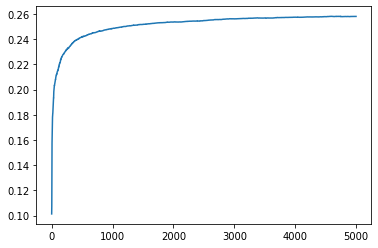

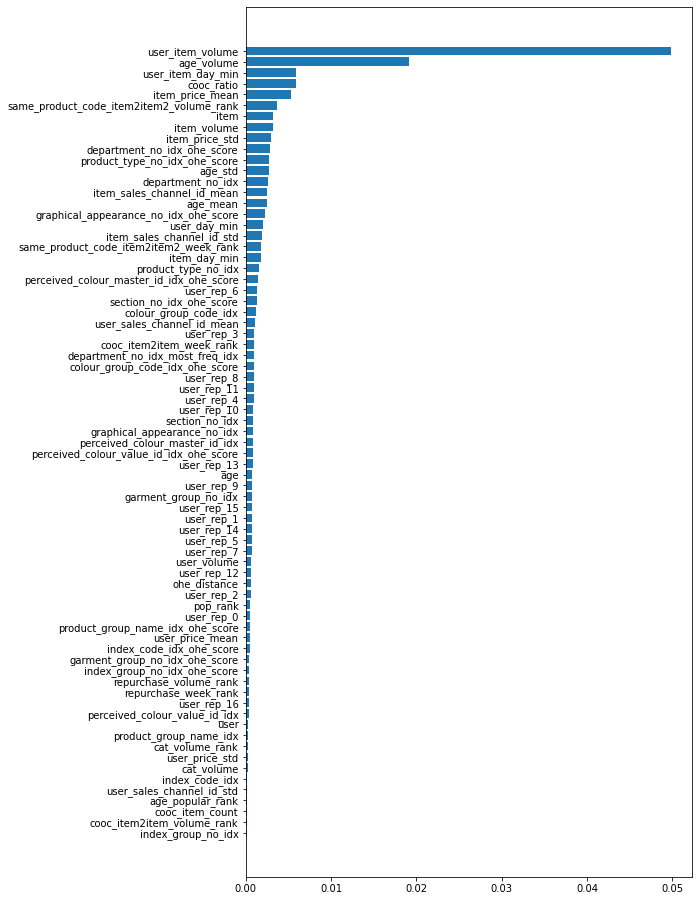

In [17]:
if CFG.model_type == 'LightGBM':
    group_train = get_query_group(train)
    group_valid = get_query_group(valid)

    train_dataset = lgb.Dataset(train[feature_columns], train['y'], group=group_train)
    valid_dataset = lgb.Dataset(valid[feature_columns], valid['y'], group=group_valid, reference=train_dataset)

    params = {
        'objective': 'xendcg',
        'boosting_type': 'gbdt',
        'learning_rate': 1e-6,
        'num_leaves': 255,
        'min_data_in_leaf': 100,
        'metric': 'map',
        'eval_at': 12,
    }

    model = lgb.train(params, train_dataset, valid_sets=[train_dataset, valid_dataset], num_boost_round=1000, callbacks=[lgb.early_stopping(20)])

    lgb.plot_importance(model, importance_type='gain', figsize=(8, 16))

elif CFG.model_type == 'CatBoost':
    train_dataset = catboost.Pool(data=train[feature_columns], label=train['y'], group_id=train['query_group'], cat_features=cat_features)
    valid_dataset = catboost.Pool(data=valid[feature_columns], label=valid['y'], group_id=valid['query_group'], cat_features=cat_features)

    params = {
        'loss_function': 'YetiRank',
        'use_best_model': True,
        'one_hot_max_size': 300,
        'iterations': 5000,
    }
    model = catboost.CatBoost(params)
    model.fit(train_dataset, eval_set=valid_dataset)

    plt.plot(model.get_evals_result()['validation']['PFound'])

    feature_importance = model.get_feature_importance(train_dataset)
    sorted_idx = np.argsort(feature_importance)
    plt.figure(figsize=(8, 16))
    plt.yticks(range(len(feature_columns)), np.array(feature_columns)[sorted_idx])
    plt.barh(range(len(feature_columns)), feature_importance[sorted_idx])


del train, valid, train_dataset, valid_dataset
gc.collect()
with open('output/model_for_validation.pkl', 'wb') as f:
    pickle.dump(model, f)

In [18]:
pred = dataset_valid_all[['user', 'item']].reset_index(drop=True)
pred['pred'] = model.predict(dataset_valid_all[feature_columns])

pred = pred.groupby(['user', 'item'])['pred'].max().reset_index()
pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()

gt = transactions.query("week == 0").groupby('user')['item'].apply(list).reset_index().rename(columns={'item': 'gt'})
merged = gt.merge(pred, on='user', how='left')
merged['item'] = merged['item'].fillna('').apply(list)

merged.to_pickle(f'output/merged_{dataset}.pkl')
dataset_valid_all.to_pickle(f'output/valid_all_{dataset}.pkl')

print('mAP@12:', mapk(merged['gt'], merged['item']))

mAP@12: 0.0354354419005715


<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [19]:
assert False

AssertionError: 

submission

In [ ]:
datasets = [attach_features(transactions, users, items, candidates[idx], 1+idx, CFG.train_weeks) for idx in range(len(candidates))]

for idx in range(len(datasets)):
    datasets[idx]['query_group'] = datasets[idx]['week'].astype(str) + '_' + datasets[idx]['user'].astype(str)
    datasets[idx] = datasets[idx].sort_values(by='query_group').reset_index(drop=True)

train = concat_train(datasets, 0, CFG.train_weeks)

In [ ]:
if CFG.model_type == 'LightGBM':
    group_train = get_query_group(train)
    train_dataset = lgb.Dataset(train[feature_columns], train['y'], group=group_train)

    best_iteration = model.best_iteration
    model = lgb.train(params, train_dataset, num_boost_round=best_iteration)

    lgb.plot_importance(model, importance_type='gain', figsize=(8, 16))

elif CFG.model_type == 'CatBoost':
    train_dataset = catboost.Pool(data=train[feature_columns], label=train['y'], group_id=train['query_group'], cat_features=cat_features)

    params['iterations'] = model.get_best_iteration()
    params['use_best_model'] = False
    model = catboost.CatBoost(params)
    model.fit(train_dataset)

    feature_importance = model.get_feature_importance(train_dataset)
    sorted_idx = np.argsort(feature_importance)
    plt.figure(figsize=(8, 16))
    plt.yticks(range(len(feature_columns)), np.array(feature_columns)[sorted_idx])
    plt.barh(range(len(feature_columns)), feature_importance[sorted_idx])

del train, train_dataset
gc.collect()
with open('output/model_for_submission.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
del datasets, dataset_valid_all, candidates, candidates_valid_all
gc.collect()

In [ ]:
all_users = users['user'].values
all_users

In [ ]:
# to avoid OOM
preds = []

n_split_prediction = 10
n_chunk = (len(all_users) + n_split_prediction - 1)// n_split_prediction
for i in range(0, len(all_users), n_chunk):
    print(f"chunk: {i}")
    target_users = all_users[i:i+n_chunk]

    candidates = create_candidates(transactions, target_users, 0)
    candidates = attach_features(transactions, users, items, candidates, 0, CFG.train_weeks)

    candidates['pred'] = model.predict(candidates[feature_columns])
    pred = candidates.groupby(['user', 'item'])['pred'].max().reset_index()
    pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()
    preds.append(pred)

pred = pd.concat(preds).reset_index(drop=True)
assert len(pred) == len(all_users)
assert np.array_equal(pred['user'].values, all_users)

In [ ]:
for i in range(5):
    plot_images(dataset, pred['item'][i])

In [ ]:
mp_user = pd.read_pickle(f"input/{dataset}/mp_customer_id.pkl")
mp_item = pd.read_pickle(f"input/{dataset}/mp_article_id.pkl")

a_user = mp_user['val'].values
a_item = mp_item['val'].values

pred['customer_id'] = pred['user'].apply(lambda x: a_user[x])
pred['prediction'] = pred['item'].apply(lambda x: list(map(lambda y: a_item[y], x)))

pred['prediction'] = pred['prediction'].apply(lambda x: ' '.join(map(str, x)))

submission = pred[['customer_id', 'prediction']]
submission

In [ ]:
submission.to_csv('submission.csv', index=False)